## Exercise 5.8: Racetrack (programming) 
Consider driving a race car around a turn like those shown in Figure 5.5. You want to go as fast as possible, but not so fast as to run off the track. In our simplified racetrack, the car is at one of a discrete set of grid positions, the cells in the diagram. 
* The velocity is also discrete, a number of grid cells moved horizontally and vertically per time step. 
* The actions are increments to the velocity components. Each may be changed by +1, −1, or 0 in one step, for a total of nine actions. 
* Both velocity components are restricted to be nonnegative and less than 5, and they cannot both be zero except at the starting line. 
* Each episode begins in one of the randomly selected start states with both velocity components zero and ends when the car crosses the finish line. 
* The rewards are −1 for each step until the car crosses the finish line. 
* If the car hits the track boundary, it is moved back to a random position on the starting line, both velocity components are reduced to zero, and the episode continues. 
* Before updating the car’s location at each time step, check to see if the projected path of the car intersects the track boundary. If it intersects the finish line, the episode ends; if it intersects anywhere else, the car is considered to have hit the track boundary and is sent back to the starting line. 
* To make the task more challenging, with probability 0.1 at each time step the velocity increments are both zero, independently of the intended increments. 

Apply a Monte Carlo control method to this task to compute the optimal policy from each starting state. Exhibit several trajectories following the optimal policy (but turn the noise off for these trajectories).

<img src="racetrack.png" width="600">

In [23]:
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os

CELL_TYPE_WALL = 0
CELL_TYPE_TRACK = 1
CELL_TYPE_GOAL = 2
CELL_TYPE_START = 3

class RaceTrack:
    def __init__(self, track, min_vel=0, max_vel=5):
        self.track = track
        self.wall_cells = np.argwhere(track == CELL_TYPE_WALL).tolist()
        self.goal_cells = np.argwhere(track == CELL_TYPE_GOAL).tolist()
        self.start_cells = np.argwhere(track == CELL_TYPE_START).tolist()
        self.min_vel = min_vel
        self.max_vel = max_vel
    
    @classmethod
    def from_csv(cls, file_path):
        
        file_path = os.path.join(os.getcwd(), file_path)
        
        track = genfromtxt(file_path, delimiter=',')
        
        # Flip the y-axis coordinates
        track = np.flip(track, axis=0)

        return cls(track) 
    
    def possible_actions(self, state):
        actions = [[a_y, a_x] for a_y in range(-1, 2) for a_x in range(-1, 2)]
        legal_actions = []

        _, _, v_y, v_x = state

        # Discard illegal actions
        for a in actions:
            a_y, a_x = a
            # Cannot go above speed limit in any x direction
            if v_x + a_x < self.min_vel or v_x + a_x > self.max_vel:
                continue
            # Cannot go above speed limit in any y direction
            if v_y + a_y < self.min_vel or v_y + a_y > self.max_vel:
                continue
            # Cannot noop
            if v_x + a_x == 0 and v_y + a_y == 0:
                continue
            legal_actions.append(a)
        return legal_actions
    
    def random_start_state(self):
        start_cell_idx = np.random.choice(len(self.start_cells))
        start_state = np.array(self.start_cells[start_cell_idx] + [0, 0])
        return start_state
    
    def apply_action(self, state, action):
        y_coord, x_coord, y_vel, x_vel = state
        a_y, a_x = action

        next_y_vel = y_vel + a_y
        next_x_vel = x_vel + a_x
        next_y_coord = y_coord + next_y_vel
        next_x_coord = x_coord + next_x_vel

        path = self.projected_path(
            (y_coord, x_coord), (next_y_vel, next_x_vel))

        if self.crossed_finish_line(path):
        #if self.crossed_finish_line([[next_y_coord, next_x_coord]]):
            return np.array([next_y_coord, next_x_coord, next_y_vel, next_x_vel]), 0, True
        #if self.crossed_track_boundary(path):
        if self.crossed_track_boundary([[next_y_coord, next_x_coord]]):
            return self.random_start_state(), -1, False

        return np.array([next_y_coord, next_x_coord, next_y_vel, next_x_vel]), -1, False
        
    def projected_path(self, state, speed):
        # TODO: Should we only consider end state directly?
        y_coord, x_coord = state
        y_vel, x_vel = speed

        new_y_coord = y_coord + y_vel
        new_x_coord = x_coord + x_vel

        path = []
        for dy in range(min(y_coord, new_y_coord), max(y_coord, new_y_coord) + 1):
            for dx in range(min(x_coord, new_x_coord), max(x_coord, new_x_coord) + 1):
                path.append([dy, dx])
        return path
        
    def crossed_track_boundary(self, projected_path):
        for cell in projected_path:
            y, x = cell
            if y < 0 or y >= self.track.shape[0] or x < 0 or x >= self.track.shape[1] or cell in self.wall_cells:
                return True
        return False

    def crossed_finish_line(self, projected_path):
        for cell in projected_path:
            if cell in self.goal_cells:
                return True
        return False
        
    def draw_episode(self, S, A, R): 
        colors = ['black', 'white', 'yellow', 'red']
        
        print(S)
        
        y_t = [s[1] for s in S]
        x_t = [s[0] for s in S]
        
        plt.figure(figsize=(10,10))
        plt.imshow(self.track, cmap=ListedColormap(colors), origin='lower',interpolation='none')
        
        def rect(pos, edgecolor='k', facecolor='none'):
            r = plt.Rectangle(pos, 1, 1, facecolor=facecolor,
                              edgecolor=edgecolor, linewidth=2)
            plt.gca().add_patch(r)

        for i in range(self.track.shape[0]):
            for j in range(self.track.shape[1]):
                rect((j-0.5, i-0.5))
        
        plt.plot(np.asarray(y_t), np.asarray(x_t),'o-')
        #plt.scatter(y_t[-1], x_t[-1], color='red', s=50)
        
#         fig=plt.figure(figsize=(10,10))
#         im = plt.imshow(self.track, cmap=ListedColormap(colors),
#                         origin='lower', interpolation='none')
        
#         def init():
#             im.set_data(self.track)
#             return [im]
            
#         def animate(i):
#             a = im.get_array()
            
        
        

        

#         

#         if path:
#             for cell in path:
#                 rect((cell[1]-0.5, cell[0]-0.5), edgecolor='g')

#         if car_cell:
#             rect((car_cell[1]-0.5, car_cell[0]-0.5),
#                  edgecolor='g', facecolor='g')

        plt.gca().invert_yaxis()
        #return im
        

In [24]:
rt = RaceTrack.from_csv("../racetracks/map1.csv")

In [25]:
path = rt.projected_path((6,8),(-2,2))
path

[[4, 8], [4, 9], [4, 10], [5, 8], [5, 9], [5, 10], [6, 8], [6, 9], [6, 10]]

In [32]:
import random
import math
from collections import defaultdict

class OnPolicyMonteCarloAgent:
    def __init__(self, track, gamma=0.25, n_episodes=100000, eps=0.9):
        self.track = track
        self.gamma = gamma
        self.n_episodes = n_episodes
        self.eps = eps

        # Initialize Q values and C values
        y_range = track.track.shape[0]
        x_range = track.track.shape[1]
        yvel_range = track.max_vel - track.min_vel + 1
        xvel_range = track.max_vel - track.min_vel + 1
        yacc_range = 3  # -1, 0, +1
        xacc_range = 3  # -1, 0, +1

        # Initialize state-action values
        self.Q = np.zeros((y_range, x_range, yvel_range,
                           xvel_range, yacc_range, xacc_range))

        # Initialize rewards dictionary
        self.R = defaultdict(list)

        # Initial Policy
        # For each state: assign equal probability of selecting each valid action from the state
        self.pi = np.zeros(self.Q.shape, dtype=float)
        for y_coord in range(self.Q.shape[0]):
            for x_coord in range(self.Q.shape[1]):
                for y_vel in range(track.min_vel, track.max_vel + 1):
                    for x_vel in range(track.min_vel, track.max_vel + 1):
                        valid_actions = self.track.possible_actions(
                            (y_coord, x_coord, y_vel, x_vel))
                        for y_acc, x_acc in valid_actions:
                            self.pi[y_coord, x_coord, y_vel, x_vel,
                                    y_acc, x_acc] = 1/len(valid_actions)
                        
    def sample_random_action(self, state):
        # Sample action according to our eps-greedy policy
        # Ensure that probabilities we sample from sum to 1
        y_coord, x_coord, y_vel, x_vel = state

        actionprobs = self.pi[y_coord, x_coord, y_vel, x_vel]
        total_prob = np.sum(actionprobs)
        if not math.isclose(total_prob, 1, abs_tol=0.01):
            print(
                'Action probabilities must sum to 1.0, but summed to {}, state: {}, actionprobs: {}'.format(total_prob, state, self.pi[tuple(state)]))
            sys.exit(1)

        linear_idx = np.random.choice(
            actionprobs.size, p=actionprobs.ravel())
        a = np.unravel_index(linear_idx, actionprobs.shape)
        # In case the value is greater than the max allowed action we need to translate it back into
        # negative coordinates
        a = tuple(acc if acc <= 1 else 1 - acc for acc in a)
        return a
    
    def greedy_action(self, state):
        # Find greedy action according to state-action values Q
        Q_state = self.Q[tuple(state)].copy()
        if not (Q_state == 0).all():
            Q_state[Q_state == 0] = np.nan
        a = np.unravel_index(np.nanargmax(Q_state, axis=None), Q_state.shape)
        # In case the value is greater than the max allowed action we need to translate it back into
        # negative coordinates
        a = tuple(acc if acc <= 1 else 1 - acc for acc in a)
        return a
            
    def generate_episode(self, policy):
        S = []
        A = []
        R = []

        # Select the initial state randomly
        start_state = self.track.random_start_state()
        S.append(start_state)

        terminated = False
        t = 0
        while not terminated:
            St = S[t]

            if t % 10000 == 0:
                print("Step: {}".format(t))
                
            a = policy(St)
            A.append(a)

            next_state, reward, terminated = self.track.apply_action(St, a)

            R.append(reward)
            S.append(next_state)
            t += 1

            # time.sleep(1)
        print("Terminated after {} steps".format(t))
        return S, A, R
    
    def policy_iteration(self):
        policy_stable = False
        it = 0
        while True:
            if self.n_episodes is not None and it > self.n_episodes:
                break
            elif self.n_episodes is None and policy_stable:
                break
            
            print('Iteration {}'.format(it))

            # (a) Generate an episode using pi
            S, A, R = self.generate_episode(self.sample_random_action)

            visited = set()

            # (b) Iterate over s,a pairs and update rewards and q-values
            old_Q = self.Q.copy()
            for t in range(len(S)-2):
                St, At, Rt = S[t], A[t], R[t]

                state_action_key = tuple(St.tolist() + list(At))

                # Skip to next step if we have aldready encountered this state, action pair
                if state_action_key in visited:
                    continue

                visited.add(state_action_key)

                # Calculate return that follows the first occurence of St, At
                G = 0
                for dt in range(len(S)-2, t-1, -1):
                    G = self.gamma * G + R[dt]

                self.R[state_action_key].append(G)
                self.Q[state_action_key] = np.average(self.R[state_action_key])

            # Q-diff: Credit to Joakim Blach Andersen
            Q_diff = abs(old_Q - self.Q)
            print('Q-diff: {}'.format(np.max(Q_diff)))

            # (c) Iterate over all states s and update the eps-greedy policy
            for t in range(len(S)-2):
                y, x, y_vel, x_vel = S[t]

                possible_actions = self.track.possible_actions(S[t])
                for a in possible_actions:
                    a_y, a_x = a

                    self.pi[y, x, y_vel, x_vel, a_y, a_x] = self.eps / \
                        len(possible_actions)

                # Get index of best action
                a_ys, a_xs = tuple(zip(*possible_actions))
                actionvals = self.Q[y, x, y_vel,
                                    x_vel, a_ys, a_xs]
                a_max_idx = np.argmax(actionvals)
                a_max_y, a_max_x = a_ys[a_max_idx], a_xs[a_max_idx]

                self.pi[y, x, y_vel, x_vel, a_max_y, a_max_x] += 1 - self.eps

                actionprobs = self.pi[y, x, y_vel, x_vel]
                total_prob = np.sum(actionprobs)
                if not math.isclose(total_prob, 1, abs_tol=0.01):
                    print(
                        'Action probabilities must sum to 1.0, but summed to {}, state: {}, actionprobs: {}'.format(total_prob, s, self.pi[y, x, y_vel, x_vel]))
                    sys.exit(1)
            
            # Check if convergence in case no number of episodes is set to 0
            if np.allclose(old_Q, self.Q, atol=0.05):
                print("Policy iteration converged after {} episodes".format(it))
                policy_stable = True

            # Counter and update epsilon
#            self.eps = 1/(math.sqrt(it/4+1.1))
            it += 1

In [33]:
agent = OnPolicyMonteCarloAgent(rt, n_episodes=50000, eps=0.5, gamma=0.9)

In [34]:
agent.policy_iteration()

Iteration 0
Step: 0
Terminated after 229 steps
Q-diff: 9.999999999630775
Iteration 1
Step: 0
Terminated after 3849 steps
Q-diff: 9.999999999999995
Iteration 2
Step: 0
Terminated after 1707 steps
Q-diff: 9.999999999999995
Iteration 3
Step: 0
Terminated after 565 steps
Q-diff: 9.999999999999995
Iteration 4
Step: 0
Terminated after 1408 steps
Q-diff: 9.999999999999995
Iteration 5
Step: 0
Terminated after 1780 steps
Q-diff: 9.999999999999995
Iteration 6
Step: 0
Terminated after 100 steps
Q-diff: 9.99840732089115
Iteration 7
Step: 0
Terminated after 468 steps
Q-diff: 9.999999999999995
Iteration 8
Step: 0
Terminated after 2734 steps
Q-diff: 9.999999999999995
Iteration 9
Step: 0
Terminated after 1845 steps
Q-diff: 9.999999999999995
Iteration 10
Step: 0
Terminated after 3702 steps
Q-diff: 9.999999999999995
Iteration 11
Step: 0
Terminated after 539 steps
Q-diff: 9.999999999999995
Iteration 12
Step: 0
Terminated after 58 steps
Q-diff: 9.96242897873864
Iteration 13
Step: 0
Terminated after 1149 s

Terminated after 414 steps
Q-diff: 9.999999999999995
Iteration 113
Step: 0
Terminated after 604 steps
Q-diff: 9.999999999999995
Iteration 114
Step: 0
Terminated after 181 steps
Q-diff: 9.999999794533236
Iteration 115
Step: 0
Terminated after 98 steps
Q-diff: 9.999059538913016
Iteration 116
Step: 0
Terminated after 189 steps
Q-diff: 9.999999920397968
Iteration 117
Step: 0
Terminated after 37 steps
Q-diff: 9.57608841724784
Iteration 118
Step: 0
Terminated after 528 steps
Q-diff: 9.999999999999995
Iteration 119
Step: 0
Terminated after 393 steps
Q-diff: 9.999999999999995
Iteration 120
Step: 0
Terminated after 21 steps
Q-diff: 4.68559
Iteration 121
Step: 0
Terminated after 51 steps
Q-diff: 9.618479575523056
Iteration 122
Step: 0
Terminated after 395 steps
Q-diff: 9.999999999999995
Iteration 123
Step: 0
Terminated after 298 steps
Q-diff: 9.999999999944583
Iteration 124
Step: 0
Terminated after 42 steps
Q-diff: 7.94108867905351
Iteration 125
Step: 0
Terminated after 214 steps
Q-diff: 9.99999

Terminated after 797 steps
Q-diff: 9.999999999999995
Iteration 230
Step: 0
Terminated after 31 steps
Q-diff: 2.71
Iteration 231
Step: 0
Terminated after 40 steps
Q-diff: 7.175704635190001
Iteration 232
Step: 0
Terminated after 140 steps
Q-diff: 9.912720364319124
Iteration 233
Step: 0
Terminated after 15 steps
Q-diff: 4.68559
Iteration 234
Step: 0
Terminated after 231 steps
Q-diff: 9.99999999800744
Iteration 235
Step: 0
Terminated after 144 steps
Q-diff: 7.458134171671
Iteration 236
Step: 0
Terminated after 42 steps
Q-diff: 8.649148282327008
Iteration 237
Step: 0
Terminated after 141 steps
Q-diff: 9.99999261252091
Iteration 238
Step: 0
Terminated after 184 steps
Q-diff: 9.999982838462675
Iteration 239
Step: 0
Terminated after 117 steps
Q-diff: 9.999734386011127
Iteration 240
Step: 0
Terminated after 73 steps
Q-diff: 1.9
Iteration 241
Step: 0
Terminated after 118 steps
Q-diff: 9.999500200419472
Iteration 242
Step: 0
Terminated after 122 steps
Q-diff: 1.5690529804499977
Iteration 243
Step

Terminated after 259 steps
Q-diff: 9.999999999959602
Iteration 351
Step: 0
Terminated after 66 steps
Q-diff: 7.175704635190001
Iteration 352
Step: 0
Terminated after 174 steps
Q-diff: 9.99999261252091
Iteration 353
Step: 0
Terminated after 207 steps
Q-diff: 9.999999947773109
Iteration 354
Step: 0
Terminated after 173 steps
Q-diff: 9.999314403867588
Iteration 355
Step: 0
Terminated after 36 steps
Q-diff: 9.202335569231277
Iteration 356
Step: 0
Terminated after 52 steps
Q-diff: 9.852191170585655
Iteration 357
Step: 0
Terminated after 355 steps
Q-diff: 9.999999999999995
Iteration 358
Step: 0
Terminated after 178 steps
Q-diff: 9.999998767976692
Iteration 359
Step: 0
Terminated after 25 steps
Q-diff: 0.46325504490000036
Iteration 360
Step: 0
Terminated after 87 steps
Q-diff: 9.977814687655382
Iteration 361
Step: 0
Terminated after 16 steps
Q-diff: 1.349897160580138
Iteration 362
Step: 0
Terminated after 55 steps
Q-diff: 9.528987130275377
Iteration 363
Step: 0
Terminated after 286 steps
Q-di

Q-diff: 7.94108867905351
Iteration 465
Step: 0
Terminated after 76 steps
Q-diff: 9.77471600455061
Iteration 466
Step: 0
Terminated after 34 steps
Q-diff: 0.9670580450321049
Iteration 467
Step: 0
Terminated after 40 steps
Q-diff: 9.57608841724784
Iteration 468
Step: 0
Terminated after 29 steps
Q-diff: 1.9483375940173753
Iteration 469
Step: 0
Terminated after 15 steps
Q-diff: 0.18731163434747966
Iteration 470
Step: 0
Terminated after 109 steps
Q-diff: 9.998230356545722
Iteration 471
Step: 0
Terminated after 84 steps
Q-diff: 9.991404955442832
Iteration 472
Step: 0
Terminated after 43 steps
Q-diff: 1.5690529804499977
Iteration 473
Step: 0
Terminated after 158 steps
Q-diff: 9.999998478983569
Iteration 474
Step: 0
Terminated after 219 steps
Q-diff: 9.999999989246948
Iteration 475
Step: 0
Terminated after 96 steps
Q-diff: 9.992264459898548
Iteration 476
Step: 0
Terminated after 56 steps
Q-diff: 9.01522909781639
Iteration 477
Step: 0
Terminated after 55 steps
Q-diff: 9.852191170585655
Iteratio

Terminated after 25 steps
Q-diff: 1.1432590912128742
Iteration 581
Step: 0
Terminated after 57 steps
Q-diff: 1.1514802153001895
Iteration 582
Step: 0
Terminated after 84 steps
Q-diff: 8.49905364703001
Iteration 583
Step: 0
Terminated after 12 steps
Q-diff: 0.6341801291944282
Iteration 584
Step: 0
Terminated after 24 steps
Q-diff: 3.644997008070968
Iteration 585
Step: 0
Terminated after 230 steps
Q-diff: 9.999976458796533
Iteration 586
Step: 0
Terminated after 89 steps
Q-diff: 1.5297771443936057
Iteration 587
Step: 0
Terminated after 37 steps
Q-diff: 4.049999383988346
Iteration 588
Step: 0
Terminated after 24 steps
Q-diff: 2.152336049999997
Iteration 589
Step: 0
Terminated after 148 steps
Q-diff: 9.999976458796533
Iteration 590
Step: 0
Terminated after 13 steps
Q-diff: 1.2815273249999812
Iteration 591
Step: 0
Terminated after 169 steps
Q-diff: 2.9524499999999723
Iteration 592
Step: 0
Terminated after 97 steps
Q-diff: 9.997302783944095
Iteration 593
Step: 0
Terminated after 47 steps
Q-di

Terminated after 46 steps
Q-diff: 9.835767967317395
Iteration 694
Step: 0
Terminated after 62 steps
Q-diff: 9.912720364319124
Iteration 695
Step: 0
Terminated after 39 steps
Q-diff: 7.175704635190001
Iteration 696
Step: 0
Terminated after 37 steps
Q-diff: 0.7701063538005233
Iteration 697
Step: 0
Terminated after 51 steps
Q-diff: 0.776792696721281
Iteration 698
Step: 0
Terminated after 18 steps
Q-diff: 0.18944963050985564
Iteration 699
Step: 0
Terminated after 15 steps
Q-diff: 0.1435748322777819
Iteration 700
Step: 0
Terminated after 11 steps
Q-diff: 3.6391049077111326
Iteration 701
Step: 0
Terminated after 136 steps
Q-diff: 9.999916647515823
Iteration 702
Step: 0
Terminated after 75 steps
Q-diff: 0.544267577834562
Iteration 703
Step: 0
Terminated after 51 steps
Q-diff: 9.817519963685994
Iteration 704
Step: 0
Terminated after 61 steps
Q-diff: 9.77471600455061
Iteration 705
Step: 0
Terminated after 70 steps
Q-diff: 9.953616023134122
Iteration 706
Step: 0
Terminated after 10 steps
Q-diff:

Iteration 816
Step: 0
Terminated after 13 steps
Q-diff: 0.7392617066376088
Iteration 817
Step: 0
Terminated after 49 steps
Q-diff: 9.817519963685994
Iteration 818
Step: 0
Terminated after 40 steps
Q-diff: 4.68559
Iteration 819
Step: 0
Terminated after 29 steps
Q-diff: 2.952449999999997
Iteration 820
Step: 0
Terminated after 77 steps
Q-diff: 9.797244404095549
Iteration 821
Step: 0
Terminated after 63 steps
Q-diff: 1.0632918072743562
Iteration 822
Step: 0
Terminated after 42 steps
Q-diff: 8.905810108684877
Iteration 823
Step: 0
Terminated after 31 steps
Q-diff: 1.028738954874262
Iteration 824
Step: 0
Terminated after 53 steps
Q-diff: 1.6064917968652699
Iteration 825
Step: 0
Terminated after 108 steps
Q-diff: 9.986899794913628
Iteration 826
Step: 0
Terminated after 22 steps
Q-diff: 1.9371024449953786
Iteration 827
Step: 0
Terminated after 37 steps
Q-diff: 0.5006716633870436
Iteration 828
Step: 0
Terminated after 63 steps
Q-diff: 9.953616023134122
Iteration 829
Step: 0
Terminated after 18 

Terminated after 24 steps
Q-diff: 7.7123207545039
Iteration 941
Step: 0
Terminated after 52 steps
Q-diff: 4.2644935651376885
Iteration 942
Step: 0
Terminated after 37 steps
Q-diff: 3.644999999999998
Iteration 943
Step: 0
Terminated after 22 steps
Q-diff: 1.2656273311045183
Iteration 944
Step: 0
Terminated after 18 steps
Q-diff: 1.5690529804499977
Iteration 945
Step: 0
Terminated after 38 steps
Q-diff: 2.230779107368071
Iteration 946
Step: 0
Terminated after 30 steps
Q-diff: 0.3296950172067259
Iteration 947
Step: 0
Terminated after 36 steps
Q-diff: 0.15696842864741534
Iteration 948
Step: 0
Terminated after 40 steps
Q-diff: 0.3589489938459227
Iteration 949
Step: 0
Terminated after 32 steps
Q-diff: 1.0294556604732428
Iteration 950
Step: 0
Terminated after 34 steps
Q-diff: 2.152335947266618
Iteration 951
Step: 0
Terminated after 50 steps
Q-diff: 0.6176733914957264
Iteration 952
Step: 0
Terminated after 188 steps
Q-diff: 9.998955043236684
Iteration 953
Step: 0
Terminated after 12 steps
Q-di

Terminated after 59 steps
Q-diff: 0.3822426677980726
Iteration 1062
Step: 0
Terminated after 84 steps
Q-diff: 0.4786866351655066
Iteration 1063
Step: 0
Terminated after 40 steps
Q-diff: 1.3382432676978269
Iteration 1064
Step: 0
Terminated after 72 steps
Q-diff: 0.7903175433232015
Iteration 1065
Step: 0
Terminated after 56 steps
Q-diff: 0.4521741046981269
Iteration 1066
Step: 0
Terminated after 91 steps
Q-diff: 9.942735831029779
Iteration 1067
Step: 0
Terminated after 70 steps
Q-diff: 1.029455660473202
Iteration 1068
Step: 0
Terminated after 58 steps
Q-diff: 9.797244404095549
Iteration 1069
Step: 0
Terminated after 88 steps
Q-diff: 9.99630011514965
Iteration 1070
Step: 0
Terminated after 34 steps
Q-diff: 0.5967906167805381
Iteration 1071
Step: 0
Terminated after 137 steps
Q-diff: 9.998955043236684
Iteration 1072
Step: 0
Terminated after 99 steps
Q-diff: 7.94108867905351
Iteration 1073
Step: 0
Terminated after 28 steps
Q-diff: 1.2709329098095132
Iteration 1074
Step: 0
Terminated after 10

Iteration 1188
Step: 0
Terminated after 75 steps
Q-diff: 4.68559
Iteration 1189
Step: 0
Terminated after 76 steps
Q-diff: 4.499999999999732
Iteration 1190
Step: 0
Terminated after 15 steps
Q-diff: 0.5739091195284658
Iteration 1191
Step: 0
Terminated after 77 steps
Q-diff: 0.8338590849833256
Iteration 1192
Step: 0
Terminated after 22 steps
Q-diff: 0.7625588259557787
Iteration 1193
Step: 0
Terminated after 67 steps
Q-diff: 2.421698565137688
Iteration 1194
Step: 0
Terminated after 16 steps
Q-diff: 0.3970581586442279
Iteration 1195
Step: 0
Terminated after 51 steps
Q-diff: 3.2804999999999973
Iteration 1196
Step: 0
Terminated after 38 steps
Q-diff: 0.3810392485441909
Iteration 1197
Step: 0
Terminated after 14 steps
Q-diff: 0.44999999999999996
Iteration 1198
Step: 0
Terminated after 171 steps
Q-diff: 9.998033729495246
Iteration 1199
Step: 0
Terminated after 72 steps
Q-diff: 6.12579511
Iteration 1200
Step: 0
Terminated after 54 steps
Q-diff: 0.18152416627203039
Iteration 1201
Step: 0
Terminat

Terminated after 114 steps
Q-diff: 9.202335569231277
Iteration 1310
Step: 0
Terminated after 39 steps
Q-diff: 1.968299957722886
Iteration 1311
Step: 0
Terminated after 15 steps
Q-diff: 0.16110079144820055
Iteration 1312
Step: 0
Terminated after 15 steps
Q-diff: 0.5918335093352489
Iteration 1313
Step: 0
Terminated after 111 steps
Q-diff: 2.020704791589359
Iteration 1314
Step: 0
Terminated after 43 steps
Q-diff: 7.458134171671
Iteration 1315
Step: 0
Terminated after 204 steps
Q-diff: 4.499880473705008
Iteration 1316
Step: 0
Terminated after 23 steps
Q-diff: 1.9370509928492723
Iteration 1317
Step: 0
Terminated after 32 steps
Q-diff: 1.1325674528885337
Iteration 1318
Step: 0
Terminated after 23 steps
Q-diff: 3.644999999999998
Iteration 1319
Step: 0
Terminated after 138 steps
Q-diff: 1.2148971605801382
Iteration 1320
Step: 0
Terminated after 38 steps
Q-diff: 0.3589489937664574
Iteration 1321
Step: 0
Terminated after 56 steps
Q-diff: 0.5872294767605117
Iteration 1322
Step: 0
Terminated after

Iteration 1432
Step: 0
Terminated after 56 steps
Q-diff: 0.6744450421185961
Iteration 1433
Step: 0
Terminated after 82 steps
Q-diff: 1.0220822718799027
Iteration 1434
Step: 0
Terminated after 47 steps
Q-diff: 3.280429420918071
Iteration 1435
Step: 0
Terminated after 44 steps
Q-diff: 1.2709329141644972
Iteration 1436
Step: 0
Terminated after 12 steps
Q-diff: 0.27986770315024945
Iteration 1437
Step: 0
Terminated after 31 steps
Q-diff: 0.48818787882472137
Iteration 1438
Step: 0
Terminated after 50 steps
Q-diff: 1.093476473639356
Iteration 1439
Step: 0
Terminated after 48 steps
Q-diff: 0.5753671627207035
Iteration 1440
Step: 0
Terminated after 34 steps
Q-diff: 0.22868817143991294
Iteration 1441
Step: 0
Terminated after 97 steps
Q-diff: 9.995432240925494
Iteration 1442
Step: 0
Terminated after 61 steps
Q-diff: 0.6349960243662487
Iteration 1443
Step: 0
Terminated after 139 steps
Q-diff: 9.936373145588643
Iteration 1444
Step: 0
Terminated after 36 steps
Q-diff: 0.15115502872402864
Iteration 1

Iteration 1557
Step: 0
Terminated after 33 steps
Q-diff: 0.9167101224443357
Iteration 1558
Step: 0
Terminated after 26 steps
Q-diff: 0.1282320746897483
Iteration 1559
Step: 0
Terminated after 41 steps
Q-diff: 0.2524340231695046
Iteration 1560
Step: 0
Terminated after 72 steps
Q-diff: 0.8802193552051776
Iteration 1561
Step: 0
Terminated after 13 steps
Q-diff: 2.71
Iteration 1562
Step: 0
Terminated after 19 steps
Q-diff: 1.1668503769326417
Iteration 1563
Step: 0
Terminated after 38 steps
Q-diff: 1.2104854519405617
Iteration 1564
Step: 0
Terminated after 44 steps
Q-diff: 7.94108867905351
Iteration 1565
Step: 0
Terminated after 86 steps
Q-diff: 0.5339817710607955
Iteration 1566
Step: 0
Terminated after 10 steps
Q-diff: 0.11439504919419896
Iteration 1567
Step: 0
Terminated after 18 steps
Q-diff: 1.968299977531391
Iteration 1568
Step: 0
Terminated after 10 steps
Q-diff: 0.8646324656718294
Iteration 1569
Step: 0
Terminated after 77 steps
Q-diff: 0.2733196240411049
Iteration 1570
Step: 0
Termi

Q-diff: 9.852191170585655
Iteration 1664
Step: 0
Terminated after 166 steps
Q-diff: 9.994360791266041
Iteration 1665
Step: 0
Terminated after 13 steps
Q-diff: 0.17058219749807257
Iteration 1666
Step: 0
Terminated after 48 steps
Q-diff: 8.649148282327008
Iteration 1667
Step: 0
Terminated after 12 steps
Q-diff: 1.1832066312935874
Iteration 1668
Step: 0
Terminated after 40 steps
Q-diff: 0.5369455494832049
Iteration 1669
Step: 0
Terminated after 75 steps
Q-diff: 0.5599442915835873
Iteration 1670
Step: 0
Terminated after 28 steps
Q-diff: 1.6199994696612254
Iteration 1671
Step: 0
Terminated after 60 steps
Q-diff: 7.94108867905351
Iteration 1672
Step: 0
Terminated after 47 steps
Q-diff: 9.202335569231277
Iteration 1673
Step: 0
Terminated after 89 steps
Q-diff: 0.2058856245440257
Iteration 1674
Step: 0
Terminated after 54 steps
Q-diff: 0.3517740341959481
Iteration 1675
Step: 0
Terminated after 14 steps
Q-diff: 1.7433912616009692
Iteration 1676
Step: 0
Terminated after 20 steps
Q-diff: 0.700969

Terminated after 131 steps
Q-diff: 9.999760947410016
Iteration 1787
Step: 0
Terminated after 70 steps
Q-diff: 0.749017484618522
Iteration 1788
Step: 0
Terminated after 26 steps
Q-diff: 0.37523096007631906
Iteration 1789
Step: 0
Terminated after 35 steps
Q-diff: 4.68559
Iteration 1790
Step: 0
Terminated after 25 steps
Q-diff: 0.5292022877224651
Iteration 1791
Step: 0
Terminated after 53 steps
Q-diff: 0.1520438691949959
Iteration 1792
Step: 0
Terminated after 83 steps
Q-diff: 7.175704635190001
Iteration 1793
Step: 0
Terminated after 48 steps
Q-diff: 0.7452483159075349
Iteration 1794
Step: 0
Terminated after 26 steps
Q-diff: 0.16942116240540983
Iteration 1795
Step: 0
Terminated after 52 steps
Q-diff: 9.892247363356944
Iteration 1796
Step: 0
Terminated after 97 steps
Q-diff: 0.32856521157665775
Iteration 1797
Step: 0
Terminated after 36 steps
Q-diff: 8.905810108684877
Iteration 1798
Step: 0
Terminated after 13 steps
Q-diff: 1.619610687387695
Iteration 1799
Step: 0
Terminated after 171 step

Terminated after 56 steps
Q-diff: 0.22603977635763206
Iteration 1900
Step: 0
Terminated after 24 steps
Q-diff: 1.046035320299998
Iteration 1901
Step: 0
Terminated after 79 steps
Q-diff: 0.19673470183161612
Iteration 1902
Step: 0
Terminated after 12 steps
Q-diff: 0.11934937621441222
Iteration 1903
Step: 0
Terminated after 73 steps
Q-diff: 6.861894039100001
Iteration 1904
Step: 0
Terminated after 35 steps
Q-diff: 0.5253750031941413
Iteration 1905
Step: 0
Terminated after 13 steps
Q-diff: 0.24899125556331825
Iteration 1906
Step: 0
Terminated after 39 steps
Q-diff: 1.0
Iteration 1907
Step: 0
Terminated after 44 steps
Q-diff: 0.34789185494090447
Iteration 1908
Step: 0
Terminated after 55 steps
Q-diff: 0.2121418024541062
Iteration 1909
Step: 0
Terminated after 90 steps
Q-diff: 0.11483631032781716
Iteration 1910
Step: 0
Terminated after 46 steps
Q-diff: 9.797244404095549
Iteration 1911
Step: 0
Terminated after 28 steps
Q-diff: 0.44805580331120787
Iteration 1912
Step: 0
Terminated after 10 ste

Iteration 2008
Step: 0
Terminated after 11 steps
Q-diff: 0.013570292584301313
Policy iteration converged after 2008 episodes
Iteration 2009
Step: 0
Terminated after 99 steps
Q-diff: 9.797244404095549
Iteration 2010
Step: 0
Terminated after 89 steps
Q-diff: 0.4035213227276113
Iteration 2011
Step: 0
Terminated after 91 steps
Q-diff: 9.953616023134122
Iteration 2012
Step: 0
Terminated after 91 steps
Q-diff: 1.1040769059283688
Iteration 2013
Step: 0
Terminated after 16 steps
Q-diff: 0.12180558497234273
Iteration 2014
Step: 0
Terminated after 99 steps
Q-diff: 9.977814687655382
Iteration 2015
Step: 0
Terminated after 133 steps
Q-diff: 1.6402499968250073
Iteration 2016
Step: 0
Terminated after 10 steps
Q-diff: 0.15267596759273605
Iteration 2017
Step: 0
Terminated after 11 steps
Q-diff: 1.2039143377939237
Iteration 2018
Step: 0
Terminated after 42 steps
Q-diff: 8.649148282327008
Iteration 2019
Step: 0
Terminated after 70 steps
Q-diff: 0.41073157982313013
Iteration 2020
Step: 0
Terminated after

Terminated after 188 steps
Q-diff: 9.999982838462675
Iteration 2131
Step: 0
Terminated after 38 steps
Q-diff: 0.5045542448586033
Iteration 2132
Step: 0
Terminated after 113 steps
Q-diff: 9.980033218889844
Iteration 2133
Step: 0
Terminated after 20 steps
Q-diff: 0.10700851768242181
Iteration 2134
Step: 0
Terminated after 45 steps
Q-diff: 0.6914124163629776
Iteration 2135
Step: 0
Terminated after 63 steps
Q-diff: 9.953616023134122
Iteration 2136
Step: 0
Terminated after 17 steps
Q-diff: 0.23452426593801157
Iteration 2137
Step: 0
Terminated after 17 steps
Q-diff: 0.9423882273984816
Iteration 2138
Step: 0
Terminated after 82 steps
Q-diff: 0.20420380243342962
Iteration 2139
Step: 0
Terminated after 17 steps
Q-diff: 0.301744693285654
Iteration 2140
Step: 0
Terminated after 15 steps
Q-diff: 1.0
Iteration 2141
Step: 0
Terminated after 37 steps
Q-diff: 0.5146203243967751
Iteration 2142
Step: 0
Terminated after 29 steps
Q-diff: 0.18441388214117183
Iteration 2143
Step: 0
Terminated after 45 steps

Q-diff: 0.12096279665377452
Iteration 2241
Step: 0
Terminated after 25 steps
Q-diff: 0.762559748498699
Iteration 2242
Step: 0
Terminated after 21 steps
Q-diff: 0.6365427397301513
Iteration 2243
Step: 0
Terminated after 56 steps
Q-diff: 1.4203381060386668
Iteration 2244
Step: 0
Terminated after 32 steps
Q-diff: 0.7723569508411128
Iteration 2245
Step: 0
Terminated after 31 steps
Q-diff: 0.6707565517734153
Iteration 2246
Step: 0
Terminated after 23 steps
Q-diff: 0.32534302211578137
Iteration 2247
Step: 0
Terminated after 29 steps
Q-diff: 8.784233454094307
Iteration 2248
Step: 0
Terminated after 35 steps
Q-diff: 1.2475084242816372
Iteration 2249
Step: 0
Terminated after 17 steps
Q-diff: 0.28210929354642644
Iteration 2250
Step: 0
Terminated after 80 steps
Q-diff: 0.7504731764849932
Iteration 2251
Step: 0
Terminated after 10 steps
Q-diff: 0.0626850119724982
Iteration 2252
Step: 0
Terminated after 21 steps
Q-diff: 0.26773843210257375
Iteration 2253
Step: 0
Terminated after 26 steps
Q-diff: 0.

Q-diff: 1.3499978190297375
Iteration 2353
Step: 0
Terminated after 47 steps
Q-diff: 0.8487063081925905
Iteration 2354
Step: 0
Terminated after 41 steps
Q-diff: 1.2889756660951157
Iteration 2355
Step: 0
Terminated after 29 steps
Q-diff: 0.3214529624236384
Iteration 2356
Step: 0
Terminated after 14 steps
Q-diff: 0.69013554084197
Iteration 2357
Step: 0
Terminated after 21 steps
Q-diff: 0.784526490224998
Iteration 2358
Step: 0
Terminated after 10 steps
Q-diff: 0.0605027864806047
Iteration 2359
Step: 0
Terminated after 31 steps
Q-diff: 1.5937162710513757
Iteration 2360
Step: 0
Terminated after 31 steps
Q-diff: 0.5560230507321631
Iteration 2361
Step: 0
Terminated after 20 steps
Q-diff: 0.2498597356234562
Iteration 2362
Step: 0
Terminated after 14 steps
Q-diff: 0.3892012379781704
Iteration 2363
Step: 0
Terminated after 11 steps
Q-diff: 0.01777568660322526
Policy iteration converged after 2363 episodes
Iteration 2364
Step: 0
Terminated after 13 steps
Q-diff: 0.09306536993202563
Iteration 2365


Iteration 2475
Step: 0
Terminated after 53 steps
Q-diff: 0.20462191170578903
Iteration 2476
Step: 0
Terminated after 54 steps
Q-diff: 0.1997073688256492
Iteration 2477
Step: 0
Terminated after 41 steps
Q-diff: 0.9360973217699486
Iteration 2478
Step: 0
Terminated after 21 steps
Q-diff: 0.41859412234815707
Iteration 2479
Step: 0
Terminated after 65 steps
Q-diff: 0.9291132208197919
Iteration 2480
Step: 0
Terminated after 63 steps
Q-diff: 0.3786976214040685
Iteration 2481
Step: 0
Terminated after 13 steps
Q-diff: 0.41416451617922867
Iteration 2482
Step: 0
Terminated after 11 steps
Q-diff: 0.0964255396371625
Iteration 2483
Step: 0
Terminated after 76 steps
Q-diff: 9.985444216570697
Iteration 2484
Step: 0
Terminated after 20 steps
Q-diff: 0.32315415321033214
Iteration 2485
Step: 0
Terminated after 32 steps
Q-diff: 0.8320170234544886
Iteration 2486
Step: 0
Terminated after 20 steps
Q-diff: 0.06638684559514907
Iteration 2487
Step: 0
Terminated after 31 steps
Q-diff: 1.9
Iteration 2488
Step: 0


Q-diff: 0.25549735050629696
Iteration 2590
Step: 0
Terminated after 14 steps
Q-diff: 0.1505479823247633
Iteration 2591
Step: 0
Terminated after 73 steps
Q-diff: 0.7229931285111029
Iteration 2592
Step: 0
Terminated after 45 steps
Q-diff: 0.11445197090445625
Iteration 2593
Step: 0
Terminated after 59 steps
Q-diff: 3.269407343827691
Iteration 2594
Step: 0
Terminated after 13 steps
Q-diff: 0.45508319334372604
Iteration 2595
Step: 0
Terminated after 12 steps
Q-diff: 0.283015512372776
Iteration 2596
Step: 0
Terminated after 69 steps
Q-diff: 0.1264422308916444
Iteration 2597
Step: 0
Terminated after 36 steps
Q-diff: 0.5054348842975234
Iteration 2598
Step: 0
Terminated after 21 steps
Q-diff: 0.48405123967751784
Iteration 2599
Step: 0
Terminated after 20 steps
Q-diff: 0.5602895420181309
Iteration 2600
Step: 0
Terminated after 15 steps
Q-diff: 0.40515352158440976
Iteration 2601
Step: 0
Terminated after 37 steps
Q-diff: 0.39916506475015723
Iteration 2602
Step: 0
Terminated after 58 steps
Q-diff: 

Terminated after 74 steps
Q-diff: 0.3443621152668115
Iteration 2716
Step: 0
Terminated after 34 steps
Q-diff: 0.14282757297477566
Iteration 2717
Step: 0
Terminated after 100 steps
Q-diff: 9.989388833880039
Iteration 2718
Step: 0
Terminated after 68 steps
Q-diff: 9.921448327887212
Iteration 2719
Step: 0
Terminated after 24 steps
Q-diff: 0.2691909796088403
Iteration 2720
Step: 0
Terminated after 33 steps
Q-diff: 0.21711752691311492
Iteration 2721
Step: 0
Terminated after 11 steps
Q-diff: 0.22401133026014186
Iteration 2722
Step: 0
Terminated after 22 steps
Q-diff: 0.2677810750963978
Iteration 2723
Step: 0
Terminated after 16 steps
Q-diff: 0.48883209525864935
Iteration 2724
Step: 0
Terminated after 95 steps
Q-diff: 0.79587759480461
Iteration 2725
Step: 0
Terminated after 56 steps
Q-diff: 0.10698116467376728
Iteration 2726
Step: 0
Terminated after 28 steps
Q-diff: 1.0
Iteration 2727
Step: 0
Terminated after 36 steps
Q-diff: 3.2804999999999973
Iteration 2728
Step: 0
Terminated after 14 steps

Terminated after 55 steps
Q-diff: 0.10801441334902151
Iteration 2851
Step: 0
Terminated after 26 steps
Q-diff: 0.6126147566250371
Iteration 2852
Step: 0
Terminated after 45 steps
Q-diff: 0.19363855978687106
Iteration 2853
Step: 0
Terminated after 64 steps
Q-diff: 2.71
Iteration 2854
Step: 0
Terminated after 106 steps
Q-diff: 9.96242897873864
Iteration 2855
Step: 0
Terminated after 17 steps
Q-diff: 0.5758500669821895
Iteration 2856
Step: 0
Terminated after 14 steps
Q-diff: 0.48204999949544103
Iteration 2857
Step: 0
Terminated after 59 steps
Q-diff: 9.57608841724784
Iteration 2858
Step: 0
Terminated after 69 steps
Q-diff: 9.921448327887212
Iteration 2859
Step: 0
Terminated after 10 steps
Q-diff: 0.3081903583612071
Iteration 2860
Step: 0
Terminated after 34 steps
Q-diff: 0.5962963631649725
Iteration 2861
Step: 0
Terminated after 39 steps
Q-diff: 4.68559
Iteration 2862
Step: 0
Terminated after 57 steps
Q-diff: 0.22492694126580481
Iteration 2863
Step: 0
Terminated after 66 steps
Q-diff: 9.9

Terminated after 60 steps
Q-diff: 1.0186818474983896
Iteration 2955
Step: 0
Terminated after 11 steps
Q-diff: 0.157102423816454
Iteration 2956
Step: 0
Terminated after 40 steps
Q-diff: 0.14829909469435343
Iteration 2957
Step: 0
Terminated after 17 steps
Q-diff: 0.5951696332499994
Iteration 2958
Step: 0
Terminated after 24 steps
Q-diff: 1.2038605803799527
Iteration 2959
Step: 0
Terminated after 42 steps
Q-diff: 0.2434414622236032
Iteration 2960
Step: 0
Terminated after 24 steps
Q-diff: 0.23572492450974458
Iteration 2961
Step: 0
Terminated after 35 steps
Q-diff: 0.36111199760177115
Iteration 2962
Step: 0
Terminated after 11 steps
Q-diff: 0.12366525280046581
Iteration 2963
Step: 0
Terminated after 14 steps
Q-diff: 0.3335491774282806
Iteration 2964
Step: 0
Terminated after 39 steps
Q-diff: 8.332281830033345
Iteration 2965
Step: 0
Terminated after 51 steps
Q-diff: 0.8455200817562591
Iteration 2966
Step: 0
Terminated after 50 steps
Q-diff: 8.784233454094307
Iteration 2967
Step: 0
Terminated 

Q-diff: 2.3664563149847995
Iteration 3074
Step: 0
Terminated after 43 steps
Q-diff: 1.3284240565871688
Iteration 3075
Step: 0
Terminated after 128 steps
Q-diff: 0.6809507633834624
Iteration 3076
Step: 0
Terminated after 23 steps
Q-diff: 0.5811299256791616
Iteration 3077
Step: 0
Terminated after 91 steps
Q-diff: 9.797244404095549
Iteration 3078
Step: 0
Terminated after 60 steps
Q-diff: 0.7450074073636879
Iteration 3079
Step: 0
Terminated after 31 steps
Q-diff: 0.2535113534061244
Iteration 3080
Step: 0
Terminated after 59 steps
Q-diff: 8.649148282327008
Iteration 3081
Step: 0
Terminated after 14 steps
Q-diff: 0.3357192329907308
Iteration 3082
Step: 0
Terminated after 12 steps
Q-diff: 1.1440212017350584
Iteration 3083
Step: 0
Terminated after 45 steps
Q-diff: 0.4368969889519807
Iteration 3084
Step: 0
Terminated after 16 steps
Q-diff: 0.11950580502221975
Iteration 3085
Step: 0
Terminated after 45 steps
Q-diff: 0.2063836975140667
Iteration 3086
Step: 0
Terminated after 19 steps
Q-diff: 7.45

Terminated after 166 steps
Q-diff: 9.998230356545722
Iteration 3194
Step: 0
Terminated after 45 steps
Q-diff: 0.08630484209818157
Iteration 3195
Step: 0
Terminated after 14 steps
Q-diff: 1.1167726058209908
Iteration 3196
Step: 0
Terminated after 12 steps
Q-diff: 0.07302171292172144
Iteration 3197
Step: 0
Terminated after 41 steps
Q-diff: 3.814493565137689
Iteration 3198
Step: 0
Terminated after 19 steps
Q-diff: 2.38249944850043
Iteration 3199
Step: 0
Terminated after 19 steps
Q-diff: 0.4776128906345871
Iteration 3200
Step: 0
Terminated after 64 steps
Q-diff: 0.7754526823515002
Iteration 3201
Step: 0
Terminated after 82 steps
Q-diff: 0.1911698453953905
Iteration 3202
Step: 0
Terminated after 80 steps
Q-diff: 0.8086079086427791
Iteration 3203
Step: 0
Terminated after 24 steps
Q-diff: 0.12418978120727964
Iteration 3204
Step: 0
Terminated after 17 steps
Q-diff: 1.5871765903314206
Iteration 3205
Step: 0
Terminated after 117 steps
Q-diff: 9.999872957652528
Iteration 3206
Step: 0
Terminated a

Terminated after 10 steps
Q-diff: 0.11733281778839455
Iteration 3318
Step: 0
Terminated after 53 steps
Q-diff: 0.48429890474219306
Iteration 3319
Step: 0
Terminated after 89 steps
Q-diff: 9.997003093271216
Iteration 3320
Step: 0
Terminated after 74 steps
Q-diff: 0.5074346062140496
Iteration 3321
Step: 0
Terminated after 11 steps
Q-diff: 0.05124447305252566
Iteration 3322
Step: 0
Terminated after 111 steps
Q-diff: 9.977814687655382
Iteration 3323
Step: 0
Terminated after 54 steps
Q-diff: 0.24627995862620544
Iteration 3324
Step: 0
Terminated after 13 steps
Q-diff: 0.3265552474191784
Iteration 3325
Step: 0
Terminated after 36 steps
Q-diff: 7.458134171671
Iteration 3326
Step: 0
Terminated after 79 steps
Q-diff: 7.458134171671
Iteration 3327
Step: 0
Terminated after 13 steps
Q-diff: 0.35545215500609295
Iteration 3328
Step: 0
Terminated after 64 steps
Q-diff: 9.528987130275377
Iteration 3329
Step: 0
Terminated after 56 steps
Q-diff: 0.39782123124574653
Iteration 3330
Step: 0
Terminated after

Iteration 3430
Step: 0
Terminated after 30 steps
Q-diff: 0.20871562470868277
Iteration 3431
Step: 0
Terminated after 31 steps
Q-diff: 8.49905364703001
Iteration 3432
Step: 0
Terminated after 26 steps
Q-diff: 0.2589448715827807
Iteration 3433
Step: 0
Terminated after 11 steps
Q-diff: 0.09607196863981127
Iteration 3434
Step: 0
Terminated after 94 steps
Q-diff: 0.4855978087257746
Iteration 3435
Step: 0
Terminated after 23 steps
Q-diff: 0.1271953833667725
Iteration 3436
Step: 0
Terminated after 20 steps
Q-diff: 0.06375164177260118
Iteration 3437
Step: 0
Terminated after 62 steps
Q-diff: 0.4220918542225558
Iteration 3438
Step: 0
Terminated after 20 steps
Q-diff: 0.8032499999356704
Iteration 3439
Step: 0
Terminated after 27 steps
Q-diff: 0.2257094398593793
Iteration 3440
Step: 0
Terminated after 15 steps
Q-diff: 0.27024635763466076
Iteration 3441
Step: 0
Terminated after 9 steps
Q-diff: 0.16760443165547567
Iteration 3442
Step: 0
Terminated after 82 steps
Q-diff: 0.7380158299023671
Iteration 

Iteration 3543
Step: 0
Terminated after 181 steps
Q-diff: 9.997003093271216
Iteration 3544
Step: 0
Terminated after 42 steps
Q-diff: 0.5412824999999986
Iteration 3545
Step: 0
Terminated after 28 steps
Q-diff: 1.268877422580971
Iteration 3546
Step: 0
Terminated after 11 steps
Q-diff: 0.13108957849188485
Iteration 3547
Step: 0
Terminated after 16 steps
Q-diff: 0.40500000000000025
Iteration 3548
Step: 0
Terminated after 15 steps
Q-diff: 0.19835789785642
Iteration 3549
Step: 0
Terminated after 15 steps
Q-diff: 0.884044304043238
Iteration 3550
Step: 0
Terminated after 36 steps
Q-diff: 0.10182608876917953
Iteration 3551
Step: 0
Terminated after 12 steps
Q-diff: 0.16952446901816476
Iteration 3552
Step: 0
Terminated after 103 steps
Q-diff: 0.15302129118516827
Iteration 3553
Step: 0
Terminated after 34 steps
Q-diff: 1.0990418858307995
Iteration 3554
Step: 0
Terminated after 67 steps
Q-diff: 0.26689159979159527
Iteration 3555
Step: 0
Terminated after 36 steps
Q-diff: 0.6862883380036102
Iteration

Iteration 3656
Step: 0
Terminated after 20 steps
Q-diff: 1.9
Iteration 3657
Step: 0
Terminated after 23 steps
Q-diff: 1.5870201257506498
Iteration 3658
Step: 0
Terminated after 11 steps
Q-diff: 0.10284478318456358
Iteration 3659
Step: 0
Terminated after 68 steps
Q-diff: 3.3542513149848006
Iteration 3660
Step: 0
Terminated after 51 steps
Q-diff: 0.36693594402369456
Iteration 3661
Step: 0
Terminated after 34 steps
Q-diff: 0.15133630536653797
Iteration 3662
Step: 0
Terminated after 14 steps
Q-diff: 0.7672969963392191
Iteration 3663
Step: 0
Terminated after 62 steps
Q-diff: 0.44681865727943215
Iteration 3664
Step: 0
Terminated after 14 steps
Q-diff: 3.6297837363891503
Iteration 3665
Step: 0
Terminated after 16 steps
Q-diff: 0.3095824915688823
Iteration 3666
Step: 0
Terminated after 10 steps
Q-diff: 0.01854472743662594
Policy iteration converged after 3666 episodes
Iteration 3667
Step: 0
Terminated after 75 steps
Q-diff: 0.32724123916878245
Iteration 3668
Step: 0
Terminated after 14 steps
Q

Iteration 3766
Step: 0
Terminated after 35 steps
Q-diff: 0.23337994326896627
Iteration 3767
Step: 0
Terminated after 58 steps
Q-diff: 0.6257213041944238
Iteration 3768
Step: 0
Terminated after 12 steps
Q-diff: 0.8043029342877155
Iteration 3769
Step: 0
Terminated after 51 steps
Q-diff: 0.7663917304767214
Iteration 3770
Step: 0
Terminated after 31 steps
Q-diff: 0.19351790424366477
Iteration 3771
Step: 0
Terminated after 108 steps
Q-diff: 0.7557983763482952
Iteration 3772
Step: 0
Terminated after 11 steps
Q-diff: 0.36631956427655066
Iteration 3773
Step: 0
Terminated after 19 steps
Q-diff: 0.08626657483087463
Iteration 3774
Step: 0
Terminated after 50 steps
Q-diff: 9.28210201230815
Iteration 3775
Step: 0
Terminated after 52 steps
Q-diff: 7.458134171671
Iteration 3776
Step: 0
Terminated after 35 steps
Q-diff: 0.5368618463963912
Iteration 3777
Step: 0
Terminated after 14 steps
Q-diff: 0.2688421403916692
Iteration 3778
Step: 0
Terminated after 11 steps
Q-diff: 0.05817176981160799
Iteration 37

Terminated after 88 steps
Q-diff: 0.7218410919998846
Iteration 3881
Step: 0
Terminated after 21 steps
Q-diff: 0.2250000000000001
Iteration 3882
Step: 0
Terminated after 14 steps
Q-diff: 0.086984952414495
Iteration 3883
Step: 0
Terminated after 80 steps
Q-diff: 9.995432240925494
Iteration 3884
Step: 0
Terminated after 67 steps
Q-diff: 9.690968456173676
Iteration 3885
Step: 0
Terminated after 80 steps
Q-diff: 0.4028540529313327
Iteration 3886
Step: 0
Terminated after 12 steps
Q-diff: 0.5975229040145313
Iteration 3887
Step: 0
Terminated after 10 steps
Q-diff: 0.08127002846497877
Iteration 3888
Step: 0
Terminated after 11 steps
Q-diff: 0.21627353595975762
Iteration 3889
Step: 0
Terminated after 17 steps
Q-diff: 1.3499999999999996
Iteration 3890
Step: 0
Terminated after 79 steps
Q-diff: 0.12368622715331412
Iteration 3891
Step: 0
Terminated after 44 steps
Q-diff: 0.14606663558332933
Iteration 3892
Step: 0
Terminated after 10 steps
Q-diff: 0.024945191294729163
Policy iteration converged after

Iteration 4004
Step: 0
Terminated after 16 steps
Q-diff: 0.652585703507631
Iteration 4005
Step: 0
Terminated after 36 steps
Q-diff: 0.204144460813259
Iteration 4006
Step: 0
Terminated after 123 steps
Q-diff: 9.999932484487818
Iteration 4007
Step: 0
Terminated after 92 steps
Q-diff: 0.15839567824377276
Iteration 4008
Step: 0
Terminated after 27 steps
Q-diff: 6.861894039100001
Iteration 4009
Step: 0
Terminated after 25 steps
Q-diff: 1.5526319882615276
Iteration 4010
Step: 0
Terminated after 76 steps
Q-diff: 0.979114860665022
Iteration 4011
Step: 0
Terminated after 21 steps
Q-diff: 0.04035359528597837
Policy iteration converged after 4011 episodes
Iteration 4012
Step: 0
Terminated after 17 steps
Q-diff: 0.1559141386835634
Iteration 4013
Step: 0
Terminated after 22 steps
Q-diff: 0.15466083718421952
Iteration 4014
Step: 0
Terminated after 47 steps
Q-diff: 9.817519963685994
Iteration 4015
Step: 0
Terminated after 24 steps
Q-diff: 0.4361546608358218
Iteration 4016
Step: 0
Terminated after 67 

Iteration 4121
Step: 0
Terminated after 36 steps
Q-diff: 0.7314678161867585
Iteration 4122
Step: 0
Terminated after 87 steps
Q-diff: 0.37691313922056047
Iteration 4123
Step: 0
Terminated after 32 steps
Q-diff: 1.0294093535375914
Iteration 4124
Step: 0
Terminated after 65 steps
Q-diff: 0.7106686725612281
Iteration 4125
Step: 0
Terminated after 16 steps
Q-diff: 0.07975070696427267
Iteration 4126
Step: 0
Terminated after 46 steps
Q-diff: 0.7106630462685484
Iteration 4127
Step: 0
Terminated after 10 steps
Q-diff: 0.08039048907632562
Iteration 4128
Step: 0
Terminated after 15 steps
Q-diff: 1.5872152818130143
Iteration 4129
Step: 0
Terminated after 15 steps
Q-diff: 3.8592397877615277
Iteration 4130
Step: 0
Terminated after 30 steps
Q-diff: 0.28320229612080716
Iteration 4131
Step: 0
Terminated after 21 steps
Q-diff: 0.08213038326670663
Iteration 4132
Step: 0
Terminated after 41 steps
Q-diff: 8.49905364703001
Iteration 4133
Step: 0
Terminated after 27 steps
Q-diff: 0.40500000000000025
Iteratio

Iteration 4231
Step: 0
Terminated after 43 steps
Q-diff: 0.44797910091394044
Iteration 4232
Step: 0
Terminated after 31 steps
Q-diff: 1.635407451337624
Iteration 4233
Step: 0
Terminated after 44 steps
Q-diff: 0.3525998156624546
Iteration 4234
Step: 0
Terminated after 62 steps
Q-diff: 9.749684449500679
Iteration 4235
Step: 0
Terminated after 18 steps
Q-diff: 0.18462610580650995
Iteration 4236
Step: 0
Terminated after 117 steps
Q-diff: 0.6732118282966972
Iteration 4237
Step: 0
Terminated after 13 steps
Q-diff: 0.10347796625691874
Iteration 4238
Step: 0
Terminated after 12 steps
Q-diff: 0.22687473485263787
Iteration 4239
Step: 0
Terminated after 71 steps
Q-diff: 1.7353056541503857
Iteration 4240
Step: 0
Terminated after 54 steps
Q-diff: 0.18085803682622625
Iteration 4241
Step: 0
Terminated after 53 steps
Q-diff: 0.6471298435394992
Iteration 4242
Step: 0
Terminated after 17 steps
Q-diff: 0.29621012917174383
Iteration 4243
Step: 0
Terminated after 17 steps
Q-diff: 0.19847005141692886
Iterat

Iteration 4340
Step: 0
Terminated after 18 steps
Q-diff: 0.1033179865006364
Iteration 4341
Step: 0
Terminated after 27 steps
Q-diff: 0.06169024305575732
Iteration 4342
Step: 0
Terminated after 44 steps
Q-diff: 0.12382514064268157
Iteration 4343
Step: 0
Terminated after 23 steps
Q-diff: 0.1756893859641675
Iteration 4344
Step: 0
Terminated after 151 steps
Q-diff: 9.999825730661902
Iteration 4345
Step: 0
Terminated after 256 steps
Q-diff: 9.999999850214731
Iteration 4346
Step: 0
Terminated after 41 steps
Q-diff: 0.21319402528024423
Iteration 4347
Step: 0
Terminated after 18 steps
Q-diff: 0.14539489765574842
Iteration 4348
Step: 0
Terminated after 30 steps
Q-diff: 0.41559774717047837
Iteration 4349
Step: 0
Terminated after 12 steps
Q-diff: 0.06999058462571384
Iteration 4350
Step: 0
Terminated after 20 steps
Q-diff: 0.3498846712767829
Iteration 4351
Step: 0
Terminated after 49 steps
Q-diff: 0.11731041369301387
Iteration 4352
Step: 0
Terminated after 29 steps
Q-diff: 0.03993796542771477
Poli

Q-diff: 0.01435298167132526
Policy iteration converged after 4446 episodes
Iteration 4447
Step: 0
Terminated after 22 steps
Q-diff: 1.0243600628753242
Iteration 4448
Step: 0
Terminated after 23 steps
Q-diff: 1.2864132625871756
Iteration 4449
Step: 0
Terminated after 55 steps
Q-diff: 0.580921560626809
Iteration 4450
Step: 0
Terminated after 13 steps
Q-diff: 0.305403487278916
Iteration 4451
Step: 0
Terminated after 49 steps
Q-diff: 0.1471482481474382
Iteration 4452
Step: 0
Terminated after 106 steps
Q-diff: 1.8205076139332768
Iteration 4453
Step: 0
Terminated after 11 steps
Q-diff: 0.04804992047860601
Policy iteration converged after 4453 episodes
Iteration 4454
Step: 0
Terminated after 85 steps
Q-diff: 1.457177803366589
Iteration 4455
Step: 0
Terminated after 16 steps
Q-diff: 0.08942300881830612
Iteration 4456
Step: 0
Terminated after 51 steps
Q-diff: 0.3740851282230384
Iteration 4457
Step: 0
Terminated after 83 steps
Q-diff: 0.4363106429214243
Iteration 4458
Step: 0
Terminated after 99

Q-diff: 0.09980150980134717
Iteration 4552
Step: 0
Terminated after 54 steps
Q-diff: 0.7064015660119125
Iteration 4553
Step: 0
Terminated after 14 steps
Q-diff: 0.9060636126570083
Iteration 4554
Step: 0
Terminated after 29 steps
Q-diff: 0.129135452453216
Iteration 4555
Step: 0
Terminated after 27 steps
Q-diff: 1.093244104143051
Iteration 4556
Step: 0
Terminated after 12 steps
Q-diff: 0.21428002255738132
Iteration 4557
Step: 0
Terminated after 112 steps
Q-diff: 9.999760947410016
Iteration 4558
Step: 0
Terminated after 24 steps
Q-diff: 0.0929551191774145
Iteration 4559
Step: 0
Terminated after 25 steps
Q-diff: 0.5154910141409079
Iteration 4560
Step: 0
Terminated after 41 steps
Q-diff: 0.4068637217597928
Iteration 4561
Step: 0
Terminated after 29 steps
Q-diff: 0.22494676135802827
Iteration 4562
Step: 0
Terminated after 66 steps
Q-diff: 1.32749966756555
Iteration 4563
Step: 0
Terminated after 10 steps
Q-diff: 0.029074909757834888
Policy iteration converged after 4563 episodes
Iteration 456

Terminated after 99 steps
Q-diff: 9.999314403867588
Iteration 4661
Step: 0
Terminated after 81 steps
Q-diff: 0.28161754232571745
Iteration 4662
Step: 0
Terminated after 124 steps
Q-diff: 1.6304275223716411
Iteration 4663
Step: 0
Terminated after 49 steps
Q-diff: 0.3703117146757955
Iteration 4664
Step: 0
Terminated after 77 steps
Q-diff: 0.6350646091634458
Iteration 4665
Step: 0
Terminated after 19 steps
Q-diff: 0.05707011500489756
Iteration 4666
Step: 0
Terminated after 40 steps
Q-diff: 0.31363661925355046
Iteration 4667
Step: 0
Terminated after 51 steps
Q-diff: 1.7432593935055642
Iteration 4668
Step: 0
Terminated after 80 steps
Q-diff: 9.995432240925494
Iteration 4669
Step: 0
Terminated after 27 steps
Q-diff: 0.22007677184311447
Iteration 4670
Step: 0
Terminated after 36 steps
Q-diff: 0.29750912678466435
Iteration 4671
Step: 0
Terminated after 19 steps
Q-diff: 0.20605461513028267
Iteration 4672
Step: 0
Terminated after 16 steps
Q-diff: 0.527873617387705
Iteration 4673
Step: 0
Terminat

Terminated after 45 steps
Q-diff: 0.2028946424260969
Iteration 4766
Step: 0
Terminated after 20 steps
Q-diff: 0.7297938997408391
Iteration 4767
Step: 0
Terminated after 35 steps
Q-diff: 0.21471744934158998
Iteration 4768
Step: 0
Terminated after 80 steps
Q-diff: 0.5798721848931017
Iteration 4769
Step: 0
Terminated after 52 steps
Q-diff: 1.046035320299998
Iteration 4770
Step: 0
Terminated after 20 steps
Q-diff: 0.3963542183560289
Iteration 4771
Step: 0
Terminated after 35 steps
Q-diff: 0.06955910283417666
Iteration 4772
Step: 0
Terminated after 66 steps
Q-diff: 0.2218383884504771
Iteration 4773
Step: 0
Terminated after 11 steps
Q-diff: 0.05130666489735436
Iteration 4774
Step: 0
Terminated after 115 steps
Q-diff: 9.966186080864777
Iteration 4775
Step: 0
Terminated after 12 steps
Q-diff: 0.02797593798508835
Policy iteration converged after 4775 episodes
Iteration 4776
Step: 0
Terminated after 18 steps
Q-diff: 1.4849999999999195
Iteration 4777
Step: 0
Terminated after 15 steps
Q-diff: 0.68

Terminated after 42 steps
Q-diff: 0.2615479536676144
Iteration 4879
Step: 0
Terminated after 10 steps
Q-diff: 0.010815555420528256
Policy iteration converged after 4879 episodes
Iteration 4880
Step: 0
Terminated after 61 steps
Q-diff: 0.4853264863823181
Iteration 4881
Step: 0
Terminated after 25 steps
Q-diff: 8.14697981114816
Iteration 4882
Step: 0
Terminated after 13 steps
Q-diff: 0.0623803899699773
Iteration 4883
Step: 0
Terminated after 11 steps
Q-diff: 0.06133846903023965
Iteration 4884
Step: 0
Terminated after 53 steps
Q-diff: 0.5890984806930417
Iteration 4885
Step: 0
Terminated after 31 steps
Q-diff: 7.7123207545039
Iteration 4886
Step: 0
Terminated after 10 steps
Q-diff: 0.12002480157007778
Iteration 4887
Step: 0
Terminated after 58 steps
Q-diff: 8.905810108684877
Iteration 4888
Step: 0
Terminated after 41 steps
Q-diff: 0.14723945075728473
Iteration 4889
Step: 0
Terminated after 36 steps
Q-diff: 0.8032499887661055
Iteration 4890
Step: 0
Terminated after 42 steps
Q-diff: 0.752230

Iteration 4988
Step: 0
Terminated after 41 steps
Q-diff: 0.2372393682406635
Iteration 4989
Step: 0
Terminated after 94 steps
Q-diff: 4.2644935651376885
Iteration 4990
Step: 0
Terminated after 36 steps
Q-diff: 0.17197730721252835
Iteration 4991
Step: 0
Terminated after 23 steps
Q-diff: 0.6805580214512386
Iteration 4992
Step: 0
Terminated after 20 steps
Q-diff: 0.511641675586807
Iteration 4993
Step: 0
Terminated after 43 steps
Q-diff: 0.19702610277885313
Iteration 4994
Step: 0
Terminated after 13 steps
Q-diff: 0.30976195864017786
Iteration 4995
Step: 0
Terminated after 51 steps
Q-diff: 0.26167381651363186
Iteration 4996
Step: 0
Terminated after 18 steps
Q-diff: 0.2809144057685211
Iteration 4997
Step: 0
Terminated after 11 steps
Q-diff: 0.026848365935880913
Policy iteration converged after 4997 episodes
Iteration 4998
Step: 0
Terminated after 76 steps
Q-diff: 0.37636677079451175
Iteration 4999
Step: 0
Terminated after 51 steps
Q-diff: 0.7826060409866908
Iteration 5000
Step: 0
Terminated a

Q-diff: 9.966186080864777
Iteration 5099
Step: 0
Terminated after 13 steps
Q-diff: 0.08276115381691795
Iteration 5100
Step: 0
Terminated after 11 steps
Q-diff: 0.23969345913228413
Iteration 5101
Step: 0
Terminated after 10 steps
Q-diff: 0.04622262563309221
Policy iteration converged after 5101 episodes
Iteration 5102
Step: 0
Terminated after 9 steps
Q-diff: 0.005422958407139689
Policy iteration converged after 5102 episodes
Iteration 5103
Step: 0
Terminated after 44 steps
Q-diff: 1.9
Iteration 5104
Step: 0
Terminated after 11 steps
Q-diff: 0.18424042369915128
Iteration 5105
Step: 0
Terminated after 126 steps
Q-diff: 0.8187201257506498
Iteration 5106
Step: 0
Terminated after 9 steps
Q-diff: 0.005396760540437029
Policy iteration converged after 5106 episodes
Iteration 5107
Step: 0
Terminated after 12 steps
Q-diff: 0.09905168961007238
Iteration 5108
Step: 0
Terminated after 60 steps
Q-diff: 0.9088742943977746
Iteration 5109
Step: 0
Terminated after 12 steps
Q-diff: 0.2252720639464867
Iter

Iteration 5204
Step: 0
Terminated after 13 steps
Q-diff: 0.09170824215882867
Iteration 5205
Step: 0
Terminated after 116 steps
Q-diff: 9.99938296348083
Iteration 5206
Step: 0
Terminated after 24 steps
Q-diff: 0.45356199901090477
Iteration 5207
Step: 0
Terminated after 62 steps
Q-diff: 9.921448327887212
Iteration 5208
Step: 0
Terminated after 38 steps
Q-diff: 0.056709599723527404
Iteration 5209
Step: 0
Terminated after 29 steps
Q-diff: 0.33765538528250794
Iteration 5210
Step: 0
Terminated after 59 steps
Q-diff: 0.8542882316215028
Iteration 5211
Step: 0
Terminated after 98 steps
Q-diff: 9.948462247926802
Iteration 5212
Step: 0
Terminated after 53 steps
Q-diff: 0.34437293179912487
Iteration 5213
Step: 0
Terminated after 39 steps
Q-diff: 0.0706696719701867
Iteration 5214
Step: 0
Terminated after 16 steps
Q-diff: 0.5309998670262202
Iteration 5215
Step: 0
Terminated after 34 steps
Q-diff: 0.554616799971976
Iteration 5216
Step: 0
Terminated after 20 steps
Q-diff: 0.10793544418144574
Iteration

Terminated after 311 steps
Q-diff: 9.999999999998614
Iteration 5310
Step: 0
Terminated after 45 steps
Q-diff: 0.10392750010339391
Iteration 5311
Step: 0
Terminated after 47 steps
Q-diff: 0.10678019489949708
Iteration 5312
Step: 0
Terminated after 112 steps
Q-diff: 9.998230356545722
Iteration 5313
Step: 0
Terminated after 12 steps
Q-diff: 0.18709562197323848
Iteration 5314
Step: 0
Terminated after 26 steps
Q-diff: 0.5082679244931434
Iteration 5315
Step: 0
Terminated after 11 steps
Q-diff: 0.42715959663812875
Iteration 5316
Step: 0
Terminated after 36 steps
Q-diff: 0.34802664380951853
Iteration 5317
Step: 0
Terminated after 57 steps
Q-diff: 0.7125226956874986
Iteration 5318
Step: 0
Terminated after 41 steps
Q-diff: 0.1282244177570533
Iteration 5319
Step: 0
Terminated after 121 steps
Q-diff: 0.303031419741016
Iteration 5320
Step: 0
Terminated after 16 steps
Q-diff: 0.6325271610802741
Iteration 5321
Step: 0
Terminated after 42 steps
Q-diff: 0.26746236437801585
Iteration 5322
Step: 0
Termin

Policy iteration converged after 5419 episodes
Iteration 5420
Step: 0
Terminated after 17 steps
Q-diff: 0.14464284662012572
Iteration 5421
Step: 0
Terminated after 31 steps
Q-diff: 0.21262781523443408
Iteration 5422
Step: 0
Terminated after 37 steps
Q-diff: 1.6188333344654708
Iteration 5423
Step: 0
Terminated after 25 steps
Q-diff: 0.16212500348256942
Iteration 5424
Step: 0
Terminated after 41 steps
Q-diff: 0.18067842162324688
Iteration 5425
Step: 0
Terminated after 11 steps
Q-diff: 0.04665869481176976
Policy iteration converged after 5425 episodes
Iteration 5426
Step: 0
Terminated after 15 steps
Q-diff: 0.020418407835099295
Policy iteration converged after 5426 episodes
Iteration 5427
Step: 0
Terminated after 12 steps
Q-diff: 0.11347719890126662
Iteration 5428
Step: 0
Terminated after 73 steps
Q-diff: 0.054328882703613246
Iteration 5429
Step: 0
Terminated after 10 steps
Q-diff: 0.004970214427746811
Policy iteration converged after 5429 episodes
Iteration 5430
Step: 0
Terminated after 

Iteration 5529
Step: 0
Terminated after 36 steps
Q-diff: 0.13310443352653145
Iteration 5530
Step: 0
Terminated after 29 steps
Q-diff: 2.5320472247503396
Iteration 5531
Step: 0
Terminated after 41 steps
Q-diff: 0.48419275151105623
Iteration 5532
Step: 0
Terminated after 67 steps
Q-diff: 1.743392200499997
Iteration 5533
Step: 0
Terminated after 16 steps
Q-diff: 0.07894800542535574
Iteration 5534
Step: 0
Terminated after 88 steps
Q-diff: 1.0
Iteration 5535
Step: 0
Terminated after 15 steps
Q-diff: 0.1725445279926472
Iteration 5536
Step: 0
Terminated after 13 steps
Q-diff: 0.09984482209525503
Iteration 5537
Step: 0
Terminated after 69 steps
Q-diff: 1.5690529804499977
Iteration 5538
Step: 0
Terminated after 14 steps
Q-diff: 0.3863174650517869
Iteration 5539
Step: 0
Terminated after 19 steps
Q-diff: 0.11765012373188632
Iteration 5540
Step: 0
Terminated after 34 steps
Q-diff: 0.8165751946365987
Iteration 5541
Step: 0
Terminated after 45 steps
Q-diff: 0.9893238508348885
Iteration 5542
Step: 0


Terminated after 147 steps
Q-diff: 9.999314403867588
Iteration 5645
Step: 0
Terminated after 31 steps
Q-diff: 4.049999999999997
Iteration 5646
Step: 0
Terminated after 50 steps
Q-diff: 0.10121714568856532
Iteration 5647
Step: 0
Terminated after 24 steps
Q-diff: 0.6091029812424917
Iteration 5648
Step: 0
Terminated after 23 steps
Q-diff: 0.7577413614811341
Iteration 5649
Step: 0
Terminated after 58 steps
Q-diff: 0.9801842291492999
Iteration 5650
Step: 0
Terminated after 34 steps
Q-diff: 0.5676300594962731
Iteration 5651
Step: 0
Terminated after 102 steps
Q-diff: 9.999550180377526
Iteration 5652
Step: 0
Terminated after 24 steps
Q-diff: 0.2518070416655185
Iteration 5653
Step: 0
Terminated after 46 steps
Q-diff: 0.35834123939603657
Iteration 5654
Step: 0
Terminated after 16 steps
Q-diff: 0.11438359509529672
Iteration 5655
Step: 0
Terminated after 71 steps
Q-diff: 1.0082202290379785
Iteration 5656
Step: 0
Terminated after 13 steps
Q-diff: 0.23456989163105835
Iteration 5657
Step: 0
Terminate

Q-diff: 8.14697981114816
Iteration 5760
Step: 0
Terminated after 11 steps
Q-diff: 0.0261478340229786
Policy iteration converged after 5760 episodes
Iteration 5761
Step: 0
Terminated after 42 steps
Q-diff: 0.39347894425869967
Iteration 5762
Step: 0
Terminated after 11 steps
Q-diff: 0.09602498688180194
Iteration 5763
Step: 0
Terminated after 25 steps
Q-diff: 0.04217001757302974
Policy iteration converged after 5763 episodes
Iteration 5764
Step: 0
Terminated after 13 steps
Q-diff: 0.36095341410165194
Iteration 5765
Step: 0
Terminated after 35 steps
Q-diff: 0.33981867718177483
Iteration 5766
Step: 0
Terminated after 81 steps
Q-diff: 0.14215286472994215
Iteration 5767
Step: 0
Terminated after 25 steps
Q-diff: 0.1483899678198588
Iteration 5768
Step: 0
Terminated after 127 steps
Q-diff: 9.95825442082071
Iteration 5769
Step: 0
Terminated after 153 steps
Q-diff: 2.71
Iteration 5770
Step: 0
Terminated after 28 steps
Q-diff: 0.3271379971126196
Iteration 5771
Step: 0
Terminated after 56 steps
Q-di

Q-diff: 0.41700345738515576
Iteration 5882
Step: 0
Terminated after 12 steps
Q-diff: 0.10014763235885393
Iteration 5883
Step: 0
Terminated after 16 steps
Q-diff: 1.9617437810324327
Iteration 5884
Step: 0
Terminated after 11 steps
Q-diff: 0.07557592525819867
Iteration 5885
Step: 0
Terminated after 24 steps
Q-diff: 1.2913861666167694
Iteration 5886
Step: 0
Terminated after 34 steps
Q-diff: 0.13648129279548016
Iteration 5887
Step: 0
Terminated after 25 steps
Q-diff: 0.45958077143580667
Iteration 5888
Step: 0
Terminated after 47 steps
Q-diff: 0.41390104068019795
Iteration 5889
Step: 0
Terminated after 24 steps
Q-diff: 0.29893414783488836
Iteration 5890
Step: 0
Terminated after 61 steps
Q-diff: 0.5516073459957331
Iteration 5891
Step: 0
Terminated after 41 steps
Q-diff: 8.649148282327008
Iteration 5892
Step: 0
Terminated after 53 steps
Q-diff: 0.6492473713478066
Iteration 5893
Step: 0
Terminated after 48 steps
Q-diff: 0.07036396046764004
Iteration 5894
Step: 0
Terminated after 77 steps
Q-dif

Terminated after 20 steps
Q-diff: 0.008298066913098978
Policy iteration converged after 5992 episodes
Iteration 5993
Step: 0
Terminated after 9 steps
Q-diff: 0.004598691994479154
Policy iteration converged after 5993 episodes
Iteration 5994
Step: 0
Terminated after 82 steps
Q-diff: 9.528987130275377
Iteration 5995
Step: 0
Terminated after 10 steps
Q-diff: 0.010975242018465003
Policy iteration converged after 5995 episodes
Iteration 5996
Step: 0
Terminated after 55 steps
Q-diff: 0.180331249937689
Iteration 5997
Step: 0
Terminated after 43 steps
Q-diff: 0.5374177955464692
Iteration 5998
Step: 0
Terminated after 115 steps
Q-diff: 0.8550168095869752
Iteration 5999
Step: 0
Terminated after 43 steps
Q-diff: 0.23008008610076125
Iteration 6000
Step: 0
Terminated after 71 steps
Q-diff: 0.3730138992172751
Iteration 6001
Step: 0
Terminated after 37 steps
Q-diff: 0.2616738165134116
Iteration 6002
Step: 0
Terminated after 49 steps
Q-diff: 0.36628983108776936
Iteration 6003
Step: 0
Terminated after 

Terminated after 117 steps
Q-diff: 9.999858841836142
Iteration 6113
Step: 0
Terminated after 33 steps
Q-diff: 0.039765384667468595
Policy iteration converged after 6113 episodes
Iteration 6114
Step: 0
Terminated after 12 steps
Q-diff: 0.07829312620269313
Iteration 6115
Step: 0
Terminated after 92 steps
Q-diff: 2.846816650164012
Iteration 6116
Step: 0
Terminated after 21 steps
Q-diff: 0.06336173421125224
Iteration 6117
Step: 0
Terminated after 67 steps
Q-diff: 0.7192657837685035
Iteration 6118
Step: 0
Terminated after 24 steps
Q-diff: 0.22183262958547356
Iteration 6119
Step: 0
Terminated after 30 steps
Q-diff: 0.2101246591053565
Iteration 6120
Step: 0
Terminated after 45 steps
Q-diff: 0.09482535292380323
Iteration 6121
Step: 0
Terminated after 66 steps
Q-diff: 0.14333503480712828
Iteration 6122
Step: 0
Terminated after 77 steps
Q-diff: 0.7633154643970395
Iteration 6123
Step: 0
Terminated after 79 steps
Q-diff: 0.33513915428148167
Iteration 6124
Step: 0
Terminated after 89 steps
Q-diff: 

Terminated after 19 steps
Q-diff: 0.06270926754086759
Iteration 6217
Step: 0
Terminated after 36 steps
Q-diff: 2.5358479899420887
Iteration 6218
Step: 0
Terminated after 107 steps
Q-diff: 9.998230356545722
Iteration 6219
Step: 0
Terminated after 13 steps
Q-diff: 0.15152740621373617
Iteration 6220
Step: 0
Terminated after 32 steps
Q-diff: 0.45585492750055856
Iteration 6221
Step: 0
Terminated after 18 steps
Q-diff: 0.06191383228223124
Iteration 6222
Step: 0
Terminated after 26 steps
Q-diff: 0.08645558320595015
Iteration 6223
Step: 0
Terminated after 88 steps
Q-diff: 0.6638545717827178
Iteration 6224
Step: 0
Terminated after 22 steps
Q-diff: 0.11825489771624476
Iteration 6225
Step: 0
Terminated after 33 steps
Q-diff: 0.5391316738658212
Iteration 6226
Step: 0
Terminated after 19 steps
Q-diff: 0.17401589151794994
Iteration 6227
Step: 0
Terminated after 32 steps
Q-diff: 0.49238545109180265
Iteration 6228
Step: 0
Terminated after 30 steps
Q-diff: 0.24473310561065453
Iteration 6229
Step: 0
Ter

Terminated after 68 steps
Q-diff: 0.18459021841789003
Iteration 6331
Step: 0
Terminated after 149 steps
Q-diff: 0.2106429920943622
Iteration 6332
Step: 0
Terminated after 80 steps
Q-diff: 0.11793974504643678
Iteration 6333
Step: 0
Terminated after 12 steps
Q-diff: 0.06037420178522357
Iteration 6334
Step: 0
Terminated after 25 steps
Q-diff: 0.6114089817631498
Iteration 6335
Step: 0
Terminated after 18 steps
Q-diff: 0.059354173312897274
Iteration 6336
Step: 0
Terminated after 75 steps
Q-diff: 0.5311475287047385
Iteration 6337
Step: 0
Terminated after 52 steps
Q-diff: 3.2791513919720474
Iteration 6338
Step: 0
Terminated after 11 steps
Q-diff: 0.029695116885357198
Policy iteration converged after 6338 episodes
Iteration 6339
Step: 0
Terminated after 22 steps
Q-diff: 0.12339186537333191
Iteration 6340
Step: 0
Terminated after 27 steps
Q-diff: 0.22794097666399793
Iteration 6341
Step: 0
Terminated after 19 steps
Q-diff: 0.302597354138344
Iteration 6342
Step: 0
Terminated after 28 steps
Q-diff

Q-diff: 0.012446462694579274
Policy iteration converged after 6433 episodes
Iteration 6434
Step: 0
Terminated after 88 steps
Q-diff: 0.19970457334856206
Iteration 6435
Step: 0
Terminated after 16 steps
Q-diff: 0.06933873298027837
Iteration 6436
Step: 0
Terminated after 12 steps
Q-diff: 0.3216627554952014
Iteration 6437
Step: 0
Terminated after 10 steps
Q-diff: 0.014551651891410167
Policy iteration converged after 6437 episodes
Iteration 6438
Step: 0
Terminated after 34 steps
Q-diff: 0.6745570173758537
Iteration 6439
Step: 0
Terminated after 40 steps
Q-diff: 0.11717842589304972
Iteration 6440
Step: 0
Terminated after 14 steps
Q-diff: 0.04821408360686341
Policy iteration converged after 6440 episodes
Iteration 6441
Step: 0
Terminated after 16 steps
Q-diff: 0.013679147287948723
Policy iteration converged after 6441 episodes
Iteration 6442
Step: 0
Terminated after 52 steps
Q-diff: 7.7123207545039
Iteration 6443
Step: 0
Terminated after 37 steps
Q-diff: 1.0294556604732428
Iteration 6444
Ste

Terminated after 26 steps
Q-diff: 0.30007630507073735
Iteration 6560
Step: 0
Terminated after 101 steps
Q-diff: 1.326822634213026
Iteration 6561
Step: 0
Terminated after 21 steps
Q-diff: 0.17424972285798646
Iteration 6562
Step: 0
Terminated after 16 steps
Q-diff: 0.03269663344540508
Policy iteration converged after 6562 episodes
Iteration 6563
Step: 0
Terminated after 62 steps
Q-diff: 0.25314586933363437
Iteration 6564
Step: 0
Terminated after 17 steps
Q-diff: 0.0324169582213063
Policy iteration converged after 6564 episodes
Iteration 6565
Step: 0
Terminated after 34 steps
Q-diff: 3.6449838537699133
Iteration 6566
Step: 0
Terminated after 101 steps
Q-diff: 0.40329539651379864
Iteration 6567
Step: 0
Terminated after 32 steps
Q-diff: 7.175704635190001
Iteration 6568
Step: 0
Terminated after 28 steps
Q-diff: 0.4574714668982258
Iteration 6569
Step: 0
Terminated after 59 steps
Q-diff: 0.5027826102902928
Iteration 6570
Step: 0
Terminated after 9 steps
Q-diff: 0.004204148422774168
Policy iter

Iteration 6676
Step: 0
Terminated after 12 steps
Q-diff: 0.049020361194904716
Policy iteration converged after 6676 episodes
Iteration 6677
Step: 0
Terminated after 15 steps
Q-diff: 0.12437451369038577
Iteration 6678
Step: 0
Terminated after 36 steps
Q-diff: 0.3007903271887358
Iteration 6679
Step: 0
Terminated after 21 steps
Q-diff: 0.08928776105901548
Iteration 6680
Step: 0
Terminated after 28 steps
Q-diff: 0.22425035096039458
Iteration 6681
Step: 0
Terminated after 15 steps
Q-diff: 0.3097994199234311
Iteration 6682
Step: 0
Terminated after 14 steps
Q-diff: 0.20857363973267962
Iteration 6683
Step: 0
Terminated after 12 steps
Q-diff: 0.12553341949032149
Iteration 6684
Step: 0
Terminated after 16 steps
Q-diff: 0.6453522632638835
Iteration 6685
Step: 0
Terminated after 31 steps
Q-diff: 0.09414053991819138
Iteration 6686
Step: 0
Terminated after 29 steps
Q-diff: 0.16163831921750216
Iteration 6687
Step: 0
Terminated after 13 steps
Q-diff: 0.0279901442813264
Policy iteration converged after

Iteration 6793
Step: 0
Terminated after 39 steps
Q-diff: 0.2549873442994892
Iteration 6794
Step: 0
Terminated after 12 steps
Q-diff: 0.06600782376581726
Iteration 6795
Step: 0
Terminated after 23 steps
Q-diff: 0.7474454524154215
Iteration 6796
Step: 0
Terminated after 49 steps
Q-diff: 0.1380743682288701
Iteration 6797
Step: 0
Terminated after 11 steps
Q-diff: 0.24724582118774752
Iteration 6798
Step: 0
Terminated after 35 steps
Q-diff: 0.11443536351823091
Iteration 6799
Step: 0
Terminated after 69 steps
Q-diff: 0.44143581507602114
Iteration 6800
Step: 0
Terminated after 26 steps
Q-diff: 0.35833720769933386
Iteration 6801
Step: 0
Terminated after 15 steps
Q-diff: 0.5349577257960982
Iteration 6802
Step: 0
Terminated after 13 steps
Q-diff: 0.3863151595136869
Iteration 6803
Step: 0
Terminated after 32 steps
Q-diff: 0.33857808037346615
Iteration 6804
Step: 0
Terminated after 15 steps
Q-diff: 0.09408490862224284
Iteration 6805
Step: 0
Terminated after 12 steps
Q-diff: 0.07236689155489806
Iter

Terminated after 40 steps
Q-diff: 0.20259542254096807
Iteration 6900
Step: 0
Terminated after 12 steps
Q-diff: 0.049052982667785905
Policy iteration converged after 6900 episodes
Iteration 6901
Step: 0
Terminated after 44 steps
Q-diff: 0.2610154841839867
Iteration 6902
Step: 0
Terminated after 62 steps
Q-diff: 1.0
Iteration 6903
Step: 0
Terminated after 64 steps
Q-diff: 7.94108867905351
Iteration 6904
Step: 0
Terminated after 46 steps
Q-diff: 3.439
Iteration 6905
Step: 0
Terminated after 11 steps
Q-diff: 0.05159139619756559
Iteration 6906
Step: 0
Terminated after 45 steps
Q-diff: 0.9478788197031669
Iteration 6907
Step: 0
Terminated after 64 steps
Q-diff: 0.5601513251192589
Iteration 6908
Step: 0
Terminated after 17 steps
Q-diff: 0.08152492445550763
Iteration 6909
Step: 0
Terminated after 14 steps
Q-diff: 0.046846632783509534
Policy iteration converged after 6909 episodes
Iteration 6910
Step: 0
Terminated after 56 steps
Q-diff: 9.4185026299696
Iteration 6911
Step: 0
Terminated after 26 

Iteration 7019
Step: 0
Terminated after 98 steps
Q-diff: 0.5665132637624803
Iteration 7020
Step: 0
Terminated after 46 steps
Q-diff: 0.25950257958244194
Iteration 7021
Step: 0
Terminated after 17 steps
Q-diff: 0.11148448362909669
Iteration 7022
Step: 0
Terminated after 20 steps
Q-diff: 1.9
Iteration 7023
Step: 0
Terminated after 38 steps
Q-diff: 0.08919762468837789
Iteration 7024
Step: 0
Terminated after 60 steps
Q-diff: 0.1292430477737856
Iteration 7025
Step: 0
Terminated after 21 steps
Q-diff: 0.5802005503767731
Iteration 7026
Step: 0
Terminated after 74 steps
Q-diff: 1.4999999999999991
Iteration 7027
Step: 0
Terminated after 18 steps
Q-diff: 0.1951573751732143
Iteration 7028
Step: 0
Terminated after 26 steps
Q-diff: 0.09313856163086776
Iteration 7029
Step: 0
Terminated after 72 steps
Q-diff: 0.5141497521842116
Iteration 7030
Step: 0
Terminated after 26 steps
Q-diff: 0.2808409492065511
Iteration 7031
Step: 0
Terminated after 30 steps
Q-diff: 0.11261979426854296
Iteration 7032
Step: 0

Q-diff: 0.2624547624730482
Iteration 7134
Step: 0
Terminated after 49 steps
Q-diff: 9.690968456173676
Iteration 7135
Step: 0
Terminated after 21 steps
Q-diff: 1.4999999999999991
Iteration 7136
Step: 0
Terminated after 12 steps
Q-diff: 0.0037984993629480712
Policy iteration converged after 7136 episodes
Iteration 7137
Step: 0
Terminated after 84 steps
Q-diff: 8.49905364703001
Iteration 7138
Step: 0
Terminated after 22 steps
Q-diff: 0.4562888618134249
Iteration 7139
Step: 0
Terminated after 16 steps
Q-diff: 0.18862665615267993
Iteration 7140
Step: 0
Terminated after 92 steps
Q-diff: 0.12609924384037008
Iteration 7141
Step: 0
Terminated after 115 steps
Q-diff: 0.1385848283214326
Iteration 7142
Step: 0
Terminated after 42 steps
Q-diff: 9.113706188034751
Iteration 7143
Step: 0
Terminated after 26 steps
Q-diff: 0.24854634528058206
Iteration 7144
Step: 0
Terminated after 21 steps
Q-diff: 0.25649999999999995
Iteration 7145
Step: 0
Terminated after 55 steps
Q-diff: 1.0934999999999997
Iteration 

Iteration 7242
Step: 0
Terminated after 31 steps
Q-diff: 0.36137014704815584
Iteration 7243
Step: 0
Terminated after 11 steps
Q-diff: 0.07132364788029655
Iteration 7244
Step: 0
Terminated after 23 steps
Q-diff: 0.05217821447597437
Iteration 7245
Step: 0
Terminated after 28 steps
Q-diff: 0.33698845672684286
Iteration 7246
Step: 0
Terminated after 33 steps
Q-diff: 0.2906346648825604
Iteration 7247
Step: 0
Terminated after 66 steps
Q-diff: 4.499354964960916
Iteration 7248
Step: 0
Terminated after 23 steps
Q-diff: 0.30821607877773527
Iteration 7249
Step: 0
Terminated after 33 steps
Q-diff: 0.11566010593094767
Iteration 7250
Step: 0
Terminated after 31 steps
Q-diff: 0.5905187410246118
Iteration 7251
Step: 0
Terminated after 60 steps
Q-diff: 0.9528481131755848
Iteration 7252
Step: 0
Terminated after 19 steps
Q-diff: 0.10656072113682136
Iteration 7253
Step: 0
Terminated after 79 steps
Q-diff: 1.485279990921498
Iteration 7254
Step: 0
Terminated after 21 steps
Q-diff: 0.03516287376702465
Policy

Terminated after 125 steps
Q-diff: 0.35089914471528516
Iteration 7356
Step: 0
Terminated after 26 steps
Q-diff: 8.649148282327008
Iteration 7357
Step: 0
Terminated after 11 steps
Q-diff: 0.014927276204009132
Policy iteration converged after 7357 episodes
Iteration 7358
Step: 0
Terminated after 18 steps
Q-diff: 0.12210675450381281
Iteration 7359
Step: 0
Terminated after 16 steps
Q-diff: 0.07059429668745931
Iteration 7360
Step: 0
Terminated after 31 steps
Q-diff: 0.8287846153948024
Iteration 7361
Step: 0
Terminated after 50 steps
Q-diff: 0.9404919201476716
Iteration 7362
Step: 0
Terminated after 24 steps
Q-diff: 0.6734093943321637
Iteration 7363
Step: 0
Terminated after 68 steps
Q-diff: 0.40391034351972
Iteration 7364
Step: 0
Terminated after 39 steps
Q-diff: 0.11655649887341824
Iteration 7365
Step: 0
Terminated after 31 steps
Q-diff: 0.6245349124595467
Iteration 7366
Step: 0
Terminated after 37 steps
Q-diff: 9.353891811077334
Iteration 7367
Step: 0
Terminated after 22 steps
Q-diff: 0.40

Terminated after 15 steps
Q-diff: 0.6976760770969612
Iteration 7459
Step: 0
Terminated after 13 steps
Q-diff: 0.195059813410424
Iteration 7460
Step: 0
Terminated after 20 steps
Q-diff: 0.22632946884324312
Iteration 7461
Step: 0
Terminated after 40 steps
Q-diff: 0.28975046508729996
Iteration 7462
Step: 0
Terminated after 26 steps
Q-diff: 0.6111467977059064
Iteration 7463
Step: 0
Terminated after 63 steps
Q-diff: 0.43521021980937746
Iteration 7464
Step: 0
Terminated after 13 steps
Q-diff: 0.017815554691503976
Policy iteration converged after 7464 episodes
Iteration 7465
Step: 0
Terminated after 39 steps
Q-diff: 0.1724619627820818
Iteration 7466
Step: 0
Terminated after 51 steps
Q-diff: 9.528987130275377
Iteration 7467
Step: 0
Terminated after 24 steps
Q-diff: 0.35341062868987727
Iteration 7468
Step: 0
Terminated after 12 steps
Q-diff: 0.023112318190863235
Policy iteration converged after 7468 episodes
Iteration 7469
Step: 0
Terminated after 24 steps
Q-diff: 0.16606033365525974
Iteration 

Terminated after 12 steps
Q-diff: 1.0567846207906673
Iteration 7568
Step: 0
Terminated after 23 steps
Q-diff: 2.3445667270471535
Iteration 7569
Step: 0
Terminated after 33 steps
Q-diff: 0.08842801663609734
Iteration 7570
Step: 0
Terminated after 97 steps
Q-diff: 0.09290739634983858
Iteration 7571
Step: 0
Terminated after 77 steps
Q-diff: 9.86697205352709
Iteration 7572
Step: 0
Terminated after 151 steps
Q-diff: 9.999550180377526
Iteration 7573
Step: 0
Terminated after 13 steps
Q-diff: 0.04665432891247967
Policy iteration converged after 7573 episodes
Iteration 7574
Step: 0
Terminated after 14 steps
Q-diff: 0.039429053004767844
Policy iteration converged after 7574 episodes
Iteration 7575
Step: 0
Terminated after 13 steps
Q-diff: 0.039409690053712865
Policy iteration converged after 7575 episodes
Iteration 7576
Step: 0
Terminated after 94 steps
Q-diff: 9.948462247926802
Iteration 7577
Step: 0
Terminated after 21 steps
Q-diff: 0.319653921140711
Iteration 7578
Step: 0
Terminated after 53 

Q-diff: 0.6454420915817476
Iteration 7679
Step: 0
Terminated after 14 steps
Q-diff: 0.07793953167248091
Iteration 7680
Step: 0
Terminated after 12 steps
Q-diff: 0.04036642588819528
Policy iteration converged after 7680 episodes
Iteration 7681
Step: 0
Terminated after 74 steps
Q-diff: 0.1977966569501981
Iteration 7682
Step: 0
Terminated after 57 steps
Q-diff: 1.3853651950976091
Iteration 7683
Step: 0
Terminated after 11 steps
Q-diff: 0.02392353541041281
Policy iteration converged after 7683 episodes
Iteration 7684
Step: 0
Terminated after 19 steps
Q-diff: 0.1965519824556754
Iteration 7685
Step: 0
Terminated after 62 steps
Q-diff: 0.23804850534099664
Iteration 7686
Step: 0
Terminated after 48 steps
Q-diff: 0.15997566134617625
Iteration 7687
Step: 0
Terminated after 38 steps
Q-diff: 2.71
Iteration 7688
Step: 0
Terminated after 14 steps
Q-diff: 0.02329898422371013
Policy iteration converged after 7688 episodes
Iteration 7689
Step: 0
Terminated after 12 steps
Q-diff: 0.035196474889415796
Po

Terminated after 29 steps
Q-diff: 0.2145600690875824
Iteration 7783
Step: 0
Terminated after 43 steps
Q-diff: 0.16425502102296718
Iteration 7784
Step: 0
Terminated after 29 steps
Q-diff: 0.6764883471667389
Iteration 7785
Step: 0
Terminated after 15 steps
Q-diff: 0.01924328337668868
Policy iteration converged after 7785 episodes
Iteration 7786
Step: 0
Terminated after 19 steps
Q-diff: 0.2895688173255557
Iteration 7787
Step: 0
Terminated after 89 steps
Q-diff: 0.34218181399953007
Iteration 7788
Step: 0
Terminated after 16 steps
Q-diff: 0.12573088466516413
Iteration 7789
Step: 0
Terminated after 45 steps
Q-diff: 0.1952544213730576
Iteration 7790
Step: 0
Terminated after 32 steps
Q-diff: 0.5585473346305596
Iteration 7791
Step: 0
Terminated after 83 steps
Q-diff: 1.0
Iteration 7792
Step: 0
Terminated after 10 steps
Q-diff: 0.0025438568747642165
Policy iteration converged after 7792 episodes
Iteration 7793
Step: 0
Terminated after 15 steps
Q-diff: 0.05746274892807257
Iteration 7794
Step: 0
T

Q-diff: 0.2850119371650397
Iteration 7886
Step: 0
Terminated after 12 steps
Q-diff: 0.11798761314231809
Iteration 7887
Step: 0
Terminated after 21 steps
Q-diff: 0.06693303711305809
Iteration 7888
Step: 0
Terminated after 12 steps
Q-diff: 0.28440287911970685
Iteration 7889
Step: 0
Terminated after 10 steps
Q-diff: 0.035437929392214684
Policy iteration converged after 7889 episodes
Iteration 7890
Step: 0
Terminated after 12 steps
Q-diff: 2.186992766559478
Iteration 7891
Step: 0
Terminated after 44 steps
Q-diff: 0.3755518927668895
Iteration 7892
Step: 0
Terminated after 191 steps
Q-diff: 2.308499931511079
Iteration 7893
Step: 0
Terminated after 28 steps
Q-diff: 1.4669685367882312
Iteration 7894
Step: 0
Terminated after 12 steps
Q-diff: 0.047299142848681086
Policy iteration converged after 7894 episodes
Iteration 7895
Step: 0
Terminated after 34 steps
Q-diff: 0.07399357023882303
Iteration 7896
Step: 0
Terminated after 32 steps
Q-diff: 0.5898244376076391
Iteration 7897
Step: 0
Terminated af

Q-diff: 0.06688058201228486
Iteration 7988
Step: 0
Terminated after 13 steps
Q-diff: 0.2821435860896804
Iteration 7989
Step: 0
Terminated after 11 steps
Q-diff: 0.9560675544984427
Iteration 7990
Step: 0
Terminated after 50 steps
Q-diff: 0.22131998850542622
Iteration 7991
Step: 0
Terminated after 77 steps
Q-diff: 0.15652942575498763
Iteration 7992
Step: 0
Terminated after 12 steps
Q-diff: 0.03729105349557571
Policy iteration converged after 7992 episodes
Iteration 7993
Step: 0
Terminated after 14 steps
Q-diff: 0.03130808804325014
Policy iteration converged after 7993 episodes
Iteration 7994
Step: 0
Terminated after 34 steps
Q-diff: 0.18715903001936063
Iteration 7995
Step: 0
Terminated after 21 steps
Q-diff: 0.151922616560749
Iteration 7996
Step: 0
Terminated after 11 steps
Q-diff: 0.0232326236103102
Policy iteration converged after 7996 episodes
Iteration 7997
Step: 0
Terminated after 13 steps
Q-diff: 0.10905868845467204
Iteration 7998
Step: 0
Terminated after 18 steps
Q-diff: 0.2221323

Terminated after 41 steps
Q-diff: 0.27495905564796086
Iteration 8109
Step: 0
Terminated after 19 steps
Q-diff: 0.7107489275229479
Iteration 8110
Step: 0
Terminated after 12 steps
Q-diff: 0.44999999999999973
Iteration 8111
Step: 0
Terminated after 23 steps
Q-diff: 0.38106738624999537
Iteration 8112
Step: 0
Terminated after 47 steps
Q-diff: 0.1308703067421355
Iteration 8113
Step: 0
Terminated after 13 steps
Q-diff: 0.20522143402729576
Iteration 8114
Step: 0
Terminated after 39 steps
Q-diff: 0.19998947901412834
Iteration 8115
Step: 0
Terminated after 77 steps
Q-diff: 0.26799369942993145
Iteration 8116
Step: 0
Terminated after 70 steps
Q-diff: 0.18744159476830546
Iteration 8117
Step: 0
Terminated after 36 steps
Q-diff: 9.28210201230815
Iteration 8118
Step: 0
Terminated after 67 steps
Q-diff: 0.21260070605234827
Iteration 8119
Step: 0
Terminated after 18 steps
Q-diff: 0.05871031065155452
Iteration 8120
Step: 0
Terminated after 29 steps
Q-diff: 0.1610920301907548
Iteration 8121
Step: 0
Termi

Terminated after 77 steps
Q-diff: 7.94108867905351
Iteration 8233
Step: 0
Terminated after 20 steps
Q-diff: 0.20080385025488923
Iteration 8234
Step: 0
Terminated after 151 steps
Q-diff: 7.458134171671
Iteration 8235
Step: 0
Terminated after 20 steps
Q-diff: 0.12073531286500483
Iteration 8236
Step: 0
Terminated after 38 steps
Q-diff: 0.33468067404528057
Iteration 8237
Step: 0
Terminated after 49 steps
Q-diff: 0.2754973908801359
Iteration 8238
Step: 0
Terminated after 80 steps
Q-diff: 0.7401833058801905
Iteration 8239
Step: 0
Terminated after 37 steps
Q-diff: 0.3088801808557218
Iteration 8240
Step: 0
Terminated after 65 steps
Q-diff: 9.966186080864777
Iteration 8241
Step: 0
Terminated after 15 steps
Q-diff: 0.23663058936571435
Iteration 8242
Step: 0
Terminated after 47 steps
Q-diff: 0.13388936238732363
Iteration 8243
Step: 0
Terminated after 29 steps
Q-diff: 0.5239533962395955
Iteration 8244
Step: 0
Terminated after 27 steps
Q-diff: 0.45436873843848957
Iteration 8245
Step: 0
Terminated a

Policy iteration converged after 8350 episodes
Iteration 8351
Step: 0
Terminated after 11 steps
Q-diff: 0.1590437175365249
Iteration 8352
Step: 0
Terminated after 31 steps
Q-diff: 0.036464542870151107
Policy iteration converged after 8352 episodes
Iteration 8353
Step: 0
Terminated after 31 steps
Q-diff: 0.4518504496530307
Iteration 8354
Step: 0
Terminated after 153 steps
Q-diff: 9.999907386128692
Iteration 8355
Step: 0
Terminated after 33 steps
Q-diff: 0.17300394885345938
Iteration 8356
Step: 0
Terminated after 46 steps
Q-diff: 0.43140099656669495
Iteration 8357
Step: 0
Terminated after 39 steps
Q-diff: 1.0293173952052133
Iteration 8358
Step: 0
Terminated after 70 steps
Q-diff: 0.25128068611889454
Iteration 8359
Step: 0
Terminated after 10 steps
Q-diff: 0.0023647989830726246
Policy iteration converged after 8359 episodes
Iteration 8360
Step: 0
Terminated after 70 steps
Q-diff: 0.25484673739539154
Iteration 8361
Step: 0
Terminated after 55 steps
Q-diff: 0.37296249985289975
Iteration 836

Iteration 8465
Step: 0
Terminated after 11 steps
Q-diff: 3.439
Iteration 8466
Step: 0
Terminated after 12 steps
Q-diff: 0.06620461145900514
Iteration 8467
Step: 0
Terminated after 10 steps
Q-diff: 0.011429093531136303
Policy iteration converged after 8467 episodes
Iteration 8468
Step: 0
Terminated after 20 steps
Q-diff: 4.474231123963401
Iteration 8469
Step: 0
Terminated after 18 steps
Q-diff: 0.14835545051400523
Iteration 8470
Step: 0
Terminated after 11 steps
Q-diff: 0.2256434221203527
Iteration 8471
Step: 0
Terminated after 16 steps
Q-diff: 0.29987667050498823
Iteration 8472
Step: 0
Terminated after 18 steps
Q-diff: 0.03855955102319797
Policy iteration converged after 8472 episodes
Iteration 8473
Step: 0
Terminated after 45 steps
Q-diff: 0.02725564159100813
Policy iteration converged after 8473 episodes
Iteration 8474
Step: 0
Terminated after 14 steps
Q-diff: 0.07499999999999996
Iteration 8475
Step: 0
Terminated after 69 steps
Q-diff: 0.15874650574277815
Iteration 8476
Step: 0
Termi

Terminated after 36 steps
Q-diff: 0.08355584159710716
Iteration 8580
Step: 0
Terminated after 23 steps
Q-diff: 0.3495365701230746
Iteration 8581
Step: 0
Terminated after 24 steps
Q-diff: 0.339027554431409
Iteration 8582
Step: 0
Terminated after 55 steps
Q-diff: 0.12582233886518068
Iteration 8583
Step: 0
Terminated after 49 steps
Q-diff: 0.31647686499057137
Iteration 8584
Step: 0
Terminated after 44 steps
Q-diff: 3.749526823515005
Iteration 8585
Step: 0
Terminated after 25 steps
Q-diff: 0.05583654699995755
Iteration 8586
Step: 0
Terminated after 77 steps
Q-diff: 0.13740142644378395
Iteration 8587
Step: 0
Terminated after 104 steps
Q-diff: 9.880274848174382
Iteration 8588
Step: 0
Terminated after 102 steps
Q-diff: 8.49905364703001
Iteration 8589
Step: 0
Terminated after 11 steps
Q-diff: 0.10707372021878747
Iteration 8590
Step: 0
Terminated after 48 steps
Q-diff: 0.07946611496797118
Iteration 8591
Step: 0
Terminated after 128 steps
Q-diff: 1.497304484550129
Iteration 8592
Step: 0
Terminat

Terminated after 16 steps
Q-diff: 0.2504434316150004
Iteration 8692
Step: 0
Terminated after 21 steps
Q-diff: 0.6131415119642263
Iteration 8693
Step: 0
Terminated after 65 steps
Q-diff: 0.1885890418412668
Iteration 8694
Step: 0
Terminated after 20 steps
Q-diff: 0.12978465599446665
Iteration 8695
Step: 0
Terminated after 32 steps
Q-diff: 0.6610983764791989
Iteration 8696
Step: 0
Terminated after 42 steps
Q-diff: 0.14328473437053724
Iteration 8697
Step: 0
Terminated after 32 steps
Q-diff: 0.30083053505187607
Iteration 8698
Step: 0
Terminated after 52 steps
Q-diff: 0.07637113137055174
Iteration 8699
Step: 0
Terminated after 29 steps
Q-diff: 1.1138893548404898
Iteration 8700
Step: 0
Terminated after 11 steps
Q-diff: 0.027660807606032733
Policy iteration converged after 8700 episodes
Iteration 8701
Step: 0
Terminated after 176 steps
Q-diff: 1.7432100235528978
Iteration 8702
Step: 0
Terminated after 10 steps
Q-diff: 0.026215797273655195
Policy iteration converged after 8702 episodes
Iteratio

Terminated after 34 steps
Q-diff: 0.7693126697927752
Iteration 8799
Step: 0
Terminated after 23 steps
Q-diff: 0.0641801473137047
Iteration 8800
Step: 0
Terminated after 90 steps
Q-diff: 9.690968456173676
Iteration 8801
Step: 0
Terminated after 59 steps
Q-diff: 0.2659290366498741
Iteration 8802
Step: 0
Terminated after 41 steps
Q-diff: 0.5049217440584464
Iteration 8803
Step: 0
Terminated after 32 steps
Q-diff: 0.06196889498666103
Iteration 8804
Step: 0
Terminated after 20 steps
Q-diff: 0.5761665674341021
Iteration 8805
Step: 0
Terminated after 38 steps
Q-diff: 0.08822394876355055
Iteration 8806
Step: 0
Terminated after 16 steps
Q-diff: 0.041296151444251805
Policy iteration converged after 8806 episodes
Iteration 8807
Step: 0
Terminated after 15 steps
Q-diff: 0.5561232095713802
Iteration 8808
Step: 0
Terminated after 21 steps
Q-diff: 0.5393210681417138
Iteration 8809
Step: 0
Terminated after 23 steps
Q-diff: 0.3823549897024394
Iteration 8810
Step: 0
Terminated after 22 steps
Q-diff: 0.66

Terminated after 180 steps
Q-diff: 0.2323364634226559
Iteration 8915
Step: 0
Terminated after 56 steps
Q-diff: 0.39579172864637435
Iteration 8916
Step: 0
Terminated after 35 steps
Q-diff: 9.28210201230815
Iteration 8917
Step: 0
Terminated after 35 steps
Q-diff: 0.17182403808949864
Iteration 8918
Step: 0
Terminated after 57 steps
Q-diff: 0.8726337761043919
Iteration 8919
Step: 0
Terminated after 105 steps
Q-diff: 1.2027232538701353
Iteration 8920
Step: 0
Terminated after 24 steps
Q-diff: 0.5769163143398472
Iteration 8921
Step: 0
Terminated after 30 steps
Q-diff: 0.034365030737218305
Policy iteration converged after 8921 episodes
Iteration 8922
Step: 0
Terminated after 16 steps
Q-diff: 0.24504265124268887
Iteration 8923
Step: 0
Terminated after 9 steps
Q-diff: 0.003097554098020261
Policy iteration converged after 8923 episodes
Iteration 8924
Step: 0
Terminated after 10 steps
Q-diff: 0.08130454922119501
Iteration 8925
Step: 0
Terminated after 58 steps
Q-diff: 0.21797665940111344
Iteration

Q-diff: 0.5648655697291032
Iteration 9028
Step: 0
Terminated after 110 steps
Q-diff: 0.5357041649348648
Iteration 9029
Step: 0
Terminated after 12 steps
Q-diff: 0.6023302418173611
Iteration 9030
Step: 0
Terminated after 29 steps
Q-diff: 0.8695688945504525
Iteration 9031
Step: 0
Terminated after 59 steps
Q-diff: 0.4736826189922052
Iteration 9032
Step: 0
Terminated after 19 steps
Q-diff: 0.24286296722776468
Iteration 9033
Step: 0
Terminated after 43 steps
Q-diff: 0.04605529706085054
Policy iteration converged after 9033 episodes
Iteration 9034
Step: 0
Terminated after 16 steps
Q-diff: 0.1105456598456005
Iteration 9035
Step: 0
Terminated after 80 steps
Q-diff: 9.983826907300774
Iteration 9036
Step: 0
Terminated after 151 steps
Q-diff: 9.99999681993249
Iteration 9037
Step: 0
Terminated after 30 steps
Q-diff: 0.228108620585874
Iteration 9038
Step: 0
Terminated after 23 steps
Q-diff: 0.5621961182047261
Iteration 9039
Step: 0
Terminated after 31 steps
Q-diff: 9.28210201230815
Iteration 9040
S

Iteration 9137
Step: 0
Terminated after 110 steps
Q-diff: 2.4600645489081945
Iteration 9138
Step: 0
Terminated after 23 steps
Q-diff: 7.94108867905351
Iteration 9139
Step: 0
Terminated after 21 steps
Q-diff: 1.1381774437288312
Iteration 9140
Step: 0
Terminated after 9 steps
Q-diff: 0.0029912968980783106
Policy iteration converged after 9140 episodes
Iteration 9141
Step: 0
Terminated after 67 steps
Q-diff: 2.6878355050063343
Iteration 9142
Step: 0
Terminated after 22 steps
Q-diff: 0.4343271072986772
Iteration 9143
Step: 0
Terminated after 11 steps
Q-diff: 0.9711951042665463
Iteration 9144
Step: 0
Terminated after 42 steps
Q-diff: 0.03804619664191833
Policy iteration converged after 9144 episodes
Iteration 9145
Step: 0
Terminated after 21 steps
Q-diff: 0.08084374728021437
Iteration 9146
Step: 0
Terminated after 45 steps
Q-diff: 0.07695828096534463
Iteration 9147
Step: 0
Terminated after 41 steps
Q-diff: 0.12940755849465368
Iteration 9148
Step: 0
Terminated after 27 steps
Q-diff: 0.647463

Terminated after 76 steps
Q-diff: 0.34930569580440896
Iteration 9248
Step: 0
Terminated after 29 steps
Q-diff: 0.13603154674703788
Iteration 9249
Step: 0
Terminated after 65 steps
Q-diff: 6.5132155990000005
Iteration 9250
Step: 0
Terminated after 14 steps
Q-diff: 0.23031477072133555
Iteration 9251
Step: 0
Terminated after 17 steps
Q-diff: 0.14400892105203944
Iteration 9252
Step: 0
Terminated after 11 steps
Q-diff: 0.20047886451569497
Iteration 9253
Step: 0
Terminated after 20 steps
Q-diff: 0.18270879203868784
Iteration 9254
Step: 0
Terminated after 44 steps
Q-diff: 9.797244404095549
Iteration 9255
Step: 0
Terminated after 33 steps
Q-diff: 0.2627396834653961
Iteration 9256
Step: 0
Terminated after 26 steps
Q-diff: 0.7424999809752997
Iteration 9257
Step: 0
Terminated after 10 steps
Q-diff: 0.10893653960616145
Iteration 9258
Step: 0
Terminated after 12 steps
Q-diff: 0.5028248737661007
Iteration 9259
Step: 0
Terminated after 22 steps
Q-diff: 0.9130912485052125
Iteration 9260
Step: 0
Termin

Iteration 9364
Step: 0
Terminated after 11 steps
Q-diff: 0.12226476370682438
Iteration 9365
Step: 0
Terminated after 39 steps
Q-diff: 0.40156865586051893
Iteration 9366
Step: 0
Terminated after 38 steps
Q-diff: 0.16618202882696487
Iteration 9367
Step: 0
Terminated after 50 steps
Q-diff: 0.19438218756727021
Iteration 9368
Step: 0
Terminated after 33 steps
Q-diff: 0.1893467401885447
Iteration 9369
Step: 0
Terminated after 12 steps
Q-diff: 0.1071297372234028
Iteration 9370
Step: 0
Terminated after 60 steps
Q-diff: 1.2714978550458964
Iteration 9371
Step: 0
Terminated after 34 steps
Q-diff: 0.28218873981223425
Iteration 9372
Step: 0
Terminated after 10 steps
Q-diff: 0.005922685664836891
Policy iteration converged after 9372 episodes
Iteration 9373
Step: 0
Terminated after 111 steps
Q-diff: 0.12029672975377181
Iteration 9374
Step: 0
Terminated after 15 steps
Q-diff: 0.06413526959118876
Iteration 9375
Step: 0
Terminated after 156 steps
Q-diff: 3.280499991805325
Iteration 9376
Step: 0
Terminat

Iteration 9481
Step: 0
Terminated after 12 steps
Q-diff: 0.13152835110958794
Iteration 9482
Step: 0
Terminated after 25 steps
Q-diff: 0.07582307140896472
Iteration 9483
Step: 0
Terminated after 73 steps
Q-diff: 0.15693422339322716
Iteration 9484
Step: 0
Terminated after 33 steps
Q-diff: 0.7328182249079394
Iteration 9485
Step: 0
Terminated after 49 steps
Q-diff: 0.17576433362638477
Iteration 9486
Step: 0
Terminated after 14 steps
Q-diff: 1.5475500000000002
Iteration 9487
Step: 0
Terminated after 41 steps
Q-diff: 0.17431244147748615
Iteration 9488
Step: 0
Terminated after 10 steps
Q-diff: 0.01902575180302435
Policy iteration converged after 9488 episodes
Iteration 9489
Step: 0
Terminated after 51 steps
Q-diff: 0.4282524921014126
Iteration 9490
Step: 0
Terminated after 87 steps
Q-diff: 1.0
Iteration 9491
Step: 0
Terminated after 38 steps
Q-diff: 0.16839736047161935
Iteration 9492
Step: 0
Terminated after 11 steps
Q-diff: 0.15702868526278912
Iteration 9493
Step: 0
Terminated after 17 steps

Q-diff: 0.18110310902409665
Iteration 9589
Step: 0
Terminated after 37 steps
Q-diff: 0.1946040509448954
Iteration 9590
Step: 0
Terminated after 19 steps
Q-diff: 0.19201760214174612
Iteration 9591
Step: 0
Terminated after 98 steps
Q-diff: 0.29747456019264273
Iteration 9592
Step: 0
Terminated after 28 steps
Q-diff: 0.15662477372227102
Iteration 9593
Step: 0
Terminated after 18 steps
Q-diff: 0.4156922193924082
Iteration 9594
Step: 0
Terminated after 96 steps
Q-diff: 0.3600964530673032
Iteration 9595
Step: 0
Terminated after 9 steps
Q-diff: 0.024194744665163803
Policy iteration converged after 9595 episodes
Iteration 9596
Step: 0
Terminated after 32 steps
Q-diff: 0.07352431075848642
Iteration 9597
Step: 0
Terminated after 29 steps
Q-diff: 0.8946966672202414
Iteration 9598
Step: 0
Terminated after 12 steps
Q-diff: 0.051180974057558615
Iteration 9599
Step: 0
Terminated after 21 steps
Q-diff: 0.1008218517375461
Iteration 9600
Step: 0
Terminated after 25 steps
Q-diff: 0.03634927698837842
Polic

Terminated after 69 steps
Q-diff: 0.20654989613732022
Iteration 9686
Step: 0
Terminated after 43 steps
Q-diff: 0.5129031322118944
Iteration 9687
Step: 0
Terminated after 38 steps
Q-diff: 0.1769621497931837
Iteration 9688
Step: 0
Terminated after 28 steps
Q-diff: 6.861894039100001
Iteration 9689
Step: 0
Terminated after 78 steps
Q-diff: 9.991404955442832
Iteration 9690
Step: 0
Terminated after 113 steps
Q-diff: 0.17858892884092814
Iteration 9691
Step: 0
Terminated after 27 steps
Q-diff: 7.175704635190001
Iteration 9692
Step: 0
Terminated after 72 steps
Q-diff: 0.11450746114946586
Iteration 9693
Step: 0
Terminated after 63 steps
Q-diff: 0.04642921706769876
Policy iteration converged after 9693 episodes
Iteration 9694
Step: 0
Terminated after 49 steps
Q-diff: 0.17531654139677677
Iteration 9695
Step: 0
Terminated after 20 steps
Q-diff: 0.28254410488369075
Iteration 9696
Step: 0
Terminated after 54 steps
Q-diff: 0.3242456682051724
Iteration 9697
Step: 0
Terminated after 20 steps
Q-diff: 6.8

Terminated after 55 steps
Q-diff: 0.3746772104289029
Iteration 9795
Step: 0
Terminated after 90 steps
Q-diff: 0.25522811787671174
Iteration 9796
Step: 0
Terminated after 70 steps
Q-diff: 0.21428102201425592
Iteration 9797
Step: 0
Terminated after 108 steps
Q-diff: 0.12600024205498972
Iteration 9798
Step: 0
Terminated after 112 steps
Q-diff: 0.2341317683431221
Iteration 9799
Step: 0
Terminated after 77 steps
Q-diff: 0.1362278107686521
Iteration 9800
Step: 0
Terminated after 18 steps
Q-diff: 0.5525186651676597
Iteration 9801
Step: 0
Terminated after 12 steps
Q-diff: 0.06710853504049918
Iteration 9802
Step: 0
Terminated after 15 steps
Q-diff: 0.06240060270323955
Iteration 9803
Step: 0
Terminated after 15 steps
Q-diff: 0.2919482568434013
Iteration 9804
Step: 0
Terminated after 13 steps
Q-diff: 0.06278879951542393
Iteration 9805
Step: 0
Terminated after 12 steps
Q-diff: 4.68559
Iteration 9806
Step: 0
Terminated after 17 steps
Q-diff: 6.12579511
Iteration 9807
Step: 0
Terminated after 12 ste

Q-diff: 0.2522806142631211
Iteration 9905
Step: 0
Terminated after 26 steps
Q-diff: 0.13145380869508294
Iteration 9906
Step: 0
Terminated after 12 steps
Q-diff: 0.42716015971012755
Iteration 9907
Step: 0
Terminated after 17 steps
Q-diff: 0.05825050812163468
Iteration 9908
Step: 0
Terminated after 11 steps
Q-diff: 0.024195709717022673
Policy iteration converged after 9908 episodes
Iteration 9909
Step: 0
Terminated after 90 steps
Q-diff: 0.1860374745689395
Iteration 9910
Step: 0
Terminated after 35 steps
Q-diff: 0.12465123794851252
Iteration 9911
Step: 0
Terminated after 38 steps
Q-diff: 0.18095771373644887
Iteration 9912
Step: 0
Terminated after 13 steps
Q-diff: 0.030387690567682313
Policy iteration converged after 9912 episodes
Iteration 9913
Step: 0
Terminated after 14 steps
Q-diff: 0.059530529007787436
Iteration 9914
Step: 0
Terminated after 19 steps
Q-diff: 0.11183966816402524
Iteration 9915
Step: 0
Terminated after 25 steps
Q-diff: 0.05638410990678633
Iteration 9916
Step: 0
Termina

Terminated after 30 steps
Q-diff: 0.09293115007371178
Iteration 10024
Step: 0
Terminated after 16 steps
Q-diff: 0.05265830272900551
Iteration 10025
Step: 0
Terminated after 15 steps
Q-diff: 0.11526400121559366
Iteration 10026
Step: 0
Terminated after 103 steps
Q-diff: 0.31924754969443825
Iteration 10027
Step: 0
Terminated after 41 steps
Q-diff: 0.23035776286371057
Iteration 10028
Step: 0
Terminated after 13 steps
Q-diff: 0.9361504006208783
Iteration 10029
Step: 0
Terminated after 21 steps
Q-diff: 0.5812361318598507
Iteration 10030
Step: 0
Terminated after 34 steps
Q-diff: 0.2873615600599253
Iteration 10031
Step: 0
Terminated after 61 steps
Q-diff: 1.561775088735347
Iteration 10032
Step: 0
Terminated after 13 steps
Q-diff: 0.18650293230073167
Iteration 10033
Step: 0
Terminated after 39 steps
Q-diff: 0.09653102557616045
Iteration 10034
Step: 0
Terminated after 100 steps
Q-diff: 0.18570261875189153
Iteration 10035
Step: 0
Terminated after 23 steps
Q-diff: 1.1357530763984371
Iteration 1003

Iteration 10143
Step: 0
Terminated after 10 steps
Q-diff: 0.09717090038247722
Iteration 10144
Step: 0
Terminated after 69 steps
Q-diff: 1.5538367168391503
Iteration 10145
Step: 0
Terminated after 28 steps
Q-diff: 0.19524963208807122
Iteration 10146
Step: 0
Terminated after 12 steps
Q-diff: 0.0903241953103926
Iteration 10147
Step: 0
Terminated after 60 steps
Q-diff: 1.0068481131755846
Iteration 10148
Step: 0
Terminated after 9 steps
Q-diff: 0.026781205544175624
Policy iteration converged after 10148 episodes
Iteration 10149
Step: 0
Terminated after 119 steps
Q-diff: 0.7504394187289041
Iteration 10150
Step: 0
Terminated after 32 steps
Q-diff: 0.6078823340538158
Iteration 10151
Step: 0
Terminated after 23 steps
Q-diff: 0.2680146115756852
Iteration 10152
Step: 0
Terminated after 50 steps
Q-diff: 0.14615293679999652
Iteration 10153
Step: 0
Terminated after 25 steps
Q-diff: 0.9351699513931049
Iteration 10154
Step: 0
Terminated after 30 steps
Q-diff: 0.09192247857966684
Iteration 10155
Step: 

Terminated after 47 steps
Q-diff: 0.4566636142909868
Iteration 10257
Step: 0
Terminated after 41 steps
Q-diff: 1.1914103746544669
Iteration 10258
Step: 0
Terminated after 32 steps
Q-diff: 0.9957264365379128
Iteration 10259
Step: 0
Terminated after 15 steps
Q-diff: 0.15508129590130082
Iteration 10260
Step: 0
Terminated after 11 steps
Q-diff: 0.2814260025797739
Iteration 10261
Step: 0
Terminated after 24 steps
Q-diff: 0.3209308957775665
Iteration 10262
Step: 0
Terminated after 34 steps
Q-diff: 0.31135796931057946
Iteration 10263
Step: 0
Terminated after 62 steps
Q-diff: 0.3420779305931827
Iteration 10264
Step: 0
Terminated after 13 steps
Q-diff: 0.06539956137462255
Iteration 10265
Step: 0
Terminated after 12 steps
Q-diff: 0.2731723792553442
Iteration 10266
Step: 0
Terminated after 76 steps
Q-diff: 9.977814687655382
Iteration 10267
Step: 0
Terminated after 17 steps
Q-diff: 0.15800176719231995
Iteration 10268
Step: 0
Terminated after 15 steps
Q-diff: 0.4334280643495152
Iteration 10269
Step

Terminated after 16 steps
Q-diff: 0.06515435013626814
Iteration 10367
Step: 0
Terminated after 17 steps
Q-diff: 0.20820957140269591
Iteration 10368
Step: 0
Terminated after 14 steps
Q-diff: 0.14333575358899076
Iteration 10369
Step: 0
Terminated after 10 steps
Q-diff: 1.274929200383787
Iteration 10370
Step: 0
Terminated after 34 steps
Q-diff: 0.05668764440488161
Iteration 10371
Step: 0
Terminated after 36 steps
Q-diff: 1.743392200499997
Iteration 10372
Step: 0
Terminated after 56 steps
Q-diff: 0.7535754779742767
Iteration 10373
Step: 0
Terminated after 104 steps
Q-diff: 0.5993881078569196
Iteration 10374
Step: 0
Terminated after 43 steps
Q-diff: 0.35955370638497364
Iteration 10375
Step: 0
Terminated after 11 steps
Q-diff: 0.0877311871963311
Iteration 10376
Step: 0
Terminated after 122 steps
Q-diff: 1.2391194869588222
Iteration 10377
Step: 0
Terminated after 11 steps
Q-diff: 0.02936433758063184
Policy iteration converged after 10377 episodes
Iteration 10378
Step: 0
Terminated after 17 st

Iteration 10475
Step: 0
Terminated after 22 steps
Q-diff: 0.3192754259616093
Iteration 10476
Step: 0
Terminated after 28 steps
Q-diff: 0.10437520304424375
Iteration 10477
Step: 0
Terminated after 58 steps
Q-diff: 0.4024459244034464
Iteration 10478
Step: 0
Terminated after 26 steps
Q-diff: 0.2046151596354946
Iteration 10479
Step: 0
Terminated after 30 steps
Q-diff: 0.3328119142324457
Iteration 10480
Step: 0
Terminated after 24 steps
Q-diff: 0.0507829623326419
Iteration 10481
Step: 0
Terminated after 20 steps
Q-diff: 0.4251816544423601
Iteration 10482
Step: 0
Terminated after 114 steps
Q-diff: 0.18543976362717896
Iteration 10483
Step: 0
Terminated after 30 steps
Q-diff: 0.04934042890920587
Policy iteration converged after 10483 episodes
Iteration 10484
Step: 0
Terminated after 22 steps
Q-diff: 7.7123207545039
Iteration 10485
Step: 0
Terminated after 56 steps
Q-diff: 0.07292513616040086
Iteration 10486
Step: 0
Terminated after 45 steps
Q-diff: 0.27
Iteration 10487
Step: 0
Terminated after

Iteration 10571
Step: 0
Terminated after 16 steps
Q-diff: 0.10572667714588779
Iteration 10572
Step: 0
Terminated after 29 steps
Q-diff: 0.033323755736518024
Policy iteration converged after 10572 episodes
Iteration 10573
Step: 0
Terminated after 11 steps
Q-diff: 0.10221593254641093
Iteration 10574
Step: 0
Terminated after 17 steps
Q-diff: 0.506401714626266
Iteration 10575
Step: 0
Terminated after 23 steps
Q-diff: 0.08766110804312532
Iteration 10576
Step: 0
Terminated after 14 steps
Q-diff: 0.008405571280173163
Policy iteration converged after 10576 episodes
Iteration 10577
Step: 0
Terminated after 43 steps
Q-diff: 0.303444796187172
Iteration 10578
Step: 0
Terminated after 27 steps
Q-diff: 8.649148282327008
Iteration 10579
Step: 0
Terminated after 68 steps
Q-diff: 0.09765268975387009
Iteration 10580
Step: 0
Terminated after 28 steps
Q-diff: 0.22949805806453227
Iteration 10581
Step: 0
Terminated after 12 steps
Q-diff: 0.037788128445936486
Policy iteration converged after 10581 episodes
I

Q-diff: 0.07820473158433927
Iteration 10681
Step: 0
Terminated after 41 steps
Q-diff: 0.0500889042856727
Policy iteration converged after 10681 episodes
Iteration 10682
Step: 0
Terminated after 10 steps
Q-diff: 0.047606262932282206
Policy iteration converged after 10682 episodes
Iteration 10683
Step: 0
Terminated after 53 steps
Q-diff: 0.4358960697585541
Iteration 10684
Step: 0
Terminated after 71 steps
Q-diff: 0.24914967975416147
Iteration 10685
Step: 0
Terminated after 22 steps
Q-diff: 0.050999640439380656
Iteration 10686
Step: 0
Terminated after 12 steps
Q-diff: 0.13274049999832283
Iteration 10687
Step: 0
Terminated after 26 steps
Q-diff: 0.2092285680297188
Iteration 10688
Step: 0
Terminated after 42 steps
Q-diff: 0.528123340570458
Iteration 10689
Step: 0
Terminated after 14 steps
Q-diff: 0.07063324205025712
Iteration 10690
Step: 0
Terminated after 49 steps
Q-diff: 0.08022230346486836
Iteration 10691
Step: 0
Terminated after 43 steps
Q-diff: 0.3350508163449204
Iteration 10692
Step: 

Q-diff: 0.05502678127200511
Iteration 10784
Step: 0
Terminated after 51 steps
Q-diff: 0.3393003737919118
Iteration 10785
Step: 0
Terminated after 21 steps
Q-diff: 1.4997849883203052
Iteration 10786
Step: 0
Terminated after 41 steps
Q-diff: 0.8005867375895321
Iteration 10787
Step: 0
Terminated after 29 steps
Q-diff: 0.20099613211099232
Iteration 10788
Step: 0
Terminated after 59 steps
Q-diff: 0.3380692332912947
Iteration 10789
Step: 0
Terminated after 75 steps
Q-diff: 1.0499066219846593
Iteration 10790
Step: 0
Terminated after 33 steps
Q-diff: 0.060711497152860616
Iteration 10791
Step: 0
Terminated after 28 steps
Q-diff: 6.12579511
Iteration 10792
Step: 0
Terminated after 12 steps
Q-diff: 0.02556671374049735
Policy iteration converged after 10792 episodes
Iteration 10793
Step: 0
Terminated after 35 steps
Q-diff: 0.2566924845565177
Iteration 10794
Step: 0
Terminated after 27 steps
Q-diff: 0.07247486043223184
Iteration 10795
Step: 0
Terminated after 32 steps
Q-diff: 0.3649428584463923
Ite

Iteration 10885
Step: 0
Terminated after 10 steps
Q-diff: 0.09491079722215368
Iteration 10886
Step: 0
Terminated after 44 steps
Q-diff: 0.11969474232848354
Iteration 10887
Step: 0
Terminated after 14 steps
Q-diff: 1.2982255149123532
Iteration 10888
Step: 0
Terminated after 12 steps
Q-diff: 0.03149779801798491
Policy iteration converged after 10888 episodes
Iteration 10889
Step: 0
Terminated after 12 steps
Q-diff: 0.4781015180136876
Iteration 10890
Step: 0
Terminated after 32 steps
Q-diff: 0.07853092163082476
Iteration 10891
Step: 0
Terminated after 114 steps
Q-diff: 0.6077010960057443
Iteration 10892
Step: 0
Terminated after 28 steps
Q-diff: 0.16858347589868927
Iteration 10893
Step: 0
Terminated after 73 steps
Q-diff: 0.0679686374600923
Iteration 10894
Step: 0
Terminated after 28 steps
Q-diff: 0.06179026748117522
Iteration 10895
Step: 0
Terminated after 58 steps
Q-diff: 0.04988859823379066
Policy iteration converged after 10895 episodes
Iteration 10896
Step: 0
Terminated after 18 steps

Q-diff: 0.15729905274032596
Iteration 10996
Step: 0
Terminated after 15 steps
Q-diff: 0.028142256706083835
Policy iteration converged after 10996 episodes
Iteration 10997
Step: 0
Terminated after 13 steps
Q-diff: 0.12146661514642432
Iteration 10998
Step: 0
Terminated after 29 steps
Q-diff: 0.2583353438018614
Iteration 10999
Step: 0
Terminated after 33 steps
Q-diff: 0.44105951342267247
Iteration 11000
Step: 0
Terminated after 19 steps
Q-diff: 0.034718307845256646
Policy iteration converged after 11000 episodes
Iteration 11001
Step: 0
Terminated after 13 steps
Q-diff: 0.04154343967212171
Policy iteration converged after 11001 episodes
Iteration 11002
Step: 0
Terminated after 17 steps
Q-diff: 0.1234042554689534
Iteration 11003
Step: 0
Terminated after 33 steps
Q-diff: 0.8976816312935876
Iteration 11004
Step: 0
Terminated after 23 steps
Q-diff: 0.08194837615723571
Iteration 11005
Step: 0
Terminated after 63 steps
Q-diff: 0.3739038940338961
Iteration 11006
Step: 0
Terminated after 46 steps


Terminated after 90 steps
Q-diff: 0.2425645853133105
Iteration 11102
Step: 0
Terminated after 50 steps
Q-diff: 0.35769354418173016
Iteration 11103
Step: 0
Terminated after 18 steps
Q-diff: 0.04376242728509894
Policy iteration converged after 11103 episodes
Iteration 11104
Step: 0
Terminated after 72 steps
Q-diff: 0.22925682481442955
Iteration 11105
Step: 0
Terminated after 112 steps
Q-diff: 0.2269921341947434
Iteration 11106
Step: 0
Terminated after 16 steps
Q-diff: 0.06272048987392154
Iteration 11107
Step: 0
Terminated after 12 steps
Q-diff: 0.01891922281473013
Policy iteration converged after 11107 episodes
Iteration 11108
Step: 0
Terminated after 76 steps
Q-diff: 0.7047087934566671
Iteration 11109
Step: 0
Terminated after 14 steps
Q-diff: 0.32102992167246747
Iteration 11110
Step: 0
Terminated after 75 steps
Q-diff: 0.19311287902794572
Iteration 11111
Step: 0
Terminated after 34 steps
Q-diff: 0.771994322512759
Iteration 11112
Step: 0
Terminated after 34 steps
Q-diff: 0.11335336637018

Terminated after 60 steps
Q-diff: 0.2028707370736047
Iteration 11205
Step: 0
Terminated after 29 steps
Q-diff: 0.04898866261108559
Policy iteration converged after 11205 episodes
Iteration 11206
Step: 0
Terminated after 29 steps
Q-diff: 0.07075489117128875
Iteration 11207
Step: 0
Terminated after 59 steps
Q-diff: 0.11311363471350244
Iteration 11208
Step: 0
Terminated after 32 steps
Q-diff: 0.2216211367137939
Iteration 11209
Step: 0
Terminated after 18 steps
Q-diff: 0.15303189278004226
Iteration 11210
Step: 0
Terminated after 12 steps
Q-diff: 0.03818021532309146
Policy iteration converged after 11210 episodes
Iteration 11211
Step: 0
Terminated after 17 steps
Q-diff: 0.14480085867095838
Iteration 11212
Step: 0
Terminated after 105 steps
Q-diff: 9.892247363356944
Iteration 11213
Step: 0
Terminated after 43 steps
Q-diff: 0.5420257481345097
Iteration 11214
Step: 0
Terminated after 37 steps
Q-diff: 0.09125254489858037
Iteration 11215
Step: 0
Terminated after 31 steps
Q-diff: 0.44760849630086

Q-diff: 0.5307110002703785
Iteration 11302
Step: 0
Terminated after 25 steps
Q-diff: 0.21428534653848574
Iteration 11303
Step: 0
Terminated after 21 steps
Q-diff: 0.11461052173185582
Iteration 11304
Step: 0
Terminated after 22 steps
Q-diff: 0.15372504995804626
Iteration 11305
Step: 0
Terminated after 33 steps
Q-diff: 9.01522909781639
Iteration 11306
Step: 0
Terminated after 127 steps
Q-diff: 0.6949890774060581
Iteration 11307
Step: 0
Terminated after 35 steps
Q-diff: 0.05903383859202194
Iteration 11308
Step: 0
Terminated after 11 steps
Q-diff: 0.020599173971675988
Policy iteration converged after 11308 episodes
Iteration 11309
Step: 0
Terminated after 37 steps
Q-diff: 0.024106785417071563
Policy iteration converged after 11309 episodes
Iteration 11310
Step: 0
Terminated after 54 steps
Q-diff: 1.511262081971803
Iteration 11311
Step: 0
Terminated after 14 steps
Q-diff: 0.11116502019550278
Iteration 11312
Step: 0
Terminated after 24 steps
Q-diff: 0.17333569876455623
Iteration 11313
Step: 

Q-diff: 0.10735226841951118
Iteration 11397
Step: 0
Terminated after 13 steps
Q-diff: 0.011464652714131773
Policy iteration converged after 11397 episodes
Iteration 11398
Step: 0
Terminated after 41 steps
Q-diff: 0.10788517098999861
Iteration 11399
Step: 0
Terminated after 39 steps
Q-diff: 0.585993685165505
Iteration 11400
Step: 0
Terminated after 13 steps
Q-diff: 0.074034698054942
Iteration 11401
Step: 0
Terminated after 10 steps
Q-diff: 0.11052039043789108
Iteration 11402
Step: 0
Terminated after 37 steps
Q-diff: 0.09644373643670523
Iteration 11403
Step: 0
Terminated after 114 steps
Q-diff: 9.202335569231277
Iteration 11404
Step: 0
Terminated after 70 steps
Q-diff: 0.05450629796157358
Iteration 11405
Step: 0
Terminated after 19 steps
Q-diff: 0.12703877663498986
Iteration 11406
Step: 0
Terminated after 36 steps
Q-diff: 0.04631792739876417
Policy iteration converged after 11406 episodes
Iteration 11407
Step: 0
Terminated after 33 steps
Q-diff: 0.12750922208911497
Iteration 11408
Step: 

Terminated after 92 steps
Q-diff: 0.2264812695681666
Iteration 11509
Step: 0
Terminated after 33 steps
Q-diff: 0.4714904478107629
Iteration 11510
Step: 0
Terminated after 14 steps
Q-diff: 0.24978710451419595
Iteration 11511
Step: 0
Terminated after 26 steps
Q-diff: 4.044104907711132
Iteration 11512
Step: 0
Terminated after 36 steps
Q-diff: 0.2651504453035649
Iteration 11513
Step: 0
Terminated after 13 steps
Q-diff: 0.10623817058787521
Iteration 11514
Step: 0
Terminated after 13 steps
Q-diff: 0.019129139506770088
Policy iteration converged after 11514 episodes
Iteration 11515
Step: 0
Terminated after 14 steps
Q-diff: 0.05476145070622174
Iteration 11516
Step: 0
Terminated after 103 steps
Q-diff: 0.19895959022896825
Iteration 11517
Step: 0
Terminated after 29 steps
Q-diff: 0.0331559190380224
Policy iteration converged after 11517 episodes
Iteration 11518
Step: 0
Terminated after 88 steps
Q-diff: 0.14687848446469864
Iteration 11519
Step: 0
Terminated after 48 steps
Q-diff: 9.52898713027537

Terminated after 45 steps
Q-diff: 0.3291321391458313
Iteration 11613
Step: 0
Terminated after 10 steps
Q-diff: 0.07082444363901264
Iteration 11614
Step: 0
Terminated after 47 steps
Q-diff: 0.34753603786706044
Iteration 11615
Step: 0
Terminated after 56 steps
Q-diff: 0.23558072826115062
Iteration 11616
Step: 0
Terminated after 25 steps
Q-diff: 0.1879379590957413
Iteration 11617
Step: 0
Terminated after 54 steps
Q-diff: 0.19389272492447862
Iteration 11618
Step: 0
Terminated after 43 steps
Q-diff: 0.25652827403619405
Iteration 11619
Step: 0
Terminated after 40 steps
Q-diff: 0.12201010656062916
Iteration 11620
Step: 0
Terminated after 11 steps
Q-diff: 0.05631503814201899
Iteration 11621
Step: 0
Terminated after 18 steps
Q-diff: 0.041045594811605746
Policy iteration converged after 11621 episodes
Iteration 11622
Step: 0
Terminated after 62 steps
Q-diff: 0.5442360972355225
Iteration 11623
Step: 0
Terminated after 35 steps
Q-diff: 0.06316552768358896
Iteration 11624
Step: 0
Terminated after 1

Q-diff: 0.0843780371160543
Iteration 11727
Step: 0
Terminated after 27 steps
Q-diff: 0.3771175766980299
Iteration 11728
Step: 0
Terminated after 214 steps
Q-diff: 0.8468491352933558
Iteration 11729
Step: 0
Terminated after 51 steps
Q-diff: 0.32299574357681315
Iteration 11730
Step: 0
Terminated after 58 steps
Q-diff: 9.942735831029779
Iteration 11731
Step: 0
Terminated after 96 steps
Q-diff: 0.25649999999999995
Iteration 11732
Step: 0
Terminated after 58 steps
Q-diff: 0.13294616497722167
Iteration 11733
Step: 0
Terminated after 34 steps
Q-diff: 0.050596399761570154
Iteration 11734
Step: 0
Terminated after 28 steps
Q-diff: 0.19736663087531348
Iteration 11735
Step: 0
Terminated after 22 steps
Q-diff: 0.18788909647237784
Iteration 11736
Step: 0
Terminated after 15 steps
Q-diff: 0.19064572760758036
Iteration 11737
Step: 0
Terminated after 69 steps
Q-diff: 1.8672498195486629
Iteration 11738
Step: 0
Terminated after 42 steps
Q-diff: 1.2459988859886675
Iteration 11739
Step: 0
Terminated after 

Iteration 11829
Step: 0
Terminated after 39 steps
Q-diff: 0.21602123510621674
Iteration 11830
Step: 0
Terminated after 11 steps
Q-diff: 0.09907073493217489
Iteration 11831
Step: 0
Terminated after 11 steps
Q-diff: 2.9662074006786154
Iteration 11832
Step: 0
Terminated after 111 steps
Q-diff: 0.6179746169062525
Iteration 11833
Step: 0
Terminated after 29 steps
Q-diff: 0.29231568770575755
Iteration 11834
Step: 0
Terminated after 27 steps
Q-diff: 0.4275543077910928
Iteration 11835
Step: 0
Terminated after 10 steps
Q-diff: 0.09205118514264576
Iteration 11836
Step: 0
Terminated after 33 steps
Q-diff: 2.3995866606143315
Iteration 11837
Step: 0
Terminated after 32 steps
Q-diff: 0.20532282786189526
Iteration 11838
Step: 0
Terminated after 78 steps
Q-diff: 0.1351009407555015
Iteration 11839
Step: 0
Terminated after 76 steps
Q-diff: 0.412746689910354
Iteration 11840
Step: 0
Terminated after 32 steps
Q-diff: 0.10339932595063495
Iteration 11841
Step: 0
Terminated after 26 steps
Q-diff: 0.0801851918

Q-diff: 0.1058027380031703
Iteration 11942
Step: 0
Terminated after 10 steps
Q-diff: 0.11409880750186119
Iteration 11943
Step: 0
Terminated after 41 steps
Q-diff: 0.23705571763564937
Iteration 11944
Step: 0
Terminated after 27 steps
Q-diff: 1.9
Iteration 11945
Step: 0
Terminated after 11 steps
Q-diff: 0.09538581000954505
Iteration 11946
Step: 0
Terminated after 24 steps
Q-diff: 0.16562102394209433
Iteration 11947
Step: 0
Terminated after 10 steps
Q-diff: 0.013382954154349314
Policy iteration converged after 11947 episodes
Iteration 11948
Step: 0
Terminated after 103 steps
Q-diff: 0.3161994709635838
Iteration 11949
Step: 0
Terminated after 9 steps
Q-diff: 0.002403183134100928
Policy iteration converged after 11949 episodes
Iteration 11950
Step: 0
Terminated after 66 steps
Q-diff: 0.20743326722414146
Iteration 11951
Step: 0
Terminated after 76 steps
Q-diff: 0.196567182722438
Iteration 11952
Step: 0
Terminated after 116 steps
Q-diff: 0.7808973648551181
Iteration 11953
Step: 0
Terminated a

Iteration 12056
Step: 0
Terminated after 11 steps
Q-diff: 0.05912272893116377
Iteration 12057
Step: 0
Terminated after 13 steps
Q-diff: 0.17763799342607278
Iteration 12058
Step: 0
Terminated after 13 steps
Q-diff: 0.11253387123041492
Iteration 12059
Step: 0
Terminated after 71 steps
Q-diff: 4.029127210410355
Iteration 12060
Step: 0
Terminated after 14 steps
Q-diff: 0.4889346964875534
Iteration 12061
Step: 0
Terminated after 40 steps
Q-diff: 0.18193773179175565
Iteration 12062
Step: 0
Terminated after 12 steps
Q-diff: 0.11073904172611115
Iteration 12063
Step: 0
Terminated after 13 steps
Q-diff: 0.00535209323760899
Policy iteration converged after 12063 episodes
Iteration 12064
Step: 0
Terminated after 13 steps
Q-diff: 0.026034579059549756
Policy iteration converged after 12064 episodes
Iteration 12065
Step: 0
Terminated after 16 steps
Q-diff: 0.05013837875672866
Iteration 12066
Step: 0
Terminated after 66 steps
Q-diff: 9.77471600455061
Iteration 12067
Step: 0
Terminated after 43 steps
Q

Terminated after 33 steps
Q-diff: 4.001511313510624
Iteration 12164
Step: 0
Terminated after 24 steps
Q-diff: 0.025055366272843216
Policy iteration converged after 12164 episodes
Iteration 12165
Step: 0
Terminated after 13 steps
Q-diff: 0.1729827084163409
Iteration 12166
Step: 0
Terminated after 34 steps
Q-diff: 0.21836827632831124
Iteration 12167
Step: 0
Terminated after 47 steps
Q-diff: 0.12152977532698817
Iteration 12168
Step: 0
Terminated after 11 steps
Q-diff: 0.04792802062309143
Policy iteration converged after 12168 episodes
Iteration 12169
Step: 0
Terminated after 73 steps
Q-diff: 0.5789011102945372
Iteration 12170
Step: 0
Terminated after 23 steps
Q-diff: 0.4239604763001914
Iteration 12171
Step: 0
Terminated after 15 steps
Q-diff: 0.024001415541656357
Policy iteration converged after 12171 episodes
Iteration 12172
Step: 0
Terminated after 33 steps
Q-diff: 0.44766553422569366
Iteration 12173
Step: 0
Terminated after 42 steps
Q-diff: 0.300300862061345
Iteration 12174
Step: 0
Ter

Iteration 12273
Step: 0
Terminated after 10 steps
Q-diff: 0.022666464016242394
Policy iteration converged after 12273 episodes
Iteration 12274
Step: 0
Terminated after 48 steps
Q-diff: 0.22011607588239013
Iteration 12275
Step: 0
Terminated after 14 steps
Q-diff: 0.028839025941945984
Policy iteration converged after 12275 episodes
Iteration 12276
Step: 0
Terminated after 68 steps
Q-diff: 0.26743142343784854
Iteration 12277
Step: 0
Terminated after 14 steps
Q-diff: 0.06947317129072506
Iteration 12278
Step: 0
Terminated after 32 steps
Q-diff: 0.05618370801393002
Iteration 12279
Step: 0
Terminated after 10 steps
Q-diff: 0.02130459567276155
Policy iteration converged after 12279 episodes
Iteration 12280
Step: 0
Terminated after 26 steps
Q-diff: 0.16159402769199538
Iteration 12281
Step: 0
Terminated after 37 steps
Q-diff: 0.6831156662884963
Iteration 12282
Step: 0
Terminated after 9 steps
Q-diff: 0.04093714153858219
Policy iteration converged after 12282 episodes
Iteration 12283
Step: 0
Term

Q-diff: 0.18526401415856952
Iteration 12383
Step: 0
Terminated after 36 steps
Q-diff: 1.1148841227103263
Iteration 12384
Step: 0
Terminated after 44 steps
Q-diff: 0.4032879686475628
Iteration 12385
Step: 0
Terminated after 19 steps
Q-diff: 0.2849999999999999
Iteration 12386
Step: 0
Terminated after 9 steps
Q-diff: 0.051464160729808306
Iteration 12387
Step: 0
Terminated after 46 steps
Q-diff: 1.0081984805193454
Iteration 12388
Step: 0
Terminated after 17 steps
Q-diff: 0.15956905788582
Iteration 12389
Step: 0
Terminated after 64 steps
Q-diff: 0.11244405544538516
Iteration 12390
Step: 0
Terminated after 116 steps
Q-diff: 0.23914691877946215
Iteration 12391
Step: 0
Terminated after 75 steps
Q-diff: 0.3292882940781503
Iteration 12392
Step: 0
Terminated after 52 steps
Q-diff: 0.33329256165971
Iteration 12393
Step: 0
Terminated after 17 steps
Q-diff: 0.07711294161392956
Iteration 12394
Step: 0
Terminated after 12 steps
Q-diff: 0.03973325856558496
Policy iteration converged after 12394 episode

Terminated after 25 steps
Q-diff: 7.94108867905351
Iteration 12492
Step: 0
Terminated after 56 steps
Q-diff: 0.2282217993574842
Iteration 12493
Step: 0
Terminated after 67 steps
Q-diff: 1.0354264793021883
Iteration 12494
Step: 0
Terminated after 26 steps
Q-diff: 0.2837888661884591
Iteration 12495
Step: 0
Terminated after 10 steps
Q-diff: 0.03232318515678134
Policy iteration converged after 12495 episodes
Iteration 12496
Step: 0
Terminated after 10 steps
Q-diff: 0.0217366194199764
Policy iteration converged after 12496 episodes
Iteration 12497
Step: 0
Terminated after 11 steps
Q-diff: 0.021120943205823473
Policy iteration converged after 12497 episodes
Iteration 12498
Step: 0
Terminated after 45 steps
Q-diff: 0.26984694149237853
Iteration 12499
Step: 0
Terminated after 13 steps
Q-diff: 0.12107452343713554
Iteration 12500
Step: 0
Terminated after 65 steps
Q-diff: 1.3492387068209153
Iteration 12501
Step: 0
Terminated after 66 steps
Q-diff: 0.9690007764223756
Iteration 12502
Step: 0
Termin

Q-diff: 0.07933569659743256
Iteration 12588
Step: 0
Terminated after 51 steps
Q-diff: 0.6754255936636788
Iteration 12589
Step: 0
Terminated after 48 steps
Q-diff: 0.13890835821011738
Iteration 12590
Step: 0
Terminated after 71 steps
Q-diff: 0.7506964502591185
Iteration 12591
Step: 0
Terminated after 22 steps
Q-diff: 0.2011371390678205
Iteration 12592
Step: 0
Terminated after 34 steps
Q-diff: 6.861894039100001
Iteration 12593
Step: 0
Terminated after 11 steps
Q-diff: 0.054874900602228216
Iteration 12594
Step: 0
Terminated after 68 steps
Q-diff: 0.21210564611982896
Iteration 12595
Step: 0
Terminated after 18 steps
Q-diff: 0.38718112823663464
Iteration 12596
Step: 0
Terminated after 48 steps
Q-diff: 0.5013983214628661
Iteration 12597
Step: 0
Terminated after 60 steps
Q-diff: 0.12719259983290332
Iteration 12598
Step: 0
Terminated after 101 steps
Q-diff: 0.8377438542425413
Iteration 12599
Step: 0
Terminated after 25 steps
Q-diff: 0.04657340154902734
Policy iteration converged after 12599 ep

Terminated after 25 steps
Q-diff: 0.1346335692764704
Iteration 12699
Step: 0
Terminated after 33 steps
Q-diff: 0.48333919888341015
Iteration 12700
Step: 0
Terminated after 10 steps
Q-diff: 0.02377828822358241
Policy iteration converged after 12700 episodes
Iteration 12701
Step: 0
Terminated after 30 steps
Q-diff: 0.6370239787761527
Iteration 12702
Step: 0
Terminated after 61 steps
Q-diff: 0.132854393665351
Iteration 12703
Step: 0
Terminated after 27 steps
Q-diff: 0.15340924735060213
Iteration 12704
Step: 0
Terminated after 10 steps
Q-diff: 0.05283760241701785
Iteration 12705
Step: 0
Terminated after 13 steps
Q-diff: 0.14557557011466038
Iteration 12706
Step: 0
Terminated after 16 steps
Q-diff: 0.045855172829794455
Policy iteration converged after 12706 episodes
Iteration 12707
Step: 0
Terminated after 10 steps
Q-diff: 0.44999999999999996
Iteration 12708
Step: 0
Terminated after 22 steps
Q-diff: 0.30445185670417985
Iteration 12709
Step: 0
Terminated after 11 steps
Q-diff: 0.0431601681727

Terminated after 46 steps
Q-diff: 0.3548888817186189
Iteration 12810
Step: 0
Terminated after 69 steps
Q-diff: 0.1976324397341198
Iteration 12811
Step: 0
Terminated after 14 steps
Q-diff: 0.08823900476759228
Iteration 12812
Step: 0
Terminated after 12 steps
Q-diff: 0.032633369578145555
Policy iteration converged after 12812 episodes
Iteration 12813
Step: 0
Terminated after 30 steps
Q-diff: 0.023349850597932154
Policy iteration converged after 12813 episodes
Iteration 12814
Step: 0
Terminated after 56 steps
Q-diff: 9.528987130275377
Iteration 12815
Step: 0
Terminated after 16 steps
Q-diff: 0.016392931696357138
Policy iteration converged after 12815 episodes
Iteration 12816
Step: 0
Terminated after 10 steps
Q-diff: 0.07800839449655861
Iteration 12817
Step: 0
Terminated after 24 steps
Q-diff: 0.41420430083548165
Iteration 12818
Step: 0
Terminated after 16 steps
Q-diff: 0.07751202331404095
Iteration 12819
Step: 0
Terminated after 10 steps
Q-diff: 0.19213857745085683
Iteration 12820
Step: 0

Terminated after 28 steps
Q-diff: 7.94108867905351
Iteration 12914
Step: 0
Terminated after 11 steps
Q-diff: 0.030008745269817894
Policy iteration converged after 12914 episodes
Iteration 12915
Step: 0
Terminated after 11 steps
Q-diff: 0.07916267597930471
Iteration 12916
Step: 0
Terminated after 33 steps
Q-diff: 0.14734939119217394
Iteration 12917
Step: 0
Terminated after 12 steps
Q-diff: 0.12374123040503093
Iteration 12918
Step: 0
Terminated after 9 steps
Q-diff: 0.0022316287630719245
Policy iteration converged after 12918 episodes
Iteration 12919
Step: 0
Terminated after 29 steps
Q-diff: 0.5747644434374468
Iteration 12920
Step: 0
Terminated after 13 steps
Q-diff: 1.058046184049851
Iteration 12921
Step: 0
Terminated after 33 steps
Q-diff: 0.5112592904350013
Iteration 12922
Step: 0
Terminated after 104 steps
Q-diff: 0.17131441078827514
Iteration 12923
Step: 0
Terminated after 37 steps
Q-diff: 0.3677021845669355
Iteration 12924
Step: 0
Terminated after 69 steps
Q-diff: 0.225973190401127

Q-diff: 0.0854287635003681
Iteration 13022
Step: 0
Terminated after 17 steps
Q-diff: 0.05646675655040312
Iteration 13023
Step: 0
Terminated after 33 steps
Q-diff: 0.12008478801526223
Iteration 13024
Step: 0
Terminated after 74 steps
Q-diff: 0.21361730673378965
Iteration 13025
Step: 0
Terminated after 20 steps
Q-diff: 0.030644395266351765
Policy iteration converged after 13025 episodes
Iteration 13026
Step: 0
Terminated after 17 steps
Q-diff: 0.07989422659753842
Iteration 13027
Step: 0
Terminated after 23 steps
Q-diff: 0.39494688133263
Iteration 13028
Step: 0
Terminated after 18 steps
Q-diff: 0.0238763019771433
Policy iteration converged after 13028 episodes
Iteration 13029
Step: 0
Terminated after 25 steps
Q-diff: 0.06892552953308062
Iteration 13030
Step: 0
Terminated after 68 steps
Q-diff: 0.29431762174771414
Iteration 13031
Step: 0
Terminated after 11 steps
Q-diff: 0.44999985268367393
Iteration 13032
Step: 0
Terminated after 35 steps
Q-diff: 0.15151443334575276
Iteration 13033
Step: 

Q-diff: 0.08579733758311958
Iteration 13126
Step: 0
Terminated after 27 steps
Q-diff: 0.058931445541674954
Iteration 13127
Step: 0
Terminated after 14 steps
Q-diff: 0.016487156501368005
Policy iteration converged after 13127 episodes
Iteration 13128
Step: 0
Terminated after 21 steps
Q-diff: 0.1347051105768644
Iteration 13129
Step: 0
Terminated after 56 steps
Q-diff: 0.048246766680598796
Policy iteration converged after 13129 episodes
Iteration 13130
Step: 0
Terminated after 11 steps
Q-diff: 0.04375954130212367
Policy iteration converged after 13130 episodes
Iteration 13131
Step: 0
Terminated after 28 steps
Q-diff: 0.08303033784589697
Iteration 13132
Step: 0
Terminated after 13 steps
Q-diff: 0.06390167643337774
Iteration 13133
Step: 0
Terminated after 46 steps
Q-diff: 0.1810364870863932
Iteration 13134
Step: 0
Terminated after 14 steps
Q-diff: 0.08225017321571748
Iteration 13135
Step: 0
Terminated after 22 steps
Q-diff: 0.6393354079235687
Iteration 13136
Step: 0
Terminated after 29 step

Terminated after 84 steps
Q-diff: 0.6753351429941397
Iteration 13234
Step: 0
Terminated after 27 steps
Q-diff: 0.02042068184061563
Policy iteration converged after 13234 episodes
Iteration 13235
Step: 0
Terminated after 46 steps
Q-diff: 0.2312740240870541
Iteration 13236
Step: 0
Terminated after 12 steps
Q-diff: 0.008421730922785642
Policy iteration converged after 13236 episodes
Iteration 13237
Step: 0
Terminated after 21 steps
Q-diff: 0.1449340724831707
Iteration 13238
Step: 0
Terminated after 30 steps
Q-diff: 1.0
Iteration 13239
Step: 0
Terminated after 15 steps
Q-diff: 0.42671315606848115
Iteration 13240
Step: 0
Terminated after 36 steps
Q-diff: 0.33951556697665985
Iteration 13241
Step: 0
Terminated after 27 steps
Q-diff: 0.8678261897706676
Iteration 13242
Step: 0
Terminated after 25 steps
Q-diff: 0.1908893305722552
Iteration 13243
Step: 0
Terminated after 25 steps
Q-diff: 5.6953279000000006
Iteration 13244
Step: 0
Terminated after 29 steps
Q-diff: 0.06609644540279547
Iteration 132

Terminated after 36 steps
Q-diff: 0.23550643420865214
Iteration 13327
Step: 0
Terminated after 81 steps
Q-diff: 0.11382188469319487
Iteration 13328
Step: 0
Terminated after 72 steps
Q-diff: 0.19806863198057112
Iteration 13329
Step: 0
Terminated after 9 steps
Q-diff: 0.021529599333641514
Policy iteration converged after 13329 episodes
Iteration 13330
Step: 0
Terminated after 30 steps
Q-diff: 0.29092013816189777
Iteration 13331
Step: 0
Terminated after 64 steps
Q-diff: 0.5200144638797779
Iteration 13332
Step: 0
Terminated after 54 steps
Q-diff: 0.44314690598262096
Iteration 13333
Step: 0
Terminated after 52 steps
Q-diff: 0.061962514232396515
Iteration 13334
Step: 0
Terminated after 25 steps
Q-diff: 0.03440064419867506
Policy iteration converged after 13334 episodes
Iteration 13335
Step: 0
Terminated after 11 steps
Q-diff: 0.026320839990790823
Policy iteration converged after 13335 episodes
Iteration 13336
Step: 0
Terminated after 15 steps
Q-diff: 0.10446641789929068
Iteration 13337
Step:

Q-diff: 0.22103843149350055
Iteration 13430
Step: 0
Terminated after 43 steps
Q-diff: 0.1276153679149239
Iteration 13431
Step: 0
Terminated after 13 steps
Q-diff: 0.0816319295670187
Iteration 13432
Step: 0
Terminated after 60 steps
Q-diff: 0.17730770841102306
Iteration 13433
Step: 0
Terminated after 21 steps
Q-diff: 0.9414313569695789
Iteration 13434
Step: 0
Terminated after 56 steps
Q-diff: 0.8998469215024949
Iteration 13435
Step: 0
Terminated after 112 steps
Q-diff: 8.905810108684877
Iteration 13436
Step: 0
Terminated after 16 steps
Q-diff: 0.002075506340810662
Policy iteration converged after 13436 episodes
Iteration 13437
Step: 0
Terminated after 11 steps
Q-diff: 0.03979581560770207
Policy iteration converged after 13437 episodes
Iteration 13438
Step: 0
Terminated after 17 steps
Q-diff: 0.01935764637852877
Policy iteration converged after 13438 episodes
Iteration 13439
Step: 0
Terminated after 24 steps
Q-diff: 0.29122720688864234
Iteration 13440
Step: 0
Terminated after 22 steps
Q-

Q-diff: 0.03607080900489734
Policy iteration converged after 13524 episodes
Iteration 13525
Step: 0
Terminated after 61 steps
Q-diff: 0.06274542537789429
Iteration 13526
Step: 0
Terminated after 23 steps
Q-diff: 0.053091286271609306
Iteration 13527
Step: 0
Terminated after 26 steps
Q-diff: 0.21021264231637637
Iteration 13528
Step: 0
Terminated after 20 steps
Q-diff: 0.961490010123045
Iteration 13529
Step: 0
Terminated after 30 steps
Q-diff: 0.14384855079575765
Iteration 13530
Step: 0
Terminated after 60 steps
Q-diff: 0.05297789968096556
Iteration 13531
Step: 0
Terminated after 16 steps
Q-diff: 0.04712511268123265
Policy iteration converged after 13531 episodes
Iteration 13532
Step: 0
Terminated after 23 steps
Q-diff: 0.22963763449392882
Iteration 13533
Step: 0
Terminated after 23 steps
Q-diff: 0.2108866798306117
Iteration 13534
Step: 0
Terminated after 19 steps
Q-diff: 0.04967364298968313
Policy iteration converged after 13534 episodes
Iteration 13535
Step: 0
Terminated after 12 steps


Q-diff: 1.378430387744392
Iteration 13619
Step: 0
Terminated after 12 steps
Q-diff: 0.013802106733001196
Policy iteration converged after 13619 episodes
Iteration 13620
Step: 0
Terminated after 27 steps
Q-diff: 0.11906364970540118
Iteration 13621
Step: 0
Terminated after 68 steps
Q-diff: 0.13191247899619007
Iteration 13622
Step: 0
Terminated after 50 steps
Q-diff: 0.07162807901036139
Iteration 13623
Step: 0
Terminated after 56 steps
Q-diff: 0.19686505269064192
Iteration 13624
Step: 0
Terminated after 37 steps
Q-diff: 0.4009499999999999
Iteration 13625
Step: 0
Terminated after 10 steps
Q-diff: 0.22457064277269012
Iteration 13626
Step: 0
Terminated after 39 steps
Q-diff: 9.113706188034751
Iteration 13627
Step: 0
Terminated after 61 steps
Q-diff: 0.08345603677890345
Iteration 13628
Step: 0
Terminated after 10 steps
Q-diff: 0.06173635960167356
Iteration 13629
Step: 0
Terminated after 128 steps
Q-diff: 0.22899224434593624
Iteration 13630
Step: 0
Terminated after 71 steps
Q-diff: 0.385667689

Q-diff: 0.27036637488105875
Iteration 13722
Step: 0
Terminated after 18 steps
Q-diff: 0.040110194450545755
Policy iteration converged after 13722 episodes
Iteration 13723
Step: 0
Terminated after 34 steps
Q-diff: 0.38827257357555034
Iteration 13724
Step: 0
Terminated after 74 steps
Q-diff: 0.14348482425434028
Iteration 13725
Step: 0
Terminated after 19 steps
Q-diff: 0.2968603439658555
Iteration 13726
Step: 0
Terminated after 44 steps
Q-diff: 0.17739939039904762
Iteration 13727
Step: 0
Terminated after 66 steps
Q-diff: 0.8959669744412269
Iteration 13728
Step: 0
Terminated after 49 steps
Q-diff: 0.17712082506139826
Iteration 13729
Step: 0
Terminated after 53 steps
Q-diff: 1.093499999999998
Iteration 13730
Step: 0
Terminated after 24 steps
Q-diff: 0.19986627053075168
Iteration 13731
Step: 0
Terminated after 9 steps
Q-diff: 0.0020791840713778598
Policy iteration converged after 13731 episodes
Iteration 13732
Step: 0
Terminated after 30 steps
Q-diff: 0.30879183984191094
Iteration 13733
Step

Q-diff: 0.4438967646024299
Iteration 13819
Step: 0
Terminated after 44 steps
Q-diff: 0.05947834876668168
Iteration 13820
Step: 0
Terminated after 37 steps
Q-diff: 1.0458795335670503
Iteration 13821
Step: 0
Terminated after 80 steps
Q-diff: 0.12547508543900143
Iteration 13822
Step: 0
Terminated after 81 steps
Q-diff: 0.32639397993739827
Iteration 13823
Step: 0
Terminated after 21 steps
Q-diff: 0.04453875909728122
Policy iteration converged after 13823 episodes
Iteration 13824
Step: 0
Terminated after 55 steps
Q-diff: 0.4148043292273713
Iteration 13825
Step: 0
Terminated after 12 steps
Q-diff: 0.059911851825725115
Iteration 13826
Step: 0
Terminated after 65 steps
Q-diff: 0.1936795408177776
Iteration 13827
Step: 0
Terminated after 23 steps
Q-diff: 0.15271556878290582
Iteration 13828
Step: 0
Terminated after 14 steps
Q-diff: 0.13780802282667892
Iteration 13829
Step: 0
Terminated after 38 steps
Q-diff: 0.13531007306971965
Iteration 13830
Step: 0
Terminated after 28 steps
Q-diff: 0.147402747

Q-diff: 0.02148179224152269
Policy iteration converged after 13932 episodes
Iteration 13933
Step: 0
Terminated after 28 steps
Q-diff: 0.15347652802121026
Iteration 13934
Step: 0
Terminated after 12 steps
Q-diff: 0.05292342482381951
Iteration 13935
Step: 0
Terminated after 18 steps
Q-diff: 0.03453404059796483
Policy iteration converged after 13935 episodes
Iteration 13936
Step: 0
Terminated after 18 steps
Q-diff: 0.05880002473469226
Iteration 13937
Step: 0
Terminated after 30 steps
Q-diff: 0.4032895869602324
Iteration 13938
Step: 0
Terminated after 51 steps
Q-diff: 0.19785075117551276
Iteration 13939
Step: 0
Terminated after 34 steps
Q-diff: 0.07595547826738169
Iteration 13940
Step: 0
Terminated after 31 steps
Q-diff: 1.193901954898707
Iteration 13941
Step: 0
Terminated after 52 steps
Q-diff: 0.07648889824701044
Iteration 13942
Step: 0
Terminated after 52 steps
Q-diff: 0.7008110315416616
Iteration 13943
Step: 0
Terminated after 59 steps
Q-diff: 2.317559794735433
Iteration 13944
Step: 0


Q-diff: 0.1028581627603673
Iteration 14034
Step: 0
Terminated after 74 steps
Q-diff: 0.12409326871655679
Iteration 14035
Step: 0
Terminated after 51 steps
Q-diff: 0.31049094133897537
Iteration 14036
Step: 0
Terminated after 29 steps
Q-diff: 0.09235942548206388
Iteration 14037
Step: 0
Terminated after 65 steps
Q-diff: 0.23519447847450614
Iteration 14038
Step: 0
Terminated after 10 steps
Q-diff: 0.12838164962828102
Iteration 14039
Step: 0
Terminated after 14 steps
Q-diff: 0.02733207012698724
Policy iteration converged after 14039 episodes
Iteration 14040
Step: 0
Terminated after 73 steps
Q-diff: 0.2233946757967331
Iteration 14041
Step: 0
Terminated after 19 steps
Q-diff: 0.05551483097424015
Iteration 14042
Step: 0
Terminated after 30 steps
Q-diff: 0.04860401181615526
Policy iteration converged after 14042 episodes
Iteration 14043
Step: 0
Terminated after 21 steps
Q-diff: 0.2993410432721699
Iteration 14044
Step: 0
Terminated after 44 steps
Q-diff: 0.5997597350751711
Iteration 14045
Step: 

Iteration 14141
Step: 0
Terminated after 18 steps
Q-diff: 0.14200089454044473
Iteration 14142
Step: 0
Terminated after 18 steps
Q-diff: 0.13017997666160142
Iteration 14143
Step: 0
Terminated after 11 steps
Q-diff: 0.045311999211759435
Policy iteration converged after 14143 episodes
Iteration 14144
Step: 0
Terminated after 30 steps
Q-diff: 0.3750670963490492
Iteration 14145
Step: 0
Terminated after 18 steps
Q-diff: 0.02525924897442522
Policy iteration converged after 14145 episodes
Iteration 14146
Step: 0
Terminated after 10 steps
Q-diff: 0.027785135698929597
Policy iteration converged after 14146 episodes
Iteration 14147
Step: 0
Terminated after 25 steps
Q-diff: 7.7123207545039
Iteration 14148
Step: 0
Terminated after 38 steps
Q-diff: 0.0818159564642329
Iteration 14149
Step: 0
Terminated after 12 steps
Q-diff: 0.016699585954102147
Policy iteration converged after 14149 episodes
Iteration 14150
Step: 0
Terminated after 21 steps
Q-diff: 0.2971100976529346
Iteration 14151
Step: 0
Terminat

Q-diff: 0.16893538839563593
Iteration 14242
Step: 0
Terminated after 29 steps
Q-diff: 0.030568825952576262
Policy iteration converged after 14242 episodes
Iteration 14243
Step: 0
Terminated after 10 steps
Q-diff: 0.007854309214186728
Policy iteration converged after 14243 episodes
Iteration 14244
Step: 0
Terminated after 59 steps
Q-diff: 0.17329889022235978
Iteration 14245
Step: 0
Terminated after 61 steps
Q-diff: 0.11903445206417373
Iteration 14246
Step: 0
Terminated after 29 steps
Q-diff: 0.19592658640467242
Iteration 14247
Step: 0
Terminated after 10 steps
Q-diff: 0.021468376268396483
Policy iteration converged after 14247 episodes
Iteration 14248
Step: 0
Terminated after 62 steps
Q-diff: 0.14619089570984656
Iteration 14249
Step: 0
Terminated after 32 steps
Q-diff: 0.5510601560687167
Iteration 14250
Step: 0
Terminated after 9 steps
Q-diff: 0.001957339054548868
Policy iteration converged after 14250 episodes
Iteration 14251
Step: 0
Terminated after 11 steps
Q-diff: 0.0116267365529836

Terminated after 30 steps
Q-diff: 0.0787368518592162
Iteration 14346
Step: 0
Terminated after 10 steps
Q-diff: 0.03028342263451833
Policy iteration converged after 14346 episodes
Iteration 14347
Step: 0
Terminated after 23 steps
Q-diff: 2.71
Iteration 14348
Step: 0
Terminated after 31 steps
Q-diff: 0.2616386713301928
Iteration 14349
Step: 0
Terminated after 53 steps
Q-diff: 0.3814512722396026
Iteration 14350
Step: 0
Terminated after 10 steps
Q-diff: 0.04422880551959185
Policy iteration converged after 14350 episodes
Iteration 14351
Step: 0
Terminated after 39 steps
Q-diff: 0.536702695198799
Iteration 14352
Step: 0
Terminated after 57 steps
Q-diff: 0.36180072804696684
Iteration 14353
Step: 0
Terminated after 14 steps
Q-diff: 0.006990700095457214
Policy iteration converged after 14353 episodes
Iteration 14354
Step: 0
Terminated after 57 steps
Q-diff: 0.3080646865655865
Iteration 14355
Step: 0
Terminated after 93 steps
Q-diff: 0.4174132228742593
Iteration 14356
Step: 0
Terminated after 9 

Terminated after 70 steps
Q-diff: 0.12548688473708935
Iteration 14445
Step: 0
Terminated after 66 steps
Q-diff: 0.4665278673084572
Iteration 14446
Step: 0
Terminated after 69 steps
Q-diff: 0.29061481044765713
Iteration 14447
Step: 0
Terminated after 13 steps
Q-diff: 0.37405556931353345
Iteration 14448
Step: 0
Terminated after 12 steps
Q-diff: 0.0184389493229542
Policy iteration converged after 14448 episodes
Iteration 14449
Step: 0
Terminated after 9 steps
Q-diff: 0.013006767955934917
Policy iteration converged after 14449 episodes
Iteration 14450
Step: 0
Terminated after 29 steps
Q-diff: 0.3806798019078794
Iteration 14451
Step: 0
Terminated after 14 steps
Q-diff: 0.167695610880779
Iteration 14452
Step: 0
Terminated after 25 steps
Q-diff: 0.08392278727329483
Iteration 14453
Step: 0
Terminated after 20 steps
Q-diff: 0.11547309440671683
Iteration 14454
Step: 0
Terminated after 13 steps
Q-diff: 0.019816452969377174
Policy iteration converged after 14454 episodes
Iteration 14455
Step: 0
Te

Terminated after 46 steps
Q-diff: 0.04065770470663477
Policy iteration converged after 14542 episodes
Iteration 14543
Step: 0
Terminated after 9 steps
Q-diff: 0.019914400929593512
Policy iteration converged after 14543 episodes
Iteration 14544
Step: 0
Terminated after 12 steps
Q-diff: 0.02878882604983435
Policy iteration converged after 14544 episodes
Iteration 14545
Step: 0
Terminated after 36 steps
Q-diff: 0.052762463733994736
Iteration 14546
Step: 0
Terminated after 21 steps
Q-diff: 0.04013931027052031
Policy iteration converged after 14546 episodes
Iteration 14547
Step: 0
Terminated after 10 steps
Q-diff: 0.02283862888713184
Policy iteration converged after 14547 episodes
Iteration 14548
Step: 0
Terminated after 24 steps
Q-diff: 0.41563627255175994
Iteration 14549
Step: 0
Terminated after 36 steps
Q-diff: 0.13456474176039102
Iteration 14550
Step: 0
Terminated after 35 steps
Q-diff: 0.21843203639644493
Iteration 14551
Step: 0
Terminated after 29 steps
Q-diff: 0.6987146291195367
Iter

Q-diff: 0.20505667154551066
Iteration 14645
Step: 0
Terminated after 27 steps
Q-diff: 0.03550358424842681
Policy iteration converged after 14645 episodes
Iteration 14646
Step: 0
Terminated after 14 steps
Q-diff: 0.2787796855389386
Iteration 14647
Step: 0
Terminated after 36 steps
Q-diff: 0.1025500989448318
Iteration 14648
Step: 0
Terminated after 35 steps
Q-diff: 0.04510192322914719
Policy iteration converged after 14648 episodes
Iteration 14649
Step: 0
Terminated after 28 steps
Q-diff: 0.11566804532647268
Iteration 14650
Step: 0
Terminated after 22 steps
Q-diff: 0.13986617610046537
Iteration 14651
Step: 0
Terminated after 27 steps
Q-diff: 0.07768238570197106
Iteration 14652
Step: 0
Terminated after 13 steps
Q-diff: 0.05886184999216404
Iteration 14653
Step: 0
Terminated after 17 steps
Q-diff: 0.33605778189715885
Iteration 14654
Step: 0
Terminated after 84 steps
Q-diff: 0.6455459919001161
Iteration 14655
Step: 0
Terminated after 33 steps
Q-diff: 0.20906040241103874
Iteration 14656
Step:

Terminated after 13 steps
Q-diff: 0.024177984050631096
Policy iteration converged after 14743 episodes
Iteration 14744
Step: 0
Terminated after 36 steps
Q-diff: 0.4548449084320314
Iteration 14745
Step: 0
Terminated after 14 steps
Q-diff: 0.012718068775115832
Policy iteration converged after 14745 episodes
Iteration 14746
Step: 0
Terminated after 12 steps
Q-diff: 0.31886779863538717
Iteration 14747
Step: 0
Terminated after 58 steps
Q-diff: 0.30718156713109757
Iteration 14748
Step: 0
Terminated after 15 steps
Q-diff: 0.025410514078513913
Policy iteration converged after 14748 episodes
Iteration 14749
Step: 0
Terminated after 33 steps
Q-diff: 0.07538463005982088
Iteration 14750
Step: 0
Terminated after 51 steps
Q-diff: 0.09832223461887768
Iteration 14751
Step: 0
Terminated after 37 steps
Q-diff: 9.57608841724784
Iteration 14752
Step: 0
Terminated after 80 steps
Q-diff: 0.17494215742616603
Iteration 14753
Step: 0
Terminated after 12 steps
Q-diff: 0.032068993478341135
Policy iteration conve

Q-diff: 9.77471600455061
Iteration 14844
Step: 0
Terminated after 131 steps
Q-diff: 0.19554645417510308
Iteration 14845
Step: 0
Terminated after 37 steps
Q-diff: 0.3508427393835367
Iteration 14846
Step: 0
Terminated after 19 steps
Q-diff: 0.06581785167562515
Iteration 14847
Step: 0
Terminated after 61 steps
Q-diff: 0.47346433657891573
Iteration 14848
Step: 0
Terminated after 13 steps
Q-diff: 0.14593472689693954
Iteration 14849
Step: 0
Terminated after 16 steps
Q-diff: 0.29308346306341804
Iteration 14850
Step: 0
Terminated after 36 steps
Q-diff: 0.08082062398651146
Iteration 14851
Step: 0
Terminated after 41 steps
Q-diff: 0.03618164372140242
Policy iteration converged after 14851 episodes
Iteration 14852
Step: 0
Terminated after 22 steps
Q-diff: 0.1390281823942363
Iteration 14853
Step: 0
Terminated after 18 steps
Q-diff: 0.3198846824808772
Iteration 14854
Step: 0
Terminated after 11 steps
Q-diff: 0.02779900663681545
Policy iteration converged after 14854 episodes
Iteration 14855
Step: 0

Iteration 14950
Step: 0
Terminated after 59 steps
Q-diff: 0.08181725906263537
Iteration 14951
Step: 0
Terminated after 27 steps
Q-diff: 0.2196054022961551
Iteration 14952
Step: 0
Terminated after 15 steps
Q-diff: 0.10971966612165573
Iteration 14953
Step: 0
Terminated after 25 steps
Q-diff: 0.3041179230332691
Iteration 14954
Step: 0
Terminated after 26 steps
Q-diff: 0.3574736738501638
Iteration 14955
Step: 0
Terminated after 12 steps
Q-diff: 0.020091701155303454
Policy iteration converged after 14955 episodes
Iteration 14956
Step: 0
Terminated after 12 steps
Q-diff: 0.0786785875454088
Iteration 14957
Step: 0
Terminated after 28 steps
Q-diff: 1.0766675293581942
Iteration 14958
Step: 0
Terminated after 13 steps
Q-diff: 0.020035498655179396
Policy iteration converged after 14958 episodes
Iteration 14959
Step: 0
Terminated after 48 steps
Q-diff: 0.2695617302996869
Iteration 14960
Step: 0
Terminated after 16 steps
Q-diff: 0.024155191816495503
Policy iteration converged after 14960 episodes
I

Iteration 15051
Step: 0
Terminated after 32 steps
Q-diff: 0.19041734321220538
Iteration 15052
Step: 0
Terminated after 13 steps
Q-diff: 0.03442604994426546
Policy iteration converged after 15052 episodes
Iteration 15053
Step: 0
Terminated after 21 steps
Q-diff: 0.024292123071978367
Policy iteration converged after 15053 episodes
Iteration 15054
Step: 0
Terminated after 50 steps
Q-diff: 0.40416033216314684
Iteration 15055
Step: 0
Terminated after 37 steps
Q-diff: 0.1960645930053495
Iteration 15056
Step: 0
Terminated after 9 steps
Q-diff: 0.016077290402097155
Policy iteration converged after 15056 episodes
Iteration 15057
Step: 0
Terminated after 30 steps
Q-diff: 0.032032381083408445
Policy iteration converged after 15057 episodes
Iteration 15058
Step: 0
Terminated after 40 steps
Q-diff: 0.20092077786409934
Iteration 15059
Step: 0
Terminated after 35 steps
Q-diff: 6.861894039100001
Iteration 15060
Step: 0
Terminated after 26 steps
Q-diff: 0.2265398834304415
Iteration 15061
Step: 0
Termin

Iteration 15158
Step: 0
Terminated after 44 steps
Q-diff: 8.49905364703001
Iteration 15159
Step: 0
Terminated after 29 steps
Q-diff: 0.061071496089343924
Iteration 15160
Step: 0
Terminated after 40 steps
Q-diff: 0.12645706845558546
Iteration 15161
Step: 0
Terminated after 25 steps
Q-diff: 0.16730801502095716
Iteration 15162
Step: 0
Terminated after 10 steps
Q-diff: 0.010879661770879068
Policy iteration converged after 15162 episodes
Iteration 15163
Step: 0
Terminated after 20 steps
Q-diff: 0.05335342749777716
Iteration 15164
Step: 0
Terminated after 16 steps
Q-diff: 0.01571731346802352
Policy iteration converged after 15164 episodes
Iteration 15165
Step: 0
Terminated after 14 steps
Q-diff: 0.043063558495838095
Policy iteration converged after 15165 episodes
Iteration 15166
Step: 0
Terminated after 18 steps
Q-diff: 0.10499073788342095
Iteration 15167
Step: 0
Terminated after 20 steps
Q-diff: 0.03727723317963516
Policy iteration converged after 15167 episodes
Iteration 15168
Step: 0
Term

Q-diff: 0.003661754040820142
Policy iteration converged after 15254 episodes
Iteration 15255
Step: 0
Terminated after 19 steps
Q-diff: 0.2196041499964565
Iteration 15256
Step: 0
Terminated after 57 steps
Q-diff: 0.02827458468414079
Policy iteration converged after 15256 episodes
Iteration 15257
Step: 0
Terminated after 39 steps
Q-diff: 0.5618769637253713
Iteration 15258
Step: 0
Terminated after 34 steps
Q-diff: 0.07146434456428352
Iteration 15259
Step: 0
Terminated after 25 steps
Q-diff: 0.0951486451827055
Iteration 15260
Step: 0
Terminated after 10 steps
Q-diff: 0.0128333066077575
Policy iteration converged after 15260 episodes
Iteration 15261
Step: 0
Terminated after 60 steps
Q-diff: 0.2318870704029159
Iteration 15262
Step: 0
Terminated after 31 steps
Q-diff: 1.1348894615528984
Iteration 15263
Step: 0
Terminated after 31 steps
Q-diff: 0.3607383865654228
Iteration 15264
Step: 0
Terminated after 13 steps
Q-diff: 0.03373463350302419
Policy iteration converged after 15264 episodes
Iterat

Q-diff: 0.10025236046217856
Iteration 15353
Step: 0
Terminated after 25 steps
Q-diff: 0.1307549298755859
Iteration 15354
Step: 0
Terminated after 78 steps
Q-diff: 0.2722113989227015
Iteration 15355
Step: 0
Terminated after 16 steps
Q-diff: 0.0751926625603101
Iteration 15356
Step: 0
Terminated after 11 steps
Q-diff: 0.07061053269893414
Iteration 15357
Step: 0
Terminated after 25 steps
Q-diff: 0.9380365184749362
Iteration 15358
Step: 0
Terminated after 14 steps
Q-diff: 0.052971699030925024
Iteration 15359
Step: 0
Terminated after 16 steps
Q-diff: 0.16937714180930463
Iteration 15360
Step: 0
Terminated after 118 steps
Q-diff: 1.0624806711486903
Iteration 15361
Step: 0
Terminated after 20 steps
Q-diff: 0.14458253266090715
Iteration 15362
Step: 0
Terminated after 59 steps
Q-diff: 0.17755705488831275
Iteration 15363
Step: 0
Terminated after 19 steps
Q-diff: 0.10913516906264498
Iteration 15364
Step: 0
Terminated after 44 steps
Q-diff: 0.3697555436973481
Iteration 15365
Step: 0
Terminated after

Terminated after 191 steps
Q-diff: 0.644143855879939
Iteration 15455
Step: 0
Terminated after 19 steps
Q-diff: 0.33273665732802726
Iteration 15456
Step: 0
Terminated after 16 steps
Q-diff: 0.07068120832786207
Iteration 15457
Step: 0
Terminated after 16 steps
Q-diff: 1.9
Iteration 15458
Step: 0
Terminated after 17 steps
Q-diff: 0.21639107608877062
Iteration 15459
Step: 0
Terminated after 27 steps
Q-diff: 0.8169521254157157
Iteration 15460
Step: 0
Terminated after 41 steps
Q-diff: 0.19019914404238358
Iteration 15461
Step: 0
Terminated after 11 steps
Q-diff: 0.03568668329723801
Policy iteration converged after 15461 episodes
Iteration 15462
Step: 0
Terminated after 45 steps
Q-diff: 0.15091171563460115
Iteration 15463
Step: 0
Terminated after 36 steps
Q-diff: 0.12590913574663176
Iteration 15464
Step: 0
Terminated after 22 steps
Q-diff: 0.10352248127040475
Iteration 15465
Step: 0
Terminated after 26 steps
Q-diff: 0.17124692108043327
Iteration 15466
Step: 0
Terminated after 22 steps
Q-diff: 

Q-diff: 0.16983917520097425
Iteration 15560
Step: 0
Terminated after 10 steps
Q-diff: 0.04097078775140606
Policy iteration converged after 15560 episodes
Iteration 15561
Step: 0
Terminated after 130 steps
Q-diff: 0.2757888548059517
Iteration 15562
Step: 0
Terminated after 33 steps
Q-diff: 0.013009369352943168
Policy iteration converged after 15562 episodes
Iteration 15563
Step: 0
Terminated after 21 steps
Q-diff: 0.021012149814263026
Policy iteration converged after 15563 episodes
Iteration 15564
Step: 0
Terminated after 17 steps
Q-diff: 0.031602870077877654
Policy iteration converged after 15564 episodes
Iteration 15565
Step: 0
Terminated after 42 steps
Q-diff: 0.14627336353752973
Iteration 15566
Step: 0
Terminated after 42 steps
Q-diff: 0.5337749769866846
Iteration 15567
Step: 0
Terminated after 32 steps
Q-diff: 0.14744370431439613
Iteration 15568
Step: 0
Terminated after 30 steps
Q-diff: 0.040053471925650896
Policy iteration converged after 15568 episodes
Iteration 15569
Step: 0
Ter

Terminated after 83 steps
Q-diff: 1.625147636165459
Iteration 15662
Step: 0
Terminated after 35 steps
Q-diff: 0.44508304412034594
Iteration 15663
Step: 0
Terminated after 52 steps
Q-diff: 0.15522267827603997
Iteration 15664
Step: 0
Terminated after 44 steps
Q-diff: 0.07998851806033258
Iteration 15665
Step: 0
Terminated after 33 steps
Q-diff: 0.040861530474942676
Policy iteration converged after 15665 episodes
Iteration 15666
Step: 0
Terminated after 13 steps
Q-diff: 0.05500757816678359
Iteration 15667
Step: 0
Terminated after 26 steps
Q-diff: 0.13403604488411602
Iteration 15668
Step: 0
Terminated after 15 steps
Q-diff: 0.09717830004114525
Iteration 15669
Step: 0
Terminated after 25 steps
Q-diff: 0.0629494305865439
Iteration 15670
Step: 0
Terminated after 20 steps
Q-diff: 0.4454750100209739
Iteration 15671
Step: 0
Terminated after 19 steps
Q-diff: 0.15028908902211846
Iteration 15672
Step: 0
Terminated after 41 steps
Q-diff: 0.07361408307272477
Iteration 15673
Step: 0
Terminated after 19

Iteration 15758
Step: 0
Terminated after 71 steps
Q-diff: 0.10219544294740324
Iteration 15759
Step: 0
Terminated after 51 steps
Q-diff: 0.06797500689807734
Iteration 15760
Step: 0
Terminated after 45 steps
Q-diff: 8.332281830033345
Iteration 15761
Step: 0
Terminated after 21 steps
Q-diff: 0.2440006033570663
Iteration 15762
Step: 0
Terminated after 62 steps
Q-diff: 0.03874499102481188
Policy iteration converged after 15762 episodes
Iteration 15763
Step: 0
Terminated after 19 steps
Q-diff: 0.21088215531931098
Iteration 15764
Step: 0
Terminated after 43 steps
Q-diff: 8.784233454094307
Iteration 15765
Step: 0
Terminated after 27 steps
Q-diff: 0.8315752054460734
Iteration 15766
Step: 0
Terminated after 95 steps
Q-diff: 0.2627120544890946
Iteration 15767
Step: 0
Terminated after 18 steps
Q-diff: 0.052590123561866875
Iteration 15768
Step: 0
Terminated after 11 steps
Q-diff: 0.024858805769549797
Policy iteration converged after 15768 episodes
Iteration 15769
Step: 0
Terminated after 15 steps
Q

Terminated after 39 steps
Q-diff: 0.17586902577188113
Iteration 15860
Step: 0
Terminated after 30 steps
Q-diff: 0.1730826227390576
Iteration 15861
Step: 0
Terminated after 50 steps
Q-diff: 0.0952665560039847
Iteration 15862
Step: 0
Terminated after 70 steps
Q-diff: 0.33635915144499506
Iteration 15863
Step: 0
Terminated after 19 steps
Q-diff: 0.07843259900847332
Iteration 15864
Step: 0
Terminated after 10 steps
Q-diff: 0.017870545409411243
Policy iteration converged after 15864 episodes
Iteration 15865
Step: 0
Terminated after 120 steps
Q-diff: 0.20040958736711367
Iteration 15866
Step: 0
Terminated after 22 steps
Q-diff: 0.10451921435331402
Iteration 15867
Step: 0
Terminated after 56 steps
Q-diff: 0.09895863223517942
Iteration 15868
Step: 0
Terminated after 15 steps
Q-diff: 0.025677334716911027
Policy iteration converged after 15868 episodes
Iteration 15869
Step: 0
Terminated after 45 steps
Q-diff: 0.878179726165695
Iteration 15870
Step: 0
Terminated after 56 steps
Q-diff: 0.14875315904

Terminated after 24 steps
Q-diff: 0.03911919240573347
Policy iteration converged after 15962 episodes
Iteration 15963
Step: 0
Terminated after 30 steps
Q-diff: 0.07045466394881128
Iteration 15964
Step: 0
Terminated after 44 steps
Q-diff: 0.2698477413641833
Iteration 15965
Step: 0
Terminated after 14 steps
Q-diff: 0.03443120303055913
Policy iteration converged after 15965 episodes
Iteration 15966
Step: 0
Terminated after 52 steps
Q-diff: 0.16236432365975695
Iteration 15967
Step: 0
Terminated after 27 steps
Q-diff: 0.2742499880194984
Iteration 15968
Step: 0
Terminated after 30 steps
Q-diff: 0.03743967890023647
Policy iteration converged after 15968 episodes
Iteration 15969
Step: 0
Terminated after 11 steps
Q-diff: 0.04747434369271453
Policy iteration converged after 15969 episodes
Iteration 15970
Step: 0
Terminated after 73 steps
Q-diff: 0.30891992903205256
Iteration 15971
Step: 0
Terminated after 24 steps
Q-diff: 0.06567900890234135
Iteration 15972
Step: 0
Terminated after 141 steps
Q-d

Q-diff: 0.022989853165894303
Policy iteration converged after 16062 episodes
Iteration 16063
Step: 0
Terminated after 34 steps
Q-diff: 0.3495655000219795
Iteration 16064
Step: 0
Terminated after 32 steps
Q-diff: 7.7123207545039
Iteration 16065
Step: 0
Terminated after 24 steps
Q-diff: 0.2078677696051221
Iteration 16066
Step: 0
Terminated after 10 steps
Q-diff: 0.013337536987814147
Policy iteration converged after 16066 episodes
Iteration 16067
Step: 0
Terminated after 46 steps
Q-diff: 0.11395646879757937
Iteration 16068
Step: 0
Terminated after 44 steps
Q-diff: 1.6859299833829589
Iteration 16069
Step: 0
Terminated after 12 steps
Q-diff: 0.07264380756361133
Iteration 16070
Step: 0
Terminated after 20 steps
Q-diff: 0.12812726242892136
Iteration 16071
Step: 0
Terminated after 63 steps
Q-diff: 0.25369960439815387
Iteration 16072
Step: 0
Terminated after 42 steps
Q-diff: 0.025831506144671224
Policy iteration converged after 16072 episodes
Iteration 16073
Step: 0
Terminated after 46 steps
Q-

Q-diff: 0.544156754515237
Iteration 16182
Step: 0
Terminated after 25 steps
Q-diff: 0.030448106781218343
Policy iteration converged after 16182 episodes
Iteration 16183
Step: 0
Terminated after 17 steps
Q-diff: 0.18072785459304175
Iteration 16184
Step: 0
Terminated after 10 steps
Q-diff: 0.018007085628581443
Policy iteration converged after 16184 episodes
Iteration 16185
Step: 0
Terminated after 16 steps
Q-diff: 0.2629298807735472
Iteration 16186
Step: 0
Terminated after 34 steps
Q-diff: 0.06402114556077354
Iteration 16187
Step: 0
Terminated after 32 steps
Q-diff: 0.09149681051407121
Iteration 16188
Step: 0
Terminated after 102 steps
Q-diff: 0.24471379375721547
Iteration 16189
Step: 0
Terminated after 12 steps
Q-diff: 0.09293230061855073
Iteration 16190
Step: 0
Terminated after 124 steps
Q-diff: 0.1589090006615077
Iteration 16191
Step: 0
Terminated after 23 steps
Q-diff: 0.056182308475442255
Iteration 16192
Step: 0
Terminated after 12 steps
Q-diff: 0.018999024424900313
Policy iteration

Q-diff: 2.691783217650142
Iteration 16296
Step: 0
Terminated after 17 steps
Q-diff: 0.07456081933431946
Iteration 16297
Step: 0
Terminated after 57 steps
Q-diff: 0.29011936995166643
Iteration 16298
Step: 0
Terminated after 26 steps
Q-diff: 4.021367915514889
Iteration 16299
Step: 0
Terminated after 12 steps
Q-diff: 0.04212528952274752
Policy iteration converged after 16299 episodes
Iteration 16300
Step: 0
Terminated after 14 steps
Q-diff: 0.045193672074840485
Policy iteration converged after 16300 episodes
Iteration 16301
Step: 0
Terminated after 12 steps
Q-diff: 0.3207549797230822
Iteration 16302
Step: 0
Terminated after 12 steps
Q-diff: 0.031171236300226113
Policy iteration converged after 16302 episodes
Iteration 16303
Step: 0
Terminated after 55 steps
Q-diff: 0.08974239660581773
Iteration 16304
Step: 0
Terminated after 55 steps
Q-diff: 2.0031800910797815
Iteration 16305
Step: 0
Terminated after 58 steps
Q-diff: 1.0031315699003125
Iteration 16306
Step: 0
Terminated after 47 steps
Q-d

Terminated after 32 steps
Q-diff: 0.08670680930732111
Iteration 16394
Step: 0
Terminated after 10 steps
Q-diff: 0.014122182152549456
Policy iteration converged after 16394 episodes
Iteration 16395
Step: 0
Terminated after 55 steps
Q-diff: 0.04287380070700042
Policy iteration converged after 16395 episodes
Iteration 16396
Step: 0
Terminated after 29 steps
Q-diff: 0.08427438431983969
Iteration 16397
Step: 0
Terminated after 30 steps
Q-diff: 0.153867529304625
Iteration 16398
Step: 0
Terminated after 101 steps
Q-diff: 7.458134171671
Iteration 16399
Step: 0
Terminated after 19 steps
Q-diff: 0.24627419082679403
Iteration 16400
Step: 0
Terminated after 128 steps
Q-diff: 0.26501553832700964
Iteration 16401
Step: 0
Terminated after 17 steps
Q-diff: 0.386833644690614
Iteration 16402
Step: 0
Terminated after 30 steps
Q-diff: 0.3812798722580446
Iteration 16403
Step: 0
Terminated after 25 steps
Q-diff: 0.19249224153382194
Iteration 16404
Step: 0
Terminated after 51 steps
Q-diff: 0.11782827729287071

Terminated after 33 steps
Q-diff: 0.2644536056105684
Iteration 16504
Step: 0
Terminated after 38 steps
Q-diff: 0.5364230876368907
Iteration 16505
Step: 0
Terminated after 46 steps
Q-diff: 0.12502187202008308
Iteration 16506
Step: 0
Terminated after 38 steps
Q-diff: 0.12298425066935081
Iteration 16507
Step: 0
Terminated after 11 steps
Q-diff: 0.03750266046057771
Policy iteration converged after 16507 episodes
Iteration 16508
Step: 0
Terminated after 15 steps
Q-diff: 0.08605407640821738
Iteration 16509
Step: 0
Terminated after 69 steps
Q-diff: 0.15764314259714318
Iteration 16510
Step: 0
Terminated after 20 steps
Q-diff: 0.1101764359404509
Iteration 16511
Step: 0
Terminated after 94 steps
Q-diff: 0.14276617188085083
Iteration 16512
Step: 0
Terminated after 16 steps
Q-diff: 0.055260425031587346
Iteration 16513
Step: 0
Terminated after 58 steps
Q-diff: 9.86697205352709
Iteration 16514
Step: 0
Terminated after 22 steps
Q-diff: 0.2114403855334146
Iteration 16515
Step: 0
Terminated after 39 st

Policy iteration converged after 16617 episodes
Iteration 16618
Step: 0
Terminated after 15 steps
Q-diff: 1.4293480695413066
Iteration 16619
Step: 0
Terminated after 59 steps
Q-diff: 1.0
Iteration 16620
Step: 0
Terminated after 64 steps
Q-diff: 0.07180046980338872
Iteration 16621
Step: 0
Terminated after 11 steps
Q-diff: 0.06438405542911951
Iteration 16622
Step: 0
Terminated after 46 steps
Q-diff: 0.024773729190474825
Policy iteration converged after 16622 episodes
Iteration 16623
Step: 0
Terminated after 21 steps
Q-diff: 0.10950631343469208
Iteration 16624
Step: 0
Terminated after 88 steps
Q-diff: 0.09790105519955361
Iteration 16625
Step: 0
Terminated after 51 steps
Q-diff: 0.04733610340757899
Policy iteration converged after 16625 episodes
Iteration 16626
Step: 0
Terminated after 46 steps
Q-diff: 0.3398571125105718
Iteration 16627
Step: 0
Terminated after 52 steps
Q-diff: 0.2755936764528073
Iteration 16628
Step: 0
Terminated after 10 steps
Q-diff: 0.07087665371975227
Iteration 16629


Q-diff: 0.37349792350226796
Iteration 16716
Step: 0
Terminated after 42 steps
Q-diff: 0.07719591752784627
Iteration 16717
Step: 0
Terminated after 34 steps
Q-diff: 0.11407665379174148
Iteration 16718
Step: 0
Terminated after 15 steps
Q-diff: 0.2801748139304001
Iteration 16719
Step: 0
Terminated after 12 steps
Q-diff: 0.177651213203319
Iteration 16720
Step: 0
Terminated after 86 steps
Q-diff: 9.86697205352709
Iteration 16721
Step: 0
Terminated after 22 steps
Q-diff: 0.18862346329913038
Iteration 16722
Step: 0
Terminated after 19 steps
Q-diff: 0.11303176149214789
Iteration 16723
Step: 0
Terminated after 81 steps
Q-diff: 0.37204277205862724
Iteration 16724
Step: 0
Terminated after 15 steps
Q-diff: 0.056521772315953456
Iteration 16725
Step: 0
Terminated after 60 steps
Q-diff: 0.29548968597895175
Iteration 16726
Step: 0
Terminated after 11 steps
Q-diff: 0.007895612934369467
Policy iteration converged after 16726 episodes
Iteration 16727
Step: 0
Terminated after 27 steps
Q-diff: 0.2061629111

Q-diff: 0.14150757576827022
Iteration 16813
Step: 0
Terminated after 11 steps
Q-diff: 0.37736314718585096
Iteration 16814
Step: 0
Terminated after 25 steps
Q-diff: 0.04685526747005753
Policy iteration converged after 16814 episodes
Iteration 16815
Step: 0
Terminated after 59 steps
Q-diff: 9.690968456173676
Iteration 16816
Step: 0
Terminated after 83 steps
Q-diff: 0.40995254715193674
Iteration 16817
Step: 0
Terminated after 37 steps
Q-diff: 0.06397731403954054
Iteration 16818
Step: 0
Terminated after 25 steps
Q-diff: 0.11818130379462133
Iteration 16819
Step: 0
Terminated after 57 steps
Q-diff: 0.1416408164328411
Iteration 16820
Step: 0
Terminated after 12 steps
Q-diff: 0.01548320750842258
Policy iteration converged after 16820 episodes
Iteration 16821
Step: 0
Terminated after 18 steps
Q-diff: 0.0195486228621764
Policy iteration converged after 16821 episodes
Iteration 16822
Step: 0
Terminated after 12 steps
Q-diff: 0.04692892313408148
Policy iteration converged after 16822 episodes
Iter

Terminated after 52 steps
Q-diff: 0.33314737068890565
Iteration 16909
Step: 0
Terminated after 12 steps
Q-diff: 0.01609919829039974
Policy iteration converged after 16909 episodes
Iteration 16910
Step: 0
Terminated after 43 steps
Q-diff: 0.3503386915470408
Iteration 16911
Step: 0
Terminated after 64 steps
Q-diff: 0.5211066003523488
Iteration 16912
Step: 0
Terminated after 18 steps
Q-diff: 1.6177489861145915
Iteration 16913
Step: 0
Terminated after 14 steps
Q-diff: 0.16870461022036665
Iteration 16914
Step: 0
Terminated after 30 steps
Q-diff: 0.031731744110143456
Policy iteration converged after 16914 episodes
Iteration 16915
Step: 0
Terminated after 49 steps
Q-diff: 0.1429693224578772
Iteration 16916
Step: 0
Terminated after 34 steps
Q-diff: 0.0397668153818147
Policy iteration converged after 16916 episodes
Iteration 16917
Step: 0
Terminated after 24 steps
Q-diff: 0.07604060796437828
Iteration 16918
Step: 0
Terminated after 28 steps
Q-diff: 0.050578137555187475
Iteration 16919
Step: 0
T

Terminated after 64 steps
Q-diff: 0.08910122843873047
Iteration 17011
Step: 0
Terminated after 28 steps
Q-diff: 1.3077414693833092
Iteration 17012
Step: 0
Terminated after 46 steps
Q-diff: 0.10031025061841348
Iteration 17013
Step: 0
Terminated after 53 steps
Q-diff: 0.3504962784615637
Iteration 17014
Step: 0
Terminated after 57 steps
Q-diff: 0.04707210623269553
Policy iteration converged after 17014 episodes
Iteration 17015
Step: 0
Terminated after 31 steps
Q-diff: 0.2759405212762651
Iteration 17016
Step: 0
Terminated after 57 steps
Q-diff: 0.2628004886559161
Iteration 17017
Step: 0
Terminated after 13 steps
Q-diff: 0.21707464814926336
Iteration 17018
Step: 0
Terminated after 70 steps
Q-diff: 0.31896618425333934
Iteration 17019
Step: 0
Terminated after 14 steps
Q-diff: 0.024493562307580596
Policy iteration converged after 17019 episodes
Iteration 17020
Step: 0
Terminated after 61 steps
Q-diff: 0.2893593352080517
Iteration 17021
Step: 0
Terminated after 19 steps
Q-diff: 0.04624452030706

Terminated after 45 steps
Q-diff: 0.08829542197858942
Iteration 17113
Step: 0
Terminated after 43 steps
Q-diff: 1.743392200499997
Iteration 17114
Step: 0
Terminated after 26 steps
Q-diff: 0.07756545726357977
Iteration 17115
Step: 0
Terminated after 32 steps
Q-diff: 0.10944904984826032
Iteration 17116
Step: 0
Terminated after 56 steps
Q-diff: 0.23218760428070606
Iteration 17117
Step: 0
Terminated after 50 steps
Q-diff: 0.04632533049932164
Policy iteration converged after 17117 episodes
Iteration 17118
Step: 0
Terminated after 59 steps
Q-diff: 0.07556554065445731
Iteration 17119
Step: 0
Terminated after 20 steps
Q-diff: 0.06658829394481636
Iteration 17120
Step: 0
Terminated after 48 steps
Q-diff: 0.27644185056115234
Iteration 17121
Step: 0
Terminated after 46 steps
Q-diff: 0.07816869676979366
Iteration 17122
Step: 0
Terminated after 80 steps
Q-diff: 0.1166532143879433
Iteration 17123
Step: 0
Terminated after 36 steps
Q-diff: 0.14319642857142867
Iteration 17124
Step: 0
Terminated after 11

Terminated after 95 steps
Q-diff: 0.8895798722465158
Iteration 17213
Step: 0
Terminated after 30 steps
Q-diff: 0.029082779600255293
Policy iteration converged after 17213 episodes
Iteration 17214
Step: 0
Terminated after 45 steps
Q-diff: 0.5276778790415584
Iteration 17215
Step: 0
Terminated after 28 steps
Q-diff: 0.1546818574868869
Iteration 17216
Step: 0
Terminated after 35 steps
Q-diff: 0.052894475892301784
Iteration 17217
Step: 0
Terminated after 48 steps
Q-diff: 0.201419819436909
Iteration 17218
Step: 0
Terminated after 47 steps
Q-diff: 0.04483395538774815
Policy iteration converged after 17218 episodes
Iteration 17219
Step: 0
Terminated after 53 steps
Q-diff: 0.13161413344972628
Iteration 17220
Step: 0
Terminated after 41 steps
Q-diff: 0.06281019686027012
Iteration 17221
Step: 0
Terminated after 26 steps
Q-diff: 0.5166839275345421
Iteration 17222
Step: 0
Terminated after 10 steps
Q-diff: 0.027413059281648167
Policy iteration converged after 17222 episodes
Iteration 17223
Step: 0
T

Q-diff: 0.14865692012308163
Iteration 17316
Step: 0
Terminated after 36 steps
Q-diff: 0.06303530885357667
Iteration 17317
Step: 0
Terminated after 18 steps
Q-diff: 0.014417777710749036
Policy iteration converged after 17317 episodes
Iteration 17318
Step: 0
Terminated after 10 steps
Q-diff: 0.017140341808801196
Policy iteration converged after 17318 episodes
Iteration 17319
Step: 0
Terminated after 20 steps
Q-diff: 0.8700190344397516
Iteration 17320
Step: 0
Terminated after 14 steps
Q-diff: 0.05199401747688892
Iteration 17321
Step: 0
Terminated after 71 steps
Q-diff: 0.46363291392374073
Iteration 17322
Step: 0
Terminated after 26 steps
Q-diff: 0.03495682182723492
Policy iteration converged after 17322 episodes
Iteration 17323
Step: 0
Terminated after 23 steps
Q-diff: 0.08803247985899354
Iteration 17324
Step: 0
Terminated after 95 steps
Q-diff: 3.9834860267635452
Iteration 17325
Step: 0
Terminated after 80 steps
Q-diff: 0.10199126681922088
Iteration 17326
Step: 0
Terminated after 13 step

Q-diff: 0.010654636679085172
Policy iteration converged after 17411 episodes
Iteration 17412
Step: 0
Terminated after 23 steps
Q-diff: 0.11267688296669576
Iteration 17413
Step: 0
Terminated after 46 steps
Q-diff: 0.038480021902266515
Policy iteration converged after 17413 episodes
Iteration 17414
Step: 0
Terminated after 33 steps
Q-diff: 0.02745816679162072
Policy iteration converged after 17414 episodes
Iteration 17415
Step: 0
Terminated after 39 steps
Q-diff: 0.2065621533391484
Iteration 17416
Step: 0
Terminated after 48 steps
Q-diff: 0.1764994959490105
Iteration 17417
Step: 0
Terminated after 26 steps
Q-diff: 0.04864560591962519
Policy iteration converged after 17417 episodes
Iteration 17418
Step: 0
Terminated after 70 steps
Q-diff: 0.1293496597398498
Iteration 17419
Step: 0
Terminated after 45 steps
Q-diff: 0.06930051443712948
Iteration 17420
Step: 0
Terminated after 24 steps
Q-diff: 1.3728718463486054
Iteration 17421
Step: 0
Terminated after 11 steps
Q-diff: 0.00449767291924541
Po

Terminated after 33 steps
Q-diff: 0.21018609907567765
Iteration 17517
Step: 0
Terminated after 18 steps
Q-diff: 0.9210594121075477
Iteration 17518
Step: 0
Terminated after 65 steps
Q-diff: 0.19213712472425648
Iteration 17519
Step: 0
Terminated after 62 steps
Q-diff: 0.0978155681182038
Iteration 17520
Step: 0
Terminated after 47 steps
Q-diff: 0.09155545179207891
Iteration 17521
Step: 0
Terminated after 30 steps
Q-diff: 0.5059804351716828
Iteration 17522
Step: 0
Terminated after 79 steps
Q-diff: 1.540420895964889
Iteration 17523
Step: 0
Terminated after 104 steps
Q-diff: 6.861894039100001
Iteration 17524
Step: 0
Terminated after 13 steps
Q-diff: 0.07107646783707011
Iteration 17525
Step: 0
Terminated after 57 steps
Q-diff: 0.17994903953460373
Iteration 17526
Step: 0
Terminated after 12 steps
Q-diff: 0.7653397322509807
Iteration 17527
Step: 0
Terminated after 25 steps
Q-diff: 0.2340917289454243
Iteration 17528
Step: 0
Terminated after 61 steps
Q-diff: 8.784233454094307
Iteration 17529
Step

Q-diff: 0.10932438506898556
Iteration 17615
Step: 0
Terminated after 11 steps
Q-diff: 0.07153791749936289
Iteration 17616
Step: 0
Terminated after 23 steps
Q-diff: 0.03752219075877061
Policy iteration converged after 17616 episodes
Iteration 17617
Step: 0
Terminated after 14 steps
Q-diff: 0.026509944136642538
Policy iteration converged after 17617 episodes
Iteration 17618
Step: 0
Terminated after 38 steps
Q-diff: 0.13237997342614705
Iteration 17619
Step: 0
Terminated after 19 steps
Q-diff: 0.11727294478804673
Iteration 17620
Step: 0
Terminated after 67 steps
Q-diff: 0.16189812263020187
Iteration 17621
Step: 0
Terminated after 22 steps
Q-diff: 0.6917022431638387
Iteration 17622
Step: 0
Terminated after 48 steps
Q-diff: 0.28329626775136063
Iteration 17623
Step: 0
Terminated after 30 steps
Q-diff: 0.14955188039297163
Iteration 17624
Step: 0
Terminated after 12 steps
Q-diff: 0.029212103359064656
Policy iteration converged after 17624 episodes
Iteration 17625
Step: 0
Terminated after 10 ste

Terminated after 116 steps
Q-diff: 1.631842133931075
Iteration 17726
Step: 0
Terminated after 65 steps
Q-diff: 9.618479575523056
Iteration 17727
Step: 0
Terminated after 18 steps
Q-diff: 0.33916815395804534
Iteration 17728
Step: 0
Terminated after 16 steps
Q-diff: 0.072571184046617
Iteration 17729
Step: 0
Terminated after 11 steps
Q-diff: 0.006009020182183633
Policy iteration converged after 17729 episodes
Iteration 17730
Step: 0
Terminated after 23 steps
Q-diff: 0.11099226835261256
Iteration 17731
Step: 0
Terminated after 21 steps
Q-diff: 0.19285713233441149
Iteration 17732
Step: 0
Terminated after 39 steps
Q-diff: 0.03907981889827816
Policy iteration converged after 17732 episodes
Iteration 17733
Step: 0
Terminated after 31 steps
Q-diff: 0.028952400140655143
Policy iteration converged after 17733 episodes
Iteration 17734
Step: 0
Terminated after 77 steps
Q-diff: 0.08169270109238447
Iteration 17735
Step: 0
Terminated after 68 steps
Q-diff: 0.24807270345905952
Iteration 17736
Step: 0
T

Terminated after 73 steps
Q-diff: 0.24898157113195918
Iteration 17834
Step: 0
Terminated after 10 steps
Q-diff: 0.014296233849506734
Policy iteration converged after 17834 episodes
Iteration 17835
Step: 0
Terminated after 21 steps
Q-diff: 0.35022104074431404
Iteration 17836
Step: 0
Terminated after 10 steps
Q-diff: 0.05227993232895489
Iteration 17837
Step: 0
Terminated after 24 steps
Q-diff: 0.05964957389447889
Iteration 17838
Step: 0
Terminated after 63 steps
Q-diff: 0.04678846526090297
Policy iteration converged after 17838 episodes
Iteration 17839
Step: 0
Terminated after 12 steps
Q-diff: 0.056860814980575825
Iteration 17840
Step: 0
Terminated after 121 steps
Q-diff: 0.2144627564976478
Iteration 17841
Step: 0
Terminated after 34 steps
Q-diff: 0.13044471807792846
Iteration 17842
Step: 0
Terminated after 47 steps
Q-diff: 0.0454132811987753
Policy iteration converged after 17842 episodes
Iteration 17843
Step: 0
Terminated after 68 steps
Q-diff: 0.06053666375020761
Iteration 17844
Step:

Iteration 17943
Step: 0
Terminated after 59 steps
Q-diff: 1.1380907679089738
Iteration 17944
Step: 0
Terminated after 57 steps
Q-diff: 0.05084955856011497
Iteration 17945
Step: 0
Terminated after 45 steps
Q-diff: 0.13165930660414382
Iteration 17946
Step: 0
Terminated after 93 steps
Q-diff: 0.7931988734713951
Iteration 17947
Step: 0
Terminated after 47 steps
Q-diff: 0.06948261781375997
Iteration 17948
Step: 0
Terminated after 21 steps
Q-diff: 0.34199247005308475
Iteration 17949
Step: 0
Terminated after 122 steps
Q-diff: 0.9265100944259164
Iteration 17950
Step: 0
Terminated after 26 steps
Q-diff: 0.08004039625487103
Iteration 17951
Step: 0
Terminated after 15 steps
Q-diff: 0.06642179108024493
Iteration 17952
Step: 0
Terminated after 44 steps
Q-diff: 0.05840258782759378
Iteration 17953
Step: 0
Terminated after 88 steps
Q-diff: 0.25041033752398345
Iteration 17954
Step: 0
Terminated after 14 steps
Q-diff: 0.3543882504934164
Iteration 17955
Step: 0
Terminated after 11 steps
Q-diff: 0.1667797

Terminated after 140 steps
Q-diff: 0.15919026975098305
Iteration 18036
Step: 0
Terminated after 23 steps
Q-diff: 0.1430386500242875
Iteration 18037
Step: 0
Terminated after 45 steps
Q-diff: 0.11684581537061511
Iteration 18038
Step: 0
Terminated after 9 steps
Q-diff: 0.007875576277404761
Policy iteration converged after 18038 episodes
Iteration 18039
Step: 0
Terminated after 21 steps
Q-diff: 0.11813172597401334
Iteration 18040
Step: 0
Terminated after 13 steps
Q-diff: 0.13300621023321924
Iteration 18041
Step: 0
Terminated after 37 steps
Q-diff: 0.021898903228278144
Policy iteration converged after 18041 episodes
Iteration 18042
Step: 0
Terminated after 9 steps
Q-diff: 0.00784336533148533
Policy iteration converged after 18042 episodes
Iteration 18043
Step: 0
Terminated after 30 steps
Q-diff: 0.2217359062758808
Iteration 18044
Step: 0
Terminated after 10 steps
Q-diff: 0.005463003866850613
Policy iteration converged after 18044 episodes
Iteration 18045
Step: 0
Terminated after 24 steps
Q-

Q-diff: 0.2956436004858549
Iteration 18142
Step: 0
Terminated after 49 steps
Q-diff: 0.2634415003397308
Iteration 18143
Step: 0
Terminated after 17 steps
Q-diff: 0.2767222754578875
Iteration 18144
Step: 0
Terminated after 15 steps
Q-diff: 0.12499996024915605
Iteration 18145
Step: 0
Terminated after 29 steps
Q-diff: 8.784233454094307
Iteration 18146
Step: 0
Terminated after 10 steps
Q-diff: 0.009475375033852984
Policy iteration converged after 18146 episodes
Iteration 18147
Step: 0
Terminated after 74 steps
Q-diff: 0.15709952957543116
Iteration 18148
Step: 0
Terminated after 67 steps
Q-diff: 0.26958219396683525
Iteration 18149
Step: 0
Terminated after 41 steps
Q-diff: 0.18549821375682107
Iteration 18150
Step: 0
Terminated after 10 steps
Q-diff: 0.04212178391538757
Policy iteration converged after 18150 episodes
Iteration 18151
Step: 0
Terminated after 34 steps
Q-diff: 0.13963237797825379
Iteration 18152
Step: 0
Terminated after 17 steps
Q-diff: 0.0694665260982541
Iteration 18153
Step: 0

Terminated after 24 steps
Q-diff: 0.16965189457383767
Iteration 18242
Step: 0
Terminated after 37 steps
Q-diff: 0.041319202694207746
Policy iteration converged after 18242 episodes
Iteration 18243
Step: 0
Terminated after 44 steps
Q-diff: 0.046918935365431125
Policy iteration converged after 18243 episodes
Iteration 18244
Step: 0
Terminated after 10 steps
Q-diff: 0.14462663346908755
Iteration 18245
Step: 0
Terminated after 25 steps
Q-diff: 0.2631607528196209
Iteration 18246
Step: 0
Terminated after 92 steps
Q-diff: 0.7586379574042832
Iteration 18247
Step: 0
Terminated after 13 steps
Q-diff: 0.06061827167399603
Iteration 18248
Step: 0
Terminated after 75 steps
Q-diff: 0.18461100823824594
Iteration 18249
Step: 0
Terminated after 30 steps
Q-diff: 0.0430664127727578
Policy iteration converged after 18249 episodes
Iteration 18250
Step: 0
Terminated after 68 steps
Q-diff: 0.1859420810624428
Iteration 18251
Step: 0
Terminated after 13 steps
Q-diff: 0.039918551755421916
Policy iteration conver

Iteration 18355
Step: 0
Terminated after 13 steps
Q-diff: 0.06494706858457633
Iteration 18356
Step: 0
Terminated after 33 steps
Q-diff: 0.8227664288110184
Iteration 18357
Step: 0
Terminated after 94 steps
Q-diff: 0.07257788186532022
Iteration 18358
Step: 0
Terminated after 23 steps
Q-diff: 0.037105440223623276
Policy iteration converged after 18358 episodes
Iteration 18359
Step: 0
Terminated after 13 steps
Q-diff: 0.07288214913380475
Iteration 18360
Step: 0
Terminated after 91 steps
Q-diff: 0.25786989432818075
Iteration 18361
Step: 0
Terminated after 21 steps
Q-diff: 0.1535225547669974
Iteration 18362
Step: 0
Terminated after 94 steps
Q-diff: 0.10940096355867013
Iteration 18363
Step: 0
Terminated after 14 steps
Q-diff: 0.1283070184993491
Iteration 18364
Step: 0
Terminated after 11 steps
Q-diff: 0.032144624711182956
Policy iteration converged after 18364 episodes
Iteration 18365
Step: 0
Terminated after 26 steps
Q-diff: 4.497462356069719
Iteration 18366
Step: 0
Terminated after 51 steps

Q-diff: 0.2021036514877359
Iteration 18457
Step: 0
Terminated after 10 steps
Q-diff: 0.027432058688857452
Policy iteration converged after 18457 episodes
Iteration 18458
Step: 0
Terminated after 15 steps
Q-diff: 0.13932501066980763
Iteration 18459
Step: 0
Terminated after 22 steps
Q-diff: 8.14697981114816
Iteration 18460
Step: 0
Terminated after 27 steps
Q-diff: 0.06304879305039002
Iteration 18461
Step: 0
Terminated after 14 steps
Q-diff: 0.026198150205138937
Policy iteration converged after 18461 episodes
Iteration 18462
Step: 0
Terminated after 36 steps
Q-diff: 0.045207298496848125
Policy iteration converged after 18462 episodes
Iteration 18463
Step: 0
Terminated after 11 steps
Q-diff: 0.14034045996226752
Iteration 18464
Step: 0
Terminated after 10 steps
Q-diff: 0.012709567764540353
Policy iteration converged after 18464 episodes
Iteration 18465
Step: 0
Terminated after 14 steps
Q-diff: 0.11999999345252288
Iteration 18466
Step: 0
Terminated after 18 steps
Q-diff: 0.11692758189697372


Q-diff: 0.2942333443225458
Iteration 18557
Step: 0
Terminated after 42 steps
Q-diff: 0.028255758088382876
Policy iteration converged after 18557 episodes
Iteration 18558
Step: 0
Terminated after 67 steps
Q-diff: 0.09124848197940238
Iteration 18559
Step: 0
Terminated after 36 steps
Q-diff: 0.039278557179901696
Policy iteration converged after 18559 episodes
Iteration 18560
Step: 0
Terminated after 13 steps
Q-diff: 0.03914043687202806
Policy iteration converged after 18560 episodes
Iteration 18561
Step: 0
Terminated after 33 steps
Q-diff: 0.047733404215355435
Policy iteration converged after 18561 episodes
Iteration 18562
Step: 0
Terminated after 51 steps
Q-diff: 0.19518808983764568
Iteration 18563
Step: 0
Terminated after 11 steps
Q-diff: 0.05003456835165654
Policy iteration converged after 18563 episodes
Iteration 18564
Step: 0
Terminated after 14 steps
Q-diff: 0.1499999999999999
Iteration 18565
Step: 0
Terminated after 23 steps
Q-diff: 0.09750835100728139
Iteration 18566
Step: 0
Termi

Q-diff: 0.03955375591091581
Policy iteration converged after 18656 episodes
Iteration 18657
Step: 0
Terminated after 37 steps
Q-diff: 0.10004457186788329
Iteration 18658
Step: 0
Terminated after 43 steps
Q-diff: 0.16775826343835387
Iteration 18659
Step: 0
Terminated after 10 steps
Q-diff: 0.00396238777817981
Policy iteration converged after 18659 episodes
Iteration 18660
Step: 0
Terminated after 14 steps
Q-diff: 0.029415467245725857
Policy iteration converged after 18660 episodes
Iteration 18661
Step: 0
Terminated after 15 steps
Q-diff: 0.06699650260800283
Iteration 18662
Step: 0
Terminated after 12 steps
Q-diff: 0.012131076550520703
Policy iteration converged after 18662 episodes
Iteration 18663
Step: 0
Terminated after 42 steps
Q-diff: 1.5690529804499977
Iteration 18664
Step: 0
Terminated after 91 steps
Q-diff: 3.278444508416472
Iteration 18665
Step: 0
Terminated after 44 steps
Q-diff: 0.056886328914213635
Iteration 18666
Step: 0
Terminated after 54 steps
Q-diff: 1.3173619934552274
I

Q-diff: 1.3493553716581088
Iteration 18754
Step: 0
Terminated after 15 steps
Q-diff: 0.030271922044271093
Policy iteration converged after 18754 episodes
Iteration 18755
Step: 0
Terminated after 12 steps
Q-diff: 0.01701034652025779
Policy iteration converged after 18755 episodes
Iteration 18756
Step: 0
Terminated after 85 steps
Q-diff: 9.797244404095549
Iteration 18757
Step: 0
Terminated after 41 steps
Q-diff: 0.6993945731924818
Iteration 18758
Step: 0
Terminated after 42 steps
Q-diff: 0.05257285869423001
Iteration 18759
Step: 0
Terminated after 15 steps
Q-diff: 0.1162352347486646
Iteration 18760
Step: 0
Terminated after 152 steps
Q-diff: 0.9448151697192504
Iteration 18761
Step: 0
Terminated after 14 steps
Q-diff: 0.006613215941870365
Policy iteration converged after 18761 episodes
Iteration 18762
Step: 0
Terminated after 21 steps
Q-diff: 0.06296362046884596
Iteration 18763
Step: 0
Terminated after 51 steps
Q-diff: 0.44402559974186717
Iteration 18764
Step: 0
Terminated after 34 steps
Q

Q-diff: 0.7137501739962175
Iteration 18853
Step: 0
Terminated after 10 steps
Q-diff: 0.08686727742382416
Iteration 18854
Step: 0
Terminated after 47 steps
Q-diff: 0.06955338607732031
Iteration 18855
Step: 0
Terminated after 55 steps
Q-diff: 0.3138536529349132
Iteration 18856
Step: 0
Terminated after 21 steps
Q-diff: 0.02295531431462372
Policy iteration converged after 18856 episodes
Iteration 18857
Step: 0
Terminated after 18 steps
Q-diff: 0.06428517195423566
Iteration 18858
Step: 0
Terminated after 34 steps
Q-diff: 0.34745750049647484
Iteration 18859
Step: 0
Terminated after 32 steps
Q-diff: 0.06360355663117812
Iteration 18860
Step: 0
Terminated after 19 steps
Q-diff: 0.21632648064468896
Iteration 18861
Step: 0
Terminated after 9 steps
Q-diff: 0.012195365784226198
Policy iteration converged after 18861 episodes
Iteration 18862
Step: 0
Terminated after 73 steps
Q-diff: 0.7177761673703795
Iteration 18863
Step: 0
Terminated after 56 steps
Q-diff: 0.19579470862325365
Iteration 18864
Step:

Q-diff: 0.05464971557648113
Iteration 18957
Step: 0
Terminated after 14 steps
Q-diff: 0.10784560810751387
Iteration 18958
Step: 0
Terminated after 24 steps
Q-diff: 4.0951
Iteration 18959
Step: 0
Terminated after 37 steps
Q-diff: 7.458134171671
Iteration 18960
Step: 0
Terminated after 14 steps
Q-diff: 0.7747436563202053
Iteration 18961
Step: 0
Terminated after 57 steps
Q-diff: 0.15892450943929326
Iteration 18962
Step: 0
Terminated after 21 steps
Q-diff: 0.03749901657024779
Policy iteration converged after 18962 episodes
Iteration 18963
Step: 0
Terminated after 37 steps
Q-diff: 0.03461078429205866
Policy iteration converged after 18963 episodes
Iteration 18964
Step: 0
Terminated after 12 steps
Q-diff: 0.015608284920944904
Policy iteration converged after 18964 episodes
Iteration 18965
Step: 0
Terminated after 70 steps
Q-diff: 0.058198552350952504
Iteration 18966
Step: 0
Terminated after 16 steps
Q-diff: 0.10423918796389664
Iteration 18967
Step: 0
Terminated after 32 steps
Q-diff: 0.05123

Q-diff: 0.17240738306292158
Iteration 19066
Step: 0
Terminated after 20 steps
Q-diff: 0.26929813112445977
Iteration 19067
Step: 0
Terminated after 32 steps
Q-diff: 0.30130294226018606
Iteration 19068
Step: 0
Terminated after 23 steps
Q-diff: 0.08002534227525615
Iteration 19069
Step: 0
Terminated after 11 steps
Q-diff: 0.0171553991803286
Policy iteration converged after 19069 episodes
Iteration 19070
Step: 0
Terminated after 30 steps
Q-diff: 0.016170839944233073
Policy iteration converged after 19070 episodes
Iteration 19071
Step: 0
Terminated after 11 steps
Q-diff: 0.025445712086327177
Policy iteration converged after 19071 episodes
Iteration 19072
Step: 0
Terminated after 9 steps
Q-diff: 0.014767786182018128
Policy iteration converged after 19072 episodes
Iteration 19073
Step: 0
Terminated after 12 steps
Q-diff: 0.011924148057695483
Policy iteration converged after 19073 episodes
Iteration 19074
Step: 0
Terminated after 59 steps
Q-diff: 0.764384739914787
Iteration 19075
Step: 0
Termin

Iteration 19171
Step: 0
Terminated after 31 steps
Q-diff: 0.2672929302764313
Iteration 19172
Step: 0
Terminated after 28 steps
Q-diff: 0.6183880953397729
Iteration 19173
Step: 0
Terminated after 43 steps
Q-diff: 9.690968456173676
Iteration 19174
Step: 0
Terminated after 10 steps
Q-diff: 0.021490935937894307
Policy iteration converged after 19174 episodes
Iteration 19175
Step: 0
Terminated after 38 steps
Q-diff: 9.528987130275377
Iteration 19176
Step: 0
Terminated after 11 steps
Q-diff: 0.0056736045714238514
Policy iteration converged after 19176 episodes
Iteration 19177
Step: 0
Terminated after 26 steps
Q-diff: 0.12680575264457783
Iteration 19178
Step: 0
Terminated after 24 steps
Q-diff: 0.10413993232170249
Iteration 19179
Step: 0
Terminated after 10 steps
Q-diff: 0.005699271286548679
Policy iteration converged after 19179 episodes
Iteration 19180
Step: 0
Terminated after 31 steps
Q-diff: 0.25236868190039985
Iteration 19181
Step: 0
Terminated after 18 steps
Q-diff: 0.09205174730342769


Terminated after 74 steps
Q-diff: 0.7499032447441376
Iteration 19275
Step: 0
Terminated after 51 steps
Q-diff: 0.13128706874712925
Iteration 19276
Step: 0
Terminated after 35 steps
Q-diff: 0.01629982617306558
Policy iteration converged after 19276 episodes
Iteration 19277
Step: 0
Terminated after 40 steps
Q-diff: 0.17366177501682678
Iteration 19278
Step: 0
Terminated after 36 steps
Q-diff: 0.6793433130701647
Iteration 19279
Step: 0
Terminated after 17 steps
Q-diff: 0.10729348924168569
Iteration 19280
Step: 0
Terminated after 23 steps
Q-diff: 0.04648984221309149
Policy iteration converged after 19280 episodes
Iteration 19281
Step: 0
Terminated after 13 steps
Q-diff: 0.06056005010962373
Iteration 19282
Step: 0
Terminated after 36 steps
Q-diff: 0.3009506146454779
Iteration 19283
Step: 0
Terminated after 48 steps
Q-diff: 0.03876468482855522
Policy iteration converged after 19283 episodes
Iteration 19284
Step: 0
Terminated after 30 steps
Q-diff: 0.023629934760890592
Policy iteration converg

Iteration 19380
Step: 0
Terminated after 19 steps
Q-diff: 0.030694475414586364
Policy iteration converged after 19380 episodes
Iteration 19381
Step: 0
Terminated after 17 steps
Q-diff: 1.0818878474484466
Iteration 19382
Step: 0
Terminated after 13 steps
Q-diff: 0.1305280639794475
Iteration 19383
Step: 0
Terminated after 10 steps
Q-diff: 0.020726550464722493
Policy iteration converged after 19383 episodes
Iteration 19384
Step: 0
Terminated after 22 steps
Q-diff: 0.05111685669023558
Iteration 19385
Step: 0
Terminated after 27 steps
Q-diff: 0.22771686862993956
Iteration 19386
Step: 0
Terminated after 45 steps
Q-diff: 0.020194061919132977
Policy iteration converged after 19386 episodes
Iteration 19387
Step: 0
Terminated after 80 steps
Q-diff: 0.14983661700653172
Iteration 19388
Step: 0
Terminated after 15 steps
Q-diff: 0.01478876269357654
Policy iteration converged after 19388 episodes
Iteration 19389
Step: 0
Terminated after 9 steps
Q-diff: 0.013826481518766975
Policy iteration converged 

Q-diff: 0.08620199708267329
Iteration 19485
Step: 0
Terminated after 14 steps
Q-diff: 0.008884072619743222
Policy iteration converged after 19485 episodes
Iteration 19486
Step: 0
Terminated after 27 steps
Q-diff: 0.22057226924075835
Iteration 19487
Step: 0
Terminated after 10 steps
Q-diff: 0.020438681708268014
Policy iteration converged after 19487 episodes
Iteration 19488
Step: 0
Terminated after 21 steps
Q-diff: 0.1178640424681836
Iteration 19489
Step: 0
Terminated after 53 steps
Q-diff: 2.689799467727542
Iteration 19490
Step: 0
Terminated after 22 steps
Q-diff: 0.673502491416738
Iteration 19491
Step: 0
Terminated after 25 steps
Q-diff: 0.03988993680366626
Policy iteration converged after 19491 episodes
Iteration 19492
Step: 0
Terminated after 12 steps
Q-diff: 0.0149342118864082
Policy iteration converged after 19492 episodes
Iteration 19493
Step: 0
Terminated after 60 steps
Q-diff: 1.2601356503912262
Iteration 19494
Step: 0
Terminated after 74 steps
Q-diff: 0.6746574180694123
Iterat

Iteration 19586
Step: 0
Terminated after 36 steps
Q-diff: 0.3209663333742796
Iteration 19587
Step: 0
Terminated after 18 steps
Q-diff: 0.16475396216325722
Iteration 19588
Step: 0
Terminated after 21 steps
Q-diff: 2.9524499999985503
Iteration 19589
Step: 0
Terminated after 48 steps
Q-diff: 0.32511687184215177
Iteration 19590
Step: 0
Terminated after 33 steps
Q-diff: 0.041600239347332924
Policy iteration converged after 19590 episodes
Iteration 19591
Step: 0
Terminated after 58 steps
Q-diff: 0.08638738645770161
Iteration 19592
Step: 0
Terminated after 21 steps
Q-diff: 0.05153409670511877
Iteration 19593
Step: 0
Terminated after 25 steps
Q-diff: 0.08385726349952449
Iteration 19594
Step: 0
Terminated after 28 steps
Q-diff: 0.043314058166810554
Policy iteration converged after 19594 episodes
Iteration 19595
Step: 0
Terminated after 12 steps
Q-diff: 0.03042394520209335
Policy iteration converged after 19595 episodes
Iteration 19596
Step: 0
Terminated after 19 steps
Q-diff: 0.0727907792902318

Q-diff: 0.5972460528015899
Iteration 19694
Step: 0
Terminated after 12 steps
Q-diff: 0.012817027675595227
Policy iteration converged after 19694 episodes
Iteration 19695
Step: 0
Terminated after 36 steps
Q-diff: 0.10635692461956658
Iteration 19696
Step: 0
Terminated after 17 steps
Q-diff: 0.015409131146360444
Policy iteration converged after 19696 episodes
Iteration 19697
Step: 0
Terminated after 11 steps
Q-diff: 0.0693042837761011
Iteration 19698
Step: 0
Terminated after 70 steps
Q-diff: 0.20012618039599772
Iteration 19699
Step: 0
Terminated after 51 steps
Q-diff: 0.09852090743260611
Iteration 19700
Step: 0
Terminated after 89 steps
Q-diff: 0.16323164922951428
Iteration 19701
Step: 0
Terminated after 139 steps
Q-diff: 0.11702315964878629
Iteration 19702
Step: 0
Terminated after 9 steps
Q-diff: 0.022157452430013436
Policy iteration converged after 19702 episodes
Iteration 19703
Step: 0
Terminated after 15 steps
Q-diff: 0.056084036494326917
Iteration 19704
Step: 0
Terminated after 27 st

Terminated after 43 steps
Q-diff: 0.20312598639167945
Iteration 19807
Step: 0
Terminated after 23 steps
Q-diff: 0.6030794355640641
Iteration 19808
Step: 0
Terminated after 35 steps
Q-diff: 0.5241963861552357
Iteration 19809
Step: 0
Terminated after 66 steps
Q-diff: 1.7431897816698871
Iteration 19810
Step: 0
Terminated after 39 steps
Q-diff: 0.0585349949048215
Iteration 19811
Step: 0
Terminated after 14 steps
Q-diff: 0.019900848867713705
Policy iteration converged after 19811 episodes
Iteration 19812
Step: 0
Terminated after 46 steps
Q-diff: 0.2427314706020609
Iteration 19813
Step: 0
Terminated after 28 steps
Q-diff: 0.2378240258533122
Iteration 19814
Step: 0
Terminated after 17 steps
Q-diff: 0.08444662636900624
Iteration 19815
Step: 0
Terminated after 36 steps
Q-diff: 0.29369235366634694
Iteration 19816
Step: 0
Terminated after 22 steps
Q-diff: 0.4790615716814042
Iteration 19817
Step: 0
Terminated after 27 steps
Q-diff: 0.2966218632865445
Iteration 19818
Step: 0
Terminated after 50 ste

Q-diff: 0.2988194736876508
Iteration 19917
Step: 0
Terminated after 50 steps
Q-diff: 0.13969334190962002
Iteration 19918
Step: 0
Terminated after 11 steps
Q-diff: 0.03800909777876349
Policy iteration converged after 19918 episodes
Iteration 19919
Step: 0
Terminated after 55 steps
Q-diff: 0.3657873549517383
Iteration 19920
Step: 0
Terminated after 72 steps
Q-diff: 0.07848120520504054
Iteration 19921
Step: 0
Terminated after 16 steps
Q-diff: 0.03216461329576603
Policy iteration converged after 19921 episodes
Iteration 19922
Step: 0
Terminated after 49 steps
Q-diff: 0.06180470102421509
Iteration 19923
Step: 0
Terminated after 47 steps
Q-diff: 0.14777995941402544
Iteration 19924
Step: 0
Terminated after 46 steps
Q-diff: 0.7387069754580455
Iteration 19925
Step: 0
Terminated after 51 steps
Q-diff: 0.19266418037966204
Iteration 19926
Step: 0
Terminated after 54 steps
Q-diff: 0.061601096784168696
Iteration 19927
Step: 0
Terminated after 38 steps
Q-diff: 0.26723421355048416
Iteration 19928
Step

Policy iteration converged after 20011 episodes
Iteration 20012
Step: 0
Terminated after 11 steps
Q-diff: 0.10632978187957942
Iteration 20013
Step: 0
Terminated after 11 steps
Q-diff: 0.011739492882877123
Policy iteration converged after 20013 episodes
Iteration 20014
Step: 0
Terminated after 38 steps
Q-diff: 0.6724502025936943
Iteration 20015
Step: 0
Terminated after 21 steps
Q-diff: 0.24154857572183097
Iteration 20016
Step: 0
Terminated after 55 steps
Q-diff: 9.47665236697264
Iteration 20017
Step: 0
Terminated after 61 steps
Q-diff: 0.21968819355957203
Iteration 20018
Step: 0
Terminated after 30 steps
Q-diff: 0.03026575129944753
Policy iteration converged after 20018 episodes
Iteration 20019
Step: 0
Terminated after 39 steps
Q-diff: 0.05611859222395754
Iteration 20020
Step: 0
Terminated after 23 steps
Q-diff: 0.08377445748672052
Iteration 20021
Step: 0
Terminated after 29 steps
Q-diff: 0.34683880889087604
Iteration 20022
Step: 0
Terminated after 33 steps
Q-diff: 0.13290855471366037
I

Terminated after 78 steps
Q-diff: 0.06164732186493005
Iteration 20118
Step: 0
Terminated after 31 steps
Q-diff: 0.15323880109845156
Iteration 20119
Step: 0
Terminated after 10 steps
Q-diff: 0.0024424618704417256
Policy iteration converged after 20119 episodes
Iteration 20120
Step: 0
Terminated after 14 steps
Q-diff: 0.49718179461004475
Iteration 20121
Step: 0
Terminated after 40 steps
Q-diff: 0.07310718401033878
Iteration 20122
Step: 0
Terminated after 23 steps
Q-diff: 0.06756039775457978
Iteration 20123
Step: 0
Terminated after 76 steps
Q-diff: 0.9706960457573235
Iteration 20124
Step: 0
Terminated after 14 steps
Q-diff: 0.018935506541032154
Policy iteration converged after 20124 episodes
Iteration 20125
Step: 0
Terminated after 27 steps
Q-diff: 0.2064637667239264
Iteration 20126
Step: 0
Terminated after 20 steps
Q-diff: 0.39403220098452163
Iteration 20127
Step: 0
Terminated after 18 steps
Q-diff: 0.1677643110591358
Iteration 20128
Step: 0
Terminated after 38 steps
Q-diff: 0.1425282549

Q-diff: 0.0435816870652701
Policy iteration converged after 20212 episodes
Iteration 20213
Step: 0
Terminated after 26 steps
Q-diff: 0.15370841931724044
Iteration 20214
Step: 0
Terminated after 16 steps
Q-diff: 0.16644593861491508
Iteration 20215
Step: 0
Terminated after 33 steps
Q-diff: 0.4011271804720753
Iteration 20216
Step: 0
Terminated after 41 steps
Q-diff: 0.1553565861120738
Iteration 20217
Step: 0
Terminated after 74 steps
Q-diff: 0.4013440199739957
Iteration 20218
Step: 0
Terminated after 34 steps
Q-diff: 0.09012227976312293
Iteration 20219
Step: 0
Terminated after 14 steps
Q-diff: 0.027295250169050433
Policy iteration converged after 20219 episodes
Iteration 20220
Step: 0
Terminated after 18 steps
Q-diff: 0.05989287051172276
Iteration 20221
Step: 0
Terminated after 26 steps
Q-diff: 0.066024297858851
Iteration 20222
Step: 0
Terminated after 9 steps
Q-diff: 0.003744331597192563
Policy iteration converged after 20222 episodes
Iteration 20223
Step: 0
Terminated after 14 steps
Q-d

Q-diff: 0.3873227418680525
Iteration 20312
Step: 0
Terminated after 91 steps
Q-diff: 0.2615451464738996
Iteration 20313
Step: 0
Terminated after 15 steps
Q-diff: 0.13997415180240003
Iteration 20314
Step: 0
Terminated after 12 steps
Q-diff: 0.01942534543089547
Policy iteration converged after 20314 episodes
Iteration 20315
Step: 0
Terminated after 30 steps
Q-diff: 0.13089411414675567
Iteration 20316
Step: 0
Terminated after 75 steps
Q-diff: 0.30241090168975227
Iteration 20317
Step: 0
Terminated after 15 steps
Q-diff: 2.4600645489081945
Iteration 20318
Step: 0
Terminated after 11 steps
Q-diff: 0.029873064682618633
Policy iteration converged after 20318 episodes
Iteration 20319
Step: 0
Terminated after 32 steps
Q-diff: 0.3220185936205091
Iteration 20320
Step: 0
Terminated after 92 steps
Q-diff: 9.993734212517824
Iteration 20321
Step: 0
Terminated after 17 steps
Q-diff: 0.048285912799105546
Policy iteration converged after 20321 episodes
Iteration 20322
Step: 0
Terminated after 16 steps
Q-

Q-diff: 0.3191216116043165
Iteration 20406
Step: 0
Terminated after 9 steps
Q-diff: 0.008115003652092057
Policy iteration converged after 20406 episodes
Iteration 20407
Step: 0
Terminated after 96 steps
Q-diff: 0.7179997477721409
Iteration 20408
Step: 0
Terminated after 29 steps
Q-diff: 5.6953279000000006
Iteration 20409
Step: 0
Terminated after 29 steps
Q-diff: 0.1510780494942754
Iteration 20410
Step: 0
Terminated after 9 steps
Q-diff: 0.018659926691064754
Policy iteration converged after 20410 episodes
Iteration 20411
Step: 0
Terminated after 58 steps
Q-diff: 0.117966790798679
Iteration 20412
Step: 0
Terminated after 41 steps
Q-diff: 0.5984773274134296
Iteration 20413
Step: 0
Terminated after 81 steps
Q-diff: 1.308280741583446
Iteration 20414
Step: 0
Terminated after 25 steps
Q-diff: 0.07177036164657125
Iteration 20415
Step: 0
Terminated after 15 steps
Q-diff: 0.01843645451512188
Policy iteration converged after 20415 episodes
Iteration 20416
Step: 0
Terminated after 10 steps
Q-diff:

Q-diff: 0.3280500000000002
Iteration 20505
Step: 0
Terminated after 11 steps
Q-diff: 0.03433964273674839
Policy iteration converged after 20505 episodes
Iteration 20506
Step: 0
Terminated after 12 steps
Q-diff: 0.0625870148567973
Iteration 20507
Step: 0
Terminated after 12 steps
Q-diff: 0.2747521365841079
Iteration 20508
Step: 0
Terminated after 14 steps
Q-diff: 0.286145509039887
Iteration 20509
Step: 0
Terminated after 37 steps
Q-diff: 0.15228959759957483
Iteration 20510
Step: 0
Terminated after 41 steps
Q-diff: 0.11087259073812383
Iteration 20511
Step: 0
Terminated after 15 steps
Q-diff: 0.019147052378636786
Policy iteration converged after 20511 episodes
Iteration 20512
Step: 0
Terminated after 83 steps
Q-diff: 0.10055345583154995
Iteration 20513
Step: 0
Terminated after 39 steps
Q-diff: 0.06945897709670579
Iteration 20514
Step: 0
Terminated after 62 steps
Q-diff: 0.651724351624841
Iteration 20515
Step: 0
Terminated after 20 steps
Q-diff: 0.112095941769768
Iteration 20516
Step: 0
Te

Terminated after 123 steps
Q-diff: 0.6592331583279929
Iteration 20611
Step: 0
Terminated after 111 steps
Q-diff: 0.1833517246968599
Iteration 20612
Step: 0
Terminated after 11 steps
Q-diff: 0.026161644173445353
Policy iteration converged after 20612 episodes
Iteration 20613
Step: 0
Terminated after 26 steps
Q-diff: 0.4015032104121641
Iteration 20614
Step: 0
Terminated after 20 steps
Q-diff: 0.12070753550888824
Iteration 20615
Step: 0
Terminated after 126 steps
Q-diff: 0.7416466742685826
Iteration 20616
Step: 0
Terminated after 10 steps
Q-diff: 0.07558257627344034
Iteration 20617
Step: 0
Terminated after 31 steps
Q-diff: 0.22119192390500686
Iteration 20618
Step: 0
Terminated after 109 steps
Q-diff: 0.18892859138626328
Iteration 20619
Step: 0
Terminated after 32 steps
Q-diff: 0.08157280097350128
Iteration 20620
Step: 0
Terminated after 14 steps
Q-diff: 0.3250135007650359
Iteration 20621
Step: 0
Terminated after 45 steps
Q-diff: 0.06320000043393748
Iteration 20622
Step: 0
Terminated after

Q-diff: 0.004164164202296483
Policy iteration converged after 20703 episodes
Iteration 20704
Step: 0
Terminated after 49 steps
Q-diff: 0.28967968144831113
Iteration 20705
Step: 0
Terminated after 57 steps
Q-diff: 0.18406314870116525
Iteration 20706
Step: 0
Terminated after 9 steps
Q-diff: 0.011167524110072158
Policy iteration converged after 20706 episodes
Iteration 20707
Step: 0
Terminated after 50 steps
Q-diff: 1.0133154670206377
Iteration 20708
Step: 0
Terminated after 54 steps
Q-diff: 0.048260821111536956
Policy iteration converged after 20708 episodes
Iteration 20709
Step: 0
Terminated after 16 steps
Q-diff: 0.5896992853158434
Iteration 20710
Step: 0
Terminated after 62 steps
Q-diff: 0.44425668738997004
Iteration 20711
Step: 0
Terminated after 32 steps
Q-diff: 0.5153292584721143
Iteration 20712
Step: 0
Terminated after 15 steps
Q-diff: 0.03897783567863833
Policy iteration converged after 20712 episodes
Iteration 20713
Step: 0
Terminated after 30 steps
Q-diff: 0.033807291006453966


Terminated after 86 steps
Q-diff: 0.3011149304464986
Iteration 20796
Step: 0
Terminated after 25 steps
Q-diff: 0.5214019992574297
Iteration 20797
Step: 0
Terminated after 123 steps
Q-diff: 0.6195408387442392
Iteration 20798
Step: 0
Terminated after 65 steps
Q-diff: 0.27374887751028165
Iteration 20799
Step: 0
Terminated after 48 steps
Q-diff: 0.07984035686168767
Iteration 20800
Step: 0
Terminated after 34 steps
Q-diff: 0.0877005780140454
Iteration 20801
Step: 0
Terminated after 11 steps
Q-diff: 0.0033228775582632153
Policy iteration converged after 20801 episodes
Iteration 20802
Step: 0
Terminated after 42 steps
Q-diff: 0.13134860247890767
Iteration 20803
Step: 0
Terminated after 42 steps
Q-diff: 9.4185026299696
Iteration 20804
Step: 0
Terminated after 97 steps
Q-diff: 0.0910093836210688
Iteration 20805
Step: 0
Terminated after 22 steps
Q-diff: 0.21964950510807713
Iteration 20806
Step: 0
Terminated after 57 steps
Q-diff: 1.3382432676978269
Iteration 20807
Step: 0
Terminated after 19 ste

Terminated after 156 steps
Q-diff: 0.2531150412480496
Iteration 20891
Step: 0
Terminated after 44 steps
Q-diff: 0.09982259795550519
Iteration 20892
Step: 0
Terminated after 33 steps
Q-diff: 0.031056713368867506
Policy iteration converged after 20892 episodes
Iteration 20893
Step: 0
Terminated after 14 steps
Q-diff: 0.060946044183143755
Iteration 20894
Step: 0
Terminated after 56 steps
Q-diff: 0.48899408906766784
Iteration 20895
Step: 0
Terminated after 10 steps
Q-diff: 0.013592961681416327
Policy iteration converged after 20895 episodes
Iteration 20896
Step: 0
Terminated after 39 steps
Q-diff: 0.10110583277370644
Iteration 20897
Step: 0
Terminated after 23 steps
Q-diff: 0.09621887252512629
Iteration 20898
Step: 0
Terminated after 22 steps
Q-diff: 0.06856892950175286
Iteration 20899
Step: 0
Terminated after 18 steps
Q-diff: 0.026746430894885265
Policy iteration converged after 20899 episodes
Iteration 20900
Step: 0
Terminated after 21 steps
Q-diff: 0.18084200743261558
Iteration 20901
St

Terminated after 94 steps
Q-diff: 0.25551804821043067
Iteration 20991
Step: 0
Terminated after 10 steps
Q-diff: 0.012270166239411573
Policy iteration converged after 20991 episodes
Iteration 20992
Step: 0
Terminated after 10 steps
Q-diff: 0.25228366316853545
Iteration 20993
Step: 0
Terminated after 49 steps
Q-diff: 0.09862014362745697
Iteration 20994
Step: 0
Terminated after 70 steps
Q-diff: 0.609791901637708
Iteration 20995
Step: 0
Terminated after 10 steps
Q-diff: 0.01936377511266052
Policy iteration converged after 20995 episodes
Iteration 20996
Step: 0
Terminated after 9 steps
Q-diff: 0.006341978662836034
Policy iteration converged after 20996 episodes
Iteration 20997
Step: 0
Terminated after 97 steps
Q-diff: 0.36844455813929233
Iteration 20998
Step: 0
Terminated after 19 steps
Q-diff: 0.05648146294278078
Iteration 20999
Step: 0
Terminated after 38 steps
Q-diff: 1.924777271475211
Iteration 21000
Step: 0
Terminated after 27 steps
Q-diff: 0.18103105922363483
Iteration 21001
Step: 0
T

Q-diff: 0.012832870142949204
Policy iteration converged after 21093 episodes
Iteration 21094
Step: 0
Terminated after 12 steps
Q-diff: 0.04847568760497545
Policy iteration converged after 21094 episodes
Iteration 21095
Step: 0
Terminated after 48 steps
Q-diff: 0.16987386965931517
Iteration 21096
Step: 0
Terminated after 25 steps
Q-diff: 0.09177504246068935
Iteration 21097
Step: 0
Terminated after 93 steps
Q-diff: 0.6068177915384609
Iteration 21098
Step: 0
Terminated after 9 steps
Q-diff: 0.010625937479623815
Policy iteration converged after 21098 episodes
Iteration 21099
Step: 0
Terminated after 78 steps
Q-diff: 0.04638453137947174
Policy iteration converged after 21099 episodes
Iteration 21100
Step: 0
Terminated after 21 steps
Q-diff: 0.3950357739994441
Iteration 21101
Step: 0
Terminated after 10 steps
Q-diff: 0.12181904596439352
Iteration 21102
Step: 0
Terminated after 34 steps
Q-diff: 0.5434196750661453
Iteration 21103
Step: 0
Terminated after 30 steps
Q-diff: 0.05700158566254454
It

Terminated after 52 steps
Q-diff: 0.03445567463036703
Policy iteration converged after 21193 episodes
Iteration 21194
Step: 0
Terminated after 29 steps
Q-diff: 0.23934120870323738
Iteration 21195
Step: 0
Terminated after 33 steps
Q-diff: 0.0670475980484202
Iteration 21196
Step: 0
Terminated after 16 steps
Q-diff: 0.0844422970294012
Iteration 21197
Step: 0
Terminated after 65 steps
Q-diff: 0.30805867845468526
Iteration 21198
Step: 0
Terminated after 16 steps
Q-diff: 0.1572110232373758
Iteration 21199
Step: 0
Terminated after 32 steps
Q-diff: 0.20512178149419213
Iteration 21200
Step: 0
Terminated after 10 steps
Q-diff: 0.0135258172794126
Policy iteration converged after 21200 episodes
Iteration 21201
Step: 0
Terminated after 13 steps
Q-diff: 0.052947127483280454
Iteration 21202
Step: 0
Terminated after 64 steps
Q-diff: 0.15267937254688313
Iteration 21203
Step: 0
Terminated after 38 steps
Q-diff: 0.0780867651027437
Iteration 21204
Step: 0
Terminated after 26 steps
Q-diff: 0.04904422777190

Terminated after 22 steps
Q-diff: 0.17362538544682238
Iteration 21286
Step: 0
Terminated after 26 steps
Q-diff: 0.29383387806066175
Iteration 21287
Step: 0
Terminated after 37 steps
Q-diff: 0.4800602775670164
Iteration 21288
Step: 0
Terminated after 69 steps
Q-diff: 0.23952238972330164
Iteration 21289
Step: 0
Terminated after 18 steps
Q-diff: 0.04333077730906787
Policy iteration converged after 21289 episodes
Iteration 21290
Step: 0
Terminated after 17 steps
Q-diff: 0.16926692027141144
Iteration 21291
Step: 0
Terminated after 31 steps
Q-diff: 0.12904618346219188
Iteration 21292
Step: 0
Terminated after 27 steps
Q-diff: 0.04744094800777088
Policy iteration converged after 21292 episodes
Iteration 21293
Step: 0
Terminated after 86 steps
Q-diff: 0.1299742891463449
Iteration 21294
Step: 0
Terminated after 71 steps
Q-diff: 0.1476811281522199
Iteration 21295
Step: 0
Terminated after 10 steps
Q-diff: 0.003108514349658975
Policy iteration converged after 21295 episodes
Iteration 21296
Step: 0


Terminated after 52 steps
Q-diff: 1.0292841058650004
Iteration 21382
Step: 0
Terminated after 35 steps
Q-diff: 0.08476919140053951
Iteration 21383
Step: 0
Terminated after 28 steps
Q-diff: 0.0379370227352922
Policy iteration converged after 21383 episodes
Iteration 21384
Step: 0
Terminated after 17 steps
Q-diff: 0.09910282449620222
Iteration 21385
Step: 0
Terminated after 13 steps
Q-diff: 0.009597143644815453
Policy iteration converged after 21385 episodes
Iteration 21386
Step: 0
Terminated after 32 steps
Q-diff: 1.3923153018462222
Iteration 21387
Step: 0
Terminated after 13 steps
Q-diff: 0.017057089197793474
Policy iteration converged after 21387 episodes
Iteration 21388
Step: 0
Terminated after 22 steps
Q-diff: 0.15678500074747248
Iteration 21389
Step: 0
Terminated after 115 steps
Q-diff: 9.98202989700086
Iteration 21390
Step: 0
Terminated after 24 steps
Q-diff: 0.13958328210867066
Iteration 21391
Step: 0
Terminated after 44 steps
Q-diff: 0.05336693371638468
Iteration 21392
Step: 0
T

Q-diff: 0.15856161254334822
Iteration 21486
Step: 0
Terminated after 30 steps
Q-diff: 0.1812624178051916
Iteration 21487
Step: 0
Terminated after 11 steps
Q-diff: 0.019077237240454625
Policy iteration converged after 21487 episodes
Iteration 21488
Step: 0
Terminated after 14 steps
Q-diff: 2.9514668647476228
Iteration 21489
Step: 0
Terminated after 19 steps
Q-diff: 0.0936891364460859
Iteration 21490
Step: 0
Terminated after 56 steps
Q-diff: 0.4056167784615643
Iteration 21491
Step: 0
Terminated after 22 steps
Q-diff: 0.10713819718019302
Iteration 21492
Step: 0
Terminated after 83 steps
Q-diff: 0.2818244680753388
Iteration 21493
Step: 0
Terminated after 15 steps
Q-diff: 0.012475150710794303
Policy iteration converged after 21493 episodes
Iteration 21494
Step: 0
Terminated after 29 steps
Q-diff: 0.23139109960736626
Iteration 21495
Step: 0
Terminated after 43 steps
Q-diff: 0.18510813652566327
Iteration 21496
Step: 0
Terminated after 50 steps
Q-diff: 0.22890583447323642
Iteration 21497
Step:

Terminated after 36 steps
Q-diff: 0.07965085510415904
Iteration 21581
Step: 0
Terminated after 19 steps
Q-diff: 0.04575661045001578
Policy iteration converged after 21581 episodes
Iteration 21582
Step: 0
Terminated after 86 steps
Q-diff: 9.202335569231277
Iteration 21583
Step: 0
Terminated after 33 steps
Q-diff: 0.06723971919584848
Iteration 21584
Step: 0
Terminated after 16 steps
Q-diff: 0.06067303663831325
Iteration 21585
Step: 0
Terminated after 13 steps
Q-diff: 0.011897542582509857
Policy iteration converged after 21585 episodes
Iteration 21586
Step: 0
Terminated after 41 steps
Q-diff: 0.04420332806686922
Policy iteration converged after 21586 episodes
Iteration 21587
Step: 0
Terminated after 9 steps
Q-diff: 0.001190240233195805
Policy iteration converged after 21587 episodes
Iteration 21588
Step: 0
Terminated after 42 steps
Q-diff: 0.0930785733565882
Iteration 21589
Step: 0
Terminated after 46 steps
Q-diff: 0.1985449261087613
Iteration 21590
Step: 0
Terminated after 33 steps
Q-dif

Policy iteration converged after 21695 episodes
Iteration 21696
Step: 0
Terminated after 82 steps
Q-diff: 0.20716657990757747
Iteration 21697
Step: 0
Terminated after 11 steps
Q-diff: 0.013574396568639457
Policy iteration converged after 21697 episodes
Iteration 21698
Step: 0
Terminated after 12 steps
Q-diff: 0.06444018082431402
Iteration 21699
Step: 0
Terminated after 16 steps
Q-diff: 2.71
Iteration 21700
Step: 0
Terminated after 11 steps
Q-diff: 0.011249841746440836
Policy iteration converged after 21700 episodes
Iteration 21701
Step: 0
Terminated after 108 steps
Q-diff: 0.481713187905346
Iteration 21702
Step: 0
Terminated after 11 steps
Q-diff: 0.01576537158813629
Policy iteration converged after 21702 episodes
Iteration 21703
Step: 0
Terminated after 14 steps
Q-diff: 0.028120867762086554
Policy iteration converged after 21703 episodes
Iteration 21704
Step: 0
Terminated after 33 steps
Q-diff: 0.11513138068114159
Iteration 21705
Step: 0
Terminated after 15 steps
Q-diff: 0.03253303602

Iteration 21802
Step: 0
Terminated after 27 steps
Q-diff: 0.765516267112833
Iteration 21803
Step: 0
Terminated after 91 steps
Q-diff: 0.13436650314396115
Iteration 21804
Step: 0
Terminated after 18 steps
Q-diff: 0.039009318299159546
Policy iteration converged after 21804 episodes
Iteration 21805
Step: 0
Terminated after 12 steps
Q-diff: 0.017797410509722056
Policy iteration converged after 21805 episodes
Iteration 21806
Step: 0
Terminated after 14 steps
Q-diff: 0.012724783077587176
Policy iteration converged after 21806 episodes
Iteration 21807
Step: 0
Terminated after 47 steps
Q-diff: 0.07346741400056445
Iteration 21808
Step: 0
Terminated after 47 steps
Q-diff: 0.17225391829643044
Iteration 21809
Step: 0
Terminated after 26 steps
Q-diff: 1.0229055579300592
Iteration 21810
Step: 0
Terminated after 47 steps
Q-diff: 2.0487201227155847
Iteration 21811
Step: 0
Terminated after 28 steps
Q-diff: 0.20188225106746316
Iteration 21812
Step: 0
Terminated after 27 steps
Q-diff: 0.18122924738739687

Terminated after 20 steps
Q-diff: 0.05837067834670595
Iteration 21896
Step: 0
Terminated after 32 steps
Q-diff: 0.7228886892178572
Iteration 21897
Step: 0
Terminated after 26 steps
Q-diff: 0.09693618103399615
Iteration 21898
Step: 0
Terminated after 32 steps
Q-diff: 0.7856160377046821
Iteration 21899
Step: 0
Terminated after 22 steps
Q-diff: 0.0904308341163027
Iteration 21900
Step: 0
Terminated after 68 steps
Q-diff: 0.1037103440844227
Iteration 21901
Step: 0
Terminated after 149 steps
Q-diff: 0.18133577543150814
Iteration 21902
Step: 0
Terminated after 17 steps
Q-diff: 0.05855185060184809
Iteration 21903
Step: 0
Terminated after 19 steps
Q-diff: 0.017847535187284436
Policy iteration converged after 21903 episodes
Iteration 21904
Step: 0
Terminated after 11 steps
Q-diff: 0.02829265438446349
Policy iteration converged after 21904 episodes
Iteration 21905
Step: 0
Terminated after 19 steps
Q-diff: 0.17760566222561902
Iteration 21906
Step: 0
Terminated after 14 steps
Q-diff: 0.009911092081

Terminated after 32 steps
Q-diff: 0.08493101207972664
Iteration 21988
Step: 0
Terminated after 34 steps
Q-diff: 0.3566628587349019
Iteration 21989
Step: 0
Terminated after 36 steps
Q-diff: 0.08844405411511591
Iteration 21990
Step: 0
Terminated after 25 steps
Q-diff: 0.5957426860748929
Iteration 21991
Step: 0
Terminated after 23 steps
Q-diff: 0.02503323901628196
Policy iteration converged after 21991 episodes
Iteration 21992
Step: 0
Terminated after 22 steps
Q-diff: 0.08058483012620776
Iteration 21993
Step: 0
Terminated after 13 steps
Q-diff: 0.02156831982533447
Policy iteration converged after 21993 episodes
Iteration 21994
Step: 0
Terminated after 74 steps
Q-diff: 0.2370873106714928
Iteration 21995
Step: 0
Terminated after 32 steps
Q-diff: 0.15350641476100613
Iteration 21996
Step: 0
Terminated after 57 steps
Q-diff: 0.17390985313100416
Iteration 21997
Step: 0
Terminated after 45 steps
Q-diff: 0.02859424737425975
Policy iteration converged after 21997 episodes
Iteration 21998
Step: 0
T

Iteration 22082
Step: 0
Terminated after 49 steps
Q-diff: 0.14689739150305847
Iteration 22083
Step: 0
Terminated after 105 steps
Q-diff: 0.4564184371337259
Iteration 22084
Step: 0
Terminated after 11 steps
Q-diff: 0.06625822648503465
Iteration 22085
Step: 0
Terminated after 43 steps
Q-diff: 0.07663771094655125
Iteration 22086
Step: 0
Terminated after 37 steps
Q-diff: 0.21259845325250737
Iteration 22087
Step: 0
Terminated after 35 steps
Q-diff: 0.28482917849151335
Iteration 22088
Step: 0
Terminated after 14 steps
Q-diff: 0.034781995252973985
Policy iteration converged after 22088 episodes
Iteration 22089
Step: 0
Terminated after 46 steps
Q-diff: 0.1437995741729292
Iteration 22090
Step: 0
Terminated after 21 steps
Q-diff: 0.1310074543817077
Iteration 22091
Step: 0
Terminated after 61 steps
Q-diff: 0.717556060676201
Iteration 22092
Step: 0
Terminated after 22 steps
Q-diff: 0.7497502577726012
Iteration 22093
Step: 0
Terminated after 9 steps
Q-diff: 0.032923008563862766
Policy iteration con

Iteration 22182
Step: 0
Terminated after 38 steps
Q-diff: 9.528987130275377
Iteration 22183
Step: 0
Terminated after 52 steps
Q-diff: 0.08807308328533736
Iteration 22184
Step: 0
Terminated after 58 steps
Q-diff: 0.052811211971942384
Iteration 22185
Step: 0
Terminated after 45 steps
Q-diff: 0.4354985450103026
Iteration 22186
Step: 0
Terminated after 12 steps
Q-diff: 0.039269426404669794
Policy iteration converged after 22186 episodes
Iteration 22187
Step: 0
Terminated after 51 steps
Q-diff: 0.23423162400744957
Iteration 22188
Step: 0
Terminated after 15 steps
Q-diff: 0.007336731475882097
Policy iteration converged after 22188 episodes
Iteration 22189
Step: 0
Terminated after 23 steps
Q-diff: 0.03241561813507765
Policy iteration converged after 22189 episodes
Iteration 22190
Step: 0
Terminated after 36 steps
Q-diff: 0.11844259321782502
Iteration 22191
Step: 0
Terminated after 46 steps
Q-diff: 0.6395471484841604
Iteration 22192
Step: 0
Terminated after 53 steps
Q-diff: 0.1048093029254833


Q-diff: 0.053309427164079715
Iteration 22277
Step: 0
Terminated after 16 steps
Q-diff: 0.008553208451037797
Policy iteration converged after 22277 episodes
Iteration 22278
Step: 0
Terminated after 23 steps
Q-diff: 0.1169125924884522
Iteration 22279
Step: 0
Terminated after 45 steps
Q-diff: 0.42958480932495213
Iteration 22280
Step: 0
Terminated after 25 steps
Q-diff: 0.1377997594682725
Iteration 22281
Step: 0
Terminated after 26 steps
Q-diff: 0.052845571824192916
Iteration 22282
Step: 0
Terminated after 16 steps
Q-diff: 0.029190914383994127
Policy iteration converged after 22282 episodes
Iteration 22283
Step: 0
Terminated after 11 steps
Q-diff: 0.07398686068808846
Iteration 22284
Step: 0
Terminated after 12 steps
Q-diff: 0.041394174856502985
Policy iteration converged after 22284 episodes
Iteration 22285
Step: 0
Terminated after 71 steps
Q-diff: 0.09090004412616715
Iteration 22286
Step: 0
Terminated after 11 steps
Q-diff: 0.014110840508525513
Policy iteration converged after 22286 episo

Terminated after 65 steps
Q-diff: 0.06121272722015991
Iteration 22377
Step: 0
Terminated after 34 steps
Q-diff: 0.09203352676203824
Iteration 22378
Step: 0
Terminated after 20 steps
Q-diff: 0.17927122729043177
Iteration 22379
Step: 0
Terminated after 10 steps
Q-diff: 0.01725451297731606
Policy iteration converged after 22379 episodes
Iteration 22380
Step: 0
Terminated after 20 steps
Q-diff: 0.14387365707193567
Iteration 22381
Step: 0
Terminated after 19 steps
Q-diff: 0.027495095465606134
Policy iteration converged after 22381 episodes
Iteration 22382
Step: 0
Terminated after 26 steps
Q-diff: 0.3403944006917108
Iteration 22383
Step: 0
Terminated after 17 steps
Q-diff: 0.0439019553927924
Policy iteration converged after 22383 episodes
Iteration 22384
Step: 0
Terminated after 32 steps
Q-diff: 0.06622819158213389
Iteration 22385
Step: 0
Terminated after 53 steps
Q-diff: 9.01522909781639
Iteration 22386
Step: 0
Terminated after 15 steps
Q-diff: 0.34411166154306905
Iteration 22387
Step: 0
Te

Q-diff: 0.1054037817559399
Iteration 22477
Step: 0
Terminated after 29 steps
Q-diff: 0.02666935008669391
Policy iteration converged after 22477 episodes
Iteration 22478
Step: 0
Terminated after 35 steps
Q-diff: 0.05878636049242125
Iteration 22479
Step: 0
Terminated after 21 steps
Q-diff: 0.925544745766067
Iteration 22480
Step: 0
Terminated after 38 steps
Q-diff: 0.18703728280618215
Iteration 22481
Step: 0
Terminated after 51 steps
Q-diff: 0.6987201257506506
Iteration 22482
Step: 0
Terminated after 19 steps
Q-diff: 0.09415142004978172
Iteration 22483
Step: 0
Terminated after 41 steps
Q-diff: 0.41375204232281604
Iteration 22484
Step: 0
Terminated after 37 steps
Q-diff: 0.02208936205631673
Policy iteration converged after 22484 episodes
Iteration 22485
Step: 0
Terminated after 43 steps
Q-diff: 9.656631617970751
Iteration 22486
Step: 0
Terminated after 46 steps
Q-diff: 0.234937798750396
Iteration 22487
Step: 0
Terminated after 34 steps
Q-diff: 0.021922903792383153
Policy iteration converge

Terminated after 60 steps
Q-diff: 0.5499211372525008
Iteration 22570
Step: 0
Terminated after 13 steps
Q-diff: 0.15474064040172664
Iteration 22571
Step: 0
Terminated after 33 steps
Q-diff: 0.20238633216372204
Iteration 22572
Step: 0
Terminated after 68 steps
Q-diff: 0.09529911212126585
Iteration 22573
Step: 0
Terminated after 24 steps
Q-diff: 0.08831842736790385
Iteration 22574
Step: 0
Terminated after 44 steps
Q-diff: 0.17691496720976652
Iteration 22575
Step: 0
Terminated after 28 steps
Q-diff: 0.051146250327882115
Iteration 22576
Step: 0
Terminated after 11 steps
Q-diff: 0.011265627264955391
Policy iteration converged after 22576 episodes
Iteration 22577
Step: 0
Terminated after 69 steps
Q-diff: 9.980033218889844
Iteration 22578
Step: 0
Terminated after 17 steps
Q-diff: 0.021306651250273312
Policy iteration converged after 22578 episodes
Iteration 22579
Step: 0
Terminated after 24 steps
Q-diff: 0.2462505328604765
Iteration 22580
Step: 0
Terminated after 61 steps
Q-diff: 0.18917198971

Q-diff: 0.9755793421517165
Iteration 22676
Step: 0
Terminated after 14 steps
Q-diff: 0.06982693454379074
Iteration 22677
Step: 0
Terminated after 80 steps
Q-diff: 0.23795127591413134
Iteration 22678
Step: 0
Terminated after 57 steps
Q-diff: 0.30536175404223975
Iteration 22679
Step: 0
Terminated after 18 steps
Q-diff: 0.3106452284638994
Iteration 22680
Step: 0
Terminated after 13 steps
Q-diff: 0.010381833043691557
Policy iteration converged after 22680 episodes
Iteration 22681
Step: 0
Terminated after 16 steps
Q-diff: 0.03467826182543021
Policy iteration converged after 22681 episodes
Iteration 22682
Step: 0
Terminated after 11 steps
Q-diff: 0.012535516752246068
Policy iteration converged after 22682 episodes
Iteration 22683
Step: 0
Terminated after 28 steps
Q-diff: 0.023034750705798857
Policy iteration converged after 22683 episodes
Iteration 22684
Step: 0
Terminated after 11 steps
Q-diff: 0.0075166312306897964
Policy iteration converged after 22684 episodes
Iteration 22685
Step: 0
Ter

Q-diff: 0.04708253626843373
Policy iteration converged after 22786 episodes
Iteration 22787
Step: 0
Terminated after 31 steps
Q-diff: 0.027946932977745753
Policy iteration converged after 22787 episodes
Iteration 22788
Step: 0
Terminated after 16 steps
Q-diff: 4.049999999999989
Iteration 22789
Step: 0
Terminated after 20 steps
Q-diff: 0.11779961217602519
Iteration 22790
Step: 0
Terminated after 18 steps
Q-diff: 0.1238666542085074
Iteration 22791
Step: 0
Terminated after 46 steps
Q-diff: 0.08510000000000018
Iteration 22792
Step: 0
Terminated after 136 steps
Q-diff: 0.16795185913222532
Iteration 22793
Step: 0
Terminated after 40 steps
Q-diff: 0.11012838805581993
Iteration 22794
Step: 0
Terminated after 22 steps
Q-diff: 0.15586465431819896
Iteration 22795
Step: 0
Terminated after 41 steps
Q-diff: 0.7316492137428519
Iteration 22796
Step: 0
Terminated after 95 steps
Q-diff: 0.1942907957196951
Iteration 22797
Step: 0
Terminated after 88 steps
Q-diff: 1.5304575891364305
Iteration 22798
Step: 

Q-diff: 0.003646226422657328
Policy iteration converged after 22879 episodes
Iteration 22880
Step: 0
Terminated after 13 steps
Q-diff: 0.07344532882400578
Iteration 22881
Step: 0
Terminated after 14 steps
Q-diff: 0.02691160545359672
Policy iteration converged after 22881 episodes
Iteration 22882
Step: 0
Terminated after 53 steps
Q-diff: 0.08876919681581974
Iteration 22883
Step: 0
Terminated after 29 steps
Q-diff: 0.12475648299577102
Iteration 22884
Step: 0
Terminated after 15 steps
Q-diff: 0.3600281799286118
Iteration 22885
Step: 0
Terminated after 81 steps
Q-diff: 0.12820236186130707
Iteration 22886
Step: 0
Terminated after 11 steps
Q-diff: 0.03521277242736787
Policy iteration converged after 22886 episodes
Iteration 22887
Step: 0
Terminated after 35 steps
Q-diff: 0.07896839630830144
Iteration 22888
Step: 0
Terminated after 35 steps
Q-diff: 0.019507018638655893
Policy iteration converged after 22888 episodes
Iteration 22889
Step: 0
Terminated after 39 steps
Q-diff: 0.04650170815810384

Q-diff: 0.19822320598894017
Iteration 22976
Step: 0
Terminated after 12 steps
Q-diff: 0.08484658911624265
Iteration 22977
Step: 0
Terminated after 68 steps
Q-diff: 0.2557709678618654
Iteration 22978
Step: 0
Terminated after 26 steps
Q-diff: 0.2868240134562585
Iteration 22979
Step: 0
Terminated after 54 steps
Q-diff: 0.11589699756117078
Iteration 22980
Step: 0
Terminated after 38 steps
Q-diff: 0.4232669208904998
Iteration 22981
Step: 0
Terminated after 23 steps
Q-diff: 0.10946763408874105
Iteration 22982
Step: 0
Terminated after 23 steps
Q-diff: 0.18796488172350312
Iteration 22983
Step: 0
Terminated after 54 steps
Q-diff: 0.07099718762248486
Iteration 22984
Step: 0
Terminated after 54 steps
Q-diff: 0.163508015402952
Iteration 22985
Step: 0
Terminated after 23 steps
Q-diff: 0.03461229166126856
Policy iteration converged after 22985 episodes
Iteration 22986
Step: 0
Terminated after 50 steps
Q-diff: 0.17261200372806496
Iteration 22987
Step: 0
Terminated after 39 steps
Q-diff: 0.10240841828

Policy iteration converged after 23074 episodes
Iteration 23075
Step: 0
Terminated after 38 steps
Q-diff: 0.02443791398095918
Policy iteration converged after 23075 episodes
Iteration 23076
Step: 0
Terminated after 116 steps
Q-diff: 0.24671342532998075
Iteration 23077
Step: 0
Terminated after 28 steps
Q-diff: 1.9371024348831156
Iteration 23078
Step: 0
Terminated after 10 steps
Q-diff: 0.009893974506230307
Policy iteration converged after 23078 episodes
Iteration 23079
Step: 0
Terminated after 61 steps
Q-diff: 0.0579005724113455
Iteration 23080
Step: 0
Terminated after 12 steps
Q-diff: 0.07572078242189395
Iteration 23081
Step: 0
Terminated after 13 steps
Q-diff: 0.09134485916363477
Iteration 23082
Step: 0
Terminated after 78 steps
Q-diff: 0.042463894314586526
Policy iteration converged after 23082 episodes
Iteration 23083
Step: 0
Terminated after 52 steps
Q-diff: 0.043170287028138965
Policy iteration converged after 23083 episodes
Iteration 23084
Step: 0
Terminated after 29 steps
Q-diff

Q-diff: 0.37922155426440796
Iteration 23174
Step: 0
Terminated after 36 steps
Q-diff: 0.19743692084301578
Iteration 23175
Step: 0
Terminated after 21 steps
Q-diff: 0.05397510225957092
Iteration 23176
Step: 0
Terminated after 14 steps
Q-diff: 0.2220857986439011
Iteration 23177
Step: 0
Terminated after 22 steps
Q-diff: 0.0720537725058259
Iteration 23178
Step: 0
Terminated after 24 steps
Q-diff: 0.15094977300091905
Iteration 23179
Step: 0
Terminated after 25 steps
Q-diff: 0.31307219460322955
Iteration 23180
Step: 0
Terminated after 31 steps
Q-diff: 0.09151069486490471
Iteration 23181
Step: 0
Terminated after 30 steps
Q-diff: 0.18310800332866783
Iteration 23182
Step: 0
Terminated after 28 steps
Q-diff: 0.13528987130275372
Iteration 23183
Step: 0
Terminated after 15 steps
Q-diff: 0.016517187315441717
Policy iteration converged after 23183 episodes
Iteration 23184
Step: 0
Terminated after 51 steps
Q-diff: 0.1351136381651643
Iteration 23185
Step: 0
Terminated after 130 steps
Q-diff: 0.7552449

Terminated after 76 steps
Q-diff: 0.36519658483609474
Iteration 23279
Step: 0
Terminated after 9 steps
Q-diff: 0.08833811434531658
Iteration 23280
Step: 0
Terminated after 22 steps
Q-diff: 0.07165396774480914
Iteration 23281
Step: 0
Terminated after 33 steps
Q-diff: 0.11887480652448978
Iteration 23282
Step: 0
Terminated after 22 steps
Q-diff: 0.05011379396872773
Iteration 23283
Step: 0
Terminated after 12 steps
Q-diff: 0.006756048028055517
Policy iteration converged after 23283 episodes
Iteration 23284
Step: 0
Terminated after 21 steps
Q-diff: 0.4262057695551711
Iteration 23285
Step: 0
Terminated after 12 steps
Q-diff: 0.0059314764122273544
Policy iteration converged after 23285 episodes
Iteration 23286
Step: 0
Terminated after 13 steps
Q-diff: 0.05815857515389844
Iteration 23287
Step: 0
Terminated after 51 steps
Q-diff: 0.13910632341252427
Iteration 23288
Step: 0
Terminated after 11 steps
Q-diff: 2.6572049999999976
Iteration 23289
Step: 0
Terminated after 17 steps
Q-diff: 0.2250669601

Q-diff: 0.9529829044926883
Iteration 23372
Step: 0
Terminated after 39 steps
Q-diff: 0.4098449721471811
Iteration 23373
Step: 0
Terminated after 31 steps
Q-diff: 0.07108541517090838
Iteration 23374
Step: 0
Terminated after 65 steps
Q-diff: 0.08934955698887137
Iteration 23375
Step: 0
Terminated after 99 steps
Q-diff: 9.990449950492035
Iteration 23376
Step: 0
Terminated after 44 steps
Q-diff: 0.14599904240560946
Iteration 23377
Step: 0
Terminated after 39 steps
Q-diff: 0.12739319121409753
Iteration 23378
Step: 0
Terminated after 26 steps
Q-diff: 0.1128380428827338
Iteration 23379
Step: 0
Terminated after 17 steps
Q-diff: 0.025079497536905748
Policy iteration converged after 23379 episodes
Iteration 23380
Step: 0
Terminated after 11 steps
Q-diff: 0.007555744757377525
Policy iteration converged after 23380 episodes
Iteration 23381
Step: 0
Terminated after 12 steps
Q-diff: 0.019754972787585423
Policy iteration converged after 23381 episodes
Iteration 23382
Step: 0
Terminated after 129 steps

Iteration 23467
Step: 0
Terminated after 55 steps
Q-diff: 0.2295811305132034
Iteration 23468
Step: 0
Terminated after 16 steps
Q-diff: 0.01609721387064944
Policy iteration converged after 23468 episodes
Iteration 23469
Step: 0
Terminated after 12 steps
Q-diff: 0.21600081252590098
Iteration 23470
Step: 0
Terminated after 19 steps
Q-diff: 0.09885598142022367
Iteration 23471
Step: 0
Terminated after 38 steps
Q-diff: 0.027712802362959366
Policy iteration converged after 23471 episodes
Iteration 23472
Step: 0
Terminated after 52 steps
Q-diff: 0.3680390037516279
Iteration 23473
Step: 0
Terminated after 12 steps
Q-diff: 0.7126737670805863
Iteration 23474
Step: 0
Terminated after 9 steps
Q-diff: 0.05195483711805515
Iteration 23475
Step: 0
Terminated after 80 steps
Q-diff: 0.20359991911221265
Iteration 23476
Step: 0
Terminated after 38 steps
Q-diff: 2.71
Iteration 23477
Step: 0
Terminated after 23 steps
Q-diff: 0.24150591084857176
Iteration 23478
Step: 0
Terminated after 13 steps
Q-diff: 0.0109

Policy iteration converged after 23559 episodes
Iteration 23560
Step: 0
Terminated after 12 steps
Q-diff: 0.006631195737057283
Policy iteration converged after 23560 episodes
Iteration 23561
Step: 0
Terminated after 12 steps
Q-diff: 0.5824542029704851
Iteration 23562
Step: 0
Terminated after 48 steps
Q-diff: 0.030203893913475
Policy iteration converged after 23562 episodes
Iteration 23563
Step: 0
Terminated after 11 steps
Q-diff: 0.011802225666293076
Policy iteration converged after 23563 episodes
Iteration 23564
Step: 0
Terminated after 11 steps
Q-diff: 0.02240874735780407
Policy iteration converged after 23564 episodes
Iteration 23565
Step: 0
Terminated after 20 steps
Q-diff: 2.11280878685195
Iteration 23566
Step: 0
Terminated after 11 steps
Q-diff: 0.2477297439823296
Iteration 23567
Step: 0
Terminated after 38 steps
Q-diff: 0.07962921783136068
Iteration 23568
Step: 0
Terminated after 77 steps
Q-diff: 0.04900383846585754
Policy iteration converged after 23568 episodes
Iteration 23569

Iteration 23662
Step: 0
Terminated after 61 steps
Q-diff: 0.07182264061711408
Iteration 23663
Step: 0
Terminated after 21 steps
Q-diff: 0.07512263680591325
Iteration 23664
Step: 0
Terminated after 33 steps
Q-diff: 0.02990133341783352
Policy iteration converged after 23664 episodes
Iteration 23665
Step: 0
Terminated after 25 steps
Q-diff: 0.05497598489957234
Iteration 23666
Step: 0
Terminated after 66 steps
Q-diff: 0.30041279039618196
Iteration 23667
Step: 0
Terminated after 58 steps
Q-diff: 0.06369153295462127
Iteration 23668
Step: 0
Terminated after 35 steps
Q-diff: 0.9629416872367909
Iteration 23669
Step: 0
Terminated after 10 steps
Q-diff: 0.007994230353451925
Policy iteration converged after 23669 episodes
Iteration 23670
Step: 0
Terminated after 20 steps
Q-diff: 0.07376267480272958
Iteration 23671
Step: 0
Terminated after 41 steps
Q-diff: 0.08336754580028405
Iteration 23672
Step: 0
Terminated after 87 steps
Q-diff: 0.17137574157699476
Iteration 23673
Step: 0
Terminated after 29 st

Terminated after 48 steps
Q-diff: 0.011614905738181136
Policy iteration converged after 23762 episodes
Iteration 23763
Step: 0
Terminated after 12 steps
Q-diff: 0.013488289035982426
Policy iteration converged after 23763 episodes
Iteration 23764
Step: 0
Terminated after 18 steps
Q-diff: 0.04106143048137589
Policy iteration converged after 23764 episodes
Iteration 23765
Step: 0
Terminated after 13 steps
Q-diff: 0.21113372917642925
Iteration 23766
Step: 0
Terminated after 15 steps
Q-diff: 0.016266019642742435
Policy iteration converged after 23766 episodes
Iteration 23767
Step: 0
Terminated after 22 steps
Q-diff: 0.4501830662827988
Iteration 23768
Step: 0
Terminated after 48 steps
Q-diff: 0.15898698245882414
Iteration 23769
Step: 0
Terminated after 84 steps
Q-diff: 0.21824796408728453
Iteration 23770
Step: 0
Terminated after 26 steps
Q-diff: 0.028005128539966506
Policy iteration converged after 23770 episodes
Iteration 23771
Step: 0
Terminated after 13 steps
Q-diff: 0.11584520570905354
I

Q-diff: 0.4466171240851784
Iteration 23857
Step: 0
Terminated after 47 steps
Q-diff: 0.042579248841398964
Policy iteration converged after 23857 episodes
Iteration 23858
Step: 0
Terminated after 59 steps
Q-diff: 0.09341446181613478
Iteration 23859
Step: 0
Terminated after 53 steps
Q-diff: 0.7785348914270163
Iteration 23860
Step: 0
Terminated after 16 steps
Q-diff: 0.019625333094563047
Policy iteration converged after 23860 episodes
Iteration 23861
Step: 0
Terminated after 21 steps
Q-diff: 0.023202839151086785
Policy iteration converged after 23861 episodes
Iteration 23862
Step: 0
Terminated after 45 steps
Q-diff: 0.5527768328169884
Iteration 23863
Step: 0
Terminated after 13 steps
Q-diff: 0.08031470548619701
Iteration 23864
Step: 0
Terminated after 12 steps
Q-diff: 0.019971163114909984
Policy iteration converged after 23864 episodes
Iteration 23865
Step: 0
Terminated after 24 steps
Q-diff: 0.8596609317260109
Iteration 23866
Step: 0
Terminated after 23 steps
Q-diff: 0.021636810063405676

Q-diff: 0.1408024689208558
Iteration 23952
Step: 0
Terminated after 10 steps
Q-diff: 0.0166932938786446
Policy iteration converged after 23952 episodes
Iteration 23953
Step: 0
Terminated after 32 steps
Q-diff: 0.17300474009256206
Iteration 23954
Step: 0
Terminated after 28 steps
Q-diff: 0.15883650853932352
Iteration 23955
Step: 0
Terminated after 50 steps
Q-diff: 0.47105412443354666
Iteration 23956
Step: 0
Terminated after 33 steps
Q-diff: 0.030040709458003967
Policy iteration converged after 23956 episodes
Iteration 23957
Step: 0
Terminated after 14 steps
Q-diff: 0.09279170731809927
Iteration 23958
Step: 0
Terminated after 11 steps
Q-diff: 0.04898006449579917
Policy iteration converged after 23958 episodes
Iteration 23959
Step: 0
Terminated after 56 steps
Q-diff: 0.9095646806881126
Iteration 23960
Step: 0
Terminated after 53 steps
Q-diff: 0.09673695193514753
Iteration 23961
Step: 0
Terminated after 10 steps
Q-diff: 0.013352872461139587
Policy iteration converged after 23961 episodes
I

Q-diff: 0.04049516670808018
Policy iteration converged after 24057 episodes
Iteration 24058
Step: 0
Terminated after 22 steps
Q-diff: 0.05401413837172875
Iteration 24059
Step: 0
Terminated after 19 steps
Q-diff: 0.04157788769777415
Policy iteration converged after 24059 episodes
Iteration 24060
Step: 0
Terminated after 30 steps
Q-diff: 0.07821925507245808
Iteration 24061
Step: 0
Terminated after 16 steps
Q-diff: 0.08075236373462591
Iteration 24062
Step: 0
Terminated after 55 steps
Q-diff: 1.743392200499997
Iteration 24063
Step: 0
Terminated after 23 steps
Q-diff: 0.06651010859950368
Iteration 24064
Step: 0
Terminated after 14 steps
Q-diff: 0.04481263075994946
Policy iteration converged after 24064 episodes
Iteration 24065
Step: 0
Terminated after 14 steps
Q-diff: 0.07492475899581841
Iteration 24066
Step: 0
Terminated after 10 steps
Q-diff: 0.006495936375777056
Policy iteration converged after 24066 episodes
Iteration 24067
Step: 0
Terminated after 10 steps
Q-diff: 0.048069458979146606


Q-diff: 0.37489814494303264
Iteration 24157
Step: 0
Terminated after 92 steps
Q-diff: 0.06945063004208052
Iteration 24158
Step: 0
Terminated after 80 steps
Q-diff: 2.637852317595
Iteration 24159
Step: 0
Terminated after 24 steps
Q-diff: 0.02914297864104398
Policy iteration converged after 24159 episodes
Iteration 24160
Step: 0
Terminated after 50 steps
Q-diff: 0.03956011621778899
Policy iteration converged after 24160 episodes
Iteration 24161
Step: 0
Terminated after 16 steps
Q-diff: 0.061120457234491
Iteration 24162
Step: 0
Terminated after 30 steps
Q-diff: 0.07901244848777456
Iteration 24163
Step: 0
Terminated after 37 steps
Q-diff: 0.01972441744865261
Policy iteration converged after 24163 episodes
Iteration 24164
Step: 0
Terminated after 15 steps
Q-diff: 0.1845460258453726
Iteration 24165
Step: 0
Terminated after 34 steps
Q-diff: 0.028473420970268393
Policy iteration converged after 24165 episodes
Iteration 24166
Step: 0
Terminated after 18 steps
Q-diff: 0.06331727011010102
Iterati

Iteration 24247
Step: 0
Terminated after 17 steps
Q-diff: 0.052750137949649556
Iteration 24248
Step: 0
Terminated after 40 steps
Q-diff: 0.411499170567442
Iteration 24249
Step: 0
Terminated after 27 steps
Q-diff: 0.052389112930664616
Iteration 24250
Step: 0
Terminated after 12 steps
Q-diff: 0.03026421270345292
Policy iteration converged after 24250 episodes
Iteration 24251
Step: 0
Terminated after 52 steps
Q-diff: 0.9482324544525218
Iteration 24252
Step: 0
Terminated after 60 steps
Q-diff: 0.5809949386790603
Iteration 24253
Step: 0
Terminated after 74 steps
Q-diff: 0.12694473395368178
Iteration 24254
Step: 0
Terminated after 10 steps
Q-diff: 0.009905835199703006
Policy iteration converged after 24254 episodes
Iteration 24255
Step: 0
Terminated after 12 steps
Q-diff: 0.06572165087887782
Iteration 24256
Step: 0
Terminated after 14 steps
Q-diff: 0.15968877952521066
Iteration 24257
Step: 0
Terminated after 128 steps
Q-diff: 0.3631551564600928
Iteration 24258
Step: 0
Terminated after 10 ste

Terminated after 12 steps
Q-diff: 0.129885736846175
Iteration 24346
Step: 0
Terminated after 13 steps
Q-diff: 0.07724818431032254
Iteration 24347
Step: 0
Terminated after 27 steps
Q-diff: 0.12683964104830725
Iteration 24348
Step: 0
Terminated after 29 steps
Q-diff: 0.06586400094090372
Iteration 24349
Step: 0
Terminated after 19 steps
Q-diff: 0.3641996340144731
Iteration 24350
Step: 0
Terminated after 28 steps
Q-diff: 0.040193399277535846
Policy iteration converged after 24350 episodes
Iteration 24351
Step: 0
Terminated after 35 steps
Q-diff: 0.3425586393595559
Iteration 24352
Step: 0
Terminated after 13 steps
Q-diff: 0.03912941532012937
Policy iteration converged after 24352 episodes
Iteration 24353
Step: 0
Terminated after 25 steps
Q-diff: 0.05531174922136728
Iteration 24354
Step: 0
Terminated after 18 steps
Q-diff: 0.06937060522285066
Iteration 24355
Step: 0
Terminated after 31 steps
Q-diff: 0.1593563341255546
Iteration 24356
Step: 0
Terminated after 35 steps
Q-diff: 0.11450011652853

Terminated after 18 steps
Q-diff: 0.09442305541970519
Iteration 24442
Step: 0
Terminated after 39 steps
Q-diff: 0.06521325744021844
Iteration 24443
Step: 0
Terminated after 86 steps
Q-diff: 2.1508375966356077
Iteration 24444
Step: 0
Terminated after 71 steps
Q-diff: 0.11797944951682204
Iteration 24445
Step: 0
Terminated after 18 steps
Q-diff: 0.3101544517742587
Iteration 24446
Step: 0
Terminated after 11 steps
Q-diff: 0.0028494080041543413
Policy iteration converged after 24446 episodes
Iteration 24447
Step: 0
Terminated after 39 steps
Q-diff: 0.030509108719376954
Policy iteration converged after 24447 episodes
Iteration 24448
Step: 0
Terminated after 11 steps
Q-diff: 0.010035608142082708
Policy iteration converged after 24448 episodes
Iteration 24449
Step: 0
Terminated after 20 steps
Q-diff: 0.13131156358313412
Iteration 24450
Step: 0
Terminated after 14 steps
Q-diff: 0.04171230723878061
Policy iteration converged after 24450 episodes
Iteration 24451
Step: 0
Terminated after 14 steps


Q-diff: 0.12085154250698515
Iteration 24530
Step: 0
Terminated after 81 steps
Q-diff: 0.20281857906252743
Iteration 24531
Step: 0
Terminated after 15 steps
Q-diff: 0.35052080204549263
Iteration 24532
Step: 0
Terminated after 36 steps
Q-diff: 0.06897848796789319
Iteration 24533
Step: 0
Terminated after 20 steps
Q-diff: 0.3249368846275358
Iteration 24534
Step: 0
Terminated after 15 steps
Q-diff: 0.022165812645016825
Policy iteration converged after 24534 episodes
Iteration 24535
Step: 0
Terminated after 32 steps
Q-diff: 0.10921774166032172
Iteration 24536
Step: 0
Terminated after 14 steps
Q-diff: 0.024039042619230955
Policy iteration converged after 24536 episodes
Iteration 24537
Step: 0
Terminated after 12 steps
Q-diff: 0.009980556352584102
Policy iteration converged after 24537 episodes
Iteration 24538
Step: 0
Terminated after 13 steps
Q-diff: 0.0027866611166142974
Policy iteration converged after 24538 episodes
Iteration 24539
Step: 0
Terminated after 23 steps
Q-diff: 1.49999999999999

Terminated after 76 steps
Q-diff: 0.46022381032780046
Iteration 24645
Step: 0
Terminated after 49 steps
Q-diff: 0.05015070214461126
Iteration 24646
Step: 0
Terminated after 39 steps
Q-diff: 0.022816489074898527
Policy iteration converged after 24646 episodes
Iteration 24647
Step: 0
Terminated after 16 steps
Q-diff: 0.14496124743642058
Iteration 24648
Step: 0
Terminated after 105 steps
Q-diff: 8.649148282327008
Iteration 24649
Step: 0
Terminated after 32 steps
Q-diff: 0.024930990430551248
Policy iteration converged after 24649 episodes
Iteration 24650
Step: 0
Terminated after 18 steps
Q-diff: 0.011197890206162242
Policy iteration converged after 24650 episodes
Iteration 24651
Step: 0
Terminated after 64 steps
Q-diff: 0.16251443697981305
Iteration 24652
Step: 0
Terminated after 19 steps
Q-diff: 0.9588107147954386
Iteration 24653
Step: 0
Terminated after 9 steps
Q-diff: 0.0812802785682587
Iteration 24654
Step: 0
Terminated after 44 steps
Q-diff: 0.19018860073327382
Iteration 24655
Step: 0

Iteration 24750
Step: 0
Terminated after 14 steps
Q-diff: 0.0070955495764390975
Policy iteration converged after 24750 episodes
Iteration 24751
Step: 0
Terminated after 28 steps
Q-diff: 0.24822611919787185
Iteration 24752
Step: 0
Terminated after 33 steps
Q-diff: 0.0477433506301459
Policy iteration converged after 24752 episodes
Iteration 24753
Step: 0
Terminated after 12 steps
Q-diff: 0.04386809312198281
Policy iteration converged after 24753 episodes
Iteration 24754
Step: 0
Terminated after 16 steps
Q-diff: 0.13659193361298216
Iteration 24755
Step: 0
Terminated after 26 steps
Q-diff: 0.043122640844000415
Policy iteration converged after 24755 episodes
Iteration 24756
Step: 0
Terminated after 17 steps
Q-diff: 0.13223502372671447
Iteration 24757
Step: 0
Terminated after 34 steps
Q-diff: 0.04069493389149326
Policy iteration converged after 24757 episodes
Iteration 24758
Step: 0
Terminated after 163 steps
Q-diff: 0.12024718166728654
Iteration 24759
Step: 0
Terminated after 12 steps
Q-dif

Q-diff: 0.04886073833354487
Policy iteration converged after 24832 episodes
Iteration 24833
Step: 0
Terminated after 24 steps
Q-diff: 0.13054122845585958
Iteration 24834
Step: 0
Terminated after 9 steps
Q-diff: 0.007501746633799655
Policy iteration converged after 24834 episodes
Iteration 24835
Step: 0
Terminated after 10 steps
Q-diff: 0.0012216526621244839
Policy iteration converged after 24835 episodes
Iteration 24836
Step: 0
Terminated after 52 steps
Q-diff: 9.618479575523056
Iteration 24837
Step: 0
Terminated after 81 steps
Q-diff: 0.5675678656902239
Iteration 24838
Step: 0
Terminated after 56 steps
Q-diff: 0.20171909506736974
Iteration 24839
Step: 0
Terminated after 32 steps
Q-diff: 0.13460223315465658
Iteration 24840
Step: 0
Terminated after 34 steps
Q-diff: 0.41916915086970263
Iteration 24841
Step: 0
Terminated after 43 steps
Q-diff: 1.4203381060386668
Iteration 24842
Step: 0
Terminated after 85 steps
Q-diff: 0.26146914417961575
Iteration 24843
Step: 0
Terminated after 19 steps


Iteration 24937
Step: 0
Terminated after 15 steps
Q-diff: 0.02619872826556424
Policy iteration converged after 24937 episodes
Iteration 24938
Step: 0
Terminated after 32 steps
Q-diff: 0.23992883914435303
Iteration 24939
Step: 0
Terminated after 29 steps
Q-diff: 0.04231129580068149
Policy iteration converged after 24939 episodes
Iteration 24940
Step: 0
Terminated after 28 steps
Q-diff: 0.03937235526121974
Policy iteration converged after 24940 episodes
Iteration 24941
Step: 0
Terminated after 41 steps
Q-diff: 0.05672706238572722
Iteration 24942
Step: 0
Terminated after 11 steps
Q-diff: 0.011992241134514803
Policy iteration converged after 24942 episodes
Iteration 24943
Step: 0
Terminated after 11 steps
Q-diff: 0.006136990048194235
Policy iteration converged after 24943 episodes
Iteration 24944
Step: 0
Terminated after 38 steps
Q-diff: 0.04776007533566684
Policy iteration converged after 24944 episodes
Iteration 24945
Step: 0
Terminated after 49 steps
Q-diff: 0.24975748224574978
Iteratio

Terminated after 30 steps
Q-diff: 0.06098315334384452
Iteration 25038
Step: 0
Terminated after 15 steps
Q-diff: 0.010311110334221496
Policy iteration converged after 25038 episodes
Iteration 25039
Step: 0
Terminated after 19 steps
Q-diff: 0.03224634966931905
Policy iteration converged after 25039 episodes
Iteration 25040
Step: 0
Terminated after 24 steps
Q-diff: 0.0664593916090368
Iteration 25041
Step: 0
Terminated after 56 steps
Q-diff: 1.2780874710619603
Iteration 25042
Step: 0
Terminated after 23 steps
Q-diff: 0.052334545409667754
Iteration 25043
Step: 0
Terminated after 45 steps
Q-diff: 0.06501836786172
Iteration 25044
Step: 0
Terminated after 66 steps
Q-diff: 0.4306517615996954
Iteration 25045
Step: 0
Terminated after 30 steps
Q-diff: 0.08118851877062916
Iteration 25046
Step: 0
Terminated after 36 steps
Q-diff: 0.24977525848565385
Iteration 25047
Step: 0
Terminated after 33 steps
Q-diff: 0.13293729770259688
Iteration 25048
Step: 0
Terminated after 29 steps
Q-diff: 0.09117366641601

Iteration 25132
Step: 0
Terminated after 17 steps
Q-diff: 0.20523056013453989
Iteration 25133
Step: 0
Terminated after 41 steps
Q-diff: 0.23853152576278092
Iteration 25134
Step: 0
Terminated after 40 steps
Q-diff: 0.08381865942538447
Iteration 25135
Step: 0
Terminated after 14 steps
Q-diff: 0.028528378523798192
Policy iteration converged after 25135 episodes
Iteration 25136
Step: 0
Terminated after 45 steps
Q-diff: 0.03869224545550054
Policy iteration converged after 25136 episodes
Iteration 25137
Step: 0
Terminated after 24 steps
Q-diff: 1.606553386480872
Iteration 25138
Step: 0
Terminated after 42 steps
Q-diff: 0.029586583493392382
Policy iteration converged after 25138 episodes
Iteration 25139
Step: 0
Terminated after 55 steps
Q-diff: 0.14900326470749015
Iteration 25140
Step: 0
Terminated after 33 steps
Q-diff: 0.0978081028578428
Iteration 25141
Step: 0
Terminated after 21 steps
Q-diff: 0.012594798380177963
Policy iteration converged after 25141 episodes
Iteration 25142
Step: 0
Term

Q-diff: 0.1630106113473042
Iteration 25227
Step: 0
Terminated after 15 steps
Q-diff: 0.03919584652212649
Policy iteration converged after 25227 episodes
Iteration 25228
Step: 0
Terminated after 60 steps
Q-diff: 0.4404687457162133
Iteration 25229
Step: 0
Terminated after 11 steps
Q-diff: 0.0837196203318138
Iteration 25230
Step: 0
Terminated after 67 steps
Q-diff: 0.23913880983210412
Iteration 25231
Step: 0
Terminated after 15 steps
Q-diff: 0.005548581931725138
Policy iteration converged after 25231 episodes
Iteration 25232
Step: 0
Terminated after 33 steps
Q-diff: 0.17019681321566082
Iteration 25233
Step: 0
Terminated after 49 steps
Q-diff: 0.04855457643217287
Policy iteration converged after 25233 episodes
Iteration 25234
Step: 0
Terminated after 13 steps
Q-diff: 0.07111713851629009
Iteration 25235
Step: 0
Terminated after 11 steps
Q-diff: 0.004479671626802073
Policy iteration converged after 25235 episodes
Iteration 25236
Step: 0
Terminated after 56 steps
Q-diff: 0.04587231652133461
P

Iteration 25316
Step: 0
Terminated after 21 steps
Q-diff: 0.07035247572196024
Iteration 25317
Step: 0
Terminated after 14 steps
Q-diff: 0.12178611479704404
Iteration 25318
Step: 0
Terminated after 64 steps
Q-diff: 0.07047205909803722
Iteration 25319
Step: 0
Terminated after 36 steps
Q-diff: 0.13686383657454249
Iteration 25320
Step: 0
Terminated after 54 steps
Q-diff: 9.47665236697264
Iteration 25321
Step: 0
Terminated after 31 steps
Q-diff: 0.18469269578175673
Iteration 25322
Step: 0
Terminated after 33 steps
Q-diff: 0.08509096512153747
Iteration 25323
Step: 0
Terminated after 53 steps
Q-diff: 4.047944508416472
Iteration 25324
Step: 0
Terminated after 45 steps
Q-diff: 0.20677705992625128
Iteration 25325
Step: 0
Terminated after 33 steps
Q-diff: 0.05840668178876873
Iteration 25326
Step: 0
Terminated after 12 steps
Q-diff: 0.049818845481250484
Policy iteration converged after 25326 episodes
Iteration 25327
Step: 0
Terminated after 9 steps
Q-diff: 0.026840661230235874
Policy iteration con

Q-diff: 0.056949104781947923
Iteration 25414
Step: 0
Terminated after 37 steps
Q-diff: 0.09205419750401944
Iteration 25415
Step: 0
Terminated after 20 steps
Q-diff: 0.007446727497086858
Policy iteration converged after 25415 episodes
Iteration 25416
Step: 0
Terminated after 10 steps
Q-diff: 0.0707466425362222
Iteration 25417
Step: 0
Terminated after 11 steps
Q-diff: 0.01042555248083299
Policy iteration converged after 25417 episodes
Iteration 25418
Step: 0
Terminated after 14 steps
Q-diff: 0.11051954756596949
Iteration 25419
Step: 0
Terminated after 46 steps
Q-diff: 0.14612958785617725
Iteration 25420
Step: 0
Terminated after 47 steps
Q-diff: 0.048623757493823305
Policy iteration converged after 25420 episodes
Iteration 25421
Step: 0
Terminated after 11 steps
Q-diff: 0.027924993161133393
Policy iteration converged after 25421 episodes
Iteration 25422
Step: 0
Terminated after 21 steps
Q-diff: 0.09065311449631075
Iteration 25423
Step: 0
Terminated after 55 steps
Q-diff: 1.909027915320103

Iteration 25506
Step: 0
Terminated after 29 steps
Q-diff: 0.14993866559649227
Iteration 25507
Step: 0
Terminated after 33 steps
Q-diff: 0.04048694052855151
Policy iteration converged after 25507 episodes
Iteration 25508
Step: 0
Terminated after 30 steps
Q-diff: 0.04370560662923406
Policy iteration converged after 25508 episodes
Iteration 25509
Step: 0
Terminated after 98 steps
Q-diff: 0.14439375619388706
Iteration 25510
Step: 0
Terminated after 22 steps
Q-diff: 0.22026978053559
Iteration 25511
Step: 0
Terminated after 20 steps
Q-diff: 0.14570010797467248
Iteration 25512
Step: 0
Terminated after 12 steps
Q-diff: 0.11559721805754908
Iteration 25513
Step: 0
Terminated after 11 steps
Q-diff: 0.0598065481352128
Iteration 25514
Step: 0
Terminated after 36 steps
Q-diff: 0.22566874705472895
Iteration 25515
Step: 0
Terminated after 9 steps
Q-diff: 0.0009372282623312245
Policy iteration converged after 25515 episodes
Iteration 25516
Step: 0
Terminated after 19 steps
Q-diff: 0.05784567770454885
I

Terminated after 56 steps
Q-diff: 0.14919912793022583
Iteration 25597
Step: 0
Terminated after 11 steps
Q-diff: 0.008606588668483184
Policy iteration converged after 25597 episodes
Iteration 25598
Step: 0
Terminated after 15 steps
Q-diff: 0.041200550487474175
Policy iteration converged after 25598 episodes
Iteration 25599
Step: 0
Terminated after 11 steps
Q-diff: 0.016211436862420214
Policy iteration converged after 25599 episodes
Iteration 25600
Step: 0
Terminated after 13 steps
Q-diff: 0.019727926190101996
Policy iteration converged after 25600 episodes
Iteration 25601
Step: 0
Terminated after 25 steps
Q-diff: 0.03134247786371347
Policy iteration converged after 25601 episodes
Iteration 25602
Step: 0
Terminated after 21 steps
Q-diff: 0.09508449128786545
Iteration 25603
Step: 0
Terminated after 18 steps
Q-diff: 0.30553442548408594
Iteration 25604
Step: 0
Terminated after 30 steps
Q-diff: 0.27100554796367504
Iteration 25605
Step: 0
Terminated after 58 steps
Q-diff: 1.170220765065638
It

Q-diff: 0.20017036223960538
Iteration 25690
Step: 0
Terminated after 29 steps
Q-diff: 0.03073902835823894
Policy iteration converged after 25690 episodes
Iteration 25691
Step: 0
Terminated after 24 steps
Q-diff: 0.05281543761786622
Iteration 25692
Step: 0
Terminated after 11 steps
Q-diff: 0.0072127169121296575
Policy iteration converged after 25692 episodes
Iteration 25693
Step: 0
Terminated after 45 steps
Q-diff: 0.09474073594114785
Iteration 25694
Step: 0
Terminated after 44 steps
Q-diff: 0.15765017340744958
Iteration 25695
Step: 0
Terminated after 46 steps
Q-diff: 0.04904395619105628
Policy iteration converged after 25695 episodes
Iteration 25696
Step: 0
Terminated after 12 steps
Q-diff: 0.07078618641686774
Iteration 25697
Step: 0
Terminated after 42 steps
Q-diff: 0.07948168470091943
Iteration 25698
Step: 0
Terminated after 31 steps
Q-diff: 0.01861500372044489
Policy iteration converged after 25698 episodes
Iteration 25699
Step: 0
Terminated after 21 steps
Q-diff: 0.0426755966171032

Terminated after 22 steps
Q-diff: 0.08516985475737116
Iteration 25785
Step: 0
Terminated after 13 steps
Q-diff: 0.1152109504924077
Iteration 25786
Step: 0
Terminated after 45 steps
Q-diff: 0.27556199999999986
Iteration 25787
Step: 0
Terminated after 32 steps
Q-diff: 0.21411712012336181
Iteration 25788
Step: 0
Terminated after 11 steps
Q-diff: 0.008147564531004292
Policy iteration converged after 25788 episodes
Iteration 25789
Step: 0
Terminated after 13 steps
Q-diff: 0.028020539002509892
Policy iteration converged after 25789 episodes
Iteration 25790
Step: 0
Terminated after 37 steps
Q-diff: 0.15260941826645613
Iteration 25791
Step: 0
Terminated after 41 steps
Q-diff: 0.09463821866746258
Iteration 25792
Step: 0
Terminated after 126 steps
Q-diff: 0.6627392445314539
Iteration 25793
Step: 0
Terminated after 22 steps
Q-diff: 0.10445621525158444
Iteration 25794
Step: 0
Terminated after 75 steps
Q-diff: 0.09912661249413102
Iteration 25795
Step: 0
Terminated after 22 steps
Q-diff: 0.092796761

Policy iteration converged after 25875 episodes
Iteration 25876
Step: 0
Terminated after 21 steps
Q-diff: 0.34203867681075906
Iteration 25877
Step: 0
Terminated after 22 steps
Q-diff: 0.10628725870469857
Iteration 25878
Step: 0
Terminated after 88 steps
Q-diff: 0.2101943551337051
Iteration 25879
Step: 0
Terminated after 10 steps
Q-diff: 0.08621185414637722
Iteration 25880
Step: 0
Terminated after 20 steps
Q-diff: 0.022707288650459567
Policy iteration converged after 25880 episodes
Iteration 25881
Step: 0
Terminated after 25 steps
Q-diff: 0.0700151035801806
Iteration 25882
Step: 0
Terminated after 18 steps
Q-diff: 0.046154041186277084
Policy iteration converged after 25882 episodes
Iteration 25883
Step: 0
Terminated after 54 steps
Q-diff: 1.3493833525249412
Iteration 25884
Step: 0
Terminated after 55 steps
Q-diff: 0.07760252980291504
Iteration 25885
Step: 0
Terminated after 29 steps
Q-diff: 0.071620529366891
Iteration 25886
Step: 0
Terminated after 39 steps
Q-diff: 0.05716520953365922
I

Policy iteration converged after 25971 episodes
Iteration 25972
Step: 0
Terminated after 27 steps
Q-diff: 0.022822866368601424
Policy iteration converged after 25972 episodes
Iteration 25973
Step: 0
Terminated after 90 steps
Q-diff: 0.056735822514792034
Iteration 25974
Step: 0
Terminated after 79 steps
Q-diff: 0.11957632166448384
Iteration 25975
Step: 0
Terminated after 57 steps
Q-diff: 0.2114035705961701
Iteration 25976
Step: 0
Terminated after 27 steps
Q-diff: 0.1550036249999991
Iteration 25977
Step: 0
Terminated after 100 steps
Q-diff: 0.30425737395886543
Iteration 25978
Step: 0
Terminated after 31 steps
Q-diff: 0.1553938662516554
Iteration 25979
Step: 0
Terminated after 29 steps
Q-diff: 0.4240218010134691
Iteration 25980
Step: 0
Terminated after 22 steps
Q-diff: 0.17146457912953217
Iteration 25981
Step: 0
Terminated after 11 steps
Q-diff: 0.004975178569250005
Policy iteration converged after 25981 episodes
Iteration 25982
Step: 0
Terminated after 78 steps
Q-diff: 0.0721028176903821

Iteration 26063
Step: 0
Terminated after 33 steps
Q-diff: 0.22739649251502847
Iteration 26064
Step: 0
Terminated after 42 steps
Q-diff: 0.1846683432586147
Iteration 26065
Step: 0
Terminated after 17 steps
Q-diff: 0.05205810020673862
Iteration 26066
Step: 0
Terminated after 10 steps
Q-diff: 0.0024532974067890123
Policy iteration converged after 26066 episodes
Iteration 26067
Step: 0
Terminated after 27 steps
Q-diff: 0.07320097458716113
Iteration 26068
Step: 0
Terminated after 38 steps
Q-diff: 9.113706188034751
Iteration 26069
Step: 0
Terminated after 10 steps
Q-diff: 0.029036341596168747
Policy iteration converged after 26069 episodes
Iteration 26070
Step: 0
Terminated after 74 steps
Q-diff: 0.11059839018941897
Iteration 26071
Step: 0
Terminated after 18 steps
Q-diff: 0.05435081867563696
Iteration 26072
Step: 0
Terminated after 29 steps
Q-diff: 0.060314378576265426
Iteration 26073
Step: 0
Terminated after 52 steps
Q-diff: 0.0419702744520567
Policy iteration converged after 26073 episode

Iteration 26160
Step: 0
Terminated after 65 steps
Q-diff: 0.19776729307326235
Iteration 26161
Step: 0
Terminated after 33 steps
Q-diff: 0.1403372192665433
Iteration 26162
Step: 0
Terminated after 53 steps
Q-diff: 0.24899170111892754
Iteration 26163
Step: 0
Terminated after 12 steps
Q-diff: 0.01687223033460583
Policy iteration converged after 26163 episodes
Iteration 26164
Step: 0
Terminated after 11 steps
Q-diff: 0.03145766005530959
Policy iteration converged after 26164 episodes
Iteration 26165
Step: 0
Terminated after 42 steps
Q-diff: 0.19671617961186705
Iteration 26166
Step: 0
Terminated after 46 steps
Q-diff: 2.9524499984815105
Iteration 26167
Step: 0
Terminated after 83 steps
Q-diff: 0.05807199973348176
Iteration 26168
Step: 0
Terminated after 31 steps
Q-diff: 0.3482658346621985
Iteration 26169
Step: 0
Terminated after 54 steps
Q-diff: 0.021146388859088816
Policy iteration converged after 26169 episodes
Iteration 26170
Step: 0
Terminated after 16 steps
Q-diff: 0.036074458907842555

Iteration 26250
Step: 0
Terminated after 21 steps
Q-diff: 0.023840003064140802
Policy iteration converged after 26250 episodes
Iteration 26251
Step: 0
Terminated after 13 steps
Q-diff: 0.016992739838079807
Policy iteration converged after 26251 episodes
Iteration 26252
Step: 0
Terminated after 30 steps
Q-diff: 0.04974785711339358
Policy iteration converged after 26252 episodes
Iteration 26253
Step: 0
Terminated after 42 steps
Q-diff: 4.0951
Iteration 26254
Step: 0
Terminated after 54 steps
Q-diff: 9.929303495098491
Iteration 26255
Step: 0
Terminated after 22 steps
Q-diff: 0.13152523767499336
Iteration 26256
Step: 0
Terminated after 24 steps
Q-diff: 0.024461185836052834
Policy iteration converged after 26256 episodes
Iteration 26257
Step: 0
Terminated after 24 steps
Q-diff: 8.332281830033345
Iteration 26258
Step: 0
Terminated after 116 steps
Q-diff: 0.16552416870195685
Iteration 26259
Step: 0
Terminated after 34 steps
Q-diff: 0.46652463927205723
Iteration 26260
Step: 0
Terminated after 

Q-diff: 0.11420051898902539
Iteration 26337
Step: 0
Terminated after 10 steps
Q-diff: 0.0006285113528541331
Policy iteration converged after 26337 episodes
Iteration 26338
Step: 0
Terminated after 65 steps
Q-diff: 0.15969037729232394
Iteration 26339
Step: 0
Terminated after 80 steps
Q-diff: 0.11069358561666931
Iteration 26340
Step: 0
Terminated after 9 steps
Q-diff: 0.005928531304802753
Policy iteration converged after 26340 episodes
Iteration 26341
Step: 0
Terminated after 92 steps
Q-diff: 0.11321847848099331
Iteration 26342
Step: 0
Terminated after 44 steps
Q-diff: 0.1285926393971728
Iteration 26343
Step: 0
Terminated after 11 steps
Q-diff: 0.012794459709123629
Policy iteration converged after 26343 episodes
Iteration 26344
Step: 0
Terminated after 24 steps
Q-diff: 0.1409341451716859
Iteration 26345
Step: 0
Terminated after 16 steps
Q-diff: 0.03953250649093931
Policy iteration converged after 26345 episodes
Iteration 26346
Step: 0
Terminated after 60 steps
Q-diff: 0.09054293454963691

Iteration 26439
Step: 0
Terminated after 18 steps
Q-diff: 0.032846576575124686
Policy iteration converged after 26439 episodes
Iteration 26440
Step: 0
Terminated after 20 steps
Q-diff: 0.20138555218245457
Iteration 26441
Step: 0
Terminated after 19 steps
Q-diff: 0.04862421931774108
Policy iteration converged after 26441 episodes
Iteration 26442
Step: 0
Terminated after 16 steps
Q-diff: 0.11692427688736906
Iteration 26443
Step: 0
Terminated after 13 steps
Q-diff: 0.004141143064392949
Policy iteration converged after 26443 episodes
Iteration 26444
Step: 0
Terminated after 27 steps
Q-diff: 0.019524663373820417
Policy iteration converged after 26444 episodes
Iteration 26445
Step: 0
Terminated after 34 steps
Q-diff: 0.30000000000000004
Iteration 26446
Step: 0
Terminated after 47 steps
Q-diff: 0.15565663890668802
Iteration 26447
Step: 0
Terminated after 13 steps
Q-diff: 0.0035275345779055556
Policy iteration converged after 26447 episodes
Iteration 26448
Step: 0
Terminated after 17 steps
Q-d

Q-diff: 0.04012122168285703
Policy iteration converged after 26542 episodes
Iteration 26543
Step: 0
Terminated after 14 steps
Q-diff: 0.11032019637150903
Iteration 26544
Step: 0
Terminated after 14 steps
Q-diff: 0.03567993756551857
Policy iteration converged after 26544 episodes
Iteration 26545
Step: 0
Terminated after 14 steps
Q-diff: 0.06313534523994058
Iteration 26546
Step: 0
Terminated after 31 steps
Q-diff: 0.13982460880867542
Iteration 26547
Step: 0
Terminated after 38 steps
Q-diff: 0.021749657724310367
Policy iteration converged after 26547 episodes
Iteration 26548
Step: 0
Terminated after 17 steps
Q-diff: 0.03916595449993121
Policy iteration converged after 26548 episodes
Iteration 26549
Step: 0
Terminated after 39 steps
Q-diff: 0.061312690136829495
Iteration 26550
Step: 0
Terminated after 77 steps
Q-diff: 0.2527606903830728
Iteration 26551
Step: 0
Terminated after 16 steps
Q-diff: 0.22777974436163628
Iteration 26552
Step: 0
Terminated after 54 steps
Q-diff: 0.5474709082599674


Q-diff: 0.16695666082491378
Iteration 26631
Step: 0
Terminated after 50 steps
Q-diff: 0.09996110017420712
Iteration 26632
Step: 0
Terminated after 18 steps
Q-diff: 4.68559
Iteration 26633
Step: 0
Terminated after 14 steps
Q-diff: 0.07043980818298845
Iteration 26634
Step: 0
Terminated after 84 steps
Q-diff: 9.880274848174382
Iteration 26635
Step: 0
Terminated after 11 steps
Q-diff: 0.007844137173497856
Policy iteration converged after 26635 episodes
Iteration 26636
Step: 0
Terminated after 22 steps
Q-diff: 0.1676348449267948
Iteration 26637
Step: 0
Terminated after 9 steps
Q-diff: 0.01252330506339927
Policy iteration converged after 26637 episodes
Iteration 26638
Step: 0
Terminated after 55 steps
Q-diff: 0.12273918738065426
Iteration 26639
Step: 0
Terminated after 43 steps
Q-diff: 0.07494554141206056
Iteration 26640
Step: 0
Terminated after 50 steps
Q-diff: 0.11567276694090722
Iteration 26641
Step: 0
Terminated after 90 steps
Q-diff: 0.07725222956776179
Iteration 26642
Step: 0
Terminate

Terminated after 50 steps
Q-diff: 0.055905123162554915
Iteration 26732
Step: 0
Terminated after 17 steps
Q-diff: 0.047334858112482614
Policy iteration converged after 26732 episodes
Iteration 26733
Step: 0
Terminated after 35 steps
Q-diff: 0.037129838644226254
Policy iteration converged after 26733 episodes
Iteration 26734
Step: 0
Terminated after 108 steps
Q-diff: 0.09956497298468925
Iteration 26735
Step: 0
Terminated after 125 steps
Q-diff: 0.11033257370473848
Iteration 26736
Step: 0
Terminated after 193 steps
Q-diff: 0.31774042169201167
Iteration 26737
Step: 0
Terminated after 9 steps
Q-diff: 0.014979182811501346
Policy iteration converged after 26737 episodes
Iteration 26738
Step: 0
Terminated after 15 steps
Q-diff: 0.003246876627077455
Policy iteration converged after 26738 episodes
Iteration 26739
Step: 0
Terminated after 16 steps
Q-diff: 0.12840663659454066
Iteration 26740
Step: 0
Terminated after 23 steps
Q-diff: 0.16489162267834878
Iteration 26741
Step: 0
Terminated after 10 s

Q-diff: 4.0951
Iteration 26821
Step: 0
Terminated after 13 steps
Q-diff: 0.1361422630598721
Iteration 26822
Step: 0
Terminated after 12 steps
Q-diff: 0.09220963033052332
Iteration 26823
Step: 0
Terminated after 48 steps
Q-diff: 0.08341388729477917
Iteration 26824
Step: 0
Terminated after 33 steps
Q-diff: 0.6748714884642606
Iteration 26825
Step: 0
Terminated after 42 steps
Q-diff: 0.04828410377595471
Policy iteration converged after 26825 episodes
Iteration 26826
Step: 0
Terminated after 29 steps
Q-diff: 0.04308783035154917
Policy iteration converged after 26826 episodes
Iteration 26827
Step: 0
Terminated after 48 steps
Q-diff: 0.44395561141088713
Iteration 26828
Step: 0
Terminated after 22 steps
Q-diff: 0.7559556127635112
Iteration 26829
Step: 0
Terminated after 11 steps
Q-diff: 0.033915761882376216
Policy iteration converged after 26829 episodes
Iteration 26830
Step: 0
Terminated after 55 steps
Q-diff: 0.06845810745364034
Iteration 26831
Step: 0
Terminated after 23 steps
Q-diff: 0.101

Q-diff: 0.21971317574988536
Iteration 26916
Step: 0
Terminated after 28 steps
Q-diff: 0.030322189059546645
Policy iteration converged after 26916 episodes
Iteration 26917
Step: 0
Terminated after 40 steps
Q-diff: 0.06206561897647944
Iteration 26918
Step: 0
Terminated after 44 steps
Q-diff: 0.031719429411724676
Policy iteration converged after 26918 episodes
Iteration 26919
Step: 0
Terminated after 26 steps
Q-diff: 0.14301569733092023
Iteration 26920
Step: 0
Terminated after 15 steps
Q-diff: 0.07856396690091749
Iteration 26921
Step: 0
Terminated after 11 steps
Q-diff: 0.008532863294372639
Policy iteration converged after 26921 episodes
Iteration 26922
Step: 0
Terminated after 61 steps
Q-diff: 0.04693615815951091
Policy iteration converged after 26922 episodes
Iteration 26923
Step: 0
Terminated after 25 steps
Q-diff: 0.10651154940372809
Iteration 26924
Step: 0
Terminated after 10 steps
Q-diff: 0.0029949096688737242
Policy iteration converged after 26924 episodes
Iteration 26925
Step: 0
T

Terminated after 42 steps
Q-diff: 0.030821522694868264
Policy iteration converged after 27006 episodes
Iteration 27007
Step: 0
Terminated after 15 steps
Q-diff: 0.0644614115907931
Iteration 27008
Step: 0
Terminated after 10 steps
Q-diff: 0.0281644096429865
Policy iteration converged after 27008 episodes
Iteration 27009
Step: 0
Terminated after 101 steps
Q-diff: 0.09643572377538856
Iteration 27010
Step: 0
Terminated after 14 steps
Q-diff: 0.054049745325975174
Iteration 27011
Step: 0
Terminated after 9 steps
Q-diff: 0.030570927343013032
Policy iteration converged after 27011 episodes
Iteration 27012
Step: 0
Terminated after 27 steps
Q-diff: 0.039343040030086485
Policy iteration converged after 27012 episodes
Iteration 27013
Step: 0
Terminated after 10 steps
Q-diff: 0.009876603258394567
Policy iteration converged after 27013 episodes
Iteration 27014
Step: 0
Terminated after 28 steps
Q-diff: 0.5490592508060104
Iteration 27015
Step: 0
Terminated after 16 steps
Q-diff: 0.039162925458589015
P

Step: 0
Terminated after 44 steps
Q-diff: 0.18456885329681594
Iteration 27105
Step: 0
Terminated after 57 steps
Q-diff: 9.28210201230815
Iteration 27106
Step: 0
Terminated after 115 steps
Q-diff: 0.08308698084483623
Iteration 27107
Step: 0
Terminated after 14 steps
Q-diff: 0.043785540291695346
Policy iteration converged after 27107 episodes
Iteration 27108
Step: 0
Terminated after 14 steps
Q-diff: 0.4349223324207401
Iteration 27109
Step: 0
Terminated after 33 steps
Q-diff: 0.22318334508218562
Iteration 27110
Step: 0
Terminated after 9 steps
Q-diff: 0.00615594009562237
Policy iteration converged after 27110 episodes
Iteration 27111
Step: 0
Terminated after 14 steps
Q-diff: 0.1280039962436117
Iteration 27112
Step: 0
Terminated after 10 steps
Q-diff: 0.012441942214048929
Policy iteration converged after 27112 episodes
Iteration 27113
Step: 0
Terminated after 23 steps
Q-diff: 0.4193720037857869
Iteration 27114
Step: 0
Terminated after 41 steps
Q-diff: 0.05392388019333261
Iteration 27115
St

Q-diff: 0.1569379775263311
Iteration 27195
Step: 0
Terminated after 34 steps
Q-diff: 0.07398559101078073
Iteration 27196
Step: 0
Terminated after 91 steps
Q-diff: 0.1920841602284984
Iteration 27197
Step: 0
Terminated after 26 steps
Q-diff: 0.7053316848271578
Iteration 27198
Step: 0
Terminated after 13 steps
Q-diff: 0.17026477298999154
Iteration 27199
Step: 0
Terminated after 10 steps
Q-diff: 0.009575209489531389
Policy iteration converged after 27199 episodes
Iteration 27200
Step: 0
Terminated after 13 steps
Q-diff: 0.10412337782922165
Iteration 27201
Step: 0
Terminated after 37 steps
Q-diff: 0.048232203177931865
Policy iteration converged after 27201 episodes
Iteration 27202
Step: 0
Terminated after 19 steps
Q-diff: 0.08917044053844236
Iteration 27203
Step: 0
Terminated after 17 steps
Q-diff: 0.06812061441911199
Iteration 27204
Step: 0
Terminated after 18 steps
Q-diff: 0.11704596225015784
Iteration 27205
Step: 0
Terminated after 56 steps
Q-diff: 0.09802350967983209
Iteration 27206
Ste

Iteration 27288
Step: 0
Terminated after 27 steps
Q-diff: 0.06872548021862368
Iteration 27289
Step: 0
Terminated after 11 steps
Q-diff: 0.2212054513694106
Iteration 27290
Step: 0
Terminated after 18 steps
Q-diff: 0.0993973545715825
Iteration 27291
Step: 0
Terminated after 56 steps
Q-diff: 0.3325718576951475
Iteration 27292
Step: 0
Terminated after 15 steps
Q-diff: 0.0312537438221927
Policy iteration converged after 27292 episodes
Iteration 27293
Step: 0
Terminated after 112 steps
Q-diff: 0.3217623043520028
Iteration 27294
Step: 0
Terminated after 31 steps
Q-diff: 0.1111574314212902
Iteration 27295
Step: 0
Terminated after 14 steps
Q-diff: 0.0275757275872186
Policy iteration converged after 27295 episodes
Iteration 27296
Step: 0
Terminated after 31 steps
Q-diff: 0.009322715196649511
Policy iteration converged after 27296 episodes
Iteration 27297
Step: 0
Terminated after 12 steps
Q-diff: 0.09433111438940767
Iteration 27298
Step: 0
Terminated after 30 steps
Q-diff: 0.18752495317828188
Ite

Q-diff: 0.15386849343762243
Iteration 27398
Step: 0
Terminated after 10 steps
Q-diff: 0.02131696422643703
Policy iteration converged after 27398 episodes
Iteration 27399
Step: 0
Terminated after 128 steps
Q-diff: 0.18485043821304536
Iteration 27400
Step: 0
Terminated after 21 steps
Q-diff: 0.15987172525683135
Iteration 27401
Step: 0
Terminated after 10 steps
Q-diff: 0.015393156996004187
Policy iteration converged after 27401 episodes
Iteration 27402
Step: 0
Terminated after 13 steps
Q-diff: 0.03838270939940269
Policy iteration converged after 27402 episodes
Iteration 27403
Step: 0
Terminated after 14 steps
Q-diff: 0.02813419320503474
Policy iteration converged after 27403 episodes
Iteration 27404
Step: 0
Terminated after 56 steps
Q-diff: 0.11070083596601243
Iteration 27405
Step: 0
Terminated after 32 steps
Q-diff: 0.048948760513912504
Policy iteration converged after 27405 episodes
Iteration 27406
Step: 0
Terminated after 41 steps
Q-diff: 0.09198236110310187
Iteration 27407
Step: 0
Ter

Q-diff: 0.26601426010759965
Iteration 27493
Step: 0
Terminated after 48 steps
Q-diff: 0.030975133870260407
Policy iteration converged after 27493 episodes
Iteration 27494
Step: 0
Terminated after 27 steps
Q-diff: 0.024603212625272874
Policy iteration converged after 27494 episodes
Iteration 27495
Step: 0
Terminated after 30 steps
Q-diff: 0.016201754969434212
Policy iteration converged after 27495 episodes
Iteration 27496
Step: 0
Terminated after 37 steps
Q-diff: 0.05235040833113125
Iteration 27497
Step: 0
Terminated after 28 steps
Q-diff: 0.01905483371544925
Policy iteration converged after 27497 episodes
Iteration 27498
Step: 0
Terminated after 23 steps
Q-diff: 0.009078268378386767
Policy iteration converged after 27498 episodes
Iteration 27499
Step: 0
Terminated after 71 steps
Q-diff: 0.059156617409223955
Iteration 27500
Step: 0
Terminated after 33 steps
Q-diff: 0.09411191584369671
Iteration 27501
Step: 0
Terminated after 46 steps
Q-diff: 0.3589489938459227
Iteration 27502
Step: 0
Te

Iteration 27592
Step: 0
Terminated after 56 steps
Q-diff: 0.050179821586043616
Iteration 27593
Step: 0
Terminated after 12 steps
Q-diff: 0.11041735815276077
Iteration 27594
Step: 0
Terminated after 38 steps
Q-diff: 9.01522909781639
Iteration 27595
Step: 0
Terminated after 67 steps
Q-diff: 0.10154375691721285
Iteration 27596
Step: 0
Terminated after 45 steps
Q-diff: 0.07742365802149465
Iteration 27597
Step: 0
Terminated after 26 steps
Q-diff: 0.44442356223608925
Iteration 27598
Step: 0
Terminated after 18 steps
Q-diff: 0.026459286462138465
Policy iteration converged after 27598 episodes
Iteration 27599
Step: 0
Terminated after 25 steps
Q-diff: 0.036263472197591184
Policy iteration converged after 27599 episodes
Iteration 27600
Step: 0
Terminated after 11 steps
Q-diff: 0.06805420041569654
Iteration 27601
Step: 0
Terminated after 15 steps
Q-diff: 0.11425562566629921
Iteration 27602
Step: 0
Terminated after 22 steps
Q-diff: 0.1939256163395262
Iteration 27603
Step: 0
Terminated after 21 ste

Q-diff: 0.44303933231713266
Iteration 27690
Step: 0
Terminated after 108 steps
Q-diff: 0.2443779391724572
Iteration 27691
Step: 0
Terminated after 77 steps
Q-diff: 0.5325817477622348
Iteration 27692
Step: 0
Terminated after 44 steps
Q-diff: 0.09549669148202966
Iteration 27693
Step: 0
Terminated after 23 steps
Q-diff: 0.08803434131227483
Iteration 27694
Step: 0
Terminated after 45 steps
Q-diff: 0.142528612938559
Iteration 27695
Step: 0
Terminated after 26 steps
Q-diff: 8.49905364703001
Iteration 27696
Step: 0
Terminated after 16 steps
Q-diff: 0.08453297571724505
Iteration 27697
Step: 0
Terminated after 11 steps
Q-diff: 0.00321732230122862
Policy iteration converged after 27697 episodes
Iteration 27698
Step: 0
Terminated after 56 steps
Q-diff: 0.5270411629531981
Iteration 27699
Step: 0
Terminated after 57 steps
Q-diff: 0.5878145288525154
Iteration 27700
Step: 0
Terminated after 68 steps
Q-diff: 0.5003702123989058
Iteration 27701
Step: 0
Terminated after 24 steps
Q-diff: 0.041975365110191

Q-diff: 0.21444675012334535
Iteration 27798
Step: 0
Terminated after 61 steps
Q-diff: 9.942735831029779
Iteration 27799
Step: 0
Terminated after 14 steps
Q-diff: 0.04088644139774189
Policy iteration converged after 27799 episodes
Iteration 27800
Step: 0
Terminated after 111 steps
Q-diff: 0.2446186784383393
Iteration 27801
Step: 0
Terminated after 14 steps
Q-diff: 0.07031699492040655
Iteration 27802
Step: 0
Terminated after 32 steps
Q-diff: 0.05615103852097825
Iteration 27803
Step: 0
Terminated after 32 steps
Q-diff: 0.07336718941631659
Iteration 27804
Step: 0
Terminated after 75 steps
Q-diff: 0.1419496987956954
Iteration 27805
Step: 0
Terminated after 25 steps
Q-diff: 0.08479981391379887
Iteration 27806
Step: 0
Terminated after 23 steps
Q-diff: 0.05934649770236078
Iteration 27807
Step: 0
Terminated after 164 steps
Q-diff: 1.2881028355012085
Iteration 27808
Step: 0
Terminated after 71 steps
Q-diff: 0.08022188303584699
Iteration 27809
Step: 0
Terminated after 33 steps
Q-diff: 3.439
Itera

Q-diff: 0.06534632593081025
Iteration 27904
Step: 0
Terminated after 19 steps
Q-diff: 0.0332036557351163
Policy iteration converged after 27904 episodes
Iteration 27905
Step: 0
Terminated after 12 steps
Q-diff: 0.007369155242645142
Policy iteration converged after 27905 episodes
Iteration 27906
Step: 0
Terminated after 12 steps
Q-diff: 0.01963371326043095
Policy iteration converged after 27906 episodes
Iteration 27907
Step: 0
Terminated after 20 steps
Q-diff: 0.17552074025752518
Iteration 27908
Step: 0
Terminated after 25 steps
Q-diff: 0.08362419214855166
Iteration 27909
Step: 0
Terminated after 10 steps
Q-diff: 0.06506904733228058
Iteration 27910
Step: 0
Terminated after 16 steps
Q-diff: 0.03137969251874395
Policy iteration converged after 27910 episodes
Iteration 27911
Step: 0
Terminated after 26 steps
Q-diff: 0.0396749141392565
Policy iteration converged after 27911 episodes
Iteration 27912
Step: 0
Terminated after 15 steps
Q-diff: 0.012830666861527895
Policy iteration converged aft

Terminated after 41 steps
Q-diff: 0.018002892999975373
Policy iteration converged after 28000 episodes
Iteration 28001
Step: 0
Terminated after 15 steps
Q-diff: 6.12579511
Iteration 28002
Step: 0
Terminated after 40 steps
Q-diff: 0.03287044552472018
Policy iteration converged after 28002 episodes
Iteration 28003
Step: 0
Terminated after 10 steps
Q-diff: 0.0022275967880878156
Policy iteration converged after 28003 episodes
Iteration 28004
Step: 0
Terminated after 57 steps
Q-diff: 0.036395017390399076
Policy iteration converged after 28004 episodes
Iteration 28005
Step: 0
Terminated after 32 steps
Q-diff: 0.021805740206989555
Policy iteration converged after 28005 episodes
Iteration 28006
Step: 0
Terminated after 11 steps
Q-diff: 0.04611405370832333
Policy iteration converged after 28006 episodes
Iteration 28007
Step: 0
Terminated after 53 steps
Q-diff: 0.1475664554000673
Iteration 28008
Step: 0
Terminated after 15 steps
Q-diff: 0.762555576530553
Iteration 28009
Step: 0
Terminated after 

Iteration 28098
Step: 0
Terminated after 19 steps
Q-diff: 0.027342428724100643
Policy iteration converged after 28098 episodes
Iteration 28099
Step: 0
Terminated after 26 steps
Q-diff: 0.08305208073794734
Iteration 28100
Step: 0
Terminated after 38 steps
Q-diff: 0.027199050640485112
Policy iteration converged after 28100 episodes
Iteration 28101
Step: 0
Terminated after 84 steps
Q-diff: 0.25290367162039473
Iteration 28102
Step: 0
Terminated after 55 steps
Q-diff: 0.04322599884358791
Policy iteration converged after 28102 episodes
Iteration 28103
Step: 0
Terminated after 13 steps
Q-diff: 0.009204104683221637
Policy iteration converged after 28103 episodes
Iteration 28104
Step: 0
Terminated after 139 steps
Q-diff: 0.5390658148069805
Iteration 28105
Step: 0
Terminated after 20 steps
Q-diff: 0.07398438015924746
Iteration 28106
Step: 0
Terminated after 55 steps
Q-diff: 0.19602470950417228
Iteration 28107
Step: 0
Terminated after 77 steps
Q-diff: 0.1399072681666631
Iteration 28108
Step: 0
Te

Terminated after 74 steps
Q-diff: 0.10020690209953109
Iteration 28198
Step: 0
Terminated after 68 steps
Q-diff: 0.17204127143085746
Iteration 28199
Step: 0
Terminated after 42 steps
Q-diff: 0.29413613356290647
Iteration 28200
Step: 0
Terminated after 33 steps
Q-diff: 0.14601252440634482
Iteration 28201
Step: 0
Terminated after 18 steps
Q-diff: 0.026320658269915143
Policy iteration converged after 28201 episodes
Iteration 28202
Step: 0
Terminated after 21 steps
Q-diff: 0.05357506956304903
Iteration 28203
Step: 0
Terminated after 16 steps
Q-diff: 0.11292589077838944
Iteration 28204
Step: 0
Terminated after 91 steps
Q-diff: 0.1539425269986463
Iteration 28205
Step: 0
Terminated after 25 steps
Q-diff: 0.09125633817250645
Iteration 28206
Step: 0
Terminated after 43 steps
Q-diff: 0.030526161480603164
Policy iteration converged after 28206 episodes
Iteration 28207
Step: 0
Terminated after 31 steps
Q-diff: 0.022972968568193863
Policy iteration converged after 28207 episodes
Iteration 28208
Step

Terminated after 23 steps
Q-diff: 0.022313933206119074
Policy iteration converged after 28291 episodes
Iteration 28292
Step: 0
Terminated after 24 steps
Q-diff: 0.1843787442240723
Iteration 28293
Step: 0
Terminated after 67 steps
Q-diff: 0.06813511283001317
Iteration 28294
Step: 0
Terminated after 21 steps
Q-diff: 0.03902163517545798
Policy iteration converged after 28294 episodes
Iteration 28295
Step: 0
Terminated after 19 steps
Q-diff: 0.2363650512725819
Iteration 28296
Step: 0
Terminated after 45 steps
Q-diff: 0.051177057048268804
Iteration 28297
Step: 0
Terminated after 13 steps
Q-diff: 0.09021476549268304
Iteration 28298
Step: 0
Terminated after 37 steps
Q-diff: 0.028662965192034484
Policy iteration converged after 28298 episodes
Iteration 28299
Step: 0
Terminated after 13 steps
Q-diff: 0.021489705390075997
Policy iteration converged after 28299 episodes
Iteration 28300
Step: 0
Terminated after 12 steps
Q-diff: 0.04956581141218486
Policy iteration converged after 28300 episodes
It

Q-diff: 0.032169917219450284
Policy iteration converged after 28379 episodes
Iteration 28380
Step: 0
Terminated after 56 steps
Q-diff: 9.921448327887212
Iteration 28381
Step: 0
Terminated after 28 steps
Q-diff: 0.07617950545538754
Iteration 28382
Step: 0
Terminated after 11 steps
Q-diff: 0.013899113191975232
Policy iteration converged after 28382 episodes
Iteration 28383
Step: 0
Terminated after 19 steps
Q-diff: 0.020432430691315062
Policy iteration converged after 28383 episodes
Iteration 28384
Step: 0
Terminated after 19 steps
Q-diff: 0.06267816513809876
Iteration 28385
Step: 0
Terminated after 13 steps
Q-diff: 0.17428439228678538
Iteration 28386
Step: 0
Terminated after 10 steps
Q-diff: 0.007588870172335005
Policy iteration converged after 28386 episodes
Iteration 28387
Step: 0
Terminated after 22 steps
Q-diff: 0.031132630512322734
Policy iteration converged after 28387 episodes
Iteration 28388
Step: 0
Terminated after 26 steps
Q-diff: 0.06639466489856449
Iteration 28389
Step: 0
Ter

Q-diff: 0.2537207169931719
Iteration 28476
Step: 0
Terminated after 13 steps
Q-diff: 0.04973826498725753
Policy iteration converged after 28476 episodes
Iteration 28477
Step: 0
Terminated after 14 steps
Q-diff: 0.013150897613215307
Policy iteration converged after 28477 episodes
Iteration 28478
Step: 0
Terminated after 23 steps
Q-diff: 1.937102438362313
Iteration 28479
Step: 0
Terminated after 46 steps
Q-diff: 0.02378611725905344
Policy iteration converged after 28479 episodes
Iteration 28480
Step: 0
Terminated after 10 steps
Q-diff: 0.01023998750194366
Policy iteration converged after 28480 episodes
Iteration 28481
Step: 0
Terminated after 32 steps
Q-diff: 0.04261609323229454
Policy iteration converged after 28481 episodes
Iteration 28482
Step: 0
Terminated after 37 steps
Q-diff: 0.029345479225989735
Policy iteration converged after 28482 episodes
Iteration 28483
Step: 0
Terminated after 17 steps
Q-diff: 0.07554396373093741
Iteration 28484
Step: 0
Terminated after 32 steps
Q-diff: 0.0

Q-diff: 0.060024454365176894
Iteration 28570
Step: 0
Terminated after 12 steps
Q-diff: 0.06370677723679208
Iteration 28571
Step: 0
Terminated after 60 steps
Q-diff: 0.3363862260473329
Iteration 28572
Step: 0
Terminated after 22 steps
Q-diff: 0.2394523247627447
Iteration 28573
Step: 0
Terminated after 14 steps
Q-diff: 0.04393781606636793
Policy iteration converged after 28573 episodes
Iteration 28574
Step: 0
Terminated after 11 steps
Q-diff: 0.011524669519136665
Policy iteration converged after 28574 episodes
Iteration 28575
Step: 0
Terminated after 96 steps
Q-diff: 9.989388833880039
Iteration 28576
Step: 0
Terminated after 44 steps
Q-diff: 0.11999999999999988
Iteration 28577
Step: 0
Terminated after 11 steps
Q-diff: 0.020632404868861087
Policy iteration converged after 28577 episodes
Iteration 28578
Step: 0
Terminated after 11 steps
Q-diff: 0.020112347179666923
Policy iteration converged after 28578 episodes
Iteration 28579
Step: 0
Terminated after 21 steps
Q-diff: 0.052683469699250196

Q-diff: 0.06994701615526466
Iteration 28652
Step: 0
Terminated after 15 steps
Q-diff: 0.16139603985017636
Iteration 28653
Step: 0
Terminated after 53 steps
Q-diff: 0.07298549645169139
Iteration 28654
Step: 0
Terminated after 37 steps
Q-diff: 9.202335569231277
Iteration 28655
Step: 0
Terminated after 20 steps
Q-diff: 0.33342322921926026
Iteration 28656
Step: 0
Terminated after 28 steps
Q-diff: 0.028061395643243614
Policy iteration converged after 28656 episodes
Iteration 28657
Step: 0
Terminated after 20 steps
Q-diff: 0.18475057654270088
Iteration 28658
Step: 0
Terminated after 28 steps
Q-diff: 0.08818756137638317
Iteration 28659
Step: 0
Terminated after 10 steps
Q-diff: 0.018362758366284204
Policy iteration converged after 28659 episodes
Iteration 28660
Step: 0
Terminated after 71 steps
Q-diff: 0.96294168723679
Iteration 28661
Step: 0
Terminated after 11 steps
Q-diff: 0.18016460108183718
Iteration 28662
Step: 0
Terminated after 124 steps
Q-diff: 0.221425807036308
Iteration 28663
Step: 

Q-diff: 0.09641319825751715
Iteration 28744
Step: 0
Terminated after 11 steps
Q-diff: 0.009441367874285955
Policy iteration converged after 28744 episodes
Iteration 28745
Step: 0
Terminated after 85 steps
Q-diff: 0.2757788013531268
Iteration 28746
Step: 0
Terminated after 55 steps
Q-diff: 0.09431680083463245
Iteration 28747
Step: 0
Terminated after 9 steps
Q-diff: 0.007065964548947257
Policy iteration converged after 28747 episodes
Iteration 28748
Step: 0
Terminated after 32 steps
Q-diff: 0.03129922854973799
Policy iteration converged after 28748 episodes
Iteration 28749
Step: 0
Terminated after 17 steps
Q-diff: 0.03975888532752414
Policy iteration converged after 28749 episodes
Iteration 28750
Step: 0
Terminated after 52 steps
Q-diff: 0.07420641990550081
Iteration 28751
Step: 0
Terminated after 47 steps
Q-diff: 0.02287757682178526
Policy iteration converged after 28751 episodes
Iteration 28752
Step: 0
Terminated after 22 steps
Q-diff: 1.1342042976917224
Iteration 28753
Step: 0
Termina

Iteration 28840
Step: 0
Terminated after 15 steps
Q-diff: 0.006140609327717428
Policy iteration converged after 28840 episodes
Iteration 28841
Step: 0
Terminated after 42 steps
Q-diff: 0.08858205071566516
Iteration 28842
Step: 0
Terminated after 12 steps
Q-diff: 0.007057396583509679
Policy iteration converged after 28842 episodes
Iteration 28843
Step: 0
Terminated after 18 steps
Q-diff: 0.03764875923833877
Policy iteration converged after 28843 episodes
Iteration 28844
Step: 0
Terminated after 17 steps
Q-diff: 0.007559343605197277
Policy iteration converged after 28844 episodes
Iteration 28845
Step: 0
Terminated after 10 steps
Q-diff: 0.017926858841336824
Policy iteration converged after 28845 episodes
Iteration 28846
Step: 0
Terminated after 31 steps
Q-diff: 0.10916843400442033
Iteration 28847
Step: 0
Terminated after 18 steps
Q-diff: 0.05428379708138564
Iteration 28848
Step: 0
Terminated after 46 steps
Q-diff: 0.06696964136170003
Iteration 28849
Step: 0
Terminated after 12 steps
Q-di

Iteration 28929
Step: 0
Terminated after 11 steps
Q-diff: 0.00820556885355117
Policy iteration converged after 28929 episodes
Iteration 28930
Step: 0
Terminated after 125 steps
Q-diff: 0.21060718334812734
Iteration 28931
Step: 0
Terminated after 49 steps
Q-diff: 0.1137534847746533
Iteration 28932
Step: 0
Terminated after 47 steps
Q-diff: 0.06654655037378987
Iteration 28933
Step: 0
Terminated after 50 steps
Q-diff: 0.015005061823877952
Policy iteration converged after 28933 episodes
Iteration 28934
Step: 0
Terminated after 24 steps
Q-diff: 0.431281660999538
Iteration 28935
Step: 0
Terminated after 17 steps
Q-diff: 0.21159593331271065
Iteration 28936
Step: 0
Terminated after 11 steps
Q-diff: 0.01951030247448049
Policy iteration converged after 28936 episodes
Iteration 28937
Step: 0
Terminated after 100 steps
Q-diff: 2.1868589308369515
Iteration 28938
Step: 0
Terminated after 10 steps
Q-diff: 0.0026189472034721106
Policy iteration converged after 28938 episodes
Iteration 28939
Step: 0
Ter

Iteration 29027
Step: 0
Terminated after 21 steps
Q-diff: 0.025862814739726403
Policy iteration converged after 29027 episodes
Iteration 29028
Step: 0
Terminated after 20 steps
Q-diff: 0.07805649182909935
Iteration 29029
Step: 0
Terminated after 13 steps
Q-diff: 0.05491213318029864
Iteration 29030
Step: 0
Terminated after 12 steps
Q-diff: 0.0109771187345995
Policy iteration converged after 29030 episodes
Iteration 29031
Step: 0
Terminated after 11 steps
Q-diff: 0.03584593551716342
Policy iteration converged after 29031 episodes
Iteration 29032
Step: 0
Terminated after 28 steps
Q-diff: 0.5806667336683056
Iteration 29033
Step: 0
Terminated after 19 steps
Q-diff: 0.010437077729881672
Policy iteration converged after 29033 episodes
Iteration 29034
Step: 0
Terminated after 15 steps
Q-diff: 0.005167642328046895
Policy iteration converged after 29034 episodes
Iteration 29035
Step: 0
Terminated after 40 steps
Q-diff: 0.0284598201177495
Policy iteration converged after 29035 episodes
Iteration 

Q-diff: 0.0062208132828605045
Policy iteration converged after 29115 episodes
Iteration 29116
Step: 0
Terminated after 41 steps
Q-diff: 0.5184512618829347
Iteration 29117
Step: 0
Terminated after 40 steps
Q-diff: 0.03539505353536665
Policy iteration converged after 29117 episodes
Iteration 29118
Step: 0
Terminated after 26 steps
Q-diff: 0.6046992552012576
Iteration 29119
Step: 0
Terminated after 93 steps
Q-diff: 0.45324005308762416
Iteration 29120
Step: 0
Terminated after 9 steps
Q-diff: 0.0069482209174909215
Policy iteration converged after 29120 episodes
Iteration 29121
Step: 0
Terminated after 11 steps
Q-diff: 0.001955443145057245
Policy iteration converged after 29121 episodes
Iteration 29122
Step: 0
Terminated after 45 steps
Q-diff: 0.08765268880603916
Iteration 29123
Step: 0
Terminated after 45 steps
Q-diff: 0.10086487813059364
Iteration 29124
Step: 0
Terminated after 15 steps
Q-diff: 0.009072699187747446
Policy iteration converged after 29124 episodes
Iteration 29125
Step: 0
Ter

Terminated after 14 steps
Q-diff: 0.3453953015862101
Iteration 29215
Step: 0
Terminated after 32 steps
Q-diff: 0.039342918929132775
Policy iteration converged after 29215 episodes
Iteration 29216
Step: 0
Terminated after 11 steps
Q-diff: 0.0027427526128604995
Policy iteration converged after 29216 episodes
Iteration 29217
Step: 0
Terminated after 12 steps
Q-diff: 0.007687418479051189
Policy iteration converged after 29217 episodes
Iteration 29218
Step: 0
Terminated after 10 steps
Q-diff: 0.06489270327929741
Iteration 29219
Step: 0
Terminated after 38 steps
Q-diff: 0.07710663717323252
Iteration 29220
Step: 0
Terminated after 28 steps
Q-diff: 0.23217966599298734
Iteration 29221
Step: 0
Terminated after 18 steps
Q-diff: 0.04955028726531552
Policy iteration converged after 29221 episodes
Iteration 29222
Step: 0
Terminated after 14 steps
Q-diff: 0.019531627131633034
Policy iteration converged after 29222 episodes
Iteration 29223
Step: 0
Terminated after 16 steps
Q-diff: 0.012874772719624339

Terminated after 54 steps
Q-diff: 0.3667194941176355
Iteration 29304
Step: 0
Terminated after 18 steps
Q-diff: 0.023361315634871538
Policy iteration converged after 29304 episodes
Iteration 29305
Step: 0
Terminated after 101 steps
Q-diff: 0.09380417147260367
Iteration 29306
Step: 0
Terminated after 11 steps
Q-diff: 0.008551197116118736
Policy iteration converged after 29306 episodes
Iteration 29307
Step: 0
Terminated after 30 steps
Q-diff: 0.034996656445125396
Policy iteration converged after 29307 episodes
Iteration 29308
Step: 0
Terminated after 45 steps
Q-diff: 0.2514875636321996
Iteration 29309
Step: 0
Terminated after 19 steps
Q-diff: 0.022006801137069765
Policy iteration converged after 29309 episodes
Iteration 29310
Step: 0
Terminated after 37 steps
Q-diff: 0.08382807857114294
Iteration 29311
Step: 0
Terminated after 13 steps
Q-diff: 0.06988915904320159
Iteration 29312
Step: 0
Terminated after 40 steps
Q-diff: 0.05216277149540005
Iteration 29313
Step: 0
Terminated after 12 steps

Q-diff: 0.007867440480582744
Policy iteration converged after 29404 episodes
Iteration 29405
Step: 0
Terminated after 37 steps
Q-diff: 0.05693448143490887
Iteration 29406
Step: 0
Terminated after 33 steps
Q-diff: 0.06535096907395754
Iteration 29407
Step: 0
Terminated after 11 steps
Q-diff: 1.0
Iteration 29408
Step: 0
Terminated after 22 steps
Q-diff: 0.718206631293588
Iteration 29409
Step: 0
Terminated after 25 steps
Q-diff: 0.02764977962657955
Policy iteration converged after 29409 episodes
Iteration 29410
Step: 0
Terminated after 12 steps
Q-diff: 0.38975720584418116
Iteration 29411
Step: 0
Terminated after 11 steps
Q-diff: 0.018990643585687028
Policy iteration converged after 29411 episodes
Iteration 29412
Step: 0
Terminated after 24 steps
Q-diff: 0.05535278284807177
Iteration 29413
Step: 0
Terminated after 32 steps
Q-diff: 0.09381171506487185
Iteration 29414
Step: 0
Terminated after 12 steps
Q-diff: 0.056753502288814595
Iteration 29415
Step: 0
Terminated after 21 steps
Q-diff: 0.118

Iteration 29501
Step: 0
Terminated after 14 steps
Q-diff: 0.04610382498116383
Policy iteration converged after 29501 episodes
Iteration 29502
Step: 0
Terminated after 19 steps
Q-diff: 0.09486933275381038
Iteration 29503
Step: 0
Terminated after 55 steps
Q-diff: 0.43092397877615296
Iteration 29504
Step: 0
Terminated after 13 steps
Q-diff: 0.0038196362228877234
Policy iteration converged after 29504 episodes
Iteration 29505
Step: 0
Terminated after 18 steps
Q-diff: 0.21422058350530193
Iteration 29506
Step: 0
Terminated after 20 steps
Q-diff: 0.01685625750471864
Policy iteration converged after 29506 episodes
Iteration 29507
Step: 0
Terminated after 39 steps
Q-diff: 0.09993003400643552
Iteration 29508
Step: 0
Terminated after 42 steps
Q-diff: 0.15747943614840754
Iteration 29509
Step: 0
Terminated after 26 steps
Q-diff: 0.04697962450818771
Policy iteration converged after 29509 episodes
Iteration 29510
Step: 0
Terminated after 11 steps
Q-diff: 0.015827788553975708
Policy iteration converge

Q-diff: 0.05108596553891864
Iteration 29607
Step: 0
Terminated after 25 steps
Q-diff: 0.060121269162157986
Iteration 29608
Step: 0
Terminated after 20 steps
Q-diff: 0.7621102123851689
Iteration 29609
Step: 0
Terminated after 24 steps
Q-diff: 0.16142492007253217
Iteration 29610
Step: 0
Terminated after 80 steps
Q-diff: 0.22416551332243984
Iteration 29611
Step: 0
Terminated after 34 steps
Q-diff: 0.3612128577717604
Iteration 29612
Step: 0
Terminated after 37 steps
Q-diff: 0.33391781622097483
Iteration 29613
Step: 0
Terminated after 40 steps
Q-diff: 0.06673529062496542
Iteration 29614
Step: 0
Terminated after 31 steps
Q-diff: 0.10239710322334528
Iteration 29615
Step: 0
Terminated after 42 steps
Q-diff: 0.10769573540091137
Iteration 29616
Step: 0
Terminated after 18 steps
Q-diff: 0.013678795639441077
Policy iteration converged after 29616 episodes
Iteration 29617
Step: 0
Terminated after 48 steps
Q-diff: 0.13059280742208834
Iteration 29618
Step: 0
Terminated after 32 steps
Q-diff: 0.835047

Terminated after 49 steps
Q-diff: 0.08992594271561138
Iteration 29709
Step: 0
Terminated after 57 steps
Q-diff: 0.43500859302447026
Iteration 29710
Step: 0
Terminated after 19 steps
Q-diff: 0.15467076050941175
Iteration 29711
Step: 0
Terminated after 27 steps
Q-diff: 0.014037647467226577
Policy iteration converged after 29711 episodes
Iteration 29712
Step: 0
Terminated after 15 steps
Q-diff: 0.01914818920196204
Policy iteration converged after 29712 episodes
Iteration 29713
Step: 0
Terminated after 46 steps
Q-diff: 0.021069416713895173
Policy iteration converged after 29713 episodes
Iteration 29714
Step: 0
Terminated after 57 steps
Q-diff: 1.0381471821061434
Iteration 29715
Step: 0
Terminated after 25 steps
Q-diff: 0.10234221776300245
Iteration 29716
Step: 0
Terminated after 19 steps
Q-diff: 0.12935287996036582
Iteration 29717
Step: 0
Terminated after 63 steps
Q-diff: 0.0736778333936936
Iteration 29718
Step: 0
Terminated after 12 steps
Q-diff: 0.0321134951084705
Policy iteration conver

Terminated after 104 steps
Q-diff: 0.09284415892877895
Iteration 29811
Step: 0
Terminated after 38 steps
Q-diff: 0.09226612142150081
Iteration 29812
Step: 0
Terminated after 28 steps
Q-diff: 0.04980962385255516
Policy iteration converged after 29812 episodes
Iteration 29813
Step: 0
Terminated after 97 steps
Q-diff: 0.0833243212360184
Iteration 29814
Step: 0
Terminated after 36 steps
Q-diff: 8.649148282327008
Iteration 29815
Step: 0
Terminated after 68 steps
Q-diff: 0.18402375909071722
Iteration 29816
Step: 0
Terminated after 22 steps
Q-diff: 0.12465584987173628
Iteration 29817
Step: 0
Terminated after 9 steps
Q-diff: 0.0034978346488827583
Policy iteration converged after 29817 episodes
Iteration 29818
Step: 0
Terminated after 16 steps
Q-diff: 0.0904710156252202
Iteration 29819
Step: 0
Terminated after 13 steps
Q-diff: 0.01103861782909199
Policy iteration converged after 29819 episodes
Iteration 29820
Step: 0
Terminated after 55 steps
Q-diff: 0.32604637324226005
Iteration 29821
Step: 0


Terminated after 36 steps
Q-diff: 0.1112077386053798
Iteration 29898
Step: 0
Terminated after 22 steps
Q-diff: 0.05206783036925522
Iteration 29899
Step: 0
Terminated after 71 steps
Q-diff: 0.03272099380121318
Policy iteration converged after 29899 episodes
Iteration 29900
Step: 0
Terminated after 11 steps
Q-diff: 0.006781830857647719
Policy iteration converged after 29900 episodes
Iteration 29901
Step: 0
Terminated after 36 steps
Q-diff: 0.06483897449429321
Iteration 29902
Step: 0
Terminated after 28 steps
Q-diff: 0.27581234873582083
Iteration 29903
Step: 0
Terminated after 44 steps
Q-diff: 0.15642267271241916
Iteration 29904
Step: 0
Terminated after 18 steps
Q-diff: 0.05189392420216343
Iteration 29905
Step: 0
Terminated after 17 steps
Q-diff: 0.047746200969051245
Policy iteration converged after 29905 episodes
Iteration 29906
Step: 0
Terminated after 20 steps
Q-diff: 0.08054879805615478
Iteration 29907
Step: 0
Terminated after 31 steps
Q-diff: 0.05074577636615807
Iteration 29908
Step:

Terminated after 40 steps
Q-diff: 1.436413262587176
Iteration 29985
Step: 0
Terminated after 42 steps
Q-diff: 0.053179968850624704
Iteration 29986
Step: 0
Terminated after 32 steps
Q-diff: 0.04117928422906125
Policy iteration converged after 29986 episodes
Iteration 29987
Step: 0
Terminated after 77 steps
Q-diff: 0.7235289870149924
Iteration 29988
Step: 0
Terminated after 53 steps
Q-diff: 0.1440633269203344
Iteration 29989
Step: 0
Terminated after 48 steps
Q-diff: 0.01967484383750495
Policy iteration converged after 29989 episodes
Iteration 29990
Step: 0
Terminated after 22 steps
Q-diff: 0.02770345342736924
Policy iteration converged after 29990 episodes
Iteration 29991
Step: 0
Terminated after 33 steps
Q-diff: 0.36890998922830676
Iteration 29992
Step: 0
Terminated after 15 steps
Q-diff: 0.2674323906777758
Iteration 29993
Step: 0
Terminated after 24 steps
Q-diff: 0.020028138661412953
Policy iteration converged after 29993 episodes
Iteration 29994
Step: 0
Terminated after 28 steps
Q-dif

Q-diff: 0.008808084163317353
Policy iteration converged after 30086 episodes
Iteration 30087
Step: 0
Terminated after 80 steps
Q-diff: 0.06780591157982752
Iteration 30088
Step: 0
Terminated after 43 steps
Q-diff: 9.690968456173676
Iteration 30089
Step: 0
Terminated after 13 steps
Q-diff: 0.08593728273795254
Iteration 30090
Step: 0
Terminated after 16 steps
Q-diff: 0.16683998211385553
Iteration 30091
Step: 0
Terminated after 18 steps
Q-diff: 0.3146543305727967
Iteration 30092
Step: 0
Terminated after 13 steps
Q-diff: 0.8703273683900346
Iteration 30093
Step: 0
Terminated after 51 steps
Q-diff: 0.12374676274982299
Iteration 30094
Step: 0
Terminated after 23 steps
Q-diff: 0.10272384080283459
Iteration 30095
Step: 0
Terminated after 82 steps
Q-diff: 0.28053577667407836
Iteration 30096
Step: 0
Terminated after 12 steps
Q-diff: 0.04796142319608876
Policy iteration converged after 30096 episodes
Iteration 30097
Step: 0
Terminated after 9 steps
Q-diff: 0.0007828672182013108
Policy iteration con

Q-diff: 0.0682242602039036
Iteration 30178
Step: 0
Terminated after 62 steps
Q-diff: 0.2789696179494303
Iteration 30179
Step: 0
Terminated after 55 steps
Q-diff: 0.3045189736947993
Iteration 30180
Step: 0
Terminated after 9 steps
Q-diff: 0.013093560900315104
Policy iteration converged after 30180 episodes
Iteration 30181
Step: 0
Terminated after 53 steps
Q-diff: 0.1258374870153416
Iteration 30182
Step: 0
Terminated after 22 steps
Q-diff: 0.08285737882574384
Iteration 30183
Step: 0
Terminated after 22 steps
Q-diff: 0.019490616184219434
Policy iteration converged after 30183 episodes
Iteration 30184
Step: 0
Terminated after 63 steps
Q-diff: 0.0838363425310229
Iteration 30185
Step: 0
Terminated after 26 steps
Q-diff: 0.09153695777117221
Iteration 30186
Step: 0
Terminated after 35 steps
Q-diff: 0.048306365314454425
Policy iteration converged after 30186 episodes
Iteration 30187
Step: 0
Terminated after 103 steps
Q-diff: 1.1338562321929713
Iteration 30188
Step: 0
Terminated after 26 steps
Q

Terminated after 46 steps
Q-diff: 0.11089602830369039
Iteration 30268
Step: 0
Terminated after 11 steps
Q-diff: 0.047669438893756855
Policy iteration converged after 30268 episodes
Iteration 30269
Step: 0
Terminated after 22 steps
Q-diff: 0.049179604628227125
Policy iteration converged after 30269 episodes
Iteration 30270
Step: 0
Terminated after 24 steps
Q-diff: 0.04464999102269296
Policy iteration converged after 30270 episodes
Iteration 30271
Step: 0
Terminated after 55 steps
Q-diff: 0.1193842825530167
Iteration 30272
Step: 0
Terminated after 25 steps
Q-diff: 0.1262223127459592
Iteration 30273
Step: 0
Terminated after 40 steps
Q-diff: 0.04041377121110479
Policy iteration converged after 30273 episodes
Iteration 30274
Step: 0
Terminated after 13 steps
Q-diff: 0.08088043325723682
Iteration 30275
Step: 0
Terminated after 21 steps
Q-diff: 0.12534904962092686
Iteration 30276
Step: 0
Terminated after 22 steps
Q-diff: 0.15891147183415333
Iteration 30277
Step: 0
Terminated after 32 steps
Q-

Iteration 30355
Step: 0
Terminated after 43 steps
Q-diff: 0.482360714815683
Iteration 30356
Step: 0
Terminated after 93 steps
Q-diff: 0.0694174561184493
Iteration 30357
Step: 0
Terminated after 79 steps
Q-diff: 0.09232059200346576
Iteration 30358
Step: 0
Terminated after 82 steps
Q-diff: 0.0788281647335829
Iteration 30359
Step: 0
Terminated after 16 steps
Q-diff: 0.0182600550038301
Policy iteration converged after 30359 episodes
Iteration 30360
Step: 0
Terminated after 13 steps
Q-diff: 0.10465127863606938
Iteration 30361
Step: 0
Terminated after 9 steps
Q-diff: 0.0007742771681020777
Policy iteration converged after 30361 episodes
Iteration 30362
Step: 0
Terminated after 54 steps
Q-diff: 0.07182207675854535
Iteration 30363
Step: 0
Terminated after 11 steps
Q-diff: 0.0009403906341347579
Policy iteration converged after 30363 episodes
Iteration 30364
Step: 0
Terminated after 12 steps
Q-diff: 0.0048472435760773536
Policy iteration converged after 30364 episodes
Iteration 30365
Step: 0
Term

Policy iteration converged after 30451 episodes
Iteration 30452
Step: 0
Terminated after 19 steps
Q-diff: 0.015387955484554183
Policy iteration converged after 30452 episodes
Iteration 30453
Step: 0
Terminated after 11 steps
Q-diff: 0.028359369919954247
Policy iteration converged after 30453 episodes
Iteration 30454
Step: 0
Terminated after 55 steps
Q-diff: 0.2465560573348915
Iteration 30455
Step: 0
Terminated after 54 steps
Q-diff: 0.15657587090709058
Iteration 30456
Step: 0
Terminated after 30 steps
Q-diff: 0.029950239158791803
Policy iteration converged after 30456 episodes
Iteration 30457
Step: 0
Terminated after 26 steps
Q-diff: 0.02195658021297575
Policy iteration converged after 30457 episodes
Iteration 30458
Step: 0
Terminated after 10 steps
Q-diff: 0.0025579671778217516
Policy iteration converged after 30458 episodes
Iteration 30459
Step: 0
Terminated after 89 steps
Q-diff: 0.25274799025250516
Iteration 30460
Step: 0
Terminated after 26 steps
Q-diff: 0.027757682884831603
Polic

Iteration 30537
Step: 0
Terminated after 29 steps
Q-diff: 0.026813024918798334
Policy iteration converged after 30537 episodes
Iteration 30538
Step: 0
Terminated after 14 steps
Q-diff: 0.011882843526132447
Policy iteration converged after 30538 episodes
Iteration 30539
Step: 0
Terminated after 30 steps
Q-diff: 0.015313906146614542
Policy iteration converged after 30539 episodes
Iteration 30540
Step: 0
Terminated after 19 steps
Q-diff: 0.032700383958221835
Policy iteration converged after 30540 episodes
Iteration 30541
Step: 0
Terminated after 45 steps
Q-diff: 0.04302141740106258
Policy iteration converged after 30541 episodes
Iteration 30542
Step: 0
Terminated after 49 steps
Q-diff: 0.38561526235687715
Iteration 30543
Step: 0
Terminated after 10 steps
Q-diff: 0.0070959383512607666
Policy iteration converged after 30543 episodes
Iteration 30544
Step: 0
Terminated after 21 steps
Q-diff: 0.01263375724250082
Policy iteration converged after 30544 episodes
Iteration 30545
Step: 0
Terminated

Iteration 30629
Step: 0
Terminated after 24 steps
Q-diff: 0.028447575007892745
Policy iteration converged after 30629 episodes
Iteration 30630
Step: 0
Terminated after 43 steps
Q-diff: 0.04396449118497259
Policy iteration converged after 30630 episodes
Iteration 30631
Step: 0
Terminated after 33 steps
Q-diff: 0.12421174708763782
Iteration 30632
Step: 0
Terminated after 38 steps
Q-diff: 0.10048651999637315
Iteration 30633
Step: 0
Terminated after 14 steps
Q-diff: 0.025651573193405497
Policy iteration converged after 30633 episodes
Iteration 30634
Step: 0
Terminated after 65 steps
Q-diff: 0.20459775535714186
Iteration 30635
Step: 0
Terminated after 31 steps
Q-diff: 0.2044182161461201
Iteration 30636
Step: 0
Terminated after 12 steps
Q-diff: 0.01168015388746646
Policy iteration converged after 30636 episodes
Iteration 30637
Step: 0
Terminated after 11 steps
Q-diff: 0.0444160117634782
Policy iteration converged after 30637 episodes
Iteration 30638
Step: 0
Terminated after 9 steps
Q-diff: 0

Terminated after 76 steps
Q-diff: 0.163725519987711
Iteration 30722
Step: 0
Terminated after 45 steps
Q-diff: 0.09229818952195501
Iteration 30723
Step: 0
Terminated after 13 steps
Q-diff: 0.0631836830075807
Iteration 30724
Step: 0
Terminated after 20 steps
Q-diff: 0.037263601589463846
Policy iteration converged after 30724 episodes
Iteration 30725
Step: 0
Terminated after 10 steps
Q-diff: 0.030478572910203283
Policy iteration converged after 30725 episodes
Iteration 30726
Step: 0
Terminated after 17 steps
Q-diff: 0.10533002594093865
Iteration 30727
Step: 0
Terminated after 16 steps
Q-diff: 0.020606431845363815
Policy iteration converged after 30727 episodes
Iteration 30728
Step: 0
Terminated after 34 steps
Q-diff: 0.054289186759405084
Iteration 30729
Step: 0
Terminated after 28 steps
Q-diff: 0.13465990846115972
Iteration 30730
Step: 0
Terminated after 32 steps
Q-diff: 0.05004521433498432
Policy iteration converged after 30730 episodes
Iteration 30731
Step: 0
Terminated after 52 steps
Q

Q-diff: 0.0737710124644142
Iteration 30823
Step: 0
Terminated after 22 steps
Q-diff: 0.008486546283391405
Policy iteration converged after 30823 episodes
Iteration 30824
Step: 0
Terminated after 49 steps
Q-diff: 0.059762974937610736
Iteration 30825
Step: 0
Terminated after 9 steps
Q-diff: 0.003572318709747613
Policy iteration converged after 30825 episodes
Iteration 30826
Step: 0
Terminated after 39 steps
Q-diff: 0.08873512718030696
Iteration 30827
Step: 0
Terminated after 17 steps
Q-diff: 0.17826079197167388
Iteration 30828
Step: 0
Terminated after 53 steps
Q-diff: 0.12282225869161856
Iteration 30829
Step: 0
Terminated after 51 steps
Q-diff: 1.0
Iteration 30830
Step: 0
Terminated after 36 steps
Q-diff: 2.2822843646724573
Iteration 30831
Step: 0
Terminated after 12 steps
Q-diff: 0.01625713776159987
Policy iteration converged after 30831 episodes
Iteration 30832
Step: 0
Terminated after 10 steps
Q-diff: 0.002530158967506857
Policy iteration converged after 30832 episodes
Iteration 30833

Q-diff: 0.08929245220054405
Iteration 30923
Step: 0
Terminated after 66 steps
Q-diff: 0.09087427535015546
Iteration 30924
Step: 0
Terminated after 17 steps
Q-diff: 0.06595409238836059
Iteration 30925
Step: 0
Terminated after 10 steps
Q-diff: 0.041884049486131225
Policy iteration converged after 30925 episodes
Iteration 30926
Step: 0
Terminated after 57 steps
Q-diff: 0.08297056534325531
Iteration 30927
Step: 0
Terminated after 17 steps
Q-diff: 0.01271533980530748
Policy iteration converged after 30927 episodes
Iteration 30928
Step: 0
Terminated after 74 steps
Q-diff: 8.784233454094307
Iteration 30929
Step: 0
Terminated after 35 steps
Q-diff: 0.363744794140624
Iteration 30930
Step: 0
Terminated after 12 steps
Q-diff: 0.020500587509601154
Policy iteration converged after 30930 episodes
Iteration 30931
Step: 0
Terminated after 30 steps
Q-diff: 0.14494848181011522
Iteration 30932
Step: 0
Terminated after 34 steps
Q-diff: 0.11797726521334617
Iteration 30933
Step: 0
Terminated after 74 steps


Q-diff: 0.19482603153409528
Iteration 31024
Step: 0
Terminated after 16 steps
Q-diff: 0.04317574936824453
Policy iteration converged after 31024 episodes
Iteration 31025
Step: 0
Terminated after 30 steps
Q-diff: 0.08728965179358816
Iteration 31026
Step: 0
Terminated after 33 steps
Q-diff: 0.008554412350287421
Policy iteration converged after 31026 episodes
Iteration 31027
Step: 0
Terminated after 17 steps
Q-diff: 0.021846520787375923
Policy iteration converged after 31027 episodes
Iteration 31028
Step: 0
Terminated after 16 steps
Q-diff: 0.0598079064984498
Iteration 31029
Step: 0
Terminated after 133 steps
Q-diff: 0.11763933863537801
Iteration 31030
Step: 0
Terminated after 19 steps
Q-diff: 0.051973098838454135
Iteration 31031
Step: 0
Terminated after 13 steps
Q-diff: 0.016279520919858292
Policy iteration converged after 31031 episodes
Iteration 31032
Step: 0
Terminated after 14 steps
Q-diff: 0.03539787046975107
Policy iteration converged after 31032 episodes
Iteration 31033
Step: 0
Te

Terminated after 27 steps
Q-diff: 0.08255600858501211
Iteration 31122
Step: 0
Terminated after 11 steps
Q-diff: 0.0009684231265865151
Policy iteration converged after 31122 episodes
Iteration 31123
Step: 0
Terminated after 38 steps
Q-diff: 3.1088158089853755
Iteration 31124
Step: 0
Terminated after 16 steps
Q-diff: 0.25623340400706685
Iteration 31125
Step: 0
Terminated after 40 steps
Q-diff: 0.2305417005301309
Iteration 31126
Step: 0
Terminated after 36 steps
Q-diff: 0.03402591823223844
Policy iteration converged after 31126 episodes
Iteration 31127
Step: 0
Terminated after 11 steps
Q-diff: 0.020377225878570826
Policy iteration converged after 31127 episodes
Iteration 31128
Step: 0
Terminated after 129 steps
Q-diff: 0.1189233163233876
Iteration 31129
Step: 0
Terminated after 11 steps
Q-diff: 0.03336712238913364
Policy iteration converged after 31129 episodes
Iteration 31130
Step: 0
Terminated after 16 steps
Q-diff: 0.02629903406173817
Policy iteration converged after 31130 episodes
Ite

Q-diff: 0.08336770216152622
Iteration 31207
Step: 0
Terminated after 20 steps
Q-diff: 0.28398298602271765
Iteration 31208
Step: 0
Terminated after 57 steps
Q-diff: 0.06700005593387282
Iteration 31209
Step: 0
Terminated after 19 steps
Q-diff: 0.032052316484298515
Policy iteration converged after 31209 episodes
Iteration 31210
Step: 0
Terminated after 15 steps
Q-diff: 0.10988831695252843
Iteration 31211
Step: 0
Terminated after 46 steps
Q-diff: 0.2786287399576892
Iteration 31212
Step: 0
Terminated after 34 steps
Q-diff: 0.35245391083897637
Iteration 31213
Step: 0
Terminated after 95 steps
Q-diff: 9.980033218889844
Iteration 31214
Step: 0
Terminated after 51 steps
Q-diff: 0.1050582518283445
Iteration 31215
Step: 0
Terminated after 24 steps
Q-diff: 0.15916496340739128
Iteration 31216
Step: 0
Terminated after 30 steps
Q-diff: 0.10918005148718946
Iteration 31217
Step: 0
Terminated after 17 steps
Q-diff: 0.04291843726917577
Policy iteration converged after 31217 episodes
Iteration 31218
Step:

Q-diff: 0.08109628839605065
Iteration 31293
Step: 0
Terminated after 16 steps
Q-diff: 0.19729446184491906
Iteration 31294
Step: 0
Terminated after 48 steps
Q-diff: 0.06778043707420789
Iteration 31295
Step: 0
Terminated after 11 steps
Q-diff: 0.08725893532877471
Iteration 31296
Step: 0
Terminated after 17 steps
Q-diff: 0.010955643818734373
Policy iteration converged after 31296 episodes
Iteration 31297
Step: 0
Terminated after 49 steps
Q-diff: 0.6710054593142996
Iteration 31298
Step: 0
Terminated after 106 steps
Q-diff: 0.1363937062535836
Iteration 31299
Step: 0
Terminated after 37 steps
Q-diff: 0.07850890954738787
Iteration 31300
Step: 0
Terminated after 12 steps
Q-diff: 0.14974427426382775
Iteration 31301
Step: 0
Terminated after 23 steps
Q-diff: 0.06080337175416961
Iteration 31302
Step: 0
Terminated after 106 steps
Q-diff: 0.16337180743620472
Iteration 31303
Step: 0
Terminated after 16 steps
Q-diff: 0.04340702434362953
Policy iteration converged after 31303 episodes
Iteration 31304
S

Q-diff: 0.023024603770394947
Policy iteration converged after 31376 episodes
Iteration 31377
Step: 0
Terminated after 26 steps
Q-diff: 0.07848566991929484
Iteration 31378
Step: 0
Terminated after 58 steps
Q-diff: 0.037995638521131525
Policy iteration converged after 31378 episodes
Iteration 31379
Step: 0
Terminated after 42 steps
Q-diff: 0.05652949041279953
Iteration 31380
Step: 0
Terminated after 9 steps
Q-diff: 0.007809747477989681
Policy iteration converged after 31380 episodes
Iteration 31381
Step: 0
Terminated after 34 steps
Q-diff: 0.06810143055969742
Iteration 31382
Step: 0
Terminated after 40 steps
Q-diff: 0.1523571533405521
Iteration 31383
Step: 0
Terminated after 25 steps
Q-diff: 0.013064894219942502
Policy iteration converged after 31383 episodes
Iteration 31384
Step: 0
Terminated after 19 steps
Q-diff: 0.04293849728922794
Policy iteration converged after 31384 episodes
Iteration 31385
Step: 0
Terminated after 44 steps
Q-diff: 0.1850585873920405
Iteration 31386
Step: 0
Termi

Q-diff: 0.04108132960655331
Policy iteration converged after 31461 episodes
Iteration 31462
Step: 0
Terminated after 63 steps
Q-diff: 0.3346630708522751
Iteration 31463
Step: 0
Terminated after 11 steps
Q-diff: 0.27308502488914055
Iteration 31464
Step: 0
Terminated after 16 steps
Q-diff: 0.06998716160853213
Iteration 31465
Step: 0
Terminated after 11 steps
Q-diff: 0.016254438683276362
Policy iteration converged after 31465 episodes
Iteration 31466
Step: 0
Terminated after 40 steps
Q-diff: 0.1751328661589966
Iteration 31467
Step: 0
Terminated after 11 steps
Q-diff: 0.02129549963646582
Policy iteration converged after 31467 episodes
Iteration 31468
Step: 0
Terminated after 57 steps
Q-diff: 0.26787086304275753
Iteration 31469
Step: 0
Terminated after 26 steps
Q-diff: 0.6436216828637935
Iteration 31470
Step: 0
Terminated after 10 steps
Q-diff: 0.007015255665776543
Policy iteration converged after 31470 episodes
Iteration 31471
Step: 0
Terminated after 50 steps
Q-diff: 1.3913462263511693
It

Q-diff: 0.029386664406080953
Policy iteration converged after 31547 episodes
Iteration 31548
Step: 0
Terminated after 11 steps
Q-diff: 0.035577571961679766
Policy iteration converged after 31548 episodes
Iteration 31549
Step: 0
Terminated after 13 steps
Q-diff: 0.007024615172585236
Policy iteration converged after 31549 episodes
Iteration 31550
Step: 0
Terminated after 11 steps
Q-diff: 0.00461321020769212
Policy iteration converged after 31550 episodes
Iteration 31551
Step: 0
Terminated after 60 steps
Q-diff: 0.11876890051181199
Iteration 31552
Step: 0
Terminated after 141 steps
Q-diff: 0.14069611661997783
Iteration 31553
Step: 0
Terminated after 21 steps
Q-diff: 0.04057681262587742
Policy iteration converged after 31553 episodes
Iteration 31554
Step: 0
Terminated after 11 steps
Q-diff: 0.03921242599320962
Policy iteration converged after 31554 episodes
Iteration 31555
Step: 0
Terminated after 20 steps
Q-diff: 0.10863483820894615
Iteration 31556
Step: 0
Terminated after 27 steps
Q-diff

Terminated after 112 steps
Q-diff: 0.45463252064505344
Iteration 31646
Step: 0
Terminated after 31 steps
Q-diff: 0.12673711448941205
Iteration 31647
Step: 0
Terminated after 46 steps
Q-diff: 0.07061375207170428
Iteration 31648
Step: 0
Terminated after 155 steps
Q-diff: 0.09987701455409415
Iteration 31649
Step: 0
Terminated after 34 steps
Q-diff: 0.05521472641158276
Iteration 31650
Step: 0
Terminated after 31 steps
Q-diff: 0.023699841699649227
Policy iteration converged after 31650 episodes
Iteration 31651
Step: 0
Terminated after 16 steps
Q-diff: 0.026339371539585876
Policy iteration converged after 31651 episodes
Iteration 31652
Step: 0
Terminated after 12 steps
Q-diff: 0.01556109354824109
Policy iteration converged after 31652 episodes
Iteration 31653
Step: 0
Terminated after 36 steps
Q-diff: 0.7424930539596515
Iteration 31654
Step: 0
Terminated after 28 steps
Q-diff: 1.1435897229577865
Iteration 31655
Step: 0
Terminated after 34 steps
Q-diff: 0.04902710983054526
Policy iteration con

Q-diff: 0.09731418100995626
Iteration 31741
Step: 0
Terminated after 41 steps
Q-diff: 0.09294724999430493
Iteration 31742
Step: 0
Terminated after 19 steps
Q-diff: 0.14749084764045328
Iteration 31743
Step: 0
Terminated after 13 steps
Q-diff: 0.032726189434234776
Policy iteration converged after 31743 episodes
Iteration 31744
Step: 0
Terminated after 11 steps
Q-diff: 0.0185363303822772
Policy iteration converged after 31744 episodes
Iteration 31745
Step: 0
Terminated after 28 steps
Q-diff: 0.05058414201454653
Iteration 31746
Step: 0
Terminated after 10 steps
Q-diff: 0.04360247780612969
Policy iteration converged after 31746 episodes
Iteration 31747
Step: 0
Terminated after 89 steps
Q-diff: 0.10799343740846279
Iteration 31748
Step: 0
Terminated after 10 steps
Q-diff: 0.001572145816452597
Policy iteration converged after 31748 episodes
Iteration 31749
Step: 0
Terminated after 12 steps
Q-diff: 0.019150821386973327
Policy iteration converged after 31749 episodes
Iteration 31750
Step: 0
Term

Q-diff: 0.22309163386327135
Iteration 31827
Step: 0
Terminated after 34 steps
Q-diff: 0.2107453876630636
Iteration 31828
Step: 0
Terminated after 48 steps
Q-diff: 0.023135138778121345
Policy iteration converged after 31828 episodes
Iteration 31829
Step: 0
Terminated after 43 steps
Q-diff: 0.0176995650368994
Policy iteration converged after 31829 episodes
Iteration 31830
Step: 0
Terminated after 15 steps
Q-diff: 0.047227718936588836
Policy iteration converged after 31830 episodes
Iteration 31831
Step: 0
Terminated after 33 steps
Q-diff: 0.051918223136723896
Iteration 31832
Step: 0
Terminated after 26 steps
Q-diff: 0.16241843900863273
Iteration 31833
Step: 0
Terminated after 65 steps
Q-diff: 0.1570209329972787
Iteration 31834
Step: 0
Terminated after 11 steps
Q-diff: 0.0174014851911366
Policy iteration converged after 31834 episodes
Iteration 31835
Step: 0
Terminated after 11 steps
Q-diff: 0.027885393303762385
Policy iteration converged after 31835 episodes
Iteration 31836
Step: 0
Termin

Iteration 31923
Step: 0
Terminated after 32 steps
Q-diff: 0.039330153400573664
Policy iteration converged after 31923 episodes
Iteration 31924
Step: 0
Terminated after 9 steps
Q-diff: 0.0044560319294655315
Policy iteration converged after 31924 episodes
Iteration 31925
Step: 0
Terminated after 23 steps
Q-diff: 0.5343676189891333
Iteration 31926
Step: 0
Terminated after 27 steps
Q-diff: 0.24846821111000494
Iteration 31927
Step: 0
Terminated after 30 steps
Q-diff: 0.6306234450888839
Iteration 31928
Step: 0
Terminated after 12 steps
Q-diff: 0.0075642768647465886
Policy iteration converged after 31928 episodes
Iteration 31929
Step: 0
Terminated after 49 steps
Q-diff: 0.07720521384359547
Iteration 31930
Step: 0
Terminated after 11 steps
Q-diff: 0.017278070402547918
Policy iteration converged after 31930 episodes
Iteration 31931
Step: 0
Terminated after 15 steps
Q-diff: 0.0032798747086832947
Policy iteration converged after 31931 episodes
Iteration 31932
Step: 0
Terminated after 10 steps
Q-d

Terminated after 36 steps
Q-diff: 0.0631089901455475
Iteration 32008
Step: 0
Terminated after 17 steps
Q-diff: 0.09990579841857894
Iteration 32009
Step: 0
Terminated after 18 steps
Q-diff: 0.07226508620917294
Iteration 32010
Step: 0
Terminated after 34 steps
Q-diff: 0.09551562593000895
Iteration 32011
Step: 0
Terminated after 10 steps
Q-diff: 0.0027506770989207396
Policy iteration converged after 32011 episodes
Iteration 32012
Step: 0
Terminated after 11 steps
Q-diff: 0.0673867874030929
Iteration 32013
Step: 0
Terminated after 69 steps
Q-diff: 0.05798414348900671
Iteration 32014
Step: 0
Terminated after 26 steps
Q-diff: 0.0937692365962004
Iteration 32015
Step: 0
Terminated after 10 steps
Q-diff: 0.008190947657210401
Policy iteration converged after 32015 episodes
Iteration 32016
Step: 0
Terminated after 9 steps
Q-diff: 0.006376484877675281
Policy iteration converged after 32016 episodes
Iteration 32017
Step: 0
Terminated after 23 steps
Q-diff: 0.07989107894739167
Iteration 32018
Step: 

Terminated after 52 steps
Q-diff: 0.0730081019167752
Iteration 32097
Step: 0
Terminated after 25 steps
Q-diff: 0.28821824363587467
Iteration 32098
Step: 0
Terminated after 35 steps
Q-diff: 0.0828772002524758
Iteration 32099
Step: 0
Terminated after 12 steps
Q-diff: 0.0043376350104722405
Policy iteration converged after 32099 episodes
Iteration 32100
Step: 0
Terminated after 13 steps
Q-diff: 0.10033716350580946
Iteration 32101
Step: 0
Terminated after 60 steps
Q-diff: 0.09250136741493442
Iteration 32102
Step: 0
Terminated after 108 steps
Q-diff: 0.09659132755281696
Iteration 32103
Step: 0
Terminated after 41 steps
Q-diff: 0.018941629694508855
Policy iteration converged after 32103 episodes
Iteration 32104
Step: 0
Terminated after 21 steps
Q-diff: 0.0777698428705702
Iteration 32105
Step: 0
Terminated after 37 steps
Q-diff: 0.2654862313108186
Iteration 32106
Step: 0
Terminated after 22 steps
Q-diff: 0.0633244402484685
Iteration 32107
Step: 0
Terminated after 20 steps
Q-diff: 0.01636886887

Policy iteration converged after 32191 episodes
Iteration 32192
Step: 0
Terminated after 16 steps
Q-diff: 0.44873857537716777
Iteration 32193
Step: 0
Terminated after 12 steps
Q-diff: 0.010380777067559244
Policy iteration converged after 32193 episodes
Iteration 32194
Step: 0
Terminated after 14 steps
Q-diff: 0.07158853643013785
Iteration 32195
Step: 0
Terminated after 22 steps
Q-diff: 0.037800641906708066
Policy iteration converged after 32195 episodes
Iteration 32196
Step: 0
Terminated after 48 steps
Q-diff: 0.14341354792606076
Iteration 32197
Step: 0
Terminated after 15 steps
Q-diff: 0.05038808477979195
Iteration 32198
Step: 0
Terminated after 33 steps
Q-diff: 0.10572554433188142
Iteration 32199
Step: 0
Terminated after 16 steps
Q-diff: 0.01903763108848988
Policy iteration converged after 32199 episodes
Iteration 32200
Step: 0
Terminated after 11 steps
Q-diff: 0.19118221629044196
Iteration 32201
Step: 0
Terminated after 17 steps
Q-diff: 0.017212996943401393
Policy iteration converge

Iteration 32282
Step: 0
Terminated after 17 steps
Q-diff: 0.1211483545730232
Iteration 32283
Step: 0
Terminated after 27 steps
Q-diff: 0.05372481054539513
Iteration 32284
Step: 0
Terminated after 24 steps
Q-diff: 0.101772159866238
Iteration 32285
Step: 0
Terminated after 31 steps
Q-diff: 0.1373449841703298
Iteration 32286
Step: 0
Terminated after 12 steps
Q-diff: 0.018784055669474498
Policy iteration converged after 32286 episodes
Iteration 32287
Step: 0
Terminated after 23 steps
Q-diff: 0.188322158897261
Iteration 32288
Step: 0
Terminated after 88 steps
Q-diff: 0.5083892690482603
Iteration 32289
Step: 0
Terminated after 11 steps
Q-diff: 0.059550112489079154
Iteration 32290
Step: 0
Terminated after 14 steps
Q-diff: 0.1302402878926463
Iteration 32291
Step: 0
Terminated after 70 steps
Q-diff: 0.1333334570790683
Iteration 32292
Step: 0
Terminated after 22 steps
Q-diff: 0.0363758352932404
Policy iteration converged after 32292 episodes
Iteration 32293
Step: 0
Terminated after 47 steps
Q-di

Q-diff: 0.022819467122876524
Policy iteration converged after 32382 episodes
Iteration 32383
Step: 0
Terminated after 28 steps
Q-diff: 0.0735190079438528
Iteration 32384
Step: 0
Terminated after 42 steps
Q-diff: 0.04608231681628716
Policy iteration converged after 32384 episodes
Iteration 32385
Step: 0
Terminated after 14 steps
Q-diff: 0.02932376206586884
Policy iteration converged after 32385 episodes
Iteration 32386
Step: 0
Terminated after 26 steps
Q-diff: 0.6044389396553358
Iteration 32387
Step: 0
Terminated after 61 steps
Q-diff: 7.7123207545039
Iteration 32388
Step: 0
Terminated after 28 steps
Q-diff: 0.051412632408156966
Iteration 32389
Step: 0
Terminated after 40 steps
Q-diff: 0.03640979411211909
Policy iteration converged after 32389 episodes
Iteration 32390
Step: 0
Terminated after 12 steps
Q-diff: 0.00427200998530175
Policy iteration converged after 32390 episodes
Iteration 32391
Step: 0
Terminated after 43 steps
Q-diff: 0.05280988651836083
Iteration 32392
Step: 0
Terminated

Q-diff: 0.06561259815695131
Iteration 32480
Step: 0
Terminated after 11 steps
Q-diff: 0.019339372813889977
Policy iteration converged after 32480 episodes
Iteration 32481
Step: 0
Terminated after 14 steps
Q-diff: 0.0500247239971241
Policy iteration converged after 32481 episodes
Iteration 32482
Step: 0
Terminated after 14 steps
Q-diff: 0.007361879796832227
Policy iteration converged after 32482 episodes
Iteration 32483
Step: 0
Terminated after 39 steps
Q-diff: 0.04348080802285814
Policy iteration converged after 32483 episodes
Iteration 32484
Step: 0
Terminated after 23 steps
Q-diff: 0.8449417733636988
Iteration 32485
Step: 0
Terminated after 13 steps
Q-diff: 0.10658420743400931
Iteration 32486
Step: 0
Terminated after 38 steps
Q-diff: 0.5801991148990222
Iteration 32487
Step: 0
Terminated after 22 steps
Q-diff: 0.04150727551418143
Policy iteration converged after 32487 episodes
Iteration 32488
Step: 0
Terminated after 10 steps
Q-diff: 0.012123526282904251
Policy iteration converged aft

Q-diff: 0.07451495159348909
Iteration 32568
Step: 0
Terminated after 25 steps
Q-diff: 0.038184083941713354
Policy iteration converged after 32568 episodes
Iteration 32569
Step: 0
Terminated after 16 steps
Q-diff: 0.027558381439790836
Policy iteration converged after 32569 episodes
Iteration 32570
Step: 0
Terminated after 15 steps
Q-diff: 0.10870340559871039
Iteration 32571
Step: 0
Terminated after 15 steps
Q-diff: 1.9443693713486274
Iteration 32572
Step: 0
Terminated after 19 steps
Q-diff: 0.02458451969526987
Policy iteration converged after 32572 episodes
Iteration 32573
Step: 0
Terminated after 14 steps
Q-diff: 0.04069633530436967
Policy iteration converged after 32573 episodes
Iteration 32574
Step: 0
Terminated after 10 steps
Q-diff: 0.002393561973450531
Policy iteration converged after 32574 episodes
Iteration 32575
Step: 0
Terminated after 38 steps
Q-diff: 0.26266524211823494
Iteration 32576
Step: 0
Terminated after 15 steps
Q-diff: 0.026818148274838194
Policy iteration converged 

Q-diff: 0.15369911492777533
Iteration 32656
Step: 0
Terminated after 11 steps
Q-diff: 0.07101296573650906
Iteration 32657
Step: 0
Terminated after 62 steps
Q-diff: 0.08186341538567721
Iteration 32658
Step: 0
Terminated after 44 steps
Q-diff: 0.27110702706528933
Iteration 32659
Step: 0
Terminated after 55 steps
Q-diff: 7.94108867905351
Iteration 32660
Step: 0
Terminated after 11 steps
Q-diff: 0.0069318836460086075
Policy iteration converged after 32660 episodes
Iteration 32661
Step: 0
Terminated after 11 steps
Q-diff: 0.021888686905115584
Policy iteration converged after 32661 episodes
Iteration 32662
Step: 0
Terminated after 11 steps
Q-diff: 0.00579859812668726
Policy iteration converged after 32662 episodes
Iteration 32663
Step: 0
Terminated after 47 steps
Q-diff: 0.10030111950163345
Iteration 32664
Step: 0
Terminated after 34 steps
Q-diff: 0.06389108402108423
Iteration 32665
Step: 0
Terminated after 34 steps
Q-diff: 0.10443585863868243
Iteration 32666
Step: 0
Terminated after 22 step

Terminated after 20 steps
Q-diff: 0.03196097472256554
Policy iteration converged after 32750 episodes
Iteration 32751
Step: 0
Terminated after 52 steps
Q-diff: 0.02838001944249413
Policy iteration converged after 32751 episodes
Iteration 32752
Step: 0
Terminated after 29 steps
Q-diff: 0.2166161232446857
Iteration 32753
Step: 0
Terminated after 18 steps
Q-diff: 0.26895008224253836
Iteration 32754
Step: 0
Terminated after 27 steps
Q-diff: 0.3921225160526518
Iteration 32755
Step: 0
Terminated after 95 steps
Q-diff: 0.07116729175321179
Iteration 32756
Step: 0
Terminated after 32 steps
Q-diff: 0.07020164468804246
Iteration 32757
Step: 0
Terminated after 11 steps
Q-diff: 0.009458422646050124
Policy iteration converged after 32757 episodes
Iteration 32758
Step: 0
Terminated after 11 steps
Q-diff: 0.030891624571242282
Policy iteration converged after 32758 episodes
Iteration 32759
Step: 0
Terminated after 20 steps
Q-diff: 0.2796063133517377
Iteration 32760
Step: 0
Terminated after 15 steps
Q-d

Policy iteration converged after 32835 episodes
Iteration 32836
Step: 0
Terminated after 129 steps
Q-diff: 0.0851317753808738
Iteration 32837
Step: 0
Terminated after 25 steps
Q-diff: 0.027354388325199874
Policy iteration converged after 32837 episodes
Iteration 32838
Step: 0
Terminated after 30 steps
Q-diff: 0.22092300127890674
Iteration 32839
Step: 0
Terminated after 10 steps
Q-diff: 0.008018809796977777
Policy iteration converged after 32839 episodes
Iteration 32840
Step: 0
Terminated after 11 steps
Q-diff: 0.01977025922580289
Policy iteration converged after 32840 episodes
Iteration 32841
Step: 0
Terminated after 10 steps
Q-diff: 0.006101130056738846
Policy iteration converged after 32841 episodes
Iteration 32842
Step: 0
Terminated after 106 steps
Q-diff: 0.05888611856107051
Iteration 32843
Step: 0
Terminated after 26 steps
Q-diff: 0.07914374356397325
Iteration 32844
Step: 0
Terminated after 31 steps
Q-diff: 0.36804666434125943
Iteration 32845
Step: 0
Terminated after 58 steps
Q-di

Terminated after 36 steps
Q-diff: 0.1140481034607852
Iteration 32935
Step: 0
Terminated after 24 steps
Q-diff: 0.04331348813468949
Policy iteration converged after 32935 episodes
Iteration 32936
Step: 0
Terminated after 27 steps
Q-diff: 0.15315119630486151
Iteration 32937
Step: 0
Terminated after 35 steps
Q-diff: 0.08071740872184208
Iteration 32938
Step: 0
Terminated after 10 steps
Q-diff: 0.005525773267399892
Policy iteration converged after 32938 episodes
Iteration 32939
Step: 0
Terminated after 42 steps
Q-diff: 0.062279353500482415
Iteration 32940
Step: 0
Terminated after 88 steps
Q-diff: 0.09931907584392086
Iteration 32941
Step: 0
Terminated after 29 steps
Q-diff: 0.5893875453104283
Iteration 32942
Step: 0
Terminated after 21 steps
Q-diff: 0.09904446531772493
Iteration 32943
Step: 0
Terminated after 37 steps
Q-diff: 0.06201421462223422
Iteration 32944
Step: 0
Terminated after 12 steps
Q-diff: 0.07334678473278933
Iteration 32945
Step: 0
Terminated after 79 steps
Q-diff: 0.2974244091

Q-diff: 0.04643013912219818
Policy iteration converged after 33035 episodes
Iteration 33036
Step: 0
Terminated after 11 steps
Q-diff: 0.01716577423876764
Policy iteration converged after 33036 episodes
Iteration 33037
Step: 0
Terminated after 92 steps
Q-diff: 9.992264459898548
Iteration 33038
Step: 0
Terminated after 20 steps
Q-diff: 0.012259220501862345
Policy iteration converged after 33038 episodes
Iteration 33039
Step: 0
Terminated after 34 steps
Q-diff: 0.07485318496395088
Iteration 33040
Step: 0
Terminated after 62 steps
Q-diff: 0.12157069513139884
Iteration 33041
Step: 0
Terminated after 28 steps
Q-diff: 0.1609611525892074
Iteration 33042
Step: 0
Terminated after 31 steps
Q-diff: 0.15544867220157954
Iteration 33043
Step: 0
Terminated after 56 steps
Q-diff: 0.352052097905311
Iteration 33044
Step: 0
Terminated after 49 steps
Q-diff: 0.04937957807748283
Policy iteration converged after 33044 episodes
Iteration 33045
Step: 0
Terminated after 21 steps
Q-diff: 0.255723461733103
Iterat

Iteration 33119
Step: 0
Terminated after 40 steps
Q-diff: 0.04331400839458732
Policy iteration converged after 33119 episodes
Iteration 33120
Step: 0
Terminated after 39 steps
Q-diff: 0.04237311282781775
Policy iteration converged after 33120 episodes
Iteration 33121
Step: 0
Terminated after 13 steps
Q-diff: 0.042883771487962186
Policy iteration converged after 33121 episodes
Iteration 33122
Step: 0
Terminated after 28 steps
Q-diff: 0.07471484689217078
Iteration 33123
Step: 0
Terminated after 22 steps
Q-diff: 0.08904530648981357
Iteration 33124
Step: 0
Terminated after 25 steps
Q-diff: 0.04846434650210263
Policy iteration converged after 33124 episodes
Iteration 33125
Step: 0
Terminated after 17 steps
Q-diff: 0.037748581060006
Policy iteration converged after 33125 episodes
Iteration 33126
Step: 0
Terminated after 37 steps
Q-diff: 0.2520463165847362
Iteration 33127
Step: 0
Terminated after 9 steps
Q-diff: 0.004145135805682543
Policy iteration converged after 33127 episodes
Iteration 33

Q-diff: 0.09864694742596036
Iteration 33224
Step: 0
Terminated after 22 steps
Q-diff: 0.0565879738576065
Iteration 33225
Step: 0
Terminated after 24 steps
Q-diff: 0.018347603515166178
Policy iteration converged after 33225 episodes
Iteration 33226
Step: 0
Terminated after 19 steps
Q-diff: 0.08829041810972704
Iteration 33227
Step: 0
Terminated after 16 steps
Q-diff: 0.14777051691970833
Iteration 33228
Step: 0
Terminated after 13 steps
Q-diff: 0.041023900367209265
Policy iteration converged after 33228 episodes
Iteration 33229
Step: 0
Terminated after 13 steps
Q-diff: 0.11982507034646517
Iteration 33230
Step: 0
Terminated after 13 steps
Q-diff: 0.052287618254380774
Iteration 33231
Step: 0
Terminated after 32 steps
Q-diff: 0.025229739746659874
Policy iteration converged after 33231 episodes
Iteration 33232
Step: 0
Terminated after 16 steps
Q-diff: 0.723637679160448
Iteration 33233
Step: 0
Terminated after 21 steps
Q-diff: 0.055482301273588774
Iteration 33234
Step: 0
Terminated after 121 s

Iteration 33313
Step: 0
Terminated after 54 steps
Q-diff: 0.0983831729028477
Iteration 33314
Step: 0
Terminated after 18 steps
Q-diff: 0.07677379255683814
Iteration 33315
Step: 0
Terminated after 11 steps
Q-diff: 0.02708165918297656
Policy iteration converged after 33315 episodes
Iteration 33316
Step: 0
Terminated after 15 steps
Q-diff: 0.24729493435321714
Iteration 33317
Step: 0
Terminated after 65 steps
Q-diff: 0.0624583296691128
Iteration 33318
Step: 0
Terminated after 70 steps
Q-diff: 0.12854950773750318
Iteration 33319
Step: 0
Terminated after 21 steps
Q-diff: 0.018276999451721565
Policy iteration converged after 33319 episodes
Iteration 33320
Step: 0
Terminated after 35 steps
Q-diff: 0.4133478580579997
Iteration 33321
Step: 0
Terminated after 64 steps
Q-diff: 0.03878091801551342
Policy iteration converged after 33321 episodes
Iteration 33322
Step: 0
Terminated after 70 steps
Q-diff: 0.17391748814558472
Iteration 33323
Step: 0
Terminated after 22 steps
Q-diff: 0.06224873493015348


Iteration 33416
Step: 0
Terminated after 18 steps
Q-diff: 0.030294353650562655
Policy iteration converged after 33416 episodes
Iteration 33417
Step: 0
Terminated after 53 steps
Q-diff: 0.07753565173487331
Iteration 33418
Step: 0
Terminated after 28 steps
Q-diff: 0.009940477239839929
Policy iteration converged after 33418 episodes
Iteration 33419
Step: 0
Terminated after 44 steps
Q-diff: 0.0690534252720223
Iteration 33420
Step: 0
Terminated after 50 steps
Q-diff: 0.11143660643695696
Iteration 33421
Step: 0
Terminated after 11 steps
Q-diff: 0.035536518004812834
Policy iteration converged after 33421 episodes
Iteration 33422
Step: 0
Terminated after 43 steps
Q-diff: 0.9310615602181773
Iteration 33423
Step: 0
Terminated after 160 steps
Q-diff: 9.999998891179024
Iteration 33424
Step: 0
Terminated after 20 steps
Q-diff: 0.020040310364082714
Policy iteration converged after 33424 episodes
Iteration 33425
Step: 0
Terminated after 23 steps
Q-diff: 0.021134020397193254
Policy iteration converged

Terminated after 78 steps
Q-diff: 0.025981098822397186
Policy iteration converged after 33500 episodes
Iteration 33501
Step: 0
Terminated after 34 steps
Q-diff: 0.12759651801782823
Iteration 33502
Step: 0
Terminated after 13 steps
Q-diff: 0.041610878856294775
Policy iteration converged after 33502 episodes
Iteration 33503
Step: 0
Terminated after 21 steps
Q-diff: 0.06365458229663723
Iteration 33504
Step: 0
Terminated after 37 steps
Q-diff: 0.06400484097839687
Iteration 33505
Step: 0
Terminated after 38 steps
Q-diff: 0.1730823558698411
Iteration 33506
Step: 0
Terminated after 80 steps
Q-diff: 0.09545296094119138
Iteration 33507
Step: 0
Terminated after 38 steps
Q-diff: 0.11291783898279562
Iteration 33508
Step: 0
Terminated after 18 steps
Q-diff: 0.07776602411764966
Iteration 33509
Step: 0
Terminated after 12 steps
Q-diff: 0.05832822262271886
Iteration 33510
Step: 0
Terminated after 39 steps
Q-diff: 0.12785989295314693
Iteration 33511
Step: 0
Terminated after 30 steps
Q-diff: 0.022962005

Terminated after 49 steps
Q-diff: 0.08074964159190579
Iteration 33596
Step: 0
Terminated after 20 steps
Q-diff: 0.0366840800365571
Policy iteration converged after 33596 episodes
Iteration 33597
Step: 0
Terminated after 35 steps
Q-diff: 0.02091753731697743
Policy iteration converged after 33597 episodes
Iteration 33598
Step: 0
Terminated after 15 steps
Q-diff: 0.22371648176982362
Iteration 33599
Step: 0
Terminated after 13 steps
Q-diff: 0.05513845032673981
Iteration 33600
Step: 0
Terminated after 50 steps
Q-diff: 0.041319597330810254
Policy iteration converged after 33600 episodes
Iteration 33601
Step: 0
Terminated after 28 steps
Q-diff: 0.0434651291931214
Policy iteration converged after 33601 episodes
Iteration 33602
Step: 0
Terminated after 26 steps
Q-diff: 0.043678583242796165
Policy iteration converged after 33602 episodes
Iteration 33603
Step: 0
Terminated after 82 steps
Q-diff: 0.08847393670914272
Iteration 33604
Step: 0
Terminated after 37 steps
Q-diff: 0.12922879615736882
Iter

Q-diff: 0.30147998109558394
Iteration 33676
Step: 0
Terminated after 54 steps
Q-diff: 0.09054490740929477
Iteration 33677
Step: 0
Terminated after 18 steps
Q-diff: 0.012467238286271609
Policy iteration converged after 33677 episodes
Iteration 33678
Step: 0
Terminated after 13 steps
Q-diff: 0.03513449057425255
Policy iteration converged after 33678 episodes
Iteration 33679
Step: 0
Terminated after 14 steps
Q-diff: 0.06046846338857659
Iteration 33680
Step: 0
Terminated after 11 steps
Q-diff: 0.00851632641974076
Policy iteration converged after 33680 episodes
Iteration 33681
Step: 0
Terminated after 37 steps
Q-diff: 0.020512608626096274
Policy iteration converged after 33681 episodes
Iteration 33682
Step: 0
Terminated after 28 steps
Q-diff: 0.18451577587236656
Iteration 33683
Step: 0
Terminated after 14 steps
Q-diff: 0.009857069903675075
Policy iteration converged after 33683 episodes
Iteration 33684
Step: 0
Terminated after 19 steps
Q-diff: 0.012821128952450023
Policy iteration converged

Q-diff: 0.09809417837590662
Iteration 33770
Step: 0
Terminated after 10 steps
Q-diff: 0.03279326206132094
Policy iteration converged after 33770 episodes
Iteration 33771
Step: 0
Terminated after 11 steps
Q-diff: 0.011444897250913577
Policy iteration converged after 33771 episodes
Iteration 33772
Step: 0
Terminated after 46 steps
Q-diff: 0.06805697731995686
Iteration 33773
Step: 0
Terminated after 22 steps
Q-diff: 0.04657512979382883
Policy iteration converged after 33773 episodes
Iteration 33774
Step: 0
Terminated after 23 steps
Q-diff: 0.08464876685043166
Iteration 33775
Step: 0
Terminated after 63 steps
Q-diff: 0.045142048877097274
Policy iteration converged after 33775 episodes
Iteration 33776
Step: 0
Terminated after 66 steps
Q-diff: 0.6687120149764452
Iteration 33777
Step: 0
Terminated after 51 steps
Q-diff: 0.17540678750441607
Iteration 33778
Step: 0
Terminated after 25 steps
Q-diff: 0.17099899299250154
Iteration 33779
Step: 0
Terminated after 10 steps
Q-diff: 0.11239963357736249

Q-diff: 0.054064475518632804
Iteration 33867
Step: 0
Terminated after 60 steps
Q-diff: 0.0686575120760411
Iteration 33868
Step: 0
Terminated after 15 steps
Q-diff: 0.08816756309706175
Iteration 33869
Step: 0
Terminated after 16 steps
Q-diff: 0.08124737419301553
Iteration 33870
Step: 0
Terminated after 13 steps
Q-diff: 0.019109052737595
Policy iteration converged after 33870 episodes
Iteration 33871
Step: 0
Terminated after 10 steps
Q-diff: 0.012160966017022545
Policy iteration converged after 33871 episodes
Iteration 33872
Step: 0
Terminated after 13 steps
Q-diff: 0.043774108002033074
Policy iteration converged after 33872 episodes
Iteration 33873
Step: 0
Terminated after 25 steps
Q-diff: 0.04765405313076876
Policy iteration converged after 33873 episodes
Iteration 33874
Step: 0
Terminated after 19 steps
Q-diff: 0.7958757181908958
Iteration 33875
Step: 0
Terminated after 34 steps
Q-diff: 0.05132214574407179
Iteration 33876
Step: 0
Terminated after 15 steps
Q-diff: 0.026745259002769473


Q-diff: 1.189949410190029
Iteration 33968
Step: 0
Terminated after 31 steps
Q-diff: 0.1703282818124343
Iteration 33969
Step: 0
Terminated after 36 steps
Q-diff: 0.10141822990274818
Iteration 33970
Step: 0
Terminated after 11 steps
Q-diff: 0.03185567287762403
Policy iteration converged after 33970 episodes
Iteration 33971
Step: 0
Terminated after 58 steps
Q-diff: 0.06942300027818682
Iteration 33972
Step: 0
Terminated after 40 steps
Q-diff: 0.05075873600418035
Iteration 33973
Step: 0
Terminated after 27 steps
Q-diff: 0.2617196674809459
Iteration 33974
Step: 0
Terminated after 35 steps
Q-diff: 0.0235650982102662
Policy iteration converged after 33974 episodes
Iteration 33975
Step: 0
Terminated after 38 steps
Q-diff: 0.08271379806157597
Iteration 33976
Step: 0
Terminated after 49 steps
Q-diff: 0.042804423195763164
Policy iteration converged after 33976 episodes
Iteration 33977
Step: 0
Terminated after 20 steps
Q-diff: 0.010528241167476082
Policy iteration converged after 33977 episodes
Ite

Q-diff: 0.01414196350827801
Policy iteration converged after 34061 episodes
Iteration 34062
Step: 0
Terminated after 41 steps
Q-diff: 0.15203722991123092
Iteration 34063
Step: 0
Terminated after 47 steps
Q-diff: 0.06591262894014704
Iteration 34064
Step: 0
Terminated after 10 steps
Q-diff: 0.013118062725615331
Policy iteration converged after 34064 episodes
Iteration 34065
Step: 0
Terminated after 63 steps
Q-diff: 0.15921423916954502
Iteration 34066
Step: 0
Terminated after 35 steps
Q-diff: 0.042369265771851516
Policy iteration converged after 34066 episodes
Iteration 34067
Step: 0
Terminated after 21 steps
Q-diff: 0.0708501812587734
Iteration 34068
Step: 0
Terminated after 22 steps
Q-diff: 0.02963799363008235
Policy iteration converged after 34068 episodes
Iteration 34069
Step: 0
Terminated after 22 steps
Q-diff: 0.042506674613507656
Policy iteration converged after 34069 episodes
Iteration 34070
Step: 0
Terminated after 97 steps
Q-diff: 0.14999041599484908
Iteration 34071
Step: 0
Term

Q-diff: 0.1325749375794958
Iteration 34155
Step: 0
Terminated after 12 steps
Q-diff: 0.1095867438180198
Iteration 34156
Step: 0
Terminated after 22 steps
Q-diff: 0.10705766042984077
Iteration 34157
Step: 0
Terminated after 25 steps
Q-diff: 0.07991259465524791
Iteration 34158
Step: 0
Terminated after 37 steps
Q-diff: 7.175704635190001
Iteration 34159
Step: 0
Terminated after 10 steps
Q-diff: 0.00046681030796502654
Policy iteration converged after 34159 episodes
Iteration 34160
Step: 0
Terminated after 19 steps
Q-diff: 0.03252005824414361
Policy iteration converged after 34160 episodes
Iteration 34161
Step: 0
Terminated after 86 steps
Q-diff: 0.0886128968535278
Iteration 34162
Step: 0
Terminated after 120 steps
Q-diff: 0.268311529826061
Iteration 34163
Step: 0
Terminated after 9 steps
Q-diff: 0.005911750429940632
Policy iteration converged after 34163 episodes
Iteration 34164
Step: 0
Terminated after 15 steps
Q-diff: 0.05407015299999962
Iteration 34165
Step: 0
Terminated after 36 steps
Q

Terminated after 87 steps
Q-diff: 0.39330805348228104
Iteration 34247
Step: 0
Terminated after 9 steps
Q-diff: 0.003828867476890707
Policy iteration converged after 34247 episodes
Iteration 34248
Step: 0
Terminated after 17 steps
Q-diff: 0.043021006927114414
Policy iteration converged after 34248 episodes
Iteration 34249
Step: 0
Terminated after 17 steps
Q-diff: 0.02796709613941495
Policy iteration converged after 34249 episodes
Iteration 34250
Step: 0
Terminated after 31 steps
Q-diff: 0.08579683608484956
Iteration 34251
Step: 0
Terminated after 18 steps
Q-diff: 0.020929194367910853
Policy iteration converged after 34251 episodes
Iteration 34252
Step: 0
Terminated after 12 steps
Q-diff: 0.0022265785212383093
Policy iteration converged after 34252 episodes
Iteration 34253
Step: 0
Terminated after 15 steps
Q-diff: 0.019354899957782834
Policy iteration converged after 34253 episodes
Iteration 34254
Step: 0
Terminated after 26 steps
Q-diff: 0.0646647994620615
Iteration 34255
Step: 0
Termin

Policy iteration converged after 34331 episodes
Iteration 34332
Step: 0
Terminated after 13 steps
Q-diff: 0.007624171492984111
Policy iteration converged after 34332 episodes
Iteration 34333
Step: 0
Terminated after 31 steps
Q-diff: 1.2768550240531873
Iteration 34334
Step: 0
Terminated after 79 steps
Q-diff: 0.2942132674808047
Iteration 34335
Step: 0
Terminated after 54 steps
Q-diff: 0.36215912939234984
Iteration 34336
Step: 0
Terminated after 24 steps
Q-diff: 0.5393668912654093
Iteration 34337
Step: 0
Terminated after 26 steps
Q-diff: 0.20132771271428318
Iteration 34338
Step: 0
Terminated after 59 steps
Q-diff: 0.12559265804712716
Iteration 34339
Step: 0
Terminated after 68 steps
Q-diff: 0.2053631693923963
Iteration 34340
Step: 0
Terminated after 15 steps
Q-diff: 0.04127325352646061
Policy iteration converged after 34340 episodes
Iteration 34341
Step: 0
Terminated after 14 steps
Q-diff: 0.007116262697287823
Policy iteration converged after 34341 episodes
Iteration 34342
Step: 0
Termin

Terminated after 47 steps
Q-diff: 0.046926196380862706
Policy iteration converged after 34419 episodes
Iteration 34420
Step: 0
Terminated after 56 steps
Q-diff: 0.13618650242006503
Iteration 34421
Step: 0
Terminated after 18 steps
Q-diff: 0.038146001272040486
Policy iteration converged after 34421 episodes
Iteration 34422
Step: 0
Terminated after 34 steps
Q-diff: 0.06901509310659115
Iteration 34423
Step: 0
Terminated after 25 steps
Q-diff: 0.19695373659302184
Iteration 34424
Step: 0
Terminated after 10 steps
Q-diff: 0.012274215663559573
Policy iteration converged after 34424 episodes
Iteration 34425
Step: 0
Terminated after 12 steps
Q-diff: 0.18345200307726373
Iteration 34426
Step: 0
Terminated after 33 steps
Q-diff: 0.0907570607521615
Iteration 34427
Step: 0
Terminated after 21 steps
Q-diff: 0.06963352798807332
Iteration 34428
Step: 0
Terminated after 20 steps
Q-diff: 0.05985292744690973
Iteration 34429
Step: 0
Terminated after 10 steps
Q-diff: 0.0006808573775418658
Policy iteration c

Q-diff: 0.01949134217706039
Policy iteration converged after 34509 episodes
Iteration 34510
Step: 0
Terminated after 10 steps
Q-diff: 0.029290409610652546
Policy iteration converged after 34510 episodes
Iteration 34511
Step: 0
Terminated after 37 steps
Q-diff: 0.13613701991106364
Iteration 34512
Step: 0
Terminated after 43 steps
Q-diff: 0.09528294958436767
Iteration 34513
Step: 0
Terminated after 59 steps
Q-diff: 0.059000109768897246
Iteration 34514
Step: 0
Terminated after 33 steps
Q-diff: 0.04235708429286866
Policy iteration converged after 34514 episodes
Iteration 34515
Step: 0
Terminated after 77 steps
Q-diff: 0.10596940103179264
Iteration 34516
Step: 0
Terminated after 42 steps
Q-diff: 0.049811777732479356
Policy iteration converged after 34516 episodes
Iteration 34517
Step: 0
Terminated after 151 steps
Q-diff: 0.39608193701774574
Iteration 34518
Step: 0
Terminated after 13 steps
Q-diff: 0.046216741757524105
Policy iteration converged after 34518 episodes
Iteration 34519
Step: 0
T

Q-diff: 0.04757764351454519
Policy iteration converged after 34605 episodes
Iteration 34606
Step: 0
Terminated after 16 steps
Q-diff: 0.516537852251215
Iteration 34607
Step: 0
Terminated after 11 steps
Q-diff: 0.017750407401400103
Policy iteration converged after 34607 episodes
Iteration 34608
Step: 0
Terminated after 11 steps
Q-diff: 0.005564299104908521
Policy iteration converged after 34608 episodes
Iteration 34609
Step: 0
Terminated after 12 steps
Q-diff: 0.0627046567017544
Iteration 34610
Step: 0
Terminated after 14 steps
Q-diff: 0.1131028673959662
Iteration 34611
Step: 0
Terminated after 10 steps
Q-diff: 0.03392503330494101
Policy iteration converged after 34611 episodes
Iteration 34612
Step: 0
Terminated after 27 steps
Q-diff: 0.018889636065500426
Policy iteration converged after 34612 episodes
Iteration 34613
Step: 0
Terminated after 15 steps
Q-diff: 0.013547038914150988
Policy iteration converged after 34613 episodes
Iteration 34614
Step: 0
Terminated after 11 steps
Q-diff: 0.

Q-diff: 0.024214940772114613
Policy iteration converged after 34692 episodes
Iteration 34693
Step: 0
Terminated after 41 steps
Q-diff: 0.09677376156790718
Iteration 34694
Step: 0
Terminated after 26 steps
Q-diff: 0.05602760243102978
Iteration 34695
Step: 0
Terminated after 65 steps
Q-diff: 0.03266239481587618
Policy iteration converged after 34695 episodes
Iteration 34696
Step: 0
Terminated after 57 steps
Q-diff: 0.06924959382315521
Iteration 34697
Step: 0
Terminated after 14 steps
Q-diff: 0.06920292943257067
Iteration 34698
Step: 0
Terminated after 9 steps
Q-diff: 0.0031032146254634796
Policy iteration converged after 34698 episodes
Iteration 34699
Step: 0
Terminated after 18 steps
Q-diff: 0.17225385726470233
Iteration 34700
Step: 0
Terminated after 20 steps
Q-diff: 0.9619255181607578
Iteration 34701
Step: 0
Terminated after 11 steps
Q-diff: 0.15580291006195068
Iteration 34702
Step: 0
Terminated after 14 steps
Q-diff: 0.12372542161869093
Iteration 34703
Step: 0
Terminated after 29 ste

Policy iteration converged after 34788 episodes
Iteration 34789
Step: 0
Terminated after 43 steps
Q-diff: 0.6878966408837401
Iteration 34790
Step: 0
Terminated after 45 steps
Q-diff: 0.12253778283776562
Iteration 34791
Step: 0
Terminated after 55 steps
Q-diff: 0.029620021066791402
Policy iteration converged after 34791 episodes
Iteration 34792
Step: 0
Terminated after 12 steps
Q-diff: 0.011665806871791418
Policy iteration converged after 34792 episodes
Iteration 34793
Step: 0
Terminated after 54 steps
Q-diff: 0.027384786808537953
Policy iteration converged after 34793 episodes
Iteration 34794
Step: 0
Terminated after 12 steps
Q-diff: 0.005489790740553779
Policy iteration converged after 34794 episodes
Iteration 34795
Step: 0
Terminated after 10 steps
Q-diff: 0.016600151316344736
Policy iteration converged after 34795 episodes
Iteration 34796
Step: 0
Terminated after 34 steps
Q-diff: 0.06077241349417939
Iteration 34797
Step: 0
Terminated after 25 steps
Q-diff: 0.016055061238020585
Polic

Q-diff: 0.04309906978766875
Policy iteration converged after 34872 episodes
Iteration 34873
Step: 0
Terminated after 51 steps
Q-diff: 0.09502983339726256
Iteration 34874
Step: 0
Terminated after 41 steps
Q-diff: 0.3843080551640963
Iteration 34875
Step: 0
Terminated after 52 steps
Q-diff: 0.18691523566467172
Iteration 34876
Step: 0
Terminated after 43 steps
Q-diff: 0.16148803710672865
Iteration 34877
Step: 0
Terminated after 37 steps
Q-diff: 0.07306690195071752
Iteration 34878
Step: 0
Terminated after 11 steps
Q-diff: 0.022326908119380207
Policy iteration converged after 34878 episodes
Iteration 34879
Step: 0
Terminated after 13 steps
Q-diff: 0.07716087439121244
Iteration 34880
Step: 0
Terminated after 10 steps
Q-diff: 0.004678049379844396
Policy iteration converged after 34880 episodes
Iteration 34881
Step: 0
Terminated after 47 steps
Q-diff: 0.04396842429226133
Policy iteration converged after 34881 episodes
Iteration 34882
Step: 0
Terminated after 28 steps
Q-diff: 0.12845459113996327

Terminated after 75 steps
Q-diff: 1.743392200499997
Iteration 34971
Step: 0
Terminated after 14 steps
Q-diff: 0.0372669569836912
Policy iteration converged after 34971 episodes
Iteration 34972
Step: 0
Terminated after 119 steps
Q-diff: 0.06601817322237835
Iteration 34973
Step: 0
Terminated after 58 steps
Q-diff: 0.12484531238671792
Iteration 34974
Step: 0
Terminated after 90 steps
Q-diff: 0.04050373809437424
Policy iteration converged after 34974 episodes
Iteration 34975
Step: 0
Terminated after 21 steps
Q-diff: 0.02244224806809747
Policy iteration converged after 34975 episodes
Iteration 34976
Step: 0
Terminated after 30 steps
Q-diff: 0.43489225452573343
Iteration 34977
Step: 0
Terminated after 51 steps
Q-diff: 0.25810325264317413
Iteration 34978
Step: 0
Terminated after 18 steps
Q-diff: 0.016392606264323817
Policy iteration converged after 34978 episodes
Iteration 34979
Step: 0
Terminated after 11 steps
Q-diff: 0.02436903641893018
Policy iteration converged after 34979 episodes
Itera

Terminated after 28 steps
Q-diff: 0.06925184185806899
Iteration 35052
Step: 0
Terminated after 30 steps
Q-diff: 1.5377385329999997
Iteration 35053
Step: 0
Terminated after 14 steps
Q-diff: 0.21112179299764122
Iteration 35054
Step: 0
Terminated after 28 steps
Q-diff: 0.040042044005529576
Policy iteration converged after 35054 episodes
Iteration 35055
Step: 0
Terminated after 22 steps
Q-diff: 0.09322609154475181
Iteration 35056
Step: 0
Terminated after 26 steps
Q-diff: 0.02373751082393838
Policy iteration converged after 35056 episodes
Iteration 35057
Step: 0
Terminated after 10 steps
Q-diff: 0.0026595924450569797
Policy iteration converged after 35057 episodes
Iteration 35058
Step: 0
Terminated after 19 steps
Q-diff: 0.05081570926985002
Iteration 35059
Step: 0
Terminated after 12 steps
Q-diff: 0.01809741939166276
Policy iteration converged after 35059 episodes
Iteration 35060
Step: 0
Terminated after 38 steps
Q-diff: 0.04920655619678804
Policy iteration converged after 35060 episodes
It

Q-diff: 0.005266318218594357
Policy iteration converged after 35137 episodes
Iteration 35138
Step: 0
Terminated after 20 steps
Q-diff: 0.017040412314617726
Policy iteration converged after 35138 episodes
Iteration 35139
Step: 0
Terminated after 16 steps
Q-diff: 0.008627739947820512
Policy iteration converged after 35139 episodes
Iteration 35140
Step: 0
Terminated after 47 steps
Q-diff: 0.04644710121880635
Policy iteration converged after 35140 episodes
Iteration 35141
Step: 0
Terminated after 11 steps
Q-diff: 0.006746204428353053
Policy iteration converged after 35141 episodes
Iteration 35142
Step: 0
Terminated after 17 steps
Q-diff: 0.06394069060290608
Iteration 35143
Step: 0
Terminated after 15 steps
Q-diff: 0.008460619623944066
Policy iteration converged after 35143 episodes
Iteration 35144
Step: 0
Terminated after 12 steps
Q-diff: 0.014145335564943906
Policy iteration converged after 35144 episodes
Iteration 35145
Step: 0
Terminated after 24 steps
Q-diff: 0.10801771134651617
Iterat

Q-diff: 0.11179849237850803
Iteration 35225
Step: 0
Terminated after 11 steps
Q-diff: 0.01664082384637755
Policy iteration converged after 35225 episodes
Iteration 35226
Step: 0
Terminated after 39 steps
Q-diff: 0.026324899114700262
Policy iteration converged after 35226 episodes
Iteration 35227
Step: 0
Terminated after 42 steps
Q-diff: 0.4319487673447906
Iteration 35228
Step: 0
Terminated after 30 steps
Q-diff: 0.012340557261513396
Policy iteration converged after 35228 episodes
Iteration 35229
Step: 0
Terminated after 15 steps
Q-diff: 1.5446556952784993
Iteration 35230
Step: 0
Terminated after 64 steps
Q-diff: 0.11760378242005487
Iteration 35231
Step: 0
Terminated after 37 steps
Q-diff: 0.23177989185007064
Iteration 35232
Step: 0
Terminated after 73 steps
Q-diff: 0.058191301387759964
Iteration 35233
Step: 0
Terminated after 39 steps
Q-diff: 0.624360122811713
Iteration 35234
Step: 0
Terminated after 36 steps
Q-diff: 0.032911512328087866
Policy iteration converged after 35234 episodes


Policy iteration converged after 35328 episodes
Iteration 35329
Step: 0
Terminated after 11 steps
Q-diff: 0.005275346608428322
Policy iteration converged after 35329 episodes
Iteration 35330
Step: 0
Terminated after 56 steps
Q-diff: 9.113706188034751
Iteration 35331
Step: 0
Terminated after 13 steps
Q-diff: 0.0073739171072810805
Policy iteration converged after 35331 episodes
Iteration 35332
Step: 0
Terminated after 41 steps
Q-diff: 0.06814370893555122
Iteration 35333
Step: 0
Terminated after 27 steps
Q-diff: 0.03428701839761139
Policy iteration converged after 35333 episodes
Iteration 35334
Step: 0
Terminated after 10 steps
Q-diff: 0.004016594782553895
Policy iteration converged after 35334 episodes
Iteration 35335
Step: 0
Terminated after 16 steps
Q-diff: 0.016108737933763884
Policy iteration converged after 35335 episodes
Iteration 35336
Step: 0
Terminated after 24 steps
Q-diff: 0.09015030975459482
Iteration 35337
Step: 0
Terminated after 21 steps
Q-diff: 0.1807957566475471
Iteratio

Policy iteration converged after 35421 episodes
Iteration 35422
Step: 0
Terminated after 30 steps
Q-diff: 7.94108867905351
Iteration 35423
Step: 0
Terminated after 29 steps
Q-diff: 0.008789051554177973
Policy iteration converged after 35423 episodes
Iteration 35424
Step: 0
Terminated after 18 steps
Q-diff: 0.0962649903036068
Iteration 35425
Step: 0
Terminated after 33 steps
Q-diff: 0.3347031401664182
Iteration 35426
Step: 0
Terminated after 50 steps
Q-diff: 1.4676047296363444
Iteration 35427
Step: 0
Terminated after 76 steps
Q-diff: 0.1027446624422228
Iteration 35428
Step: 0
Terminated after 16 steps
Q-diff: 0.10245387334144773
Iteration 35429
Step: 0
Terminated after 27 steps
Q-diff: 0.21891647404273762
Iteration 35430
Step: 0
Terminated after 11 steps
Q-diff: 0.1514682538070513
Iteration 35431
Step: 0
Terminated after 12 steps
Q-diff: 0.2082505464758917
Iteration 35432
Step: 0
Terminated after 23 steps
Q-diff: 0.03564009665516288
Policy iteration converged after 35432 episodes
Iterat

Q-diff: 0.01967200053506346
Policy iteration converged after 35522 episodes
Iteration 35523
Step: 0
Terminated after 24 steps
Q-diff: 0.04778868478862286
Policy iteration converged after 35523 episodes
Iteration 35524
Step: 0
Terminated after 30 steps
Q-diff: 0.10098316588728373
Iteration 35525
Step: 0
Terminated after 11 steps
Q-diff: 0.007833722900692397
Policy iteration converged after 35525 episodes
Iteration 35526
Step: 0
Terminated after 12 steps
Q-diff: 0.1492462244118915
Iteration 35527
Step: 0
Terminated after 12 steps
Q-diff: 0.006402174470278688
Policy iteration converged after 35527 episodes
Iteration 35528
Step: 0
Terminated after 141 steps
Q-diff: 0.4520036312978357
Iteration 35529
Step: 0
Terminated after 31 steps
Q-diff: 0.03513782984438585
Policy iteration converged after 35529 episodes
Iteration 35530
Step: 0
Terminated after 26 steps
Q-diff: 0.02391318483017546
Policy iteration converged after 35530 episodes
Iteration 35531
Step: 0
Terminated after 18 steps
Q-diff: 0

Terminated after 105 steps
Q-diff: 0.2591994578431205
Iteration 35606
Step: 0
Terminated after 11 steps
Q-diff: 0.14765333952342186
Iteration 35607
Step: 0
Terminated after 12 steps
Q-diff: 0.01590131467309064
Policy iteration converged after 35607 episodes
Iteration 35608
Step: 0
Terminated after 41 steps
Q-diff: 0.40838675214797604
Iteration 35609
Step: 0
Terminated after 14 steps
Q-diff: 0.36450000000000005
Iteration 35610
Step: 0
Terminated after 38 steps
Q-diff: 0.2200576592308625
Iteration 35611
Step: 0
Terminated after 11 steps
Q-diff: 0.005250013522781316
Policy iteration converged after 35611 episodes
Iteration 35612
Step: 0
Terminated after 16 steps
Q-diff: 0.013264831043009906
Policy iteration converged after 35612 episodes
Iteration 35613
Step: 0
Terminated after 26 steps
Q-diff: 0.02993307671535561
Policy iteration converged after 35613 episodes
Iteration 35614
Step: 0
Terminated after 67 steps
Q-diff: 0.12046072160372123
Iteration 35615
Step: 0
Terminated after 18 steps
Q

Q-diff: 0.1264646174463362
Iteration 35692
Step: 0
Terminated after 54 steps
Q-diff: 0.17047198705270894
Iteration 35693
Step: 0
Terminated after 10 steps
Q-diff: 0.038267238638066026
Policy iteration converged after 35693 episodes
Iteration 35694
Step: 0
Terminated after 24 steps
Q-diff: 0.2325861535512299
Iteration 35695
Step: 0
Terminated after 61 steps
Q-diff: 0.14981945461580004
Iteration 35696
Step: 0
Terminated after 25 steps
Q-diff: 0.3425546373566961
Iteration 35697
Step: 0
Terminated after 80 steps
Q-diff: 0.22496784000012449
Iteration 35698
Step: 0
Terminated after 25 steps
Q-diff: 0.04801736379544863
Policy iteration converged after 35698 episodes
Iteration 35699
Step: 0
Terminated after 72 steps
Q-diff: 0.18955915128636747
Iteration 35700
Step: 0
Terminated after 10 steps
Q-diff: 0.003946496725899529
Policy iteration converged after 35700 episodes
Iteration 35701
Step: 0
Terminated after 38 steps
Q-diff: 0.03530074261708638
Policy iteration converged after 35701 episodes
I

Terminated after 48 steps
Q-diff: 0.19540161779628384
Iteration 35789
Step: 0
Terminated after 12 steps
Q-diff: 0.011018240129556656
Policy iteration converged after 35789 episodes
Iteration 35790
Step: 0
Terminated after 36 steps
Q-diff: 0.05102613270291734
Iteration 35791
Step: 0
Terminated after 12 steps
Q-diff: 0.026191373159017317
Policy iteration converged after 35791 episodes
Iteration 35792
Step: 0
Terminated after 17 steps
Q-diff: 0.011122374352400044
Policy iteration converged after 35792 episodes
Iteration 35793
Step: 0
Terminated after 32 steps
Q-diff: 0.0641947055120422
Iteration 35794
Step: 0
Terminated after 10 steps
Q-diff: 0.015697015809625903
Policy iteration converged after 35794 episodes
Iteration 35795
Step: 0
Terminated after 48 steps
Q-diff: 0.35333164451132504
Iteration 35796
Step: 0
Terminated after 50 steps
Q-diff: 0.14560712438906798
Iteration 35797
Step: 0
Terminated after 14 steps
Q-diff: 0.01695422268683444
Policy iteration converged after 35797 episodes
I

Q-diff: 0.04398100299408636
Policy iteration converged after 35882 episodes
Iteration 35883
Step: 0
Terminated after 33 steps
Q-diff: 0.035533543703383685
Policy iteration converged after 35883 episodes
Iteration 35884
Step: 0
Terminated after 29 steps
Q-diff: 0.05626606795092037
Iteration 35885
Step: 0
Terminated after 20 steps
Q-diff: 0.7753123693063699
Iteration 35886
Step: 0
Terminated after 43 steps
Q-diff: 0.05631784636362269
Iteration 35887
Step: 0
Terminated after 160 steps
Q-diff: 0.24925746004289628
Iteration 35888
Step: 0
Terminated after 29 steps
Q-diff: 0.07816712141449678
Iteration 35889
Step: 0
Terminated after 23 steps
Q-diff: 0.061090956061697455
Iteration 35890
Step: 0
Terminated after 116 steps
Q-diff: 0.3555676820089593
Iteration 35891
Step: 0
Terminated after 131 steps
Q-diff: 0.27447715571563247
Iteration 35892
Step: 0
Terminated after 52 steps
Q-diff: 0.01698725573989357
Policy iteration converged after 35892 episodes
Iteration 35893
Step: 0
Terminated after 35 s

Q-diff: 0.9225905959530001
Iteration 35983
Step: 0
Terminated after 15 steps
Q-diff: 0.19160364971916444
Iteration 35984
Step: 0
Terminated after 30 steps
Q-diff: 0.14983655998922085
Iteration 35985
Step: 0
Terminated after 11 steps
Q-diff: 0.008425680008023129
Policy iteration converged after 35985 episodes
Iteration 35986
Step: 0
Terminated after 12 steps
Q-diff: 0.01880646964005006
Policy iteration converged after 35986 episodes
Iteration 35987
Step: 0
Terminated after 56 steps
Q-diff: 0.29461351825694493
Iteration 35988
Step: 0
Terminated after 35 steps
Q-diff: 0.17881515581056906
Iteration 35989
Step: 0
Terminated after 19 steps
Q-diff: 0.062252964426877444
Iteration 35990
Step: 0
Terminated after 156 steps
Q-diff: 0.3300900988666875
Iteration 35991
Step: 0
Terminated after 76 steps
Q-diff: 0.17844182396486286
Iteration 35992
Step: 0
Terminated after 31 steps
Q-diff: 0.009008408154144831
Policy iteration converged after 35992 episodes
Iteration 35993
Step: 0
Terminated after 44 st

Iteration 36069
Step: 0
Terminated after 13 steps
Q-diff: 0.07664865801816223
Iteration 36070
Step: 0
Terminated after 49 steps
Q-diff: 0.1258162738440909
Iteration 36071
Step: 0
Terminated after 20 steps
Q-diff: 0.025320343715771187
Policy iteration converged after 36071 episodes
Iteration 36072
Step: 0
Terminated after 14 steps
Q-diff: 0.005159134314260072
Policy iteration converged after 36072 episodes
Iteration 36073
Step: 0
Terminated after 48 steps
Q-diff: 0.30347803910185256
Iteration 36074
Step: 0
Terminated after 157 steps
Q-diff: 0.05822990634625036
Iteration 36075
Step: 0
Terminated after 14 steps
Q-diff: 0.090176325135217
Iteration 36076
Step: 0
Terminated after 244 steps
Q-diff: 9.977814687655382
Iteration 36077
Step: 0
Terminated after 35 steps
Q-diff: 0.05224898195113781
Iteration 36078
Step: 0
Terminated after 31 steps
Q-diff: 0.16609218665202796
Iteration 36079
Step: 0
Terminated after 13 steps
Q-diff: 0.06112825832363278
Iteration 36080
Step: 0
Terminated after 20 ste

Q-diff: 0.3246107449300446
Iteration 36170
Step: 0
Terminated after 17 steps
Q-diff: 1.743392200499997
Iteration 36171
Step: 0
Terminated after 28 steps
Q-diff: 0.05552183486200768
Iteration 36172
Step: 0
Terminated after 26 steps
Q-diff: 0.10827787886380591
Iteration 36173
Step: 0
Terminated after 54 steps
Q-diff: 0.13397195909764914
Iteration 36174
Step: 0
Terminated after 27 steps
Q-diff: 0.049003263814643816
Policy iteration converged after 36174 episodes
Iteration 36175
Step: 0
Terminated after 15 steps
Q-diff: 0.07263211506795741
Iteration 36176
Step: 0
Terminated after 33 steps
Q-diff: 0.05370639617161288
Iteration 36177
Step: 0
Terminated after 13 steps
Q-diff: 0.0940637566632363
Iteration 36178
Step: 0
Terminated after 68 steps
Q-diff: 0.07649485148878465
Iteration 36179
Step: 0
Terminated after 18 steps
Q-diff: 0.015095150819661285
Policy iteration converged after 36179 episodes
Iteration 36180
Step: 0
Terminated after 9 steps
Q-diff: 0.014216892598458042
Policy iteration con

Q-diff: 0.03281666496636593
Policy iteration converged after 36268 episodes
Iteration 36269
Step: 0
Terminated after 95 steps
Q-diff: 0.09462357594133763
Iteration 36270
Step: 0
Terminated after 43 steps
Q-diff: 0.024894896679726664
Policy iteration converged after 36270 episodes
Iteration 36271
Step: 0
Terminated after 19 steps
Q-diff: 0.03742811417505454
Policy iteration converged after 36271 episodes
Iteration 36272
Step: 0
Terminated after 52 steps
Q-diff: 0.10548259924287251
Iteration 36273
Step: 0
Terminated after 52 steps
Q-diff: 0.13033675001786715
Iteration 36274
Step: 0
Terminated after 67 steps
Q-diff: 0.09993350888280617
Iteration 36275
Step: 0
Terminated after 9 steps
Q-diff: 0.0036824062164617644
Policy iteration converged after 36275 episodes
Iteration 36276
Step: 0
Terminated after 16 steps
Q-diff: 0.09206581638673494
Iteration 36277
Step: 0
Terminated after 21 steps
Q-diff: 0.03655884323278791
Policy iteration converged after 36277 episodes
Iteration 36278
Step: 0
Term

Q-diff: 0.15696099943038178
Iteration 36360
Step: 0
Terminated after 13 steps
Q-diff: 0.01001443452615014
Policy iteration converged after 36360 episodes
Iteration 36361
Step: 0
Terminated after 116 steps
Q-diff: 0.04899138575540718
Policy iteration converged after 36361 episodes
Iteration 36362
Step: 0
Terminated after 12 steps
Q-diff: 0.014013116354512078
Policy iteration converged after 36362 episodes
Iteration 36363
Step: 0
Terminated after 11 steps
Q-diff: 0.02835864462085791
Policy iteration converged after 36363 episodes
Iteration 36364
Step: 0
Terminated after 30 steps
Q-diff: 0.12144669888799697
Iteration 36365
Step: 0
Terminated after 11 steps
Q-diff: 0.0035179265677882654
Policy iteration converged after 36365 episodes
Iteration 36366
Step: 0
Terminated after 11 steps
Q-diff: 0.015673585335220785
Policy iteration converged after 36366 episodes
Iteration 36367
Step: 0
Terminated after 73 steps
Q-diff: 0.14001273841057227
Iteration 36368
Step: 0
Terminated after 25 steps
Q-dif

Iteration 36457
Step: 0
Terminated after 33 steps
Q-diff: 0.16301356122227784
Iteration 36458
Step: 0
Terminated after 31 steps
Q-diff: 0.06638321002332148
Iteration 36459
Step: 0
Terminated after 15 steps
Q-diff: 0.009238417985650393
Policy iteration converged after 36459 episodes
Iteration 36460
Step: 0
Terminated after 19 steps
Q-diff: 0.08052477617577836
Iteration 36461
Step: 0
Terminated after 18 steps
Q-diff: 0.6431137144034782
Iteration 36462
Step: 0
Terminated after 47 steps
Q-diff: 0.16089614677840736
Iteration 36463
Step: 0
Terminated after 25 steps
Q-diff: 0.10988742896015502
Iteration 36464
Step: 0
Terminated after 43 steps
Q-diff: 1.743392200499997
Iteration 36465
Step: 0
Terminated after 103 steps
Q-diff: 0.18708114093798045
Iteration 36466
Step: 0
Terminated after 22 steps
Q-diff: 0.15924318097876533
Iteration 36467
Step: 0
Terminated after 53 steps
Q-diff: 0.08110529827820301
Iteration 36468
Step: 0
Terminated after 35 steps
Q-diff: 0.23240645071291688
Iteration 36469
S

Terminated after 32 steps
Q-diff: 0.026659620307068366
Policy iteration converged after 36544 episodes
Iteration 36545
Step: 0
Terminated after 12 steps
Q-diff: 0.0520847768972601
Iteration 36546
Step: 0
Terminated after 28 steps
Q-diff: 0.02554817190271752
Policy iteration converged after 36546 episodes
Iteration 36547
Step: 0
Terminated after 12 steps
Q-diff: 0.027882028744876663
Policy iteration converged after 36547 episodes
Iteration 36548
Step: 0
Terminated after 29 steps
Q-diff: 0.04112375430109161
Policy iteration converged after 36548 episodes
Iteration 36549
Step: 0
Terminated after 44 steps
Q-diff: 0.17829541022216944
Iteration 36550
Step: 0
Terminated after 16 steps
Q-diff: 0.08193570233644376
Iteration 36551
Step: 0
Terminated after 30 steps
Q-diff: 0.1036144875966638
Iteration 36552
Step: 0
Terminated after 35 steps
Q-diff: 0.025614891220638647
Policy iteration converged after 36552 episodes
Iteration 36553
Step: 0
Terminated after 63 steps
Q-diff: 0.10990360626210283
Ite

Q-diff: 0.3373760034182798
Iteration 36632
Step: 0
Terminated after 48 steps
Q-diff: 0.02781226754143784
Policy iteration converged after 36632 episodes
Iteration 36633
Step: 0
Terminated after 13 steps
Q-diff: 0.00995601136903268
Policy iteration converged after 36633 episodes
Iteration 36634
Step: 0
Terminated after 12 steps
Q-diff: 0.09139226098146302
Iteration 36635
Step: 0
Terminated after 63 steps
Q-diff: 0.038584866142906904
Policy iteration converged after 36635 episodes
Iteration 36636
Step: 0
Terminated after 16 steps
Q-diff: 0.04448865533769464
Policy iteration converged after 36636 episodes
Iteration 36637
Step: 0
Terminated after 20 steps
Q-diff: 0.05136030183022999
Iteration 36638
Step: 0
Terminated after 14 steps
Q-diff: 0.02667878021879755
Policy iteration converged after 36638 episodes
Iteration 36639
Step: 0
Terminated after 24 steps
Q-diff: 0.07695000000000007
Iteration 36640
Step: 0
Terminated after 23 steps
Q-diff: 0.05752858568209618
Iteration 36641
Step: 0
Termin

Terminated after 61 steps
Q-diff: 2.71
Iteration 36714
Step: 0
Terminated after 14 steps
Q-diff: 0.06492592343436954
Iteration 36715
Step: 0
Terminated after 11 steps
Q-diff: 0.010957857976219287
Policy iteration converged after 36715 episodes
Iteration 36716
Step: 0
Terminated after 102 steps
Q-diff: 9.942735831029779
Iteration 36717
Step: 0
Terminated after 38 steps
Q-diff: 0.8513238061951238
Iteration 36718
Step: 0
Terminated after 12 steps
Q-diff: 0.020052746723785653
Policy iteration converged after 36718 episodes
Iteration 36719
Step: 0
Terminated after 41 steps
Q-diff: 0.12610942393471092
Iteration 36720
Step: 0
Terminated after 33 steps
Q-diff: 0.04854126394937808
Policy iteration converged after 36720 episodes
Iteration 36721
Step: 0
Terminated after 21 steps
Q-diff: 0.06557658880555817
Iteration 36722
Step: 0
Terminated after 29 steps
Q-diff: 0.03210556737138859
Policy iteration converged after 36722 episodes
Iteration 36723
Step: 0
Terminated after 13 steps
Q-diff: 0.0171801

Q-diff: 0.015196961427165867
Policy iteration converged after 36814 episodes
Iteration 36815
Step: 0
Terminated after 25 steps
Q-diff: 0.1406500513977491
Iteration 36816
Step: 0
Terminated after 38 steps
Q-diff: 0.04965772949849878
Policy iteration converged after 36816 episodes
Iteration 36817
Step: 0
Terminated after 87 steps
Q-diff: 0.20323636703104153
Iteration 36818
Step: 0
Terminated after 34 steps
Q-diff: 0.05709297030680638
Iteration 36819
Step: 0
Terminated after 23 steps
Q-diff: 0.05749311741544538
Iteration 36820
Step: 0
Terminated after 12 steps
Q-diff: 0.0036406521144556336
Policy iteration converged after 36820 episodes
Iteration 36821
Step: 0
Terminated after 69 steps
Q-diff: 0.2699888929649683
Iteration 36822
Step: 0
Terminated after 25 steps
Q-diff: 0.010092986765772416
Policy iteration converged after 36822 episodes
Iteration 36823
Step: 0
Terminated after 15 steps
Q-diff: 0.012793373115629336
Policy iteration converged after 36823 episodes
Iteration 36824
Step: 0
Ter

Terminated after 98 steps
Q-diff: 0.2016072426561255
Iteration 36910
Step: 0
Terminated after 41 steps
Q-diff: 0.034886855375543924
Policy iteration converged after 36910 episodes
Iteration 36911
Step: 0
Terminated after 14 steps
Q-diff: 0.0076509502751767045
Policy iteration converged after 36911 episodes
Iteration 36912
Step: 0
Terminated after 26 steps
Q-diff: 0.03503782791651844
Policy iteration converged after 36912 episodes
Iteration 36913
Step: 0
Terminated after 10 steps
Q-diff: 0.015374963826042531
Policy iteration converged after 36913 episodes
Iteration 36914
Step: 0
Terminated after 11 steps
Q-diff: 0.006695475759242342
Policy iteration converged after 36914 episodes
Iteration 36915
Step: 0
Terminated after 148 steps
Q-diff: 0.22133500726209476
Iteration 36916
Step: 0
Terminated after 46 steps
Q-diff: 0.09470714640393396
Iteration 36917
Step: 0
Terminated after 39 steps
Q-diff: 0.05885904606231307
Iteration 36918
Step: 0
Terminated after 34 steps
Q-diff: 0.17868851799198104

Terminated after 53 steps
Q-diff: 0.029132620161826495
Policy iteration converged after 36993 episodes
Iteration 36994
Step: 0
Terminated after 26 steps
Q-diff: 0.20061880690468836
Iteration 36995
Step: 0
Terminated after 13 steps
Q-diff: 0.07275140139489178
Iteration 36996
Step: 0
Terminated after 28 steps
Q-diff: 0.22957485722416848
Iteration 36997
Step: 0
Terminated after 28 steps
Q-diff: 0.04389999672237188
Policy iteration converged after 36997 episodes
Iteration 36998
Step: 0
Terminated after 10 steps
Q-diff: 0.0017928644463784948
Policy iteration converged after 36998 episodes
Iteration 36999
Step: 0
Terminated after 12 steps
Q-diff: 0.009754145617162813
Policy iteration converged after 36999 episodes
Iteration 37000
Step: 0
Terminated after 29 steps
Q-diff: 0.49514218519342634
Iteration 37001
Step: 0
Terminated after 14 steps
Q-diff: 5.217031
Iteration 37002
Step: 0
Terminated after 16 steps
Q-diff: 0.07654740193117959
Iteration 37003
Step: 0
Terminated after 72 steps
Q-diff: 0

Terminated after 30 steps
Q-diff: 0.029444354566345865
Policy iteration converged after 37093 episodes
Iteration 37094
Step: 0
Terminated after 30 steps
Q-diff: 0.08717967465530307
Iteration 37095
Step: 0
Terminated after 14 steps
Q-diff: 0.016947351608982864
Policy iteration converged after 37095 episodes
Iteration 37096
Step: 0
Terminated after 24 steps
Q-diff: 0.06295280795002256
Iteration 37097
Step: 0
Terminated after 107 steps
Q-diff: 0.1656625436238519
Iteration 37098
Step: 0
Terminated after 10 steps
Q-diff: 0.02451780498972944
Policy iteration converged after 37098 episodes
Iteration 37099
Step: 0
Terminated after 11 steps
Q-diff: 0.04922563811287528
Policy iteration converged after 37099 episodes
Iteration 37100
Step: 0
Terminated after 14 steps
Q-diff: 0.0125402970693953
Policy iteration converged after 37100 episodes
Iteration 37101
Step: 0
Terminated after 26 steps
Q-diff: 0.05049974840996807
Iteration 37102
Step: 0
Terminated after 33 steps
Q-diff: 0.48152752766901585
Ite

Q-diff: 0.06634888215628898
Iteration 37181
Step: 0
Terminated after 23 steps
Q-diff: 0.03677905260444447
Policy iteration converged after 37181 episodes
Iteration 37182
Step: 0
Terminated after 46 steps
Q-diff: 0.19914512862001388
Iteration 37183
Step: 0
Terminated after 76 steps
Q-diff: 0.04805020347899802
Policy iteration converged after 37183 episodes
Iteration 37184
Step: 0
Terminated after 12 steps
Q-diff: 4.03121448936932
Iteration 37185
Step: 0
Terminated after 24 steps
Q-diff: 0.0743953640419841
Iteration 37186
Step: 0
Terminated after 15 steps
Q-diff: 0.03815190056795714
Policy iteration converged after 37186 episodes
Iteration 37187
Step: 0
Terminated after 29 steps
Q-diff: 0.03401643948874522
Policy iteration converged after 37187 episodes
Iteration 37188
Step: 0
Terminated after 64 steps
Q-diff: 0.08617007752352457
Iteration 37189
Step: 0
Terminated after 83 steps
Q-diff: 0.08701776150200402
Iteration 37190
Step: 0
Terminated after 13 steps
Q-diff: 0.09803022627021285
Iter

Terminated after 57 steps
Q-diff: 0.1501952179591015
Iteration 37279
Step: 0
Terminated after 40 steps
Q-diff: 0.04486123985492618
Policy iteration converged after 37279 episodes
Iteration 37280
Step: 0
Terminated after 36 steps
Q-diff: 0.019093160506701068
Policy iteration converged after 37280 episodes
Iteration 37281
Step: 0
Terminated after 29 steps
Q-diff: 0.1344783899299955
Iteration 37282
Step: 0
Terminated after 10 steps
Q-diff: 0.015452633145135675
Policy iteration converged after 37282 episodes
Iteration 37283
Step: 0
Terminated after 31 steps
Q-diff: 0.25115134283453777
Iteration 37284
Step: 0
Terminated after 69 steps
Q-diff: 0.05228475834325863
Iteration 37285
Step: 0
Terminated after 108 steps
Q-diff: 0.11162469859504398
Iteration 37286
Step: 0
Terminated after 15 steps
Q-diff: 0.10470696428571413
Iteration 37287
Step: 0
Terminated after 46 steps
Q-diff: 0.12512994411278644
Iteration 37288
Step: 0
Terminated after 10 steps
Q-diff: 0.005184932938106179
Policy iteration con

Terminated after 56 steps
Q-diff: 0.7629936734819633
Iteration 37376
Step: 0
Terminated after 21 steps
Q-diff: 0.17750584235679057
Iteration 37377
Step: 0
Terminated after 20 steps
Q-diff: 0.025493524845687787
Policy iteration converged after 37377 episodes
Iteration 37378
Step: 0
Terminated after 19 steps
Q-diff: 0.033415676121220095
Policy iteration converged after 37378 episodes
Iteration 37379
Step: 0
Terminated after 14 steps
Q-diff: 0.04262005272383007
Policy iteration converged after 37379 episodes
Iteration 37380
Step: 0
Terminated after 13 steps
Q-diff: 0.015397080226923876
Policy iteration converged after 37380 episodes
Iteration 37381
Step: 0
Terminated after 43 steps
Q-diff: 0.03136493639400051
Policy iteration converged after 37381 episodes
Iteration 37382
Step: 0
Terminated after 24 steps
Q-diff: 0.4982240009184711
Iteration 37383
Step: 0
Terminated after 16 steps
Q-diff: 0.41319069614294435
Iteration 37384
Step: 0
Terminated after 12 steps
Q-diff: 0.056070308639087685
It

Iteration 37469
Step: 0
Terminated after 13 steps
Q-diff: 0.041130938323144406
Policy iteration converged after 37469 episodes
Iteration 37470
Step: 0
Terminated after 10 steps
Q-diff: 0.002392871359617743
Policy iteration converged after 37470 episodes
Iteration 37471
Step: 0
Terminated after 13 steps
Q-diff: 0.10751218333509271
Iteration 37472
Step: 0
Terminated after 11 steps
Q-diff: 0.11682602749383975
Iteration 37473
Step: 0
Terminated after 13 steps
Q-diff: 0.011097871057391018
Policy iteration converged after 37473 episodes
Iteration 37474
Step: 0
Terminated after 15 steps
Q-diff: 0.25572712145544507
Iteration 37475
Step: 0
Terminated after 11 steps
Q-diff: 0.0025219022733597996
Policy iteration converged after 37475 episodes
Iteration 37476
Step: 0
Terminated after 13 steps
Q-diff: 0.019799139932947796
Policy iteration converged after 37476 episodes
Iteration 37477
Step: 0
Terminated after 37 steps
Q-diff: 0.07078385508324203
Iteration 37478
Step: 0
Terminated after 17 steps
Q-

Q-diff: 0.027290414343939418
Policy iteration converged after 37559 episodes
Iteration 37560
Step: 0
Terminated after 39 steps
Q-diff: 0.20484892427000467
Iteration 37561
Step: 0
Terminated after 22 steps
Q-diff: 0.0708648529599678
Iteration 37562
Step: 0
Terminated after 16 steps
Q-diff: 0.10158126825290914
Iteration 37563
Step: 0
Terminated after 17 steps
Q-diff: 0.1337037581656766
Iteration 37564
Step: 0
Terminated after 29 steps
Q-diff: 0.04733353125355677
Policy iteration converged after 37564 episodes
Iteration 37565
Step: 0
Terminated after 46 steps
Q-diff: 0.0688294894158048
Iteration 37566
Step: 0
Terminated after 28 steps
Q-diff: 0.048589721900549776
Policy iteration converged after 37566 episodes
Iteration 37567
Step: 0
Terminated after 73 steps
Q-diff: 1.1040618606371364
Iteration 37568
Step: 0
Terminated after 51 steps
Q-diff: 0.03376907799620632
Policy iteration converged after 37568 episodes
Iteration 37569
Step: 0
Terminated after 13 steps
Q-diff: 0.011189374493741688
P

Terminated after 26 steps
Q-diff: 0.008634492314945064
Policy iteration converged after 37651 episodes
Iteration 37652
Step: 0
Terminated after 12 steps
Q-diff: 0.24763408001433262
Iteration 37653
Step: 0
Terminated after 17 steps
Q-diff: 0.1127467891718652
Iteration 37654
Step: 0
Terminated after 50 steps
Q-diff: 0.04191284586990385
Policy iteration converged after 37654 episodes
Iteration 37655
Step: 0
Terminated after 25 steps
Q-diff: 0.0870877976496569
Iteration 37656
Step: 0
Terminated after 27 steps
Q-diff: 0.1592307885712021
Iteration 37657
Step: 0
Terminated after 25 steps
Q-diff: 0.37024074192987566
Iteration 37658
Step: 0
Terminated after 37 steps
Q-diff: 0.009595033314876655
Policy iteration converged after 37658 episodes
Iteration 37659
Step: 0
Terminated after 111 steps
Q-diff: 0.15934180000574205
Iteration 37660
Step: 0
Terminated after 15 steps
Q-diff: 0.07582191136357341
Iteration 37661
Step: 0
Terminated after 18 steps
Q-diff: 0.0913114883194277
Iteration 37662
Step: 0

Q-diff: 0.02653270566036703
Policy iteration converged after 37749 episodes
Iteration 37750
Step: 0
Terminated after 88 steps
Q-diff: 0.10860091135927696
Iteration 37751
Step: 0
Terminated after 12 steps
Q-diff: 0.014613691326259115
Policy iteration converged after 37751 episodes
Iteration 37752
Step: 0
Terminated after 32 steps
Q-diff: 0.16306194386932304
Iteration 37753
Step: 0
Terminated after 51 steps
Q-diff: 0.05139499034540762
Iteration 37754
Step: 0
Terminated after 44 steps
Q-diff: 0.28191067549318305
Iteration 37755
Step: 0
Terminated after 12 steps
Q-diff: 0.03601754907741572
Policy iteration converged after 37755 episodes
Iteration 37756
Step: 0
Terminated after 40 steps
Q-diff: 0.06379297354232705
Iteration 37757
Step: 0
Terminated after 17 steps
Q-diff: 0.03394493251927955
Policy iteration converged after 37757 episodes
Iteration 37758
Step: 0
Terminated after 93 steps
Q-diff: 0.05564723415467743
Iteration 37759
Step: 0
Terminated after 84 steps
Q-diff: 0.06515023536300735

Terminated after 25 steps
Q-diff: 0.019469396932459304
Policy iteration converged after 37840 episodes
Iteration 37841
Step: 0
Terminated after 34 steps
Q-diff: 0.009367689799947954
Policy iteration converged after 37841 episodes
Iteration 37842
Step: 0
Terminated after 42 steps
Q-diff: 0.22703274010052166
Iteration 37843
Step: 0
Terminated after 34 steps
Q-diff: 0.07245711687375689
Iteration 37844
Step: 0
Terminated after 26 steps
Q-diff: 0.3684240565877923
Iteration 37845
Step: 0
Terminated after 39 steps
Q-diff: 0.4413839989705579
Iteration 37846
Step: 0
Terminated after 18 steps
Q-diff: 0.14837894181385636
Iteration 37847
Step: 0
Terminated after 16 steps
Q-diff: 0.004041922877091153
Policy iteration converged after 37847 episodes
Iteration 37848
Step: 0
Terminated after 15 steps
Q-diff: 0.1302279854478927
Iteration 37849
Step: 0
Terminated after 37 steps
Q-diff: 0.11981076374709865
Iteration 37850
Step: 0
Terminated after 10 steps
Q-diff: 0.0015381023794223125
Policy iteration con

Q-diff: 0.06841711176286136
Iteration 37929
Step: 0
Terminated after 10 steps
Q-diff: 0.014697929363959972
Policy iteration converged after 37929 episodes
Iteration 37930
Step: 0
Terminated after 33 steps
Q-diff: 0.14448807523912421
Iteration 37931
Step: 0
Terminated after 10 steps
Q-diff: 0.07627706081303565
Iteration 37932
Step: 0
Terminated after 23 steps
Q-diff: 0.08122910822148643
Iteration 37933
Step: 0
Terminated after 38 steps
Q-diff: 0.0342434199008661
Policy iteration converged after 37933 episodes
Iteration 37934
Step: 0
Terminated after 33 steps
Q-diff: 0.3611816293358796
Iteration 37935
Step: 0
Terminated after 46 steps
Q-diff: 8.14697981114816
Iteration 37936
Step: 0
Terminated after 64 steps
Q-diff: 0.11933169248418452
Iteration 37937
Step: 0
Terminated after 38 steps
Q-diff: 0.17372454275681015
Iteration 37938
Step: 0
Terminated after 22 steps
Q-diff: 0.055092373697707586
Iteration 37939
Step: 0
Terminated after 68 steps
Q-diff: 0.09959277891313434
Iteration 37940
Step:

Terminated after 11 steps
Q-diff: 0.004719046340905919
Policy iteration converged after 38020 episodes
Iteration 38021
Step: 0
Terminated after 14 steps
Q-diff: 0.03080738901389779
Policy iteration converged after 38021 episodes
Iteration 38022
Step: 0
Terminated after 10 steps
Q-diff: 0.033531076974131935
Policy iteration converged after 38022 episodes
Iteration 38023
Step: 0
Terminated after 10 steps
Q-diff: 0.026472933393579368
Policy iteration converged after 38023 episodes
Iteration 38024
Step: 0
Terminated after 73 steps
Q-diff: 0.21397380464080085
Iteration 38025
Step: 0
Terminated after 55 steps
Q-diff: 0.10669693372668654
Iteration 38026
Step: 0
Terminated after 15 steps
Q-diff: 0.008419191106732171
Policy iteration converged after 38026 episodes
Iteration 38027
Step: 0
Terminated after 14 steps
Q-diff: 0.062262568436231014
Iteration 38028
Step: 0
Terminated after 12 steps
Q-diff: 0.10233474587620517
Iteration 38029
Step: 0
Terminated after 63 steps
Q-diff: 0.05777832203360411

Terminated after 48 steps
Q-diff: 0.0569478347382697
Iteration 38113
Step: 0
Terminated after 15 steps
Q-diff: 0.01572887372905285
Policy iteration converged after 38113 episodes
Iteration 38114
Step: 0
Terminated after 149 steps
Q-diff: 0.17261079879555652
Iteration 38115
Step: 0
Terminated after 36 steps
Q-diff: 0.47635632779388004
Iteration 38116
Step: 0
Terminated after 19 steps
Q-diff: 0.004417189914599717
Policy iteration converged after 38116 episodes
Iteration 38117
Step: 0
Terminated after 31 steps
Q-diff: 0.06864542576319899
Iteration 38118
Step: 0
Terminated after 53 steps
Q-diff: 1.0825649999999998
Iteration 38119
Step: 0
Terminated after 12 steps
Q-diff: 0.03551590547673822
Policy iteration converged after 38119 episodes
Iteration 38120
Step: 0
Terminated after 9 steps
Q-diff: 0.007223403834260456
Policy iteration converged after 38120 episodes
Iteration 38121
Step: 0
Terminated after 29 steps
Q-diff: 0.3073890194981521
Iteration 38122
Step: 0
Terminated after 33 steps
Q-d

Iteration 38203
Step: 0
Terminated after 38 steps
Q-diff: 0.030575791258149465
Policy iteration converged after 38203 episodes
Iteration 38204
Step: 0
Terminated after 12 steps
Q-diff: 0.0006022135777006277
Policy iteration converged after 38204 episodes
Iteration 38205
Step: 0
Terminated after 12 steps
Q-diff: 0.025537506194342363
Policy iteration converged after 38205 episodes
Iteration 38206
Step: 0
Terminated after 49 steps
Q-diff: 0.027302284386006015
Policy iteration converged after 38206 episodes
Iteration 38207
Step: 0
Terminated after 9 steps
Q-diff: 0.003122165426355572
Policy iteration converged after 38207 episodes
Iteration 38208
Step: 0
Terminated after 10 steps
Q-diff: 0.0027449185963508427
Policy iteration converged after 38208 episodes
Iteration 38209
Step: 0
Terminated after 67 steps
Q-diff: 0.2118742355454657
Iteration 38210
Step: 0
Terminated after 10 steps
Q-diff: 0.11862157392338624
Iteration 38211
Step: 0
Terminated after 11 steps
Q-diff: 0.00829333251109432
Poli

Q-diff: 0.11363225348513506
Iteration 38294
Step: 0
Terminated after 31 steps
Q-diff: 6.861894039100001
Iteration 38295
Step: 0
Terminated after 16 steps
Q-diff: 0.032498828583868544
Policy iteration converged after 38295 episodes
Iteration 38296
Step: 0
Terminated after 18 steps
Q-diff: 0.01490653562542521
Policy iteration converged after 38296 episodes
Iteration 38297
Step: 0
Terminated after 36 steps
Q-diff: 0.29699722158386077
Iteration 38298
Step: 0
Terminated after 42 steps
Q-diff: 0.0686302577503195
Iteration 38299
Step: 0
Terminated after 51 steps
Q-diff: 0.10412594669735142
Iteration 38300
Step: 0
Terminated after 11 steps
Q-diff: 0.02608646721264929
Policy iteration converged after 38300 episodes
Iteration 38301
Step: 0
Terminated after 35 steps
Q-diff: 0.0344670763883288
Policy iteration converged after 38301 episodes
Iteration 38302
Step: 0
Terminated after 89 steps
Q-diff: 0.2603848231785708
Iteration 38303
Step: 0
Terminated after 10 steps
Q-diff: 0.02058591452712122
Poli

Q-diff: 0.06528698624760665
Iteration 38386
Step: 0
Terminated after 10 steps
Q-diff: 0.003883341721343303
Policy iteration converged after 38386 episodes
Iteration 38387
Step: 0
Terminated after 11 steps
Q-diff: 0.012115928696059264
Policy iteration converged after 38387 episodes
Iteration 38388
Step: 0
Terminated after 10 steps
Q-diff: 0.01510605002301979
Policy iteration converged after 38388 episodes
Iteration 38389
Step: 0
Terminated after 20 steps
Q-diff: 0.057523012735757106
Iteration 38390
Step: 0
Terminated after 14 steps
Q-diff: 0.031663553273756584
Policy iteration converged after 38390 episodes
Iteration 38391
Step: 0
Terminated after 15 steps
Q-diff: 0.02632917947220026
Policy iteration converged after 38391 episodes
Iteration 38392
Step: 0
Terminated after 18 steps
Q-diff: 0.07314414107176859
Iteration 38393
Step: 0
Terminated after 10 steps
Q-diff: 0.006257483290443844
Policy iteration converged after 38393 episodes
Iteration 38394
Step: 0
Terminated after 11 steps
Q-dif

Q-diff: 0.026164580359246514
Policy iteration converged after 38484 episodes
Iteration 38485
Step: 0
Terminated after 14 steps
Q-diff: 0.023761408830131003
Policy iteration converged after 38485 episodes
Iteration 38486
Step: 0
Terminated after 161 steps
Q-diff: 0.3700165715013499
Iteration 38487
Step: 0
Terminated after 12 steps
Q-diff: 0.021414283554523905
Policy iteration converged after 38487 episodes
Iteration 38488
Step: 0
Terminated after 11 steps
Q-diff: 0.02182512713724538
Policy iteration converged after 38488 episodes
Iteration 38489
Step: 0
Terminated after 43 steps
Q-diff: 0.07162808820545319
Iteration 38490
Step: 0
Terminated after 21 steps
Q-diff: 0.05804885759352274
Iteration 38491
Step: 0
Terminated after 38 steps
Q-diff: 0.06326006784521887
Iteration 38492
Step: 0
Terminated after 10 steps
Q-diff: 0.0034007315690534057
Policy iteration converged after 38492 episodes
Iteration 38493
Step: 0
Terminated after 15 steps
Q-diff: 0.5547229062591619
Iteration 38494
Step: 0
Te

Iteration 38569
Step: 0
Terminated after 76 steps
Q-diff: 0.04865889951219593
Policy iteration converged after 38569 episodes
Iteration 38570
Step: 0
Terminated after 46 steps
Q-diff: 0.04518443193841826
Policy iteration converged after 38570 episodes
Iteration 38571
Step: 0
Terminated after 23 steps
Q-diff: 0.025765551162798772
Policy iteration converged after 38571 episodes
Iteration 38572
Step: 0
Terminated after 11 steps
Q-diff: 0.0031794016583814866
Policy iteration converged after 38572 episodes
Iteration 38573
Step: 0
Terminated after 25 steps
Q-diff: 0.031696026851463444
Policy iteration converged after 38573 episodes
Iteration 38574
Step: 0
Terminated after 27 steps
Q-diff: 0.0750122956280439
Iteration 38575
Step: 0
Terminated after 98 steps
Q-diff: 0.08056466876277124
Iteration 38576
Step: 0
Terminated after 104 steps
Q-diff: 0.13436756166772668
Iteration 38577
Step: 0
Terminated after 14 steps
Q-diff: 0.024836710388687955
Policy iteration converged after 38577 episodes
Itera

Q-diff: 0.31867503455191937
Iteration 38660
Step: 0
Terminated after 10 steps
Q-diff: 0.005778571858848558
Policy iteration converged after 38660 episodes
Iteration 38661
Step: 0
Terminated after 20 steps
Q-diff: 0.011973208628115017
Policy iteration converged after 38661 episodes
Iteration 38662
Step: 0
Terminated after 28 steps
Q-diff: 0.0608238087207571
Iteration 38663
Step: 0
Terminated after 24 steps
Q-diff: 0.2036338302005518
Iteration 38664
Step: 0
Terminated after 37 steps
Q-diff: 0.042530993175699194
Policy iteration converged after 38664 episodes
Iteration 38665
Step: 0
Terminated after 23 steps
Q-diff: 0.41228110243287475
Iteration 38666
Step: 0
Terminated after 51 steps
Q-diff: 0.07027578278812996
Iteration 38667
Step: 0
Terminated after 38 steps
Q-diff: 0.023434584656076396
Policy iteration converged after 38667 episodes
Iteration 38668
Step: 0
Terminated after 32 steps
Q-diff: 0.06089186079052844
Iteration 38669
Step: 0
Terminated after 27 steps
Q-diff: 0.1338347949787230

Q-diff: 0.009673678999613244
Policy iteration converged after 38741 episodes
Iteration 38742
Step: 0
Terminated after 15 steps
Q-diff: 0.02946426816034453
Policy iteration converged after 38742 episodes
Iteration 38743
Step: 0
Terminated after 24 steps
Q-diff: 0.02693287706673253
Policy iteration converged after 38743 episodes
Iteration 38744
Step: 0
Terminated after 30 steps
Q-diff: 0.12293302774294013
Iteration 38745
Step: 0
Terminated after 37 steps
Q-diff: 0.022322669839938136
Policy iteration converged after 38745 episodes
Iteration 38746
Step: 0
Terminated after 26 steps
Q-diff: 0.4417430148449668
Iteration 38747
Step: 0
Terminated after 14 steps
Q-diff: 0.035238011494712396
Policy iteration converged after 38747 episodes
Iteration 38748
Step: 0
Terminated after 60 steps
Q-diff: 0.1869697807296138
Iteration 38749
Step: 0
Terminated after 10 steps
Q-diff: 0.008108412380501306
Policy iteration converged after 38749 episodes
Iteration 38750
Step: 0
Terminated after 12 steps
Q-diff: 

Q-diff: 0.03223339042079765
Policy iteration converged after 38830 episodes
Iteration 38831
Step: 0
Terminated after 12 steps
Q-diff: 0.050903873321775706
Iteration 38832
Step: 0
Terminated after 17 steps
Q-diff: 0.13787328632311713
Iteration 38833
Step: 0
Terminated after 24 steps
Q-diff: 0.12309529157505672
Iteration 38834
Step: 0
Terminated after 56 steps
Q-diff: 0.04927031487251465
Policy iteration converged after 38834 episodes
Iteration 38835
Step: 0
Terminated after 30 steps
Q-diff: 0.08729600792329606
Iteration 38836
Step: 0
Terminated after 47 steps
Q-diff: 0.16963385707149925
Iteration 38837
Step: 0
Terminated after 60 steps
Q-diff: 0.350730667227765
Iteration 38838
Step: 0
Terminated after 85 steps
Q-diff: 0.10232427366940611
Iteration 38839
Step: 0
Terminated after 28 steps
Q-diff: 0.03505671179126324
Policy iteration converged after 38839 episodes
Iteration 38840
Step: 0
Terminated after 25 steps
Q-diff: 0.008582065358496926
Policy iteration converged after 38840 episodes


Q-diff: 9.892247363356944
Iteration 38919
Step: 0
Terminated after 20 steps
Q-diff: 0.06388557844876264
Iteration 38920
Step: 0
Terminated after 27 steps
Q-diff: 0.009149906838832322
Policy iteration converged after 38920 episodes
Iteration 38921
Step: 0
Terminated after 22 steps
Q-diff: 0.024956960964209074
Policy iteration converged after 38921 episodes
Iteration 38922
Step: 0
Terminated after 25 steps
Q-diff: 0.008100415086980561
Policy iteration converged after 38922 episodes
Iteration 38923
Step: 0
Terminated after 20 steps
Q-diff: 0.025173775748733362
Policy iteration converged after 38923 episodes
Iteration 38924
Step: 0
Terminated after 52 steps
Q-diff: 0.1843718830610559
Iteration 38925
Step: 0
Terminated after 44 steps
Q-diff: 0.4922422757617042
Iteration 38926
Step: 0
Terminated after 24 steps
Q-diff: 0.18871690304739985
Iteration 38927
Step: 0
Terminated after 56 steps
Q-diff: 0.0763706466283125
Iteration 38928
Step: 0
Terminated after 11 steps
Q-diff: 0.024645782363357682


Iteration 39012
Step: 0
Terminated after 14 steps
Q-diff: 0.0379331399457854
Policy iteration converged after 39012 episodes
Iteration 39013
Step: 0
Terminated after 28 steps
Q-diff: 0.06846987516483738
Iteration 39014
Step: 0
Terminated after 11 steps
Q-diff: 0.24001319566128565
Iteration 39015
Step: 0
Terminated after 30 steps
Q-diff: 0.04136396703751366
Policy iteration converged after 39015 episodes
Iteration 39016
Step: 0
Terminated after 23 steps
Q-diff: 0.04234020979391673
Policy iteration converged after 39016 episodes
Iteration 39017
Step: 0
Terminated after 10 steps
Q-diff: 0.004212770549722578
Policy iteration converged after 39017 episodes
Iteration 39018
Step: 0
Terminated after 48 steps
Q-diff: 0.0611141912202946
Iteration 39019
Step: 0
Terminated after 23 steps
Q-diff: 0.03556875635416823
Policy iteration converged after 39019 episodes
Iteration 39020
Step: 0
Terminated after 58 steps
Q-diff: 0.21422693570404938
Iteration 39021
Step: 0
Terminated after 37 steps
Q-diff: 0

Q-diff: 0.09030634212394872
Iteration 39105
Step: 0
Terminated after 39 steps
Q-diff: 0.047461870244742244
Policy iteration converged after 39105 episodes
Iteration 39106
Step: 0
Terminated after 30 steps
Q-diff: 0.07595695143028358
Iteration 39107
Step: 0
Terminated after 50 steps
Q-diff: 0.1401775345513645
Iteration 39108
Step: 0
Terminated after 13 steps
Q-diff: 0.05059289190749716
Iteration 39109
Step: 0
Terminated after 10 steps
Q-diff: 0.002135751909004391
Policy iteration converged after 39109 episodes
Iteration 39110
Step: 0
Terminated after 31 steps
Q-diff: 0.05240817234221318
Iteration 39111
Step: 0
Terminated after 71 steps
Q-diff: 0.23494107549797505
Iteration 39112
Step: 0
Terminated after 19 steps
Q-diff: 0.09964197765893168
Iteration 39113
Step: 0
Terminated after 52 steps
Q-diff: 0.0731819884809406
Iteration 39114
Step: 0
Terminated after 90 steps
Q-diff: 0.1782171969679638
Iteration 39115
Step: 0
Terminated after 27 steps
Q-diff: 0.027132186426337412
Policy iteration c

Iteration 39196
Step: 0
Terminated after 70 steps
Q-diff: 0.0883544029392258
Iteration 39197
Step: 0
Terminated after 24 steps
Q-diff: 0.20881293536871937
Iteration 39198
Step: 0
Terminated after 13 steps
Q-diff: 0.1440572407497216
Iteration 39199
Step: 0
Terminated after 28 steps
Q-diff: 0.24926947001976352
Iteration 39200
Step: 0
Terminated after 43 steps
Q-diff: 0.016190865861256398
Policy iteration converged after 39200 episodes
Iteration 39201
Step: 0
Terminated after 50 steps
Q-diff: 0.032608277627756976
Policy iteration converged after 39201 episodes
Iteration 39202
Step: 0
Terminated after 12 steps
Q-diff: 0.24474156485312903
Iteration 39203
Step: 0
Terminated after 30 steps
Q-diff: 0.027554359018933994
Policy iteration converged after 39203 episodes
Iteration 39204
Step: 0
Terminated after 52 steps
Q-diff: 0.12849356899609177
Iteration 39205
Step: 0
Terminated after 19 steps
Q-diff: 0.023427756112964104
Policy iteration converged after 39205 episodes
Iteration 39206
Step: 0
Te

Terminated after 53 steps
Q-diff: 0.029989358326587556
Policy iteration converged after 39276 episodes
Iteration 39277
Step: 0
Terminated after 26 steps
Q-diff: 0.02334818807753969
Policy iteration converged after 39277 episodes
Iteration 39278
Step: 0
Terminated after 16 steps
Q-diff: 0.03725629369779604
Policy iteration converged after 39278 episodes
Iteration 39279
Step: 0
Terminated after 27 steps
Q-diff: 0.013027882077363273
Policy iteration converged after 39279 episodes
Iteration 39280
Step: 0
Terminated after 21 steps
Q-diff: 0.040394121942395333
Policy iteration converged after 39280 episodes
Iteration 39281
Step: 0
Terminated after 10 steps
Q-diff: 0.0013489219552340614
Policy iteration converged after 39281 episodes
Iteration 39282
Step: 0
Terminated after 20 steps
Q-diff: 2.3784793070503945
Iteration 39283
Step: 0
Terminated after 10 steps
Q-diff: 0.0033662147470741033
Policy iteration converged after 39283 episodes
Iteration 39284
Step: 0
Terminated after 25 steps
Q-diff: 

Policy iteration converged after 39377 episodes
Iteration 39378
Step: 0
Terminated after 81 steps
Q-diff: 0.40419797045759154
Iteration 39379
Step: 0
Terminated after 21 steps
Q-diff: 0.03340895535549748
Policy iteration converged after 39379 episodes
Iteration 39380
Step: 0
Terminated after 25 steps
Q-diff: 0.015791006487642534
Policy iteration converged after 39380 episodes
Iteration 39381
Step: 0
Terminated after 27 steps
Q-diff: 0.11593717599714104
Iteration 39382
Step: 0
Terminated after 38 steps
Q-diff: 0.021475167764914538
Policy iteration converged after 39382 episodes
Iteration 39383
Step: 0
Terminated after 29 steps
Q-diff: 0.02037897300661662
Policy iteration converged after 39383 episodes
Iteration 39384
Step: 0
Terminated after 46 steps
Q-diff: 0.06797640711898545
Iteration 39385
Step: 0
Terminated after 14 steps
Q-diff: 0.016241724621788745
Policy iteration converged after 39385 episodes
Iteration 39386
Step: 0
Terminated after 11 steps
Q-diff: 0.03248461600785113
Policy 

Terminated after 12 steps
Q-diff: 0.009031730368628033
Policy iteration converged after 39470 episodes
Iteration 39471
Step: 0
Terminated after 11 steps
Q-diff: 0.0038655353792016456
Policy iteration converged after 39471 episodes
Iteration 39472
Step: 0
Terminated after 73 steps
Q-diff: 0.07007588952812327
Iteration 39473
Step: 0
Terminated after 26 steps
Q-diff: 0.13302924847479147
Iteration 39474
Step: 0
Terminated after 12 steps
Q-diff: 0.025752401261200042
Policy iteration converged after 39474 episodes
Iteration 39475
Step: 0
Terminated after 13 steps
Q-diff: 0.01658358812082472
Policy iteration converged after 39475 episodes
Iteration 39476
Step: 0
Terminated after 81 steps
Q-diff: 0.14773891768728742
Iteration 39477
Step: 0
Terminated after 33 steps
Q-diff: 0.2818235452766853
Iteration 39478
Step: 0
Terminated after 22 steps
Q-diff: 0.07773545411798644
Iteration 39479
Step: 0
Terminated after 24 steps
Q-diff: 0.011251015026317646
Policy iteration converged after 39479 episodes


Q-diff: 0.03754087674490725
Policy iteration converged after 39556 episodes
Iteration 39557
Step: 0
Terminated after 54 steps
Q-diff: 0.10142600817294678
Iteration 39558
Step: 0
Terminated after 15 steps
Q-diff: 0.010840678408303717
Policy iteration converged after 39558 episodes
Iteration 39559
Step: 0
Terminated after 13 steps
Q-diff: 0.07576715940303114
Iteration 39560
Step: 0
Terminated after 67 steps
Q-diff: 0.08634647019823305
Iteration 39561
Step: 0
Terminated after 26 steps
Q-diff: 0.05806462951204061
Iteration 39562
Step: 0
Terminated after 36 steps
Q-diff: 0.06834098636644725
Iteration 39563
Step: 0
Terminated after 10 steps
Q-diff: 0.007355697956355378
Policy iteration converged after 39563 episodes
Iteration 39564
Step: 0
Terminated after 55 steps
Q-diff: 0.06211413437259772
Iteration 39565
Step: 0
Terminated after 19 steps
Q-diff: 0.05218228400854841
Iteration 39566
Step: 0
Terminated after 65 steps
Q-diff: 0.03287351773542113
Policy iteration converged after 39566 episode

Q-diff: 0.2014229617619261
Iteration 39651
Step: 0
Terminated after 13 steps
Q-diff: 0.03603987258930985
Policy iteration converged after 39651 episodes
Iteration 39652
Step: 0
Terminated after 43 steps
Q-diff: 0.1115003524922118
Iteration 39653
Step: 0
Terminated after 95 steps
Q-diff: 0.09696480495051496
Iteration 39654
Step: 0
Terminated after 14 steps
Q-diff: 0.11015721770904818
Iteration 39655
Step: 0
Terminated after 36 steps
Q-diff: 0.056254109961958676
Iteration 39656
Step: 0
Terminated after 16 steps
Q-diff: 0.05190037678916859
Iteration 39657
Step: 0
Terminated after 26 steps
Q-diff: 0.011546012498000024
Policy iteration converged after 39657 episodes
Iteration 39658
Step: 0
Terminated after 12 steps
Q-diff: 0.08830235757822757
Iteration 39659
Step: 0
Terminated after 13 steps
Q-diff: 0.02127519067222927
Policy iteration converged after 39659 episodes
Iteration 39660
Step: 0
Terminated after 14 steps
Q-diff: 0.015470374486808325
Policy iteration converged after 39660 episodes

Q-diff: 0.4362037646491679
Iteration 39736
Step: 0
Terminated after 19 steps
Q-diff: 0.11206120642393991
Iteration 39737
Step: 0
Terminated after 19 steps
Q-diff: 1.8387760253053012
Iteration 39738
Step: 0
Terminated after 53 steps
Q-diff: 0.16110903778009567
Iteration 39739
Step: 0
Terminated after 37 steps
Q-diff: 0.09853290628180389
Iteration 39740
Step: 0
Terminated after 54 steps
Q-diff: 0.03424130937085135
Policy iteration converged after 39740 episodes
Iteration 39741
Step: 0
Terminated after 34 steps
Q-diff: 0.007353552056446944
Policy iteration converged after 39741 episodes
Iteration 39742
Step: 0
Terminated after 36 steps
Q-diff: 0.03532826604228667
Policy iteration converged after 39742 episodes
Iteration 39743
Step: 0
Terminated after 26 steps
Q-diff: 0.14741249060252848
Iteration 39744
Step: 0
Terminated after 10 steps
Q-diff: 0.0020408929711139834
Policy iteration converged after 39744 episodes
Iteration 39745
Step: 0
Terminated after 48 steps
Q-diff: 0.06770132977139198

Q-diff: 0.07619886471996828
Iteration 39833
Step: 0
Terminated after 33 steps
Q-diff: 0.062458379791857865
Iteration 39834
Step: 0
Terminated after 51 steps
Q-diff: 0.10988493642862984
Iteration 39835
Step: 0
Terminated after 24 steps
Q-diff: 0.011270741792136718
Policy iteration converged after 39835 episodes
Iteration 39836
Step: 0
Terminated after 86 steps
Q-diff: 0.22213471761569004
Iteration 39837
Step: 0
Terminated after 34 steps
Q-diff: 0.40570368837382853
Iteration 39838
Step: 0
Terminated after 50 steps
Q-diff: 0.22426147072908087
Iteration 39839
Step: 0
Terminated after 31 steps
Q-diff: 0.0074019827754021605
Policy iteration converged after 39839 episodes
Iteration 39840
Step: 0
Terminated after 33 steps
Q-diff: 0.10523887959515577
Iteration 39841
Step: 0
Terminated after 21 steps
Q-diff: 0.04598986764865387
Policy iteration converged after 39841 episodes
Iteration 39842
Step: 0
Terminated after 41 steps
Q-diff: 9.690968456173676
Iteration 39843
Step: 0
Terminated after 14 st

Q-diff: 0.01332883729584644
Policy iteration converged after 39923 episodes
Iteration 39924
Step: 0
Terminated after 41 steps
Q-diff: 0.03186311142834697
Policy iteration converged after 39924 episodes
Iteration 39925
Step: 0
Terminated after 28 steps
Q-diff: 0.19566204690724476
Iteration 39926
Step: 0
Terminated after 12 steps
Q-diff: 0.040834009006465166
Policy iteration converged after 39926 episodes
Iteration 39927
Step: 0
Terminated after 23 steps
Q-diff: 0.13775648931890672
Iteration 39928
Step: 0
Terminated after 9 steps
Q-diff: 0.0005697660407681937
Policy iteration converged after 39928 episodes
Iteration 39929
Step: 0
Terminated after 47 steps
Q-diff: 0.0751844106398476
Iteration 39930
Step: 0
Terminated after 25 steps
Q-diff: 0.031082062442186142
Policy iteration converged after 39930 episodes
Iteration 39931
Step: 0
Terminated after 33 steps
Q-diff: 0.009501586900620307
Policy iteration converged after 39931 episodes
Iteration 39932
Step: 0
Terminated after 17 steps
Q-diff:

Q-diff: 0.08319009779979503
Iteration 40005
Step: 0
Terminated after 16 steps
Q-diff: 0.008968235413252756
Policy iteration converged after 40005 episodes
Iteration 40006
Step: 0
Terminated after 51 steps
Q-diff: 0.29074905204733703
Iteration 40007
Step: 0
Terminated after 47 steps
Q-diff: 0.12866810193808487
Iteration 40008
Step: 0
Terminated after 81 steps
Q-diff: 0.06897308838575711
Iteration 40009
Step: 0
Terminated after 31 steps
Q-diff: 0.019415764886242748
Policy iteration converged after 40009 episodes
Iteration 40010
Step: 0
Terminated after 12 steps
Q-diff: 0.05981885243991769
Iteration 40011
Step: 0
Terminated after 28 steps
Q-diff: 0.21053795792534835
Iteration 40012
Step: 0
Terminated after 16 steps
Q-diff: 0.06000015148317317
Iteration 40013
Step: 0
Terminated after 77 steps
Q-diff: 0.2440375887804116
Iteration 40014
Step: 0
Terminated after 37 steps
Q-diff: 0.0491445780766977
Policy iteration converged after 40014 episodes
Iteration 40015
Step: 0
Terminated after 12 step

Q-diff: 0.33198254059406906
Iteration 40091
Step: 0
Terminated after 85 steps
Q-diff: 0.0799517407375987
Iteration 40092
Step: 0
Terminated after 17 steps
Q-diff: 0.03283449084830359
Policy iteration converged after 40092 episodes
Iteration 40093
Step: 0
Terminated after 17 steps
Q-diff: 0.0848569849857963
Iteration 40094
Step: 0
Terminated after 11 steps
Q-diff: 0.03227507652366235
Policy iteration converged after 40094 episodes
Iteration 40095
Step: 0
Terminated after 21 steps
Q-diff: 0.030340849807835468
Policy iteration converged after 40095 episodes
Iteration 40096
Step: 0
Terminated after 24 steps
Q-diff: 0.11396970634496384
Iteration 40097
Step: 0
Terminated after 56 steps
Q-diff: 0.12936519282933467
Iteration 40098
Step: 0
Terminated after 12 steps
Q-diff: 0.006898077549537973
Policy iteration converged after 40098 episodes
Iteration 40099
Step: 0
Terminated after 86 steps
Q-diff: 0.12854440618757046
Iteration 40100
Step: 0
Terminated after 37 steps
Q-diff: 1.2706830143742351
I

Iteration 40182
Step: 0
Terminated after 37 steps
Q-diff: 0.21064047663233332
Iteration 40183
Step: 0
Terminated after 28 steps
Q-diff: 0.09132563967562835
Iteration 40184
Step: 0
Terminated after 27 steps
Q-diff: 0.10179506237906111
Iteration 40185
Step: 0
Terminated after 23 steps
Q-diff: 0.019264307101854783
Policy iteration converged after 40185 episodes
Iteration 40186
Step: 0
Terminated after 44 steps
Q-diff: 0.16376290370613766
Iteration 40187
Step: 0
Terminated after 29 steps
Q-diff: 0.04214609538317049
Policy iteration converged after 40187 episodes
Iteration 40188
Step: 0
Terminated after 27 steps
Q-diff: 0.06424771878362279
Iteration 40189
Step: 0
Terminated after 12 steps
Q-diff: 0.05014108262547978
Iteration 40190
Step: 0
Terminated after 23 steps
Q-diff: 0.062038341113328954
Iteration 40191
Step: 0
Terminated after 10 steps
Q-diff: 0.010414990263933888
Policy iteration converged after 40191 episodes
Iteration 40192
Step: 0
Terminated after 13 steps
Q-diff: 0.1037899179436

Policy iteration converged after 40270 episodes
Iteration 40271
Step: 0
Terminated after 11 steps
Q-diff: 0.12633677210297023
Iteration 40272
Step: 0
Terminated after 20 steps
Q-diff: 0.2991454153965556
Iteration 40273
Step: 0
Terminated after 71 steps
Q-diff: 0.1555790641717163
Iteration 40274
Step: 0
Terminated after 53 steps
Q-diff: 0.2208253724342164
Iteration 40275
Step: 0
Terminated after 40 steps
Q-diff: 0.06388112601328899
Iteration 40276
Step: 0
Terminated after 13 steps
Q-diff: 0.02194566040159618
Policy iteration converged after 40276 episodes
Iteration 40277
Step: 0
Terminated after 20 steps
Q-diff: 0.14566611115124672
Iteration 40278
Step: 0
Terminated after 17 steps
Q-diff: 0.010775471703083461
Policy iteration converged after 40278 episodes
Iteration 40279
Step: 0
Terminated after 9 steps
Q-diff: 0.0005645898037034414
Policy iteration converged after 40279 episodes
Iteration 40280
Step: 0
Terminated after 25 steps
Q-diff: 0.06724179774780126
Iteration 40281
Step: 0
Termi

Q-diff: 0.13919220237132102
Iteration 40364
Step: 0
Terminated after 26 steps
Q-diff: 0.0574661834901935
Iteration 40365
Step: 0
Terminated after 53 steps
Q-diff: 0.09353131004499105
Iteration 40366
Step: 0
Terminated after 28 steps
Q-diff: 0.024293835546957965
Policy iteration converged after 40366 episodes
Iteration 40367
Step: 0
Terminated after 16 steps
Q-diff: 0.005031883846147167
Policy iteration converged after 40367 episodes
Iteration 40368
Step: 0
Terminated after 34 steps
Q-diff: 0.2419436887800135
Iteration 40369
Step: 0
Terminated after 117 steps
Q-diff: 0.06669110897245645
Iteration 40370
Step: 0
Terminated after 23 steps
Q-diff: 0.23880206474040122
Iteration 40371
Step: 0
Terminated after 14 steps
Q-diff: 0.03683099258394407
Policy iteration converged after 40371 episodes
Iteration 40372
Step: 0
Terminated after 39 steps
Q-diff: 0.20414405859293616
Iteration 40373
Step: 0
Terminated after 23 steps
Q-diff: 0.04445725673268708
Policy iteration converged after 40373 episodes

Q-diff: 0.03717382403072422
Policy iteration converged after 40452 episodes
Iteration 40453
Step: 0
Terminated after 18 steps
Q-diff: 0.05548254336048597
Iteration 40454
Step: 0
Terminated after 58 steps
Q-diff: 0.06483841172483906
Iteration 40455
Step: 0
Terminated after 56 steps
Q-diff: 0.025348824061460995
Policy iteration converged after 40455 episodes
Iteration 40456
Step: 0
Terminated after 41 steps
Q-diff: 0.17473079533699476
Iteration 40457
Step: 0
Terminated after 20 steps
Q-diff: 0.0956634670203016
Iteration 40458
Step: 0
Terminated after 34 steps
Q-diff: 0.13350132781167945
Iteration 40459
Step: 0
Terminated after 35 steps
Q-diff: 0.12727598019009356
Iteration 40460
Step: 0
Terminated after 22 steps
Q-diff: 0.17409677247162847
Iteration 40461
Step: 0
Terminated after 30 steps
Q-diff: 0.10685213304683572
Iteration 40462
Step: 0
Terminated after 31 steps
Q-diff: 0.0906513048242541
Iteration 40463
Step: 0
Terminated after 31 steps
Q-diff: 0.07272442343936625
Iteration 40464
Ste

Q-diff: 0.0202696104690947
Policy iteration converged after 40552 episodes
Iteration 40553
Step: 0
Terminated after 11 steps
Q-diff: 0.03088043126534412
Policy iteration converged after 40553 episodes
Iteration 40554
Step: 0
Terminated after 27 steps
Q-diff: 0.027362192649867723
Policy iteration converged after 40554 episodes
Iteration 40555
Step: 0
Terminated after 65 steps
Q-diff: 0.057160130532940556
Iteration 40556
Step: 0
Terminated after 39 steps
Q-diff: 0.04747415842809133
Policy iteration converged after 40556 episodes
Iteration 40557
Step: 0
Terminated after 10 steps
Q-diff: 0.002056780082559939
Policy iteration converged after 40557 episodes
Iteration 40558
Step: 0
Terminated after 10 steps
Q-diff: 0.0032377045141993577
Policy iteration converged after 40558 episodes
Iteration 40559
Step: 0
Terminated after 29 steps
Q-diff: 0.045349564180385826
Policy iteration converged after 40559 episodes
Iteration 40560
Step: 0
Terminated after 13 steps
Q-diff: 0.06773171274106193
Iterati

Terminated after 55 steps
Q-diff: 0.030233389210778228
Policy iteration converged after 40643 episodes
Iteration 40644
Step: 0
Terminated after 103 steps
Q-diff: 0.07030646953846897
Iteration 40645
Step: 0
Terminated after 10 steps
Q-diff: 0.0033302989585928255
Policy iteration converged after 40645 episodes
Iteration 40646
Step: 0
Terminated after 15 steps
Q-diff: 0.017259394508960746
Policy iteration converged after 40646 episodes
Iteration 40647
Step: 0
Terminated after 12 steps
Q-diff: 0.044038424712590896
Policy iteration converged after 40647 episodes
Iteration 40648
Step: 0
Terminated after 58 steps
Q-diff: 0.18162512887229276
Iteration 40649
Step: 0
Terminated after 12 steps
Q-diff: 0.005172161833810307
Policy iteration converged after 40649 episodes
Iteration 40650
Step: 0
Terminated after 51 steps
Q-diff: 0.3399778084169629
Iteration 40651
Step: 0
Terminated after 12 steps
Q-diff: 0.030824610481579917
Policy iteration converged after 40651 episodes
Iteration 40652
Step: 0
Ter

Policy iteration converged after 40723 episodes
Iteration 40724
Step: 0
Terminated after 17 steps
Q-diff: 2.090083385283397
Iteration 40725
Step: 0
Terminated after 20 steps
Q-diff: 0.11677218983093551
Iteration 40726
Step: 0
Terminated after 25 steps
Q-diff: 0.014511515456927526
Policy iteration converged after 40726 episodes
Iteration 40727
Step: 0
Terminated after 19 steps
Q-diff: 0.08277926420413095
Iteration 40728
Step: 0
Terminated after 31 steps
Q-diff: 0.016328391158280553
Policy iteration converged after 40728 episodes
Iteration 40729
Step: 0
Terminated after 12 steps
Q-diff: 0.01269785497374265
Policy iteration converged after 40729 episodes
Iteration 40730
Step: 0
Terminated after 59 steps
Q-diff: 0.06675218333709676
Iteration 40731
Step: 0
Terminated after 23 steps
Q-diff: 0.10708291453210261
Iteration 40732
Step: 0
Terminated after 13 steps
Q-diff: 0.00926430476661766
Policy iteration converged after 40732 episodes
Iteration 40733
Step: 0
Terminated after 15 steps
Q-diff: 

Q-diff: 0.15445336699437817
Iteration 40805
Step: 0
Terminated after 25 steps
Q-diff: 0.17189425974623873
Iteration 40806
Step: 0
Terminated after 11 steps
Q-diff: 0.007126013842036372
Policy iteration converged after 40806 episodes
Iteration 40807
Step: 0
Terminated after 25 steps
Q-diff: 0.041379354763551035
Policy iteration converged after 40807 episodes
Iteration 40808
Step: 0
Terminated after 23 steps
Q-diff: 0.0790722498263321
Iteration 40809
Step: 0
Terminated after 12 steps
Q-diff: 0.012934629248329
Policy iteration converged after 40809 episodes
Iteration 40810
Step: 0
Terminated after 21 steps
Q-diff: 0.02008609146308693
Policy iteration converged after 40810 episodes
Iteration 40811
Step: 0
Terminated after 56 steps
Q-diff: 0.12745780949968655
Iteration 40812
Step: 0
Terminated after 12 steps
Q-diff: 0.01048633085521189
Policy iteration converged after 40812 episodes
Iteration 40813
Step: 0
Terminated after 20 steps
Q-diff: 0.0972030805371773
Iteration 40814
Step: 0
Terminat

Policy iteration converged after 40894 episodes
Iteration 40895
Step: 0
Terminated after 20 steps
Q-diff: 0.4281359975974093
Iteration 40896
Step: 0
Terminated after 68 steps
Q-diff: 0.36495581581685066
Iteration 40897
Step: 0
Terminated after 26 steps
Q-diff: 0.04035552061382397
Policy iteration converged after 40897 episodes
Iteration 40898
Step: 0
Terminated after 29 steps
Q-diff: 0.16907714664161233
Iteration 40899
Step: 0
Terminated after 57 steps
Q-diff: 0.2525325331947723
Iteration 40900
Step: 0
Terminated after 17 steps
Q-diff: 0.08417561149046726
Iteration 40901
Step: 0
Terminated after 41 steps
Q-diff: 0.07260549149734707
Iteration 40902
Step: 0
Terminated after 10 steps
Q-diff: 0.018953687459387858
Policy iteration converged after 40902 episodes
Iteration 40903
Step: 0
Terminated after 33 steps
Q-diff: 0.014802285687955052
Policy iteration converged after 40903 episodes
Iteration 40904
Step: 0
Terminated after 14 steps
Q-diff: 0.0256900236546187
Policy iteration converged af

Q-diff: 0.050661931366210666
Iteration 40986
Step: 0
Terminated after 38 steps
Q-diff: 0.08219040725645499
Iteration 40987
Step: 0
Terminated after 10 steps
Q-diff: 0.00038117637680379346
Policy iteration converged after 40987 episodes
Iteration 40988
Step: 0
Terminated after 15 steps
Q-diff: 0.02916428232243451
Policy iteration converged after 40988 episodes
Iteration 40989
Step: 0
Terminated after 48 steps
Q-diff: 0.09051269317201616
Iteration 40990
Step: 0
Terminated after 85 steps
Q-diff: 0.1371901660813526
Iteration 40991
Step: 0
Terminated after 20 steps
Q-diff: 0.09360311056935267
Iteration 40992
Step: 0
Terminated after 20 steps
Q-diff: 0.12289359578778836
Iteration 40993
Step: 0
Terminated after 19 steps
Q-diff: 0.03380114365486442
Policy iteration converged after 40993 episodes
Iteration 40994
Step: 0
Terminated after 10 steps
Q-diff: 0.0019820171327236125
Policy iteration converged after 40994 episodes
Iteration 40995
Step: 0
Terminated after 10 steps
Q-diff: 0.0059553386194

Terminated after 26 steps
Q-diff: 0.07243270330778806
Iteration 41073
Step: 0
Terminated after 27 steps
Q-diff: 0.011283547424067564
Policy iteration converged after 41073 episodes
Iteration 41074
Step: 0
Terminated after 15 steps
Q-diff: 0.006888712111788209
Policy iteration converged after 41074 episodes
Iteration 41075
Step: 0
Terminated after 13 steps
Q-diff: 0.009281917514279314
Policy iteration converged after 41075 episodes
Iteration 41076
Step: 0
Terminated after 25 steps
Q-diff: 0.0400952031413464
Policy iteration converged after 41076 episodes
Iteration 41077
Step: 0
Terminated after 57 steps
Q-diff: 0.12635363311264403
Iteration 41078
Step: 0
Terminated after 11 steps
Q-diff: 0.002179595329053541
Policy iteration converged after 41078 episodes
Iteration 41079
Step: 0
Terminated after 84 steps
Q-diff: 0.07913983635064348
Iteration 41080
Step: 0
Terminated after 11 steps
Q-diff: 0.06336054629109356
Iteration 41081
Step: 0
Terminated after 13 steps
Q-diff: 0.03329382304588968
P

Q-diff: 0.013749447748773846
Policy iteration converged after 41161 episodes
Iteration 41162
Step: 0
Terminated after 11 steps
Q-diff: 0.0863028004663402
Iteration 41163
Step: 0
Terminated after 21 steps
Q-diff: 0.05227133877311552
Iteration 41164
Step: 0
Terminated after 17 steps
Q-diff: 0.007632014622805272
Policy iteration converged after 41164 episodes
Iteration 41165
Step: 0
Terminated after 70 steps
Q-diff: 9.353891811077334
Iteration 41166
Step: 0
Terminated after 19 steps
Q-diff: 0.04977846520769802
Policy iteration converged after 41166 episodes
Iteration 41167
Step: 0
Terminated after 90 steps
Q-diff: 0.03941828766815725
Policy iteration converged after 41167 episodes
Iteration 41168
Step: 0
Terminated after 13 steps
Q-diff: 0.013764415594417656
Policy iteration converged after 41168 episodes
Iteration 41169
Step: 0
Terminated after 12 steps
Q-diff: 0.014542322990903855
Policy iteration converged after 41169 episodes
Iteration 41170
Step: 0
Terminated after 67 steps
Q-diff: 0

Iteration 41248
Step: 0
Terminated after 17 steps
Q-diff: 0.010493722226814661
Policy iteration converged after 41248 episodes
Iteration 41249
Step: 0
Terminated after 16 steps
Q-diff: 0.042105263157894646
Policy iteration converged after 41249 episodes
Iteration 41250
Step: 0
Terminated after 71 steps
Q-diff: 0.11583663686154111
Iteration 41251
Step: 0
Terminated after 22 steps
Q-diff: 0.1562911725883076
Iteration 41252
Step: 0
Terminated after 106 steps
Q-diff: 0.0682058889405166
Iteration 41253
Step: 0
Terminated after 29 steps
Q-diff: 0.10145172945668257
Iteration 41254
Step: 0
Terminated after 42 steps
Q-diff: 0.016979987434231347
Policy iteration converged after 41254 episodes
Iteration 41255
Step: 0
Terminated after 11 steps
Q-diff: 0.007353146082053286
Policy iteration converged after 41255 episodes
Iteration 41256
Step: 0
Terminated after 94 steps
Q-diff: 0.07484360630686604
Iteration 41257
Step: 0
Terminated after 26 steps
Q-diff: 0.009166712918178277
Policy iteration converg

Q-diff: 0.2549532687724323
Iteration 41343
Step: 0
Terminated after 73 steps
Q-diff: 0.13633940415743506
Iteration 41344
Step: 0
Terminated after 24 steps
Q-diff: 0.020148592511248786
Policy iteration converged after 41344 episodes
Iteration 41345
Step: 0
Terminated after 18 steps
Q-diff: 0.10134018536597544
Iteration 41346
Step: 0
Terminated after 72 steps
Q-diff: 0.07497186291733193
Iteration 41347
Step: 0
Terminated after 12 steps
Q-diff: 0.002614746004548252
Policy iteration converged after 41347 episodes
Iteration 41348
Step: 0
Terminated after 11 steps
Q-diff: 0.010594123024313618
Policy iteration converged after 41348 episodes
Iteration 41349
Step: 0
Terminated after 52 steps
Q-diff: 1.4991541186899062
Iteration 41350
Step: 0
Terminated after 16 steps
Q-diff: 0.007738330975448626
Policy iteration converged after 41350 episodes
Iteration 41351
Step: 0
Terminated after 22 steps
Q-diff: 0.286250242371322
Iteration 41352
Step: 0
Terminated after 41 steps
Q-diff: 0.038311628062234426

Q-diff: 0.15831129974647418
Iteration 41440
Step: 0
Terminated after 69 steps
Q-diff: 0.049206152940373116
Policy iteration converged after 41440 episodes
Iteration 41441
Step: 0
Terminated after 15 steps
Q-diff: 0.026324807629896974
Policy iteration converged after 41441 episodes
Iteration 41442
Step: 0
Terminated after 10 steps
Q-diff: 0.06257979153705229
Iteration 41443
Step: 0
Terminated after 21 steps
Q-diff: 0.043207472607163844
Policy iteration converged after 41443 episodes
Iteration 41444
Step: 0
Terminated after 82 steps
Q-diff: 0.11325969045355766
Iteration 41445
Step: 0
Terminated after 12 steps
Q-diff: 0.3043008017352049
Iteration 41446
Step: 0
Terminated after 50 steps
Q-diff: 0.05461219379617965
Iteration 41447
Step: 0
Terminated after 21 steps
Q-diff: 0.2616811404636783
Iteration 41448
Step: 0
Terminated after 17 steps
Q-diff: 0.021272123980076607
Policy iteration converged after 41448 episodes
Iteration 41449
Step: 0
Terminated after 16 steps
Q-diff: 0.0473970854504246

Iteration 41522
Step: 0
Terminated after 9 steps
Q-diff: 0.011942298730661438
Policy iteration converged after 41522 episodes
Iteration 41523
Step: 0
Terminated after 10 steps
Q-diff: 0.051446008117251196
Iteration 41524
Step: 0
Terminated after 15 steps
Q-diff: 0.02207077289589776
Policy iteration converged after 41524 episodes
Iteration 41525
Step: 0
Terminated after 17 steps
Q-diff: 0.2744443713804152
Iteration 41526
Step: 0
Terminated after 13 steps
Q-diff: 0.1716918874724147
Iteration 41527
Step: 0
Terminated after 13 steps
Q-diff: 0.030304877075590042
Policy iteration converged after 41527 episodes
Iteration 41528
Step: 0
Terminated after 79 steps
Q-diff: 0.28139680429512026
Iteration 41529
Step: 0
Terminated after 29 steps
Q-diff: 0.016626751821041452
Policy iteration converged after 41529 episodes
Iteration 41530
Step: 0
Terminated after 64 steps
Q-diff: 0.24261060166077186
Iteration 41531
Step: 0
Terminated after 10 steps
Q-diff: 0.0013840836108105492
Policy iteration converge

Policy iteration converged after 41615 episodes
Iteration 41616
Step: 0
Terminated after 29 steps
Q-diff: 0.05196718092031283
Iteration 41617
Step: 0
Terminated after 24 steps
Q-diff: 0.04488408088909601
Policy iteration converged after 41617 episodes
Iteration 41618
Step: 0
Terminated after 37 steps
Q-diff: 0.7494286205646645
Iteration 41619
Step: 0
Terminated after 34 steps
Q-diff: 9.01522909781639
Iteration 41620
Step: 0
Terminated after 10 steps
Q-diff: 0.004211308921668433
Policy iteration converged after 41620 episodes
Iteration 41621
Step: 0
Terminated after 79 steps
Q-diff: 0.4380806420319079
Iteration 41622
Step: 0
Terminated after 12 steps
Q-diff: 0.02748024424817075
Policy iteration converged after 41622 episodes
Iteration 41623
Step: 0
Terminated after 73 steps
Q-diff: 0.058862437806629586
Iteration 41624
Step: 0
Terminated after 33 steps
Q-diff: 0.398832215384358
Iteration 41625
Step: 0
Terminated after 31 steps
Q-diff: 0.01591862573862457
Policy iteration converged after 

Q-diff: 0.07037847429615951
Iteration 41707
Step: 0
Terminated after 12 steps
Q-diff: 0.034007214946740305
Policy iteration converged after 41707 episodes
Iteration 41708
Step: 0
Terminated after 38 steps
Q-diff: 0.060348367326914065
Iteration 41709
Step: 0
Terminated after 26 steps
Q-diff: 0.04398737460989288
Policy iteration converged after 41709 episodes
Iteration 41710
Step: 0
Terminated after 24 steps
Q-diff: 0.006961202377238962
Policy iteration converged after 41710 episodes
Iteration 41711
Step: 0
Terminated after 13 steps
Q-diff: 0.02163546855397591
Policy iteration converged after 41711 episodes
Iteration 41712
Step: 0
Terminated after 11 steps
Q-diff: 0.009152213025685363
Policy iteration converged after 41712 episodes
Iteration 41713
Step: 0
Terminated after 14 steps
Q-diff: 0.08697090654396078
Iteration 41714
Step: 0
Terminated after 13 steps
Q-diff: 0.04213031392460653
Policy iteration converged after 41714 episodes
Iteration 41715
Step: 0
Terminated after 36 steps
Q-diff

Policy iteration converged after 41796 episodes
Iteration 41797
Step: 0
Terminated after 59 steps
Q-diff: 0.10686228371621986
Iteration 41798
Step: 0
Terminated after 42 steps
Q-diff: 0.15451418187940646
Iteration 41799
Step: 0
Terminated after 29 steps
Q-diff: 0.08271031053548672
Iteration 41800
Step: 0
Terminated after 32 steps
Q-diff: 0.18168012059817418
Iteration 41801
Step: 0
Terminated after 54 steps
Q-diff: 0.056559892824331826
Iteration 41802
Step: 0
Terminated after 22 steps
Q-diff: 0.40253733369354006
Iteration 41803
Step: 0
Terminated after 64 steps
Q-diff: 0.7450074073636879
Iteration 41804
Step: 0
Terminated after 14 steps
Q-diff: 0.011238507613060111
Policy iteration converged after 41804 episodes
Iteration 41805
Step: 0
Terminated after 65 steps
Q-diff: 0.3264456058650005
Iteration 41806
Step: 0
Terminated after 46 steps
Q-diff: 0.1710939108640499
Iteration 41807
Step: 0
Terminated after 36 steps
Q-diff: 0.13513485877878217
Iteration 41808
Step: 0
Terminated after 14 ste

Q-diff: 0.024210635588741702
Policy iteration converged after 41883 episodes
Iteration 41884
Step: 0
Terminated after 12 steps
Q-diff: 0.13209590429717988
Iteration 41885
Step: 0
Terminated after 36 steps
Q-diff: 0.08920051034513676
Iteration 41886
Step: 0
Terminated after 55 steps
Q-diff: 0.03697062167789866
Policy iteration converged after 41886 episodes
Iteration 41887
Step: 0
Terminated after 79 steps
Q-diff: 0.6590545791213551
Iteration 41888
Step: 0
Terminated after 28 steps
Q-diff: 0.061371364221287195
Iteration 41889
Step: 0
Terminated after 13 steps
Q-diff: 0.0115044769656798
Policy iteration converged after 41889 episodes
Iteration 41890
Step: 0
Terminated after 102 steps
Q-diff: 0.17320060206043664
Iteration 41891
Step: 0
Terminated after 16 steps
Q-diff: 0.010409650871213927
Policy iteration converged after 41891 episodes
Iteration 41892
Step: 0
Terminated after 37 steps
Q-diff: 0.08520055859794162
Iteration 41893
Step: 0
Terminated after 23 steps
Q-diff: 0.0473795229264482

Terminated after 18 steps
Q-diff: 0.02153098870842385
Policy iteration converged after 41969 episodes
Iteration 41970
Step: 0
Terminated after 20 steps
Q-diff: 0.1836230877463283
Iteration 41971
Step: 0
Terminated after 13 steps
Q-diff: 0.03096019178970888
Policy iteration converged after 41971 episodes
Iteration 41972
Step: 0
Terminated after 10 steps
Q-diff: 0.00961045044694675
Policy iteration converged after 41972 episodes
Iteration 41973
Step: 0
Terminated after 70 steps
Q-diff: 0.03965353473629207
Policy iteration converged after 41973 episodes
Iteration 41974
Step: 0
Terminated after 10 steps
Q-diff: 0.0023569548427779807
Policy iteration converged after 41974 episodes
Iteration 41975
Step: 0
Terminated after 10 steps
Q-diff: 0.007080123863514753
Policy iteration converged after 41975 episodes
Iteration 41976
Step: 0
Terminated after 15 steps
Q-diff: 0.011813953403819966
Policy iteration converged after 41976 episodes
Iteration 41977
Step: 0
Terminated after 10 steps
Q-diff: 0.0

Q-diff: 0.0021083082057309355
Policy iteration converged after 42053 episodes
Iteration 42054
Step: 0
Terminated after 60 steps
Q-diff: 0.17935484069149155
Iteration 42055
Step: 0
Terminated after 33 steps
Q-diff: 0.015527213112218163
Policy iteration converged after 42055 episodes
Iteration 42056
Step: 0
Terminated after 21 steps
Q-diff: 0.023922166800861788
Policy iteration converged after 42056 episodes
Iteration 42057
Step: 0
Terminated after 16 steps
Q-diff: 0.010932969275628146
Policy iteration converged after 42057 episodes
Iteration 42058
Step: 0
Terminated after 32 steps
Q-diff: 0.011802016600102938
Policy iteration converged after 42058 episodes
Iteration 42059
Step: 0
Terminated after 10 steps
Q-diff: 0.014011964980328528
Policy iteration converged after 42059 episodes
Iteration 42060
Step: 0
Terminated after 24 steps
Q-diff: 0.037130842319625046
Policy iteration converged after 42060 episodes
Iteration 42061
Step: 0
Terminated after 33 steps
Q-diff: 0.20885996727527
Iterati

Q-diff: 0.17513159547039336
Iteration 42135
Step: 0
Terminated after 42 steps
Q-diff: 0.05176249780642728
Iteration 42136
Step: 0
Terminated after 21 steps
Q-diff: 0.16784323115173372
Iteration 42137
Step: 0
Terminated after 10 steps
Q-diff: 0.03470970530003381
Policy iteration converged after 42137 episodes
Iteration 42138
Step: 0
Terminated after 31 steps
Q-diff: 0.11570268848361387
Iteration 42139
Step: 0
Terminated after 66 steps
Q-diff: 0.12243912979531046
Iteration 42140
Step: 0
Terminated after 58 steps
Q-diff: 0.24381366686476014
Iteration 42141
Step: 0
Terminated after 20 steps
Q-diff: 0.02209948456590105
Policy iteration converged after 42141 episodes
Iteration 42142
Step: 0
Terminated after 11 steps
Q-diff: 0.01925777403424611
Policy iteration converged after 42142 episodes
Iteration 42143
Step: 0
Terminated after 24 steps
Q-diff: 0.011705493491621866
Policy iteration converged after 42143 episodes
Iteration 42144
Step: 0
Terminated after 25 steps
Q-diff: 0.20050666360266334

Q-diff: 0.027364360393142384
Policy iteration converged after 42220 episodes
Iteration 42221
Step: 0
Terminated after 39 steps
Q-diff: 0.04207745127370899
Policy iteration converged after 42221 episodes
Iteration 42222
Step: 0
Terminated after 36 steps
Q-diff: 0.27267495543674336
Iteration 42223
Step: 0
Terminated after 22 steps
Q-diff: 0.04001939688166267
Policy iteration converged after 42223 episodes
Iteration 42224
Step: 0
Terminated after 12 steps
Q-diff: 0.00748423205376092
Policy iteration converged after 42224 episodes
Iteration 42225
Step: 0
Terminated after 44 steps
Q-diff: 9.749684449500679
Iteration 42226
Step: 0
Terminated after 11 steps
Q-diff: 0.0067052153987940954
Policy iteration converged after 42226 episodes
Iteration 42227
Step: 0
Terminated after 33 steps
Q-diff: 0.056191281254010406
Iteration 42228
Step: 0
Terminated after 12 steps
Q-diff: 0.006989075742571238
Policy iteration converged after 42228 episodes
Iteration 42229
Step: 0
Terminated after 11 steps
Q-diff:

Q-diff: 0.030621606449591
Policy iteration converged after 42312 episodes
Iteration 42313
Step: 0
Terminated after 87 steps
Q-diff: 0.35860584315223676
Iteration 42314
Step: 0
Terminated after 40 steps
Q-diff: 0.050000000000000044
Policy iteration converged after 42314 episodes
Iteration 42315
Step: 0
Terminated after 32 steps
Q-diff: 0.024324366801842245
Policy iteration converged after 42315 episodes
Iteration 42316
Step: 0
Terminated after 98 steps
Q-diff: 0.10695359839162855
Iteration 42317
Step: 0
Terminated after 115 steps
Q-diff: 0.12345597818519671
Iteration 42318
Step: 0
Terminated after 11 steps
Q-diff: 0.007110441441830595
Policy iteration converged after 42318 episodes
Iteration 42319
Step: 0
Terminated after 16 steps
Q-diff: 0.08563639087883423
Iteration 42320
Step: 0
Terminated after 18 steps
Q-diff: 0.039761547746030246
Policy iteration converged after 42320 episodes
Iteration 42321
Step: 0
Terminated after 20 steps
Q-diff: 1.1357530763984371
Iteration 42322
Step: 0
Term

Iteration 42401
Step: 0
Terminated after 32 steps
Q-diff: 0.03726287230202452
Policy iteration converged after 42401 episodes
Iteration 42402
Step: 0
Terminated after 50 steps
Q-diff: 0.08938157501537258
Iteration 42403
Step: 0
Terminated after 13 steps
Q-diff: 0.022226492874426462
Policy iteration converged after 42403 episodes
Iteration 42404
Step: 0
Terminated after 16 steps
Q-diff: 0.018027841932273247
Policy iteration converged after 42404 episodes
Iteration 42405
Step: 0
Terminated after 10 steps
Q-diff: 0.03868753699605154
Policy iteration converged after 42405 episodes
Iteration 42406
Step: 0
Terminated after 55 steps
Q-diff: 0.04984579555343238
Policy iteration converged after 42406 episodes
Iteration 42407
Step: 0
Terminated after 19 steps
Q-diff: 0.13660457792279512
Iteration 42408
Step: 0
Terminated after 20 steps
Q-diff: 0.05533751086936878
Iteration 42409
Step: 0
Terminated after 13 steps
Q-diff: 0.002851219643263292
Policy iteration converged after 42409 episodes
Iterati

Q-diff: 0.15261034385465067
Iteration 42482
Step: 0
Terminated after 25 steps
Q-diff: 0.0699773034870077
Iteration 42483
Step: 0
Terminated after 19 steps
Q-diff: 0.09565248547393601
Iteration 42484
Step: 0
Terminated after 13 steps
Q-diff: 0.026879229835972573
Policy iteration converged after 42484 episodes
Iteration 42485
Step: 0
Terminated after 13 steps
Q-diff: 0.21925035949071692
Iteration 42486
Step: 0
Terminated after 29 steps
Q-diff: 0.024702774256184057
Policy iteration converged after 42486 episodes
Iteration 42487
Step: 0
Terminated after 14 steps
Q-diff: 0.0017458778198733427
Policy iteration converged after 42487 episodes
Iteration 42488
Step: 0
Terminated after 10 steps
Q-diff: 0.059469776873458
Iteration 42489
Step: 0
Terminated after 41 steps
Q-diff: 0.3120940718980787
Iteration 42490
Step: 0
Terminated after 16 steps
Q-diff: 0.09457423427904299
Iteration 42491
Step: 0
Terminated after 31 steps
Q-diff: 0.19441077858376055
Iteration 42492
Step: 0
Terminated after 26 step

Q-diff: 0.08437979134938267
Iteration 42573
Step: 0
Terminated after 75 steps
Q-diff: 0.15206359729462982
Iteration 42574
Step: 0
Terminated after 15 steps
Q-diff: 0.02683474324335222
Policy iteration converged after 42574 episodes
Iteration 42575
Step: 0
Terminated after 24 steps
Q-diff: 0.03882981475239511
Policy iteration converged after 42575 episodes
Iteration 42576
Step: 0
Terminated after 77 steps
Q-diff: 0.10246087951111349
Iteration 42577
Step: 0
Terminated after 13 steps
Q-diff: 0.02752826170443523
Policy iteration converged after 42577 episodes
Iteration 42578
Step: 0
Terminated after 95 steps
Q-diff: 1.1999999999384627
Iteration 42579
Step: 0
Terminated after 12 steps
Q-diff: 0.008003889727073332
Policy iteration converged after 42579 episodes
Iteration 42580
Step: 0
Terminated after 32 steps
Q-diff: 0.0977519373939586
Iteration 42581
Step: 0
Terminated after 47 steps
Q-diff: 0.05342076042423116
Iteration 42582
Step: 0
Terminated after 28 steps
Q-diff: 0.12880229202132298
I

Terminated after 99 steps
Q-diff: 0.10670134988478708
Iteration 42661
Step: 0
Terminated after 16 steps
Q-diff: 0.8617706136130794
Iteration 42662
Step: 0
Terminated after 13 steps
Q-diff: 0.03905998371548858
Policy iteration converged after 42662 episodes
Iteration 42663
Step: 0
Terminated after 44 steps
Q-diff: 0.08101289615015972
Iteration 42664
Step: 0
Terminated after 32 steps
Q-diff: 0.03168538596495285
Policy iteration converged after 42664 episodes
Iteration 42665
Step: 0
Terminated after 73 steps
Q-diff: 0.08590984816253844
Iteration 42666
Step: 0
Terminated after 16 steps
Q-diff: 0.0355398203808015
Policy iteration converged after 42666 episodes
Iteration 42667
Step: 0
Terminated after 16 steps
Q-diff: 0.014588355163180466
Policy iteration converged after 42667 episodes
Iteration 42668
Step: 0
Terminated after 43 steps
Q-diff: 0.03549585574433678
Policy iteration converged after 42668 episodes
Iteration 42669
Step: 0
Terminated after 10 steps
Q-diff: 0.019696641249484337
Poli

Q-diff: 0.0305546992410477
Policy iteration converged after 42747 episodes
Iteration 42748
Step: 0
Terminated after 13 steps
Q-diff: 0.036191184673191934
Policy iteration converged after 42748 episodes
Iteration 42749
Step: 0
Terminated after 15 steps
Q-diff: 0.018687833573128643
Policy iteration converged after 42749 episodes
Iteration 42750
Step: 0
Terminated after 23 steps
Q-diff: 0.030555164392804812
Policy iteration converged after 42750 episodes
Iteration 42751
Step: 0
Terminated after 28 steps
Q-diff: 2.2110354275968733
Iteration 42752
Step: 0
Terminated after 11 steps
Q-diff: 0.005389637552640991
Policy iteration converged after 42752 episodes
Iteration 42753
Step: 0
Terminated after 47 steps
Q-diff: 0.1638482366252214
Iteration 42754
Step: 0
Terminated after 38 steps
Q-diff: 0.027546168811332095
Policy iteration converged after 42754 episodes
Iteration 42755
Step: 0
Terminated after 32 steps
Q-diff: 0.634434392176896
Iteration 42756
Step: 0
Terminated after 11 steps
Q-diff: 0.

Terminated after 13 steps
Q-diff: 0.020432195617436477
Policy iteration converged after 42830 episodes
Iteration 42831
Step: 0
Terminated after 30 steps
Q-diff: 0.4065000000000001
Iteration 42832
Step: 0
Terminated after 27 steps
Q-diff: 0.1010141006067542
Iteration 42833
Step: 0
Terminated after 13 steps
Q-diff: 0.1707882700754455
Iteration 42834
Step: 0
Terminated after 54 steps
Q-diff: 0.029936046551476636
Policy iteration converged after 42834 episodes
Iteration 42835
Step: 0
Terminated after 69 steps
Q-diff: 0.882129558150293
Iteration 42836
Step: 0
Terminated after 31 steps
Q-diff: 0.10124459470392821
Iteration 42837
Step: 0
Terminated after 29 steps
Q-diff: 1.412139959713203
Iteration 42838
Step: 0
Terminated after 14 steps
Q-diff: 0.009507327451534486
Policy iteration converged after 42838 episodes
Iteration 42839
Step: 0
Terminated after 29 steps
Q-diff: 0.575701841411834
Iteration 42840
Step: 0
Terminated after 90 steps
Q-diff: 0.07416814707650587
Iteration 42841
Step: 0
Term

Q-diff: 0.15480918593566173
Iteration 42929
Step: 0
Terminated after 27 steps
Q-diff: 0.04698073949468373
Policy iteration converged after 42929 episodes
Iteration 42930
Step: 0
Terminated after 60 steps
Q-diff: 0.08204389025421133
Iteration 42931
Step: 0
Terminated after 68 steps
Q-diff: 0.0971972709886959
Iteration 42932
Step: 0
Terminated after 82 steps
Q-diff: 0.0768169227979234
Iteration 42933
Step: 0
Terminated after 26 steps
Q-diff: 0.0799158492193559
Iteration 42934
Step: 0
Terminated after 21 steps
Q-diff: 4.0951
Iteration 42935
Step: 0
Terminated after 34 steps
Q-diff: 0.16527364889695217
Iteration 42936
Step: 0
Terminated after 26 steps
Q-diff: 0.028115013227148822
Policy iteration converged after 42936 episodes
Iteration 42937
Step: 0
Terminated after 35 steps
Q-diff: 0.13151717494253035
Iteration 42938
Step: 0
Terminated after 43 steps
Q-diff: 0.02669509441250817
Policy iteration converged after 42938 episodes
Iteration 42939
Step: 0
Terminated after 24 steps
Q-diff: 0.102

Q-diff: 0.10242499268488992
Iteration 43026
Step: 0
Terminated after 61 steps
Q-diff: 0.4884911699250001
Iteration 43027
Step: 0
Terminated after 12 steps
Q-diff: 0.05223542416825566
Iteration 43028
Step: 0
Terminated after 24 steps
Q-diff: 0.37023364331570185
Iteration 43029
Step: 0
Terminated after 14 steps
Q-diff: 0.14455539077148938
Iteration 43030
Step: 0
Terminated after 17 steps
Q-diff: 0.08714534994326861
Iteration 43031
Step: 0
Terminated after 26 steps
Q-diff: 0.15070959535188688
Iteration 43032
Step: 0
Terminated after 17 steps
Q-diff: 0.12070064979232775
Iteration 43033
Step: 0
Terminated after 45 steps
Q-diff: 0.08364412150585387
Iteration 43034
Step: 0
Terminated after 21 steps
Q-diff: 0.13264671795265848
Iteration 43035
Step: 0
Terminated after 19 steps
Q-diff: 0.10576661804654997
Iteration 43036
Step: 0
Terminated after 75 steps
Q-diff: 0.08946961789298946
Iteration 43037
Step: 0
Terminated after 33 steps
Q-diff: 0.12716079093361898
Iteration 43038
Step: 0
Terminated af

Q-diff: 8.332281830033345
Iteration 43117
Step: 0
Terminated after 9 steps
Q-diff: 0.0029638825845719197
Policy iteration converged after 43117 episodes
Iteration 43118
Step: 0
Terminated after 20 steps
Q-diff: 0.5086609606754982
Iteration 43119
Step: 0
Terminated after 42 steps
Q-diff: 0.0655064616566543
Iteration 43120
Step: 0
Terminated after 23 steps
Q-diff: 0.04479742699773759
Policy iteration converged after 43120 episodes
Iteration 43121
Step: 0
Terminated after 30 steps
Q-diff: 0.10772500521803252
Iteration 43122
Step: 0
Terminated after 18 steps
Q-diff: 0.27153356392570416
Iteration 43123
Step: 0
Terminated after 45 steps
Q-diff: 0.03379901659318563
Policy iteration converged after 43123 episodes
Iteration 43124
Step: 0
Terminated after 17 steps
Q-diff: 0.040909090909090784
Policy iteration converged after 43124 episodes
Iteration 43125
Step: 0
Terminated after 11 steps
Q-diff: 0.032791568733723686
Policy iteration converged after 43125 episodes
Iteration 43126
Step: 0
Termina

Iteration 43202
Step: 0
Terminated after 12 steps
Q-diff: 0.015660859574142982
Policy iteration converged after 43202 episodes
Iteration 43203
Step: 0
Terminated after 40 steps
Q-diff: 0.01618849284451329
Policy iteration converged after 43203 episodes
Iteration 43204
Step: 0
Terminated after 28 steps
Q-diff: 0.15743700114475256
Iteration 43205
Step: 0
Terminated after 12 steps
Q-diff: 0.17411514247567705
Iteration 43206
Step: 0
Terminated after 10 steps
Q-diff: 0.008656587215832623
Policy iteration converged after 43206 episodes
Iteration 43207
Step: 0
Terminated after 38 steps
Q-diff: 0.07943093064066886
Iteration 43208
Step: 0
Terminated after 12 steps
Q-diff: 0.08830322569348592
Iteration 43209
Step: 0
Terminated after 16 steps
Q-diff: 0.20600797301169216
Iteration 43210
Step: 0
Terminated after 65 steps
Q-diff: 0.3184380075380311
Iteration 43211
Step: 0
Terminated after 42 steps
Q-diff: 0.926508935291313
Iteration 43212
Step: 0
Terminated after 94 steps
Q-diff: 0.0350524811924906


Q-diff: 0.03625260363170035
Policy iteration converged after 43290 episodes
Iteration 43291
Step: 0
Terminated after 74 steps
Q-diff: 0.0733190135062074
Iteration 43292
Step: 0
Terminated after 38 steps
Q-diff: 0.06920982381467233
Iteration 43293
Step: 0
Terminated after 15 steps
Q-diff: 0.13185079254293353
Iteration 43294
Step: 0
Terminated after 95 steps
Q-diff: 0.4081730385278419
Iteration 43295
Step: 0
Terminated after 45 steps
Q-diff: 0.054811678846148126
Iteration 43296
Step: 0
Terminated after 55 steps
Q-diff: 0.07415146403830164
Iteration 43297
Step: 0
Terminated after 52 steps
Q-diff: 1.9067318235150053
Iteration 43298
Step: 0
Terminated after 14 steps
Q-diff: 0.01563659870906342
Policy iteration converged after 43298 episodes
Iteration 43299
Step: 0
Terminated after 122 steps
Q-diff: 0.07973083901963918
Iteration 43300
Step: 0
Terminated after 12 steps
Q-diff: 0.12298644170841655
Iteration 43301
Step: 0
Terminated after 42 steps
Q-diff: 0.03923699372827549
Policy iteration co

Q-diff: 0.0051461642838468435
Policy iteration converged after 43387 episodes
Iteration 43388
Step: 0
Terminated after 13 steps
Q-diff: 0.006800944928455621
Policy iteration converged after 43388 episodes
Iteration 43389
Step: 0
Terminated after 26 steps
Q-diff: 0.16741020333568768
Iteration 43390
Step: 0
Terminated after 12 steps
Q-diff: 0.02623473147887978
Policy iteration converged after 43390 episodes
Iteration 43391
Step: 0
Terminated after 9 steps
Q-diff: 0.01137495888443052
Policy iteration converged after 43391 episodes
Iteration 43392
Step: 0
Terminated after 23 steps
Q-diff: 0.024695220869728196
Policy iteration converged after 43392 episodes
Iteration 43393
Step: 0
Terminated after 25 steps
Q-diff: 0.009560335421257449
Policy iteration converged after 43393 episodes
Iteration 43394
Step: 0
Terminated after 48 steps
Q-diff: 0.3859815396993751
Iteration 43395
Step: 0
Terminated after 44 steps
Q-diff: 0.050036564741278156
Policy iteration converged after 43395 episodes
Iteratio

Terminated after 22 steps
Q-diff: 0.8734711163094335
Iteration 43474
Step: 0
Terminated after 19 steps
Q-diff: 0.09373681288383828
Iteration 43475
Step: 0
Terminated after 20 steps
Q-diff: 0.037382770103903784
Policy iteration converged after 43475 episodes
Iteration 43476
Step: 0
Terminated after 12 steps
Q-diff: 0.005256479062405006
Policy iteration converged after 43476 episodes
Iteration 43477
Step: 0
Terminated after 29 steps
Q-diff: 0.03842181921779009
Policy iteration converged after 43477 episodes
Iteration 43478
Step: 0
Terminated after 59 steps
Q-diff: 0.4660104668587479
Iteration 43479
Step: 0
Terminated after 10 steps
Q-diff: 0.004954649464535166
Policy iteration converged after 43479 episodes
Iteration 43480
Step: 0
Terminated after 39 steps
Q-diff: 0.05091701606649224
Iteration 43481
Step: 0
Terminated after 25 steps
Q-diff: 0.036283276865553216
Policy iteration converged after 43481 episodes
Iteration 43482
Step: 0
Terminated after 19 steps
Q-diff: 0.07630730797604013
It

Policy iteration converged after 43554 episodes
Iteration 43555
Step: 0
Terminated after 16 steps
Q-diff: 0.786822634213026
Iteration 43556
Step: 0
Terminated after 25 steps
Q-diff: 0.05822677899215556
Iteration 43557
Step: 0
Terminated after 14 steps
Q-diff: 0.021410184092883533
Policy iteration converged after 43557 episodes
Iteration 43558
Step: 0
Terminated after 111 steps
Q-diff: 0.20210681828529786
Iteration 43559
Step: 0
Terminated after 123 steps
Q-diff: 0.511486122715513
Iteration 43560
Step: 0
Terminated after 45 steps
Q-diff: 0.03599849982815684
Policy iteration converged after 43560 episodes
Iteration 43561
Step: 0
Terminated after 14 steps
Q-diff: 0.1056661386541089
Iteration 43562
Step: 0
Terminated after 50 steps
Q-diff: 0.039333566302456546
Policy iteration converged after 43562 episodes
Iteration 43563
Step: 0
Terminated after 16 steps
Q-diff: 0.10601426546829629
Iteration 43564
Step: 0
Terminated after 21 steps
Q-diff: 0.1134646723379964
Iteration 43565
Step: 0
Termin

Q-diff: 0.11089488190460983
Iteration 43650
Step: 0
Terminated after 12 steps
Q-diff: 0.5110371892690164
Iteration 43651
Step: 0
Terminated after 23 steps
Q-diff: 0.015148296773089598
Policy iteration converged after 43651 episodes
Iteration 43652
Step: 0
Terminated after 12 steps
Q-diff: 0.025320123110402548
Policy iteration converged after 43652 episodes
Iteration 43653
Step: 0
Terminated after 14 steps
Q-diff: 0.0416542056197553
Policy iteration converged after 43653 episodes
Iteration 43654
Step: 0
Terminated after 11 steps
Q-diff: 0.01106354068402915
Policy iteration converged after 43654 episodes
Iteration 43655
Step: 0
Terminated after 19 steps
Q-diff: 0.012056456861873954
Policy iteration converged after 43655 episodes
Iteration 43656
Step: 0
Terminated after 13 steps
Q-diff: 0.20833632967677662
Iteration 43657
Step: 0
Terminated after 89 steps
Q-diff: 0.17028422310577085
Iteration 43658
Step: 0
Terminated after 12 steps
Q-diff: 0.05162542132847747
Iteration 43659
Step: 0
Termi

Policy iteration converged after 43734 episodes
Iteration 43735
Step: 0
Terminated after 16 steps
Q-diff: 0.031682157085873186
Policy iteration converged after 43735 episodes
Iteration 43736
Step: 0
Terminated after 66 steps
Q-diff: 0.4873854387619172
Iteration 43737
Step: 0
Terminated after 15 steps
Q-diff: 0.02309008400911594
Policy iteration converged after 43737 episodes
Iteration 43738
Step: 0
Terminated after 87 steps
Q-diff: 0.051651539755267706
Iteration 43739
Step: 0
Terminated after 40 steps
Q-diff: 0.0744658309190056
Iteration 43740
Step: 0
Terminated after 43 steps
Q-diff: 0.3300522615105761
Iteration 43741
Step: 0
Terminated after 49 steps
Q-diff: 0.07482169211968781
Iteration 43742
Step: 0
Terminated after 28 steps
Q-diff: 0.02971321919186476
Policy iteration converged after 43742 episodes
Iteration 43743
Step: 0
Terminated after 22 steps
Q-diff: 0.04129009519098581
Policy iteration converged after 43743 episodes
Iteration 43744
Step: 0
Terminated after 18 steps
Q-diff: 0

Iteration 43820
Step: 0
Terminated after 20 steps
Q-diff: 0.06346579507262184
Iteration 43821
Step: 0
Terminated after 16 steps
Q-diff: 0.02002760185767105
Policy iteration converged after 43821 episodes
Iteration 43822
Step: 0
Terminated after 18 steps
Q-diff: 0.016479649712618283
Policy iteration converged after 43822 episodes
Iteration 43823
Step: 0
Terminated after 12 steps
Q-diff: 0.046459088969255546
Policy iteration converged after 43823 episodes
Iteration 43824
Step: 0
Terminated after 44 steps
Q-diff: 0.09488884029876843
Iteration 43825
Step: 0
Terminated after 21 steps
Q-diff: 0.02125432975387831
Policy iteration converged after 43825 episodes
Iteration 43826
Step: 0
Terminated after 120 steps
Q-diff: 0.18637020707967444
Iteration 43827
Step: 0
Terminated after 29 steps
Q-diff: 0.0286534358094368
Policy iteration converged after 43827 episodes
Iteration 43828
Step: 0
Terminated after 29 steps
Q-diff: 0.02154027925023083
Policy iteration converged after 43828 episodes
Iteratio

Policy iteration converged after 43906 episodes
Iteration 43907
Step: 0
Terminated after 10 steps
Q-diff: 0.0040081197787369405
Policy iteration converged after 43907 episodes
Iteration 43908
Step: 0
Terminated after 26 steps
Q-diff: 8.332281830033345
Iteration 43909
Step: 0
Terminated after 17 steps
Q-diff: 0.017466346423137047
Policy iteration converged after 43909 episodes
Iteration 43910
Step: 0
Terminated after 27 steps
Q-diff: 0.13784976094565682
Iteration 43911
Step: 0
Terminated after 27 steps
Q-diff: 0.030770379853858998
Policy iteration converged after 43911 episodes
Iteration 43912
Step: 0
Terminated after 22 steps
Q-diff: 0.05510190578279861
Iteration 43913
Step: 0
Terminated after 43 steps
Q-diff: 0.08272155088135857
Iteration 43914
Step: 0
Terminated after 22 steps
Q-diff: 1.0294556604732428
Iteration 43915
Step: 0
Terminated after 65 steps
Q-diff: 9.4185026299696
Iteration 43916
Step: 0
Terminated after 22 steps
Q-diff: 0.02974015131464114
Policy iteration converged afte

Terminated after 15 steps
Q-diff: 0.04531878163773584
Policy iteration converged after 43991 episodes
Iteration 43992
Step: 0
Terminated after 16 steps
Q-diff: 0.006510795082490972
Policy iteration converged after 43992 episodes
Iteration 43993
Step: 0
Terminated after 20 steps
Q-diff: 0.06353244038410644
Iteration 43994
Step: 0
Terminated after 35 steps
Q-diff: 0.17503695994495594
Iteration 43995
Step: 0
Terminated after 22 steps
Q-diff: 0.02433136702680283
Policy iteration converged after 43995 episodes
Iteration 43996
Step: 0
Terminated after 21 steps
Q-diff: 0.11445807386866669
Iteration 43997
Step: 0
Terminated after 76 steps
Q-diff: 0.12705405501495104
Iteration 43998
Step: 0
Terminated after 26 steps
Q-diff: 0.12189098159535305
Iteration 43999
Step: 0
Terminated after 19 steps
Q-diff: 0.037007347808962976
Policy iteration converged after 43999 episodes
Iteration 44000
Step: 0
Terminated after 35 steps
Q-diff: 0.024891856223593578
Policy iteration converged after 44000 episodes
I

Q-diff: 0.04572763648101308
Policy iteration converged after 44081 episodes
Iteration 44082
Step: 0
Terminated after 15 steps
Q-diff: 0.02672359741479724
Policy iteration converged after 44082 episodes
Iteration 44083
Step: 0
Terminated after 32 steps
Q-diff: 0.024508279863599824
Policy iteration converged after 44083 episodes
Iteration 44084
Step: 0
Terminated after 15 steps
Q-diff: 0.0024887756239211356
Policy iteration converged after 44084 episodes
Iteration 44085
Step: 0
Terminated after 83 steps
Q-diff: 0.1409039983572269
Iteration 44086
Step: 0
Terminated after 20 steps
Q-diff: 0.031163466980933308
Policy iteration converged after 44086 episodes
Iteration 44087
Step: 0
Terminated after 55 steps
Q-diff: 0.034269240354158015
Policy iteration converged after 44087 episodes
Iteration 44088
Step: 0
Terminated after 15 steps
Q-diff: 0.12587604685274734
Iteration 44089
Step: 0
Terminated after 25 steps
Q-diff: 0.03790444196427023
Policy iteration converged after 44089 episodes
Iteratio

Q-diff: 0.021935946147148222
Policy iteration converged after 44170 episodes
Iteration 44171
Step: 0
Terminated after 12 steps
Q-diff: 0.02038637949428157
Policy iteration converged after 44171 episodes
Iteration 44172
Step: 0
Terminated after 24 steps
Q-diff: 0.04313128637489694
Policy iteration converged after 44172 episodes
Iteration 44173
Step: 0
Terminated after 19 steps
Q-diff: 0.012198721881146568
Policy iteration converged after 44173 episodes
Iteration 44174
Step: 0
Terminated after 11 steps
Q-diff: 0.00864564695449932
Policy iteration converged after 44174 episodes
Iteration 44175
Step: 0
Terminated after 38 steps
Q-diff: 0.027932817274086474
Policy iteration converged after 44175 episodes
Iteration 44176
Step: 0
Terminated after 48 steps
Q-diff: 0.25757283997050706
Iteration 44177
Step: 0
Terminated after 75 steps
Q-diff: 0.10226931229320257
Iteration 44178
Step: 0
Terminated after 12 steps
Q-diff: 0.0035102794251251623
Policy iteration converged after 44178 episodes
Iterati

Terminated after 12 steps
Q-diff: 0.06932968481335955
Iteration 44260
Step: 0
Terminated after 75 steps
Q-diff: 0.09149835769543557
Iteration 44261
Step: 0
Terminated after 74 steps
Q-diff: 0.08190644509365708
Iteration 44262
Step: 0
Terminated after 15 steps
Q-diff: 0.3795275125720279
Iteration 44263
Step: 0
Terminated after 22 steps
Q-diff: 0.13406875264393125
Iteration 44264
Step: 0
Terminated after 11 steps
Q-diff: 0.01101741735728945
Policy iteration converged after 44264 episodes
Iteration 44265
Step: 0
Terminated after 13 steps
Q-diff: 0.009400535796608267
Policy iteration converged after 44265 episodes
Iteration 44266
Step: 0
Terminated after 32 steps
Q-diff: 0.02436588416107277
Policy iteration converged after 44266 episodes
Iteration 44267
Step: 0
Terminated after 12 steps
Q-diff: 0.0982336682905407
Iteration 44268
Step: 0
Terminated after 105 steps
Q-diff: 0.5276088959806788
Iteration 44269
Step: 0
Terminated after 47 steps
Q-diff: 0.017020505842253897
Policy iteration conve

Q-diff: 0.035502263095004594
Policy iteration converged after 44346 episodes
Iteration 44347
Step: 0
Terminated after 17 steps
Q-diff: 0.13692083153137347
Iteration 44348
Step: 0
Terminated after 44 steps
Q-diff: 0.052325807274625546
Iteration 44349
Step: 0
Terminated after 12 steps
Q-diff: 0.15084668046974414
Iteration 44350
Step: 0
Terminated after 100 steps
Q-diff: 0.18075473071852954
Iteration 44351
Step: 0
Terminated after 31 steps
Q-diff: 0.057997360090198846
Iteration 44352
Step: 0
Terminated after 92 steps
Q-diff: 0.16389162336233554
Iteration 44353
Step: 0
Terminated after 24 steps
Q-diff: 0.024736932206918638
Policy iteration converged after 44353 episodes
Iteration 44354
Step: 0
Terminated after 53 steps
Q-diff: 0.16769456913356073
Iteration 44355
Step: 0
Terminated after 22 steps
Q-diff: 0.07219318139333097
Iteration 44356
Step: 0
Terminated after 32 steps
Q-diff: 0.06359662493106466
Iteration 44357
Step: 0
Terminated after 21 steps
Q-diff: 0.13829930965865245
Iteration 443

Q-diff: 0.24365043017444776
Iteration 44442
Step: 0
Terminated after 48 steps
Q-diff: 9.797244404095549
Iteration 44443
Step: 0
Terminated after 17 steps
Q-diff: 0.04110540564902365
Policy iteration converged after 44443 episodes
Iteration 44444
Step: 0
Terminated after 20 steps
Q-diff: 0.04461390084060746
Policy iteration converged after 44444 episodes
Iteration 44445
Step: 0
Terminated after 16 steps
Q-diff: 0.014188406595598835
Policy iteration converged after 44445 episodes
Iteration 44446
Step: 0
Terminated after 15 steps
Q-diff: 0.020050403225806424
Policy iteration converged after 44446 episodes
Iteration 44447
Step: 0
Terminated after 44 steps
Q-diff: 0.1173750716981683
Iteration 44448
Step: 0
Terminated after 34 steps
Q-diff: 0.054223649246118555
Iteration 44449
Step: 0
Terminated after 20 steps
Q-diff: 0.6650229040145317
Iteration 44450
Step: 0
Terminated after 50 steps
Q-diff: 0.2902133727592382
Iteration 44451
Step: 0
Terminated after 35 steps
Q-diff: 0.07477550124310639
It

Terminated after 34 steps
Q-diff: 0.1075195661613133
Iteration 44538
Step: 0
Terminated after 47 steps
Q-diff: 0.19353330174804384
Iteration 44539
Step: 0
Terminated after 51 steps
Q-diff: 0.04723483475165757
Policy iteration converged after 44539 episodes
Iteration 44540
Step: 0
Terminated after 33 steps
Q-diff: 0.03868077161713579
Policy iteration converged after 44540 episodes
Iteration 44541
Step: 0
Terminated after 12 steps
Q-diff: 0.002097913198104706
Policy iteration converged after 44541 episodes
Iteration 44542
Step: 0
Terminated after 72 steps
Q-diff: 0.05953188681995503
Iteration 44543
Step: 0
Terminated after 16 steps
Q-diff: 0.022881307407873308
Policy iteration converged after 44543 episodes
Iteration 44544
Step: 0
Terminated after 63 steps
Q-diff: 0.04129296135717375
Policy iteration converged after 44544 episodes
Iteration 44545
Step: 0
Terminated after 31 steps
Q-diff: 0.15084299304697524
Iteration 44546
Step: 0
Terminated after 56 steps
Q-diff: 0.38905305470885665
Ite

Iteration 44618
Step: 0
Terminated after 17 steps
Q-diff: 0.129839757826975
Iteration 44619
Step: 0
Terminated after 9 steps
Q-diff: 0.0005094724737650935
Policy iteration converged after 44619 episodes
Iteration 44620
Step: 0
Terminated after 17 steps
Q-diff: 0.11898000015969146
Iteration 44621
Step: 0
Terminated after 11 steps
Q-diff: 0.015947731597282022
Policy iteration converged after 44621 episodes
Iteration 44622
Step: 0
Terminated after 35 steps
Q-diff: 0.05812888842327801
Iteration 44623
Step: 0
Terminated after 71 steps
Q-diff: 0.04423194211607129
Policy iteration converged after 44623 episodes
Iteration 44624
Step: 0
Terminated after 23 steps
Q-diff: 0.07006274135719792
Iteration 44625
Step: 0
Terminated after 16 steps
Q-diff: 0.09341984184869911
Iteration 44626
Step: 0
Terminated after 49 steps
Q-diff: 0.4514019148356505
Iteration 44627
Step: 0
Terminated after 18 steps
Q-diff: 0.009738104114162205
Policy iteration converged after 44627 episodes
Iteration 44628
Step: 0
Term

Terminated after 40 steps
Q-diff: 0.0806027519898338
Iteration 44708
Step: 0
Terminated after 15 steps
Q-diff: 0.08750000000000013
Iteration 44709
Step: 0
Terminated after 27 steps
Q-diff: 0.016808318098300745
Policy iteration converged after 44709 episodes
Iteration 44710
Step: 0
Terminated after 13 steps
Q-diff: 0.09715316321870748
Iteration 44711
Step: 0
Terminated after 28 steps
Q-diff: 0.06433303698172388
Iteration 44712
Step: 0
Terminated after 20 steps
Q-diff: 0.01819946656806959
Policy iteration converged after 44712 episodes
Iteration 44713
Step: 0
Terminated after 14 steps
Q-diff: 0.03685698529411763
Policy iteration converged after 44713 episodes
Iteration 44714
Step: 0
Terminated after 22 steps
Q-diff: 0.03167832371627455
Policy iteration converged after 44714 episodes
Iteration 44715
Step: 0
Terminated after 11 steps
Q-diff: 0.005999330227831834
Policy iteration converged after 44715 episodes
Iteration 44716
Step: 0
Terminated after 30 steps
Q-diff: 0.04265243619158898
Pol

Q-diff: 0.07524061567695384
Iteration 44796
Step: 0
Terminated after 23 steps
Q-diff: 0.05943123114083804
Iteration 44797
Step: 0
Terminated after 53 steps
Q-diff: 0.16268056112600515
Iteration 44798
Step: 0
Terminated after 70 steps
Q-diff: 0.05969508679746305
Iteration 44799
Step: 0
Terminated after 35 steps
Q-diff: 0.08788557580773748
Iteration 44800
Step: 0
Terminated after 37 steps
Q-diff: 0.016894485968008688
Policy iteration converged after 44800 episodes
Iteration 44801
Step: 0
Terminated after 13 steps
Q-diff: 0.024529832944398144
Policy iteration converged after 44801 episodes
Iteration 44802
Step: 0
Terminated after 45 steps
Q-diff: 0.03223718009390453
Policy iteration converged after 44802 episodes
Iteration 44803
Step: 0
Terminated after 36 steps
Q-diff: 0.4638253676792541
Iteration 44804
Step: 0
Terminated after 25 steps
Q-diff: 0.019453975422485392
Policy iteration converged after 44804 episodes
Iteration 44805
Step: 0
Terminated after 60 steps
Q-diff: 0.1784462248789946

Terminated after 10 steps
Q-diff: 0.011969520694410818
Policy iteration converged after 44889 episodes
Iteration 44890
Step: 0
Terminated after 82 steps
Q-diff: 0.12429342915438468
Iteration 44891
Step: 0
Terminated after 34 steps
Q-diff: 0.016877723303467818
Policy iteration converged after 44891 episodes
Iteration 44892
Step: 0
Terminated after 36 steps
Q-diff: 0.016330368924620586
Policy iteration converged after 44892 episodes
Iteration 44893
Step: 0
Terminated after 32 steps
Q-diff: 0.010495478271250747
Policy iteration converged after 44893 episodes
Iteration 44894
Step: 0
Terminated after 14 steps
Q-diff: 0.18980324615491462
Iteration 44895
Step: 0
Terminated after 79 steps
Q-diff: 0.38603060369387343
Iteration 44896
Step: 0
Terminated after 16 steps
Q-diff: 0.021190724540671724
Policy iteration converged after 44896 episodes
Iteration 44897
Step: 0
Terminated after 71 steps
Q-diff: 0.32253297726879904
Iteration 44898
Step: 0
Terminated after 43 steps
Q-diff: 0.07806744421775313

Q-diff: 0.4008504481393569
Iteration 44978
Step: 0
Terminated after 23 steps
Q-diff: 0.048128076814858645
Policy iteration converged after 44978 episodes
Iteration 44979
Step: 0
Terminated after 15 steps
Q-diff: 0.12931971360296135
Iteration 44980
Step: 0
Terminated after 47 steps
Q-diff: 0.0680427565962809
Iteration 44981
Step: 0
Terminated after 27 steps
Q-diff: 0.1770451990048274
Iteration 44982
Step: 0
Terminated after 12 steps
Q-diff: 0.016259846394105715
Policy iteration converged after 44982 episodes
Iteration 44983
Step: 0
Terminated after 16 steps
Q-diff: 0.00491222186102469
Policy iteration converged after 44983 episodes
Iteration 44984
Step: 0
Terminated after 20 steps
Q-diff: 0.01796201533957653
Policy iteration converged after 44984 episodes
Iteration 44985
Step: 0
Terminated after 15 steps
Q-diff: 0.07954608898598359
Iteration 44986
Step: 0
Terminated after 28 steps
Q-diff: 0.027095547009006182
Policy iteration converged after 44986 episodes
Iteration 44987
Step: 0
Termin

Iteration 45066
Step: 0
Terminated after 9 steps
Q-diff: 0.0005075246220629381
Policy iteration converged after 45066 episodes
Iteration 45067
Step: 0
Terminated after 13 steps
Q-diff: 0.013332495964281321
Policy iteration converged after 45067 episodes
Iteration 45068
Step: 0
Terminated after 41 steps
Q-diff: 0.1795518602150139
Iteration 45069
Step: 0
Terminated after 78 steps
Q-diff: 6.5132155990000005
Iteration 45070
Step: 0
Terminated after 29 steps
Q-diff: 0.679588199972228
Iteration 45071
Step: 0
Terminated after 60 steps
Q-diff: 0.07743582318377307
Iteration 45072
Step: 0
Terminated after 47 steps
Q-diff: 0.053387952148653994
Iteration 45073
Step: 0
Terminated after 12 steps
Q-diff: 0.006462697841902454
Policy iteration converged after 45073 episodes
Iteration 45074
Step: 0
Terminated after 11 steps
Q-diff: 0.08178687087211767
Iteration 45075
Step: 0
Terminated after 13 steps
Q-diff: 0.0047828432108014685
Policy iteration converged after 45075 episodes
Iteration 45076
Step: 0
Te

Iteration 45159
Step: 0
Terminated after 50 steps
Q-diff: 0.16121360546643437
Iteration 45160
Step: 0
Terminated after 34 steps
Q-diff: 0.08043080033294814
Iteration 45161
Step: 0
Terminated after 42 steps
Q-diff: 0.18451223476476297
Iteration 45162
Step: 0
Terminated after 51 steps
Q-diff: 0.054397917454410916
Iteration 45163
Step: 0
Terminated after 104 steps
Q-diff: 0.10938652303970642
Iteration 45164
Step: 0
Terminated after 18 steps
Q-diff: 0.022587093339688558
Policy iteration converged after 45164 episodes
Iteration 45165
Step: 0
Terminated after 55 steps
Q-diff: 0.1574750545843715
Iteration 45166
Step: 0
Terminated after 36 steps
Q-diff: 0.049499373781968004
Policy iteration converged after 45166 episodes
Iteration 45167
Step: 0
Terminated after 27 steps
Q-diff: 0.038656750430956066
Policy iteration converged after 45167 episodes
Iteration 45168
Step: 0
Terminated after 38 steps
Q-diff: 0.10315885624489063
Iteration 45169
Step: 0
Terminated after 11 steps
Q-diff: 0.001809199139

Policy iteration converged after 45242 episodes
Iteration 45243
Step: 0
Terminated after 80 steps
Q-diff: 0.21084022626210874
Iteration 45244
Step: 0
Terminated after 118 steps
Q-diff: 0.27809865139440326
Iteration 45245
Step: 0
Terminated after 12 steps
Q-diff: 0.021672446859038352
Policy iteration converged after 45245 episodes
Iteration 45246
Step: 0
Terminated after 10 steps
Q-diff: 0.01186015405201335
Policy iteration converged after 45246 episodes
Iteration 45247
Step: 0
Terminated after 28 steps
Q-diff: 0.014561313443234525
Policy iteration converged after 45247 episodes
Iteration 45248
Step: 0
Terminated after 49 steps
Q-diff: 0.011333520435922395
Policy iteration converged after 45248 episodes
Iteration 45249
Step: 0
Terminated after 87 steps
Q-diff: 0.06240858883498568
Iteration 45250
Step: 0
Terminated after 12 steps
Q-diff: 0.006270549652362067
Policy iteration converged after 45250 episodes
Iteration 45251
Step: 0
Terminated after 46 steps
Q-diff: 0.07353201853651736
Itera

Terminated after 139 steps
Q-diff: 0.12586139385504502
Iteration 45325
Step: 0
Terminated after 32 steps
Q-diff: 0.019809524534327494
Policy iteration converged after 45325 episodes
Iteration 45326
Step: 0
Terminated after 12 steps
Q-diff: 0.029201340508806517
Policy iteration converged after 45326 episodes
Iteration 45327
Step: 0
Terminated after 29 steps
Q-diff: 0.5918793700901421
Iteration 45328
Step: 0
Terminated after 32 steps
Q-diff: 0.1300223158330569
Iteration 45329
Step: 0
Terminated after 39 steps
Q-diff: 0.06551871672802179
Iteration 45330
Step: 0
Terminated after 60 steps
Q-diff: 0.14958377017542546
Iteration 45331
Step: 0
Terminated after 13 steps
Q-diff: 0.0012220812587022678
Policy iteration converged after 45331 episodes
Iteration 45332
Step: 0
Terminated after 24 steps
Q-diff: 0.031969253842987655
Policy iteration converged after 45332 episodes
Iteration 45333
Step: 0
Terminated after 32 steps
Q-diff: 0.0828974498425481
Iteration 45334
Step: 0
Terminated after 60 steps

Iteration 45412
Step: 0
Terminated after 22 steps
Q-diff: 0.11983570040729852
Iteration 45413
Step: 0
Terminated after 14 steps
Q-diff: 0.8554520206903993
Iteration 45414
Step: 0
Terminated after 21 steps
Q-diff: 0.24470113728852283
Iteration 45415
Step: 0
Terminated after 24 steps
Q-diff: 0.03329997037220522
Policy iteration converged after 45415 episodes
Iteration 45416
Step: 0
Terminated after 39 steps
Q-diff: 0.019254074337096583
Policy iteration converged after 45416 episodes
Iteration 45417
Step: 0
Terminated after 31 steps
Q-diff: 0.03678264623206573
Policy iteration converged after 45417 episodes
Iteration 45418
Step: 0
Terminated after 34 steps
Q-diff: 0.3306342412756873
Iteration 45419
Step: 0
Terminated after 35 steps
Q-diff: 0.011154795983660648
Policy iteration converged after 45419 episodes
Iteration 45420
Step: 0
Terminated after 27 steps
Q-diff: 0.1217349574538602
Iteration 45421
Step: 0
Terminated after 97 steps
Q-diff: 1.89066223348632
Iteration 45422
Step: 0
Terminat

Q-diff: 0.021428665966276128
Policy iteration converged after 45496 episodes
Iteration 45497
Step: 0
Terminated after 41 steps
Q-diff: 0.03187563479486144
Policy iteration converged after 45497 episodes
Iteration 45498
Step: 0
Terminated after 23 steps
Q-diff: 0.082299175877949
Iteration 45499
Step: 0
Terminated after 16 steps
Q-diff: 0.05480044016313457
Iteration 45500
Step: 0
Terminated after 28 steps
Q-diff: 0.04040171871740306
Policy iteration converged after 45500 episodes
Iteration 45501
Step: 0
Terminated after 62 steps
Q-diff: 0.049501703991960966
Policy iteration converged after 45501 episodes
Iteration 45502
Step: 0
Terminated after 36 steps
Q-diff: 0.042670856259929835
Policy iteration converged after 45502 episodes
Iteration 45503
Step: 0
Terminated after 10 steps
Q-diff: 0.04294520587934514
Policy iteration converged after 45503 episodes
Iteration 45504
Step: 0
Terminated after 49 steps
Q-diff: 0.03204303439760636
Policy iteration converged after 45504 episodes
Iteration 4

Iteration 45587
Step: 0
Terminated after 19 steps
Q-diff: 0.03341265273343286
Policy iteration converged after 45587 episodes
Iteration 45588
Step: 0
Terminated after 12 steps
Q-diff: 0.06935897826602577
Iteration 45589
Step: 0
Terminated after 27 steps
Q-diff: 5.6953279000000006
Iteration 45590
Step: 0
Terminated after 11 steps
Q-diff: 0.1497880766687727
Iteration 45591
Step: 0
Terminated after 10 steps
Q-diff: 0.020253912029447818
Policy iteration converged after 45591 episodes
Iteration 45592
Step: 0
Terminated after 31 steps
Q-diff: 0.052614870154115145
Iteration 45593
Step: 0
Terminated after 16 steps
Q-diff: 0.021907340732282954
Policy iteration converged after 45593 episodes
Iteration 45594
Step: 0
Terminated after 18 steps
Q-diff: 0.005179396961075611
Policy iteration converged after 45594 episodes
Iteration 45595
Step: 0
Terminated after 15 steps
Q-diff: 0.04530328464663658
Policy iteration converged after 45595 episodes
Iteration 45596
Step: 0
Terminated after 17 steps
Q-diff

Q-diff: 0.07327832571286308
Iteration 45674
Step: 0
Terminated after 15 steps
Q-diff: 0.2552868850570542
Iteration 45675
Step: 0
Terminated after 22 steps
Q-diff: 0.4890192717320261
Iteration 45676
Step: 0
Terminated after 14 steps
Q-diff: 0.06335158875247959
Iteration 45677
Step: 0
Terminated after 62 steps
Q-diff: 0.1875565586286836
Iteration 45678
Step: 0
Terminated after 25 steps
Q-diff: 0.03985990637126857
Policy iteration converged after 45678 episodes
Iteration 45679
Step: 0
Terminated after 89 steps
Q-diff: 0.0856505238988472
Iteration 45680
Step: 0
Terminated after 39 steps
Q-diff: 0.056441097272470486
Iteration 45681
Step: 0
Terminated after 38 steps
Q-diff: 0.021925450047042716
Policy iteration converged after 45681 episodes
Iteration 45682
Step: 0
Terminated after 31 steps
Q-diff: 0.034470350390256144
Policy iteration converged after 45682 episodes
Iteration 45683
Step: 0
Terminated after 19 steps
Q-diff: 0.03448312539142506
Policy iteration converged after 45683 episodes
I

Terminated after 116 steps
Q-diff: 0.024718516366213805
Policy iteration converged after 45767 episodes
Iteration 45768
Step: 0
Terminated after 45 steps
Q-diff: 0.04536690575594271
Policy iteration converged after 45768 episodes
Iteration 45769
Step: 0
Terminated after 46 steps
Q-diff: 0.11514092318736147
Iteration 45770
Step: 0
Terminated after 61 steps
Q-diff: 0.07465535658197275
Iteration 45771
Step: 0
Terminated after 29 steps
Q-diff: 0.030932650533472383
Policy iteration converged after 45771 episodes
Iteration 45772
Step: 0
Terminated after 40 steps
Q-diff: 0.14300418010134663
Iteration 45773
Step: 0
Terminated after 77 steps
Q-diff: 0.09458974764037187
Iteration 45774
Step: 0
Terminated after 33 steps
Q-diff: 0.04243258423499263
Policy iteration converged after 45774 episodes
Iteration 45775
Step: 0
Terminated after 61 steps
Q-diff: 0.12952629619740819
Iteration 45776
Step: 0
Terminated after 74 steps
Q-diff: 0.045006951762537994
Policy iteration converged after 45776 episodes


Policy iteration converged after 45849 episodes
Iteration 45850
Step: 0
Terminated after 12 steps
Q-diff: 0.0025445251599087726
Policy iteration converged after 45850 episodes
Iteration 45851
Step: 0
Terminated after 36 steps
Q-diff: 0.17928161543848287
Iteration 45852
Step: 0
Terminated after 30 steps
Q-diff: 0.41952764932272224
Iteration 45853
Step: 0
Terminated after 14 steps
Q-diff: 0.004743538637391076
Policy iteration converged after 45853 episodes
Iteration 45854
Step: 0
Terminated after 10 steps
Q-diff: 0.005277660229859649
Policy iteration converged after 45854 episodes
Iteration 45855
Step: 0
Terminated after 13 steps
Q-diff: 0.06000881540718428
Iteration 45856
Step: 0
Terminated after 36 steps
Q-diff: 0.04630199499997012
Policy iteration converged after 45856 episodes
Iteration 45857
Step: 0
Terminated after 15 steps
Q-diff: 0.011368807562240235
Policy iteration converged after 45857 episodes
Iteration 45858
Step: 0
Terminated after 50 steps
Q-diff: 0.182925
Iteration 45859


Terminated after 42 steps
Q-diff: 0.04693931801741513
Policy iteration converged after 45934 episodes
Iteration 45935
Step: 0
Terminated after 29 steps
Q-diff: 0.05350178742123468
Iteration 45936
Step: 0
Terminated after 32 steps
Q-diff: 0.039210163415621224
Policy iteration converged after 45936 episodes
Iteration 45937
Step: 0
Terminated after 22 steps
Q-diff: 0.020901749902026978
Policy iteration converged after 45937 episodes
Iteration 45938
Step: 0
Terminated after 19 steps
Q-diff: 0.038944944713977137
Policy iteration converged after 45938 episodes
Iteration 45939
Step: 0
Terminated after 34 steps
Q-diff: 0.1456601872006984
Iteration 45940
Step: 0
Terminated after 19 steps
Q-diff: 0.02215056531276627
Policy iteration converged after 45940 episodes
Iteration 45941
Step: 0
Terminated after 49 steps
Q-diff: 0.04125503551147247
Policy iteration converged after 45941 episodes
Iteration 45942
Step: 0
Terminated after 23 steps
Q-diff: 0.055965309386422746
Iteration 45943
Step: 0
Termina

Q-diff: 0.04858492467409903
Policy iteration converged after 46014 episodes
Iteration 46015
Step: 0
Terminated after 12 steps
Q-diff: 0.013910509008671745
Policy iteration converged after 46015 episodes
Iteration 46016
Step: 0
Terminated after 13 steps
Q-diff: 0.018856510871395837
Policy iteration converged after 46016 episodes
Iteration 46017
Step: 0
Terminated after 50 steps
Q-diff: 0.015640320585468714
Policy iteration converged after 46017 episodes
Iteration 46018
Step: 0
Terminated after 12 steps
Q-diff: 0.030327867497776495
Policy iteration converged after 46018 episodes
Iteration 46019
Step: 0
Terminated after 16 steps
Q-diff: 0.09891831388227068
Iteration 46020
Step: 0
Terminated after 18 steps
Q-diff: 0.005403922179223919
Policy iteration converged after 46020 episodes
Iteration 46021
Step: 0
Terminated after 45 steps
Q-diff: 0.01985774345016189
Policy iteration converged after 46021 episodes
Iteration 46022
Step: 0
Terminated after 33 steps
Q-diff: 0.056692635544047576
Iterat

Terminated after 66 steps
Q-diff: 0.09348357252401662
Iteration 46094
Step: 0
Terminated after 13 steps
Q-diff: 0.05387595222613584
Iteration 46095
Step: 0
Terminated after 12 steps
Q-diff: 0.0026314732884378245
Policy iteration converged after 46095 episodes
Iteration 46096
Step: 0
Terminated after 12 steps
Q-diff: 0.02025026078167258
Policy iteration converged after 46096 episodes
Iteration 46097
Step: 0
Terminated after 38 steps
Q-diff: 0.014066873191612927
Policy iteration converged after 46097 episodes
Iteration 46098
Step: 0
Terminated after 18 steps
Q-diff: 0.16834863723638183
Iteration 46099
Step: 0
Terminated after 13 steps
Q-diff: 0.035298330032593306
Policy iteration converged after 46099 episodes
Iteration 46100
Step: 0
Terminated after 24 steps
Q-diff: 0.03844820091744339
Policy iteration converged after 46100 episodes
Iteration 46101
Step: 0
Terminated after 102 steps
Q-diff: 0.1306158356579079
Iteration 46102
Step: 0
Terminated after 101 steps
Q-diff: 1.5672030380248252


Q-diff: 0.05158689194053334
Iteration 46186
Step: 0
Terminated after 45 steps
Q-diff: 0.024716325699307262
Policy iteration converged after 46186 episodes
Iteration 46187
Step: 0
Terminated after 39 steps
Q-diff: 0.1242634955105757
Iteration 46188
Step: 0
Terminated after 59 steps
Q-diff: 0.019927608184426404
Policy iteration converged after 46188 episodes
Iteration 46189
Step: 0
Terminated after 22 steps
Q-diff: 0.05411811537606859
Iteration 46190
Step: 0
Terminated after 54 steps
Q-diff: 0.07800138436192139
Iteration 46191
Step: 0
Terminated after 37 steps
Q-diff: 0.045214717852479325
Policy iteration converged after 46191 episodes
Iteration 46192
Step: 0
Terminated after 22 steps
Q-diff: 0.03829530520371449
Policy iteration converged after 46192 episodes
Iteration 46193
Step: 0
Terminated after 12 steps
Q-diff: 0.018507150720792787
Policy iteration converged after 46193 episodes
Iteration 46194
Step: 0
Terminated after 14 steps
Q-diff: 0.0893071438106059
Iteration 46195
Step: 0
Term

Policy iteration converged after 46268 episodes
Iteration 46269
Step: 0
Terminated after 33 steps
Q-diff: 0.12292344539409505
Iteration 46270
Step: 0
Terminated after 115 steps
Q-diff: 0.053857927312213505
Iteration 46271
Step: 0
Terminated after 59 steps
Q-diff: 0.07442939383974512
Iteration 46272
Step: 0
Terminated after 9 steps
Q-diff: 0.006812711915021197
Policy iteration converged after 46272 episodes
Iteration 46273
Step: 0
Terminated after 27 steps
Q-diff: 0.02058308581958901
Policy iteration converged after 46273 episodes
Iteration 46274
Step: 0
Terminated after 57 steps
Q-diff: 0.2715734043554905
Iteration 46275
Step: 0
Terminated after 39 steps
Q-diff: 0.054865384615384594
Iteration 46276
Step: 0
Terminated after 52 steps
Q-diff: 0.1512717213154442
Iteration 46277
Step: 0
Terminated after 47 steps
Q-diff: 0.27376039842726874
Iteration 46278
Step: 0
Terminated after 39 steps
Q-diff: 0.12375435871243035
Iteration 46279
Step: 0
Terminated after 18 steps
Q-diff: 0.052427390614516

Q-diff: 0.09853118026431673
Iteration 46367
Step: 0
Terminated after 56 steps
Q-diff: 0.2278038966890641
Iteration 46368
Step: 0
Terminated after 52 steps
Q-diff: 0.04113147359201008
Policy iteration converged after 46368 episodes
Iteration 46369
Step: 0
Terminated after 11 steps
Q-diff: 0.1949422590073686
Iteration 46370
Step: 0
Terminated after 12 steps
Q-diff: 0.008745878292501175
Policy iteration converged after 46370 episodes
Iteration 46371
Step: 0
Terminated after 11 steps
Q-diff: 0.0062871765833181215
Policy iteration converged after 46371 episodes
Iteration 46372
Step: 0
Terminated after 28 steps
Q-diff: 0.008561707399430851
Policy iteration converged after 46372 episodes
Iteration 46373
Step: 0
Terminated after 46 steps
Q-diff: 0.03388993783192351
Policy iteration converged after 46373 episodes
Iteration 46374
Step: 0
Terminated after 46 steps
Q-diff: 0.15509862660336005
Iteration 46375
Step: 0
Terminated after 11 steps
Q-diff: 0.008705104967127397
Policy iteration converged 

Q-diff: 0.00033540465419079624
Policy iteration converged after 46453 episodes
Iteration 46454
Step: 0
Terminated after 10 steps
Q-diff: 0.001181890179364764
Policy iteration converged after 46454 episodes
Iteration 46455
Step: 0
Terminated after 36 steps
Q-diff: 0.051623971078553765
Iteration 46456
Step: 0
Terminated after 66 steps
Q-diff: 0.06278314324189438
Iteration 46457
Step: 0
Terminated after 31 steps
Q-diff: 0.43926831664058064
Iteration 46458
Step: 0
Terminated after 26 steps
Q-diff: 0.09578826349387581
Iteration 46459
Step: 0
Terminated after 38 steps
Q-diff: 0.0226361278089513
Policy iteration converged after 46459 episodes
Iteration 46460
Step: 0
Terminated after 11 steps
Q-diff: 0.0067808559499198395
Policy iteration converged after 46460 episodes
Iteration 46461
Step: 0
Terminated after 11 steps
Q-diff: 0.004646541622812528
Policy iteration converged after 46461 episodes
Iteration 46462
Step: 0
Terminated after 39 steps
Q-diff: 0.026403897708371815
Policy iteration conve

Terminated after 40 steps
Q-diff: 0.2702956075281566
Iteration 46534
Step: 0
Terminated after 25 steps
Q-diff: 0.11864471129568699
Iteration 46535
Step: 0
Terminated after 77 steps
Q-diff: 0.08789802527885548
Iteration 46536
Step: 0
Terminated after 30 steps
Q-diff: 0.04095198995396743
Policy iteration converged after 46536 episodes
Iteration 46537
Step: 0
Terminated after 28 steps
Q-diff: 0.04807028420825965
Policy iteration converged after 46537 episodes
Iteration 46538
Step: 0
Terminated after 12 steps
Q-diff: 0.01855036198785953
Policy iteration converged after 46538 episodes
Iteration 46539
Step: 0
Terminated after 18 steps
Q-diff: 0.06943719676159255
Iteration 46540
Step: 0
Terminated after 34 steps
Q-diff: 0.13521497949701633
Iteration 46541
Step: 0
Terminated after 26 steps
Q-diff: 0.07341995433025872
Iteration 46542
Step: 0
Terminated after 26 steps
Q-diff: 0.10771359702589933
Iteration 46543
Step: 0
Terminated after 40 steps
Q-diff: 4.049999999999987
Iteration 46544
Step: 0
T

Terminated after 25 steps
Q-diff: 0.02816622784254319
Policy iteration converged after 46623 episodes
Iteration 46624
Step: 0
Terminated after 13 steps
Q-diff: 0.009403343683067611
Policy iteration converged after 46624 episodes
Iteration 46625
Step: 0
Terminated after 12 steps
Q-diff: 0.00910541481003424
Policy iteration converged after 46625 episodes
Iteration 46626
Step: 0
Terminated after 22 steps
Q-diff: 0.005142404675970269
Policy iteration converged after 46626 episodes
Iteration 46627
Step: 0
Terminated after 19 steps
Q-diff: 0.025076017592967403
Policy iteration converged after 46627 episodes
Iteration 46628
Step: 0
Terminated after 24 steps
Q-diff: 0.07094130413246802
Iteration 46629
Step: 0
Terminated after 44 steps
Q-diff: 0.0512119682093628
Iteration 46630
Step: 0
Terminated after 14 steps
Q-diff: 0.03172183663317263
Policy iteration converged after 46630 episodes
Iteration 46631
Step: 0
Terminated after 11 steps
Q-diff: 0.019155640050072975
Policy iteration converged afte

Terminated after 125 steps
Q-diff: 0.41494952578074873
Iteration 46721
Step: 0
Terminated after 13 steps
Q-diff: 0.032994322164407563
Policy iteration converged after 46721 episodes
Iteration 46722
Step: 0
Terminated after 10 steps
Q-diff: 0.016428738004463206
Policy iteration converged after 46722 episodes
Iteration 46723
Step: 0
Terminated after 21 steps
Q-diff: 0.030138125687846795
Policy iteration converged after 46723 episodes
Iteration 46724
Step: 0
Terminated after 50 steps
Q-diff: 0.21455550155912917
Iteration 46725
Step: 0
Terminated after 14 steps
Q-diff: 0.06106680914560325
Iteration 46726
Step: 0
Terminated after 26 steps
Q-diff: 0.05233837575930522
Iteration 46727
Step: 0
Terminated after 17 steps
Q-diff: 0.03413254271424648
Policy iteration converged after 46727 episodes
Iteration 46728
Step: 0
Terminated after 42 steps
Q-diff: 0.06446282007632043
Iteration 46729
Step: 0
Terminated after 36 steps
Q-diff: 0.015672758812966592
Policy iteration converged after 46729 episodes

Q-diff: 0.10291275344667294
Iteration 46811
Step: 0
Terminated after 10 steps
Q-diff: 0.0018608751310491556
Policy iteration converged after 46811 episodes
Iteration 46812
Step: 0
Terminated after 40 steps
Q-diff: 0.6672069258163407
Iteration 46813
Step: 0
Terminated after 13 steps
Q-diff: 0.0022560340457200567
Policy iteration converged after 46813 episodes
Iteration 46814
Step: 0
Terminated after 19 steps
Q-diff: 0.06307564429480372
Iteration 46815
Step: 0
Terminated after 32 steps
Q-diff: 0.24450856040104973
Iteration 46816
Step: 0
Terminated after 35 steps
Q-diff: 0.05063056369866814
Iteration 46817
Step: 0
Terminated after 22 steps
Q-diff: 0.0748287670184773
Iteration 46818
Step: 0
Terminated after 13 steps
Q-diff: 0.01860040070724578
Policy iteration converged after 46818 episodes
Iteration 46819
Step: 0
Terminated after 35 steps
Q-diff: 0.15457783368560474
Iteration 46820
Step: 0
Terminated after 13 steps
Q-diff: 0.051913763465894824
Iteration 46821
Step: 0
Terminated after 22 s

Q-diff: 0.01297412085744476
Policy iteration converged after 46904 episodes
Iteration 46905
Step: 0
Terminated after 98 steps
Q-diff: 0.4049999999999998
Iteration 46906
Step: 0
Terminated after 92 steps
Q-diff: 0.6584570651999115
Iteration 46907
Step: 0
Terminated after 61 steps
Q-diff: 0.1579414516943114
Iteration 46908
Step: 0
Terminated after 13 steps
Q-diff: 0.018898602893916205
Policy iteration converged after 46908 episodes
Iteration 46909
Step: 0
Terminated after 18 steps
Q-diff: 0.014028497181078237
Policy iteration converged after 46909 episodes
Iteration 46910
Step: 0
Terminated after 33 steps
Q-diff: 0.05658975130253907
Iteration 46911
Step: 0
Terminated after 23 steps
Q-diff: 0.05139091006833496
Iteration 46912
Step: 0
Terminated after 18 steps
Q-diff: 0.00930583673625307
Policy iteration converged after 46912 episodes
Iteration 46913
Step: 0
Terminated after 44 steps
Q-diff: 0.02215865293128161
Policy iteration converged after 46913 episodes
Iteration 46914
Step: 0
Termina

Q-diff: 0.15961216991541782
Iteration 46997
Step: 0
Terminated after 32 steps
Q-diff: 0.046722355049533704
Policy iteration converged after 46997 episodes
Iteration 46998
Step: 0
Terminated after 43 steps
Q-diff: 0.08063144057954297
Iteration 46999
Step: 0
Terminated after 13 steps
Q-diff: 0.005879887411044393
Policy iteration converged after 46999 episodes
Iteration 47000
Step: 0
Terminated after 24 steps
Q-diff: 0.19559657548991716
Iteration 47001
Step: 0
Terminated after 30 steps
Q-diff: 0.017815150663844648
Policy iteration converged after 47001 episodes
Iteration 47002
Step: 0
Terminated after 44 steps
Q-diff: 0.20492568751578233
Iteration 47003
Step: 0
Terminated after 13 steps
Q-diff: 0.01887412668371713
Policy iteration converged after 47003 episodes
Iteration 47004
Step: 0
Terminated after 17 steps
Q-diff: 0.05069532346995498
Iteration 47005
Step: 0
Terminated after 46 steps
Q-diff: 0.12081131260142275
Iteration 47006
Step: 0
Terminated after 12 steps
Q-diff: 0.005134119398721

Q-diff: 0.03463041625703056
Policy iteration converged after 47080 episodes
Iteration 47081
Step: 0
Terminated after 28 steps
Q-diff: 0.0683230638488741
Iteration 47082
Step: 0
Terminated after 14 steps
Q-diff: 0.03907497701143292
Policy iteration converged after 47082 episodes
Iteration 47083
Step: 0
Terminated after 48 steps
Q-diff: 0.05757726522432094
Iteration 47084
Step: 0
Terminated after 17 steps
Q-diff: 0.03297968642998583
Policy iteration converged after 47084 episodes
Iteration 47085
Step: 0
Terminated after 33 steps
Q-diff: 0.009038780144965841
Policy iteration converged after 47085 episodes
Iteration 47086
Step: 0
Terminated after 14 steps
Q-diff: 0.08960752608346256
Iteration 47087
Step: 0
Terminated after 13 steps
Q-diff: 0.06299292628094388
Iteration 47088
Step: 0
Terminated after 12 steps
Q-diff: 0.0034640902318061606
Policy iteration converged after 47088 episodes
Iteration 47089
Step: 0
Terminated after 16 steps
Q-diff: 0.06827859221460919
Iteration 47090
Step: 0
Term

Q-diff: 2.936412980917466
Iteration 47174
Step: 0
Terminated after 34 steps
Q-diff: 0.10812970673270428
Iteration 47175
Step: 0
Terminated after 35 steps
Q-diff: 0.07341066157164455
Iteration 47176
Step: 0
Terminated after 13 steps
Q-diff: 0.012165559956810235
Policy iteration converged after 47176 episodes
Iteration 47177
Step: 0
Terminated after 22 steps
Q-diff: 0.04038798766073093
Policy iteration converged after 47177 episodes
Iteration 47178
Step: 0
Terminated after 16 steps
Q-diff: 0.025088167326085653
Policy iteration converged after 47178 episodes
Iteration 47179
Step: 0
Terminated after 25 steps
Q-diff: 0.026857862871271898
Policy iteration converged after 47179 episodes
Iteration 47180
Step: 0
Terminated after 32 steps
Q-diff: 0.025195588830635884
Policy iteration converged after 47180 episodes
Iteration 47181
Step: 0
Terminated after 22 steps
Q-diff: 0.007832083870017215
Policy iteration converged after 47181 episodes
Iteration 47182
Step: 0
Terminated after 128 steps
Q-diff

Q-diff: 0.12447858746878637
Iteration 47262
Step: 0
Terminated after 11 steps
Q-diff: 0.012463944319923703
Policy iteration converged after 47262 episodes
Iteration 47263
Step: 0
Terminated after 11 steps
Q-diff: 0.004683829148912189
Policy iteration converged after 47263 episodes
Iteration 47264
Step: 0
Terminated after 23 steps
Q-diff: 0.11454664222423006
Iteration 47265
Step: 0
Terminated after 9 steps
Q-diff: 0.011537121757336344
Policy iteration converged after 47265 episodes
Iteration 47266
Step: 0
Terminated after 20 steps
Q-diff: 0.019180352878816365
Policy iteration converged after 47266 episodes
Iteration 47267
Step: 0
Terminated after 19 steps
Q-diff: 0.0235380595789767
Policy iteration converged after 47267 episodes
Iteration 47268
Step: 0
Terminated after 42 steps
Q-diff: 0.03955243209701553
Policy iteration converged after 47268 episodes
Iteration 47269
Step: 0
Terminated after 10 steps
Q-diff: 0.005388716079675504
Policy iteration converged after 47269 episodes
Iteration

Q-diff: 0.029055509744209118
Policy iteration converged after 47349 episodes
Iteration 47350
Step: 0
Terminated after 14 steps
Q-diff: 0.05929867458376048
Iteration 47351
Step: 0
Terminated after 12 steps
Q-diff: 0.02703180554169382
Policy iteration converged after 47351 episodes
Iteration 47352
Step: 0
Terminated after 31 steps
Q-diff: 0.056900524269083874
Iteration 47353
Step: 0
Terminated after 34 steps
Q-diff: 0.19285616629348468
Iteration 47354
Step: 0
Terminated after 33 steps
Q-diff: 0.025116554112578626
Policy iteration converged after 47354 episodes
Iteration 47355
Step: 0
Terminated after 54 steps
Q-diff: 0.026297898186490976
Policy iteration converged after 47355 episodes
Iteration 47356
Step: 0
Terminated after 10 steps
Q-diff: 0.0055801462348208375
Policy iteration converged after 47356 episodes
Iteration 47357
Step: 0
Terminated after 28 steps
Q-diff: 0.017860150145581066
Policy iteration converged after 47357 episodes
Iteration 47358
Step: 0
Terminated after 12 steps
Q-d

Q-diff: 0.6889178298774006
Iteration 47434
Step: 0
Terminated after 63 steps
Q-diff: 0.11988626733530694
Iteration 47435
Step: 0
Terminated after 31 steps
Q-diff: 0.024481363121171995
Policy iteration converged after 47435 episodes
Iteration 47436
Step: 0
Terminated after 35 steps
Q-diff: 0.021998775064357545
Policy iteration converged after 47436 episodes
Iteration 47437
Step: 0
Terminated after 26 steps
Q-diff: 1.3292191720471536
Iteration 47438
Step: 0
Terminated after 11 steps
Q-diff: 0.04213389199053985
Policy iteration converged after 47438 episodes
Iteration 47439
Step: 0
Terminated after 26 steps
Q-diff: 0.05269620753410953
Iteration 47440
Step: 0
Terminated after 33 steps
Q-diff: 0.049043840920982795
Policy iteration converged after 47440 episodes
Iteration 47441
Step: 0
Terminated after 12 steps
Q-diff: 0.008761619380548424
Policy iteration converged after 47441 episodes
Iteration 47442
Step: 0
Terminated after 28 steps
Q-diff: 0.06106630565288995
Iteration 47443
Step: 0
Term

Q-diff: 0.541886454653012
Iteration 47518
Step: 0
Terminated after 12 steps
Q-diff: 0.008476414650899322
Policy iteration converged after 47518 episodes
Iteration 47519
Step: 0
Terminated after 30 steps
Q-diff: 0.008584637690018937
Policy iteration converged after 47519 episodes
Iteration 47520
Step: 0
Terminated after 28 steps
Q-diff: 0.026514771097250645
Policy iteration converged after 47520 episodes
Iteration 47521
Step: 0
Terminated after 14 steps
Q-diff: 0.36179652568375253
Iteration 47522
Step: 0
Terminated after 49 steps
Q-diff: 0.04151463351325724
Policy iteration converged after 47522 episodes
Iteration 47523
Step: 0
Terminated after 19 steps
Q-diff: 0.09017974754214997
Iteration 47524
Step: 0
Terminated after 19 steps
Q-diff: 0.021718577856170818
Policy iteration converged after 47524 episodes
Iteration 47525
Step: 0
Terminated after 41 steps
Q-diff: 1.3659243221112618
Iteration 47526
Step: 0
Terminated after 14 steps
Q-diff: 0.09745536388857978
Iteration 47527
Step: 0
Termi

Q-diff: 0.6880906503377062
Iteration 47603
Step: 0
Terminated after 97 steps
Q-diff: 0.24338263388630965
Iteration 47604
Step: 0
Terminated after 68 steps
Q-diff: 0.1750556343732974
Iteration 47605
Step: 0
Terminated after 30 steps
Q-diff: 0.0555798248096826
Iteration 47606
Step: 0
Terminated after 169 steps
Q-diff: 1.2132700903394626
Iteration 47607
Step: 0
Terminated after 47 steps
Q-diff: 0.3774544364835002
Iteration 47608
Step: 0
Terminated after 125 steps
Q-diff: 0.18604012672133674
Iteration 47609
Step: 0
Terminated after 37 steps
Q-diff: 0.04148201971731025
Policy iteration converged after 47609 episodes
Iteration 47610
Step: 0
Terminated after 11 steps
Q-diff: 0.025549186848540018
Policy iteration converged after 47610 episodes
Iteration 47611
Step: 0
Terminated after 12 steps
Q-diff: 0.009375760233251818
Policy iteration converged after 47611 episodes
Iteration 47612
Step: 0
Terminated after 36 steps
Q-diff: 0.018095788043765992
Policy iteration converged after 47612 episodes


Q-diff: 0.0052486953608335
Policy iteration converged after 47691 episodes
Iteration 47692
Step: 0
Terminated after 10 steps
Q-diff: 0.0019843635813838745
Policy iteration converged after 47692 episodes
Iteration 47693
Step: 0
Terminated after 38 steps
Q-diff: 0.05278136165013514
Iteration 47694
Step: 0
Terminated after 13 steps
Q-diff: 0.0568371367716054
Iteration 47695
Step: 0
Terminated after 66 steps
Q-diff: 0.18801641876003217
Iteration 47696
Step: 0
Terminated after 98 steps
Q-diff: 0.1366211072590282
Iteration 47697
Step: 0
Terminated after 11 steps
Q-diff: 0.004127130958113234
Policy iteration converged after 47697 episodes
Iteration 47698
Step: 0
Terminated after 49 steps
Q-diff: 0.06965905361960445
Iteration 47699
Step: 0
Terminated after 15 steps
Q-diff: 0.0697375314015325
Iteration 47700
Step: 0
Terminated after 101 steps
Q-diff: 0.77086455290977
Iteration 47701
Step: 0
Terminated after 13 steps
Q-diff: 0.003723161866922453
Policy iteration converged after 47701 episodes
It

Q-diff: 0.0702426062841841
Iteration 47783
Step: 0
Terminated after 23 steps
Q-diff: 0.04057237516433254
Policy iteration converged after 47783 episodes
Iteration 47784
Step: 0
Terminated after 13 steps
Q-diff: 0.043797302453745246
Policy iteration converged after 47784 episodes
Iteration 47785
Step: 0
Terminated after 43 steps
Q-diff: 0.09758961905396824
Iteration 47786
Step: 0
Terminated after 81 steps
Q-diff: 0.04939762701256356
Policy iteration converged after 47786 episodes
Iteration 47787
Step: 0
Terminated after 16 steps
Q-diff: 0.016434893922218308
Policy iteration converged after 47787 episodes
Iteration 47788
Step: 0
Terminated after 38 steps
Q-diff: 0.10726371453135464
Iteration 47789
Step: 0
Terminated after 14 steps
Q-diff: 0.030083443452098457
Policy iteration converged after 47789 episodes
Iteration 47790
Step: 0
Terminated after 9 steps
Q-diff: 0.0026328911144846145
Policy iteration converged after 47790 episodes
Iteration 47791
Step: 0
Terminated after 23 steps
Q-diff:

Q-diff: 0.11472881103215649
Iteration 47864
Step: 0
Terminated after 100 steps
Q-diff: 0.03566457160889236
Policy iteration converged after 47864 episodes
Iteration 47865
Step: 0
Terminated after 26 steps
Q-diff: 0.011944613306593466
Policy iteration converged after 47865 episodes
Iteration 47866
Step: 0
Terminated after 34 steps
Q-diff: 0.03786847090628953
Policy iteration converged after 47866 episodes
Iteration 47867
Step: 0
Terminated after 13 steps
Q-diff: 0.019007786674606564
Policy iteration converged after 47867 episodes
Iteration 47868
Step: 0
Terminated after 31 steps
Q-diff: 0.04920365742042243
Policy iteration converged after 47868 episodes
Iteration 47869
Step: 0
Terminated after 29 steps
Q-diff: 0.030432221296880613
Policy iteration converged after 47869 episodes
Iteration 47870
Step: 0
Terminated after 13 steps
Q-diff: 0.016746396639510053
Policy iteration converged after 47870 episodes
Iteration 47871
Step: 0
Terminated after 14 steps
Q-diff: 0.03611511033894388
Policy 

Q-diff: 0.08152441350425477
Iteration 47953
Step: 0
Terminated after 14 steps
Q-diff: 0.2756295387846359
Iteration 47954
Step: 0
Terminated after 71 steps
Q-diff: 0.029668814596108817
Policy iteration converged after 47954 episodes
Iteration 47955
Step: 0
Terminated after 16 steps
Q-diff: 0.05827787186585054
Iteration 47956
Step: 0
Terminated after 9 steps
Q-diff: 0.002608055296036138
Policy iteration converged after 47956 episodes
Iteration 47957
Step: 0
Terminated after 17 steps
Q-diff: 0.013233669158804418
Policy iteration converged after 47957 episodes
Iteration 47958
Step: 0
Terminated after 31 steps
Q-diff: 0.02438065847719617
Policy iteration converged after 47958 episodes
Iteration 47959
Step: 0
Terminated after 37 steps
Q-diff: 0.08051699107721699
Iteration 47960
Step: 0
Terminated after 45 steps
Q-diff: 0.13456610501049493
Iteration 47961
Step: 0
Terminated after 15 steps
Q-diff: 0.012968647852645176
Policy iteration converged after 47961 episodes
Iteration 47962
Step: 0
Term

Q-diff: 0.09270144369889177
Iteration 48040
Step: 0
Terminated after 39 steps
Q-diff: 0.13095363986503195
Iteration 48041
Step: 0
Terminated after 41 steps
Q-diff: 0.031115892606576878
Policy iteration converged after 48041 episodes
Iteration 48042
Step: 0
Terminated after 16 steps
Q-diff: 0.0476383346153888
Policy iteration converged after 48042 episodes
Iteration 48043
Step: 0
Terminated after 54 steps
Q-diff: 0.3337912265155216
Iteration 48044
Step: 0
Terminated after 11 steps
Q-diff: 0.01892819163426207
Policy iteration converged after 48044 episodes
Iteration 48045
Step: 0
Terminated after 22 steps
Q-diff: 0.017942018723923425
Policy iteration converged after 48045 episodes
Iteration 48046
Step: 0
Terminated after 30 steps
Q-diff: 0.12426216036469295
Iteration 48047
Step: 0
Terminated after 23 steps
Q-diff: 0.2600549758335262
Iteration 48048
Step: 0
Terminated after 25 steps
Q-diff: 0.08930336597868571
Iteration 48049
Step: 0
Terminated after 13 steps
Q-diff: 0.056937635143582854


Q-diff: 0.15641136862758032
Iteration 48123
Step: 0
Terminated after 21 steps
Q-diff: 0.042088370307054035
Policy iteration converged after 48123 episodes
Iteration 48124
Step: 0
Terminated after 49 steps
Q-diff: 0.059580135637617104
Iteration 48125
Step: 0
Terminated after 26 steps
Q-diff: 0.0720636776253194
Iteration 48126
Step: 0
Terminated after 59 steps
Q-diff: 0.0988740363119156
Iteration 48127
Step: 0
Terminated after 73 steps
Q-diff: 0.09178498956874925
Iteration 48128
Step: 0
Terminated after 27 steps
Q-diff: 0.06922397288415993
Iteration 48129
Step: 0
Terminated after 11 steps
Q-diff: 0.008100104358505611
Policy iteration converged after 48129 episodes
Iteration 48130
Step: 0
Terminated after 11 steps
Q-diff: 0.08543717793631522
Iteration 48131
Step: 0
Terminated after 28 steps
Q-diff: 0.029546681390502982
Policy iteration converged after 48131 episodes
Iteration 48132
Step: 0
Terminated after 58 steps
Q-diff: 0.05774045459009436
Iteration 48133
Step: 0
Terminated after 13 st

Policy iteration converged after 48207 episodes
Iteration 48208
Step: 0
Terminated after 10 steps
Q-diff: 0.00790638616203676
Policy iteration converged after 48208 episodes
Iteration 48209
Step: 0
Terminated after 13 steps
Q-diff: 0.00249961213810046
Policy iteration converged after 48209 episodes
Iteration 48210
Step: 0
Terminated after 18 steps
Q-diff: 0.007728711494609186
Policy iteration converged after 48210 episodes
Iteration 48211
Step: 0
Terminated after 11 steps
Q-diff: 0.003687800935652241
Policy iteration converged after 48211 episodes
Iteration 48212
Step: 0
Terminated after 10 steps
Q-diff: 0.18661670932484586
Iteration 48213
Step: 0
Terminated after 10 steps
Q-diff: 0.0023342238078436495
Policy iteration converged after 48213 episodes
Iteration 48214
Step: 0
Terminated after 42 steps
Q-diff: 0.32856259225716933
Iteration 48215
Step: 0
Terminated after 28 steps
Q-diff: 0.06231793958574272
Iteration 48216
Step: 0
Terminated after 28 steps
Q-diff: 0.03897534620893239
Policy

Q-diff: 1.1438150133438603
Iteration 48294
Step: 0
Terminated after 12 steps
Q-diff: 0.005800775632714306
Policy iteration converged after 48294 episodes
Iteration 48295
Step: 0
Terminated after 101 steps
Q-diff: 0.05912343914934759
Iteration 48296
Step: 0
Terminated after 27 steps
Q-diff: 0.2188959381146809
Iteration 48297
Step: 0
Terminated after 25 steps
Q-diff: 0.227642475428405
Iteration 48298
Step: 0
Terminated after 22 steps
Q-diff: 0.6661695308355
Iteration 48299
Step: 0
Terminated after 59 steps
Q-diff: 0.08285996346192093
Iteration 48300
Step: 0
Terminated after 24 steps
Q-diff: 0.056861476908274255
Iteration 48301
Step: 0
Terminated after 12 steps
Q-diff: 0.027007145395508303
Policy iteration converged after 48301 episodes
Iteration 48302
Step: 0
Terminated after 33 steps
Q-diff: 0.10050878337293945
Iteration 48303
Step: 0
Terminated after 40 steps
Q-diff: 0.021702848001703856
Policy iteration converged after 48303 episodes
Iteration 48304
Step: 0
Terminated after 10 steps
Q

Terminated after 45 steps
Q-diff: 0.16185043827160683
Iteration 48380
Step: 0
Terminated after 22 steps
Q-diff: 0.06421037469652457
Iteration 48381
Step: 0
Terminated after 32 steps
Q-diff: 0.2673235372949909
Iteration 48382
Step: 0
Terminated after 15 steps
Q-diff: 0.08179159243392498
Iteration 48383
Step: 0
Terminated after 57 steps
Q-diff: 0.09532904442708912
Iteration 48384
Step: 0
Terminated after 19 steps
Q-diff: 0.048016106825761184
Policy iteration converged after 48384 episodes
Iteration 48385
Step: 0
Terminated after 17 steps
Q-diff: 0.04685899534093707
Policy iteration converged after 48385 episodes
Iteration 48386
Step: 0
Terminated after 119 steps
Q-diff: 0.2648490844904954
Iteration 48387
Step: 0
Terminated after 32 steps
Q-diff: 0.06347578818274258
Iteration 48388
Step: 0
Terminated after 47 steps
Q-diff: 0.06487792692806238
Iteration 48389
Step: 0
Terminated after 40 steps
Q-diff: 0.029977627769897097
Policy iteration converged after 48389 episodes
Iteration 48390
Step:

Q-diff: 0.04319482304377864
Policy iteration converged after 48470 episodes
Iteration 48471
Step: 0
Terminated after 30 steps
Q-diff: 0.02371774719580344
Policy iteration converged after 48471 episodes
Iteration 48472
Step: 0
Terminated after 11 steps
Q-diff: 0.06344607973532668
Iteration 48473
Step: 0
Terminated after 12 steps
Q-diff: 0.04784251761541469
Policy iteration converged after 48473 episodes
Iteration 48474
Step: 0
Terminated after 45 steps
Q-diff: 0.032368702171083896
Policy iteration converged after 48474 episodes
Iteration 48475
Step: 0
Terminated after 25 steps
Q-diff: 0.08310286814733026
Iteration 48476
Step: 0
Terminated after 40 steps
Q-diff: 0.15817909123801943
Iteration 48477
Step: 0
Terminated after 11 steps
Q-diff: 0.002283837508764819
Policy iteration converged after 48477 episodes
Iteration 48478
Step: 0
Terminated after 10 steps
Q-diff: 0.011050473049732723
Policy iteration converged after 48478 episodes
Iteration 48479
Step: 0
Terminated after 19 steps
Q-diff:

Q-diff: 0.11833599595889943
Iteration 48563
Step: 0
Terminated after 31 steps
Q-diff: 0.03775785586305602
Policy iteration converged after 48563 episodes
Iteration 48564
Step: 0
Terminated after 11 steps
Q-diff: 0.007920516916152032
Policy iteration converged after 48564 episodes
Iteration 48565
Step: 0
Terminated after 11 steps
Q-diff: 0.04059965880023775
Policy iteration converged after 48565 episodes
Iteration 48566
Step: 0
Terminated after 11 steps
Q-diff: 0.011114102040025386
Policy iteration converged after 48566 episodes
Iteration 48567
Step: 0
Terminated after 54 steps
Q-diff: 0.2318131366729026
Iteration 48568
Step: 0
Terminated after 11 steps
Q-diff: 0.0015169891212476472
Policy iteration converged after 48568 episodes
Iteration 48569
Step: 0
Terminated after 14 steps
Q-diff: 0.09078527466892439
Iteration 48570
Step: 0
Terminated after 12 steps
Q-diff: 4.0951
Iteration 48571
Step: 0
Terminated after 55 steps
Q-diff: 0.12027169093959067
Iteration 48572
Step: 0
Terminated after

Terminated after 14 steps
Q-diff: 0.025261918981525078
Policy iteration converged after 48642 episodes
Iteration 48643
Step: 0
Terminated after 12 steps
Q-diff: 0.054627672141897676
Iteration 48644
Step: 0
Terminated after 11 steps
Q-diff: 0.005864554692827539
Policy iteration converged after 48644 episodes
Iteration 48645
Step: 0
Terminated after 10 steps
Q-diff: 0.004378081767700159
Policy iteration converged after 48645 episodes
Iteration 48646
Step: 0
Terminated after 51 steps
Q-diff: 0.30136295274802904
Iteration 48647
Step: 0
Terminated after 15 steps
Q-diff: 0.041625000000000245
Policy iteration converged after 48647 episodes
Iteration 48648
Step: 0
Terminated after 13 steps
Q-diff: 2.0015136372427174
Iteration 48649
Step: 0
Terminated after 33 steps
Q-diff: 0.7899772458413707
Iteration 48650
Step: 0
Terminated after 9 steps
Q-diff: 0.002250906701175559
Policy iteration converged after 48650 episodes
Iteration 48651
Step: 0
Terminated after 34 steps
Q-diff: 0.07199587115612438
I

Q-diff: 0.009215779275300928
Policy iteration converged after 48724 episodes
Iteration 48725
Step: 0
Terminated after 30 steps
Q-diff: 0.025750271433146565
Policy iteration converged after 48725 episodes
Iteration 48726
Step: 0
Terminated after 25 steps
Q-diff: 0.00901941549291152
Policy iteration converged after 48726 episodes
Iteration 48727
Step: 0
Terminated after 61 steps
Q-diff: 0.07492933630298282
Iteration 48728
Step: 0
Terminated after 39 steps
Q-diff: 0.04494886676184606
Policy iteration converged after 48728 episodes
Iteration 48729
Step: 0
Terminated after 22 steps
Q-diff: 0.07031981524127051
Iteration 48730
Step: 0
Terminated after 68 steps
Q-diff: 0.046720592681966266
Policy iteration converged after 48730 episodes
Iteration 48731
Step: 0
Terminated after 85 steps
Q-diff: 9.991404955442832
Iteration 48732
Step: 0
Terminated after 29 steps
Q-diff: 0.21411480059526333
Iteration 48733
Step: 0
Terminated after 64 steps
Q-diff: 0.13692484134462912
Iteration 48734
Step: 0
Termi

Q-diff: 0.06512269378963964
Iteration 48815
Step: 0
Terminated after 11 steps
Q-diff: 0.003990633922945186
Policy iteration converged after 48815 episodes
Iteration 48816
Step: 0
Terminated after 12 steps
Q-diff: 0.025480640264039955
Policy iteration converged after 48816 episodes
Iteration 48817
Step: 0
Terminated after 11 steps
Q-diff: 0.00673224281420115
Policy iteration converged after 48817 episodes
Iteration 48818
Step: 0
Terminated after 13 steps
Q-diff: 0.01928617118978604
Policy iteration converged after 48818 episodes
Iteration 48819
Step: 0
Terminated after 67 steps
Q-diff: 0.24293378419285006
Iteration 48820
Step: 0
Terminated after 26 steps
Q-diff: 0.027272727272727337
Policy iteration converged after 48820 episodes
Iteration 48821
Step: 0
Terminated after 24 steps
Q-diff: 0.049174184764464
Policy iteration converged after 48821 episodes
Iteration 48822
Step: 0
Terminated after 43 steps
Q-diff: 0.03808191924193771
Policy iteration converged after 48822 episodes
Iteration 4

Q-diff: 0.1318573901949227
Iteration 48900
Step: 0
Terminated after 22 steps
Q-diff: 0.1127015512354852
Iteration 48901
Step: 0
Terminated after 9 steps
Q-diff: 0.0041073649878411445
Policy iteration converged after 48901 episodes
Iteration 48902
Step: 0
Terminated after 21 steps
Q-diff: 0.0877939096296716
Iteration 48903
Step: 0
Terminated after 20 steps
Q-diff: 0.11670661851560737
Iteration 48904
Step: 0
Terminated after 49 steps
Q-diff: 0.019113862531670023
Policy iteration converged after 48904 episodes
Iteration 48905
Step: 0
Terminated after 11 steps
Q-diff: 0.017045473423275226
Policy iteration converged after 48905 episodes
Iteration 48906
Step: 0
Terminated after 15 steps
Q-diff: 0.030093842899036716
Policy iteration converged after 48906 episodes
Iteration 48907
Step: 0
Terminated after 11 steps
Q-diff: 0.0036517302962439935
Policy iteration converged after 48907 episodes
Iteration 48908
Step: 0
Terminated after 35 steps
Q-diff: 0.034587752283468554
Policy iteration converged

Terminated after 29 steps
Q-diff: 0.13794401955638058
Iteration 48987
Step: 0
Terminated after 38 steps
Q-diff: 0.10305454258351965
Iteration 48988
Step: 0
Terminated after 50 steps
Q-diff: 0.021726905393570917
Policy iteration converged after 48988 episodes
Iteration 48989
Step: 0
Terminated after 13 steps
Q-diff: 0.007640467137258078
Policy iteration converged after 48989 episodes
Iteration 48990
Step: 0
Terminated after 10 steps
Q-diff: 0.004359061381432383
Policy iteration converged after 48990 episodes
Iteration 48991
Step: 0
Terminated after 11 steps
Q-diff: 0.00396244757374653
Policy iteration converged after 48991 episodes
Iteration 48992
Step: 0
Terminated after 52 steps
Q-diff: 0.024051968481290764
Policy iteration converged after 48992 episodes
Iteration 48993
Step: 0
Terminated after 20 steps
Q-diff: 0.04897483232437949
Policy iteration converged after 48993 episodes
Iteration 48994
Step: 0
Terminated after 34 steps
Q-diff: 0.0776600519155437
Iteration 48995
Step: 0
Termina

Terminated after 49 steps
Q-diff: 0.1428439481028274
Iteration 49080
Step: 0
Terminated after 49 steps
Q-diff: 0.053857116448932096
Iteration 49081
Step: 0
Terminated after 53 steps
Q-diff: 0.06100236484733257
Iteration 49082
Step: 0
Terminated after 42 steps
Q-diff: 0.12450986585846202
Iteration 49083
Step: 0
Terminated after 12 steps
Q-diff: 0.04039794513175199
Policy iteration converged after 49083 episodes
Iteration 49084
Step: 0
Terminated after 18 steps
Q-diff: 0.03505519859546524
Policy iteration converged after 49084 episodes
Iteration 49085
Step: 0
Terminated after 11 steps
Q-diff: 0.005152742480142969
Policy iteration converged after 49085 episodes
Iteration 49086
Step: 0
Terminated after 21 steps
Q-diff: 0.08659895434885811
Iteration 49087
Step: 0
Terminated after 50 steps
Q-diff: 0.009723509691585974
Policy iteration converged after 49087 episodes
Iteration 49088
Step: 0
Terminated after 10 steps
Q-diff: 0.030015937147242155
Policy iteration converged after 49088 episodes
I

Q-diff: 0.43707382918117244
Iteration 49160
Step: 0
Terminated after 30 steps
Q-diff: 0.010774368953923918
Policy iteration converged after 49160 episodes
Iteration 49161
Step: 0
Terminated after 21 steps
Q-diff: 0.11783534027585674
Iteration 49162
Step: 0
Terminated after 69 steps
Q-diff: 0.08069935048482613
Iteration 49163
Step: 0
Terminated after 20 steps
Q-diff: 0.010823500912465533
Policy iteration converged after 49163 episodes
Iteration 49164
Step: 0
Terminated after 16 steps
Q-diff: 0.00630452769319767
Policy iteration converged after 49164 episodes
Iteration 49165
Step: 0
Terminated after 14 steps
Q-diff: 0.04524150234975277
Policy iteration converged after 49165 episodes
Iteration 49166
Step: 0
Terminated after 14 steps
Q-diff: 0.04856456290528044
Policy iteration converged after 49166 episodes
Iteration 49167
Step: 0
Terminated after 46 steps
Q-diff: 0.02171197811810366
Policy iteration converged after 49167 episodes
Iteration 49168
Step: 0
Terminated after 11 steps
Q-diff: 

Policy iteration converged after 49254 episodes
Iteration 49255
Step: 0
Terminated after 60 steps
Q-diff: 0.13729497884900255
Iteration 49256
Step: 0
Terminated after 13 steps
Q-diff: 0.03201298894214144
Policy iteration converged after 49256 episodes
Iteration 49257
Step: 0
Terminated after 58 steps
Q-diff: 0.31706316406555146
Iteration 49258
Step: 0
Terminated after 10 steps
Q-diff: 0.014287400226860925
Policy iteration converged after 49258 episodes
Iteration 49259
Step: 0
Terminated after 10 steps
Q-diff: 0.11088208272883193
Iteration 49260
Step: 0
Terminated after 85 steps
Q-diff: 0.13872809059146896
Iteration 49261
Step: 0
Terminated after 35 steps
Q-diff: 0.012809825687780219
Policy iteration converged after 49261 episodes
Iteration 49262
Step: 0
Terminated after 16 steps
Q-diff: 0.02669011812916189
Policy iteration converged after 49262 episodes
Iteration 49263
Step: 0
Terminated after 11 steps
Q-diff: 0.0068343928406005006
Policy iteration converged after 49263 episodes
Iterat

Q-diff: 0.05837301021307617
Iteration 49334
Step: 0
Terminated after 11 steps
Q-diff: 0.01732147539417994
Policy iteration converged after 49334 episodes
Iteration 49335
Step: 0
Terminated after 20 steps
Q-diff: 0.08435818849379828
Iteration 49336
Step: 0
Terminated after 37 steps
Q-diff: 0.4779952893744728
Iteration 49337
Step: 0
Terminated after 10 steps
Q-diff: 0.00178758477009211
Policy iteration converged after 49337 episodes
Iteration 49338
Step: 0
Terminated after 16 steps
Q-diff: 0.02860028857579877
Policy iteration converged after 49338 episodes
Iteration 49339
Step: 0
Terminated after 26 steps
Q-diff: 0.008151926190243408
Policy iteration converged after 49339 episodes
Iteration 49340
Step: 0
Terminated after 11 steps
Q-diff: 0.02907630209802381
Policy iteration converged after 49340 episodes
Iteration 49341
Step: 0
Terminated after 12 steps
Q-diff: 0.10686058895395778
Iteration 49342
Step: 0
Terminated after 127 steps
Q-diff: 0.08656494457762243
Iteration 49343
Step: 0
Termi

Policy iteration converged after 49422 episodes
Iteration 49423
Step: 0
Terminated after 13 steps
Q-diff: 0.019265263832996204
Policy iteration converged after 49423 episodes
Iteration 49424
Step: 0
Terminated after 9 steps
Q-diff: 0.12307541217913176
Iteration 49425
Step: 0
Terminated after 20 steps
Q-diff: 0.03123337206568877
Policy iteration converged after 49425 episodes
Iteration 49426
Step: 0
Terminated after 40 steps
Q-diff: 0.02942293357037329
Policy iteration converged after 49426 episodes
Iteration 49427
Step: 0
Terminated after 12 steps
Q-diff: 0.022984382045799556
Policy iteration converged after 49427 episodes
Iteration 49428
Step: 0
Terminated after 32 steps
Q-diff: 0.8262295260156325
Iteration 49429
Step: 0
Terminated after 12 steps
Q-diff: 0.006490270958432021
Policy iteration converged after 49429 episodes
Iteration 49430
Step: 0
Terminated after 53 steps
Q-diff: 0.05777042565269852
Iteration 49431
Step: 0
Terminated after 64 steps
Q-diff: 0.063103789013085
Iteration 4

Q-diff: 0.20680933834828608
Iteration 49514
Step: 0
Terminated after 61 steps
Q-diff: 0.08726915972627847
Iteration 49515
Step: 0
Terminated after 46 steps
Q-diff: 0.3676405841566197
Iteration 49516
Step: 0
Terminated after 9 steps
Q-diff: 0.0004578502824146291
Policy iteration converged after 49516 episodes
Iteration 49517
Step: 0
Terminated after 14 steps
Q-diff: 0.03043751889109103
Policy iteration converged after 49517 episodes
Iteration 49518
Step: 0
Terminated after 46 steps
Q-diff: 0.07249856177646485
Iteration 49519
Step: 0
Terminated after 50 steps
Q-diff: 0.05434955430929733
Iteration 49520
Step: 0
Terminated after 40 steps
Q-diff: 0.28517288953106146
Iteration 49521
Step: 0
Terminated after 90 steps
Q-diff: 0.1361716003300879
Iteration 49522
Step: 0
Terminated after 48 steps
Q-diff: 0.12287508071783115
Iteration 49523
Step: 0
Terminated after 13 steps
Q-diff: 0.01790768766095585
Policy iteration converged after 49523 episodes
Iteration 49524
Step: 0
Terminated after 10 steps

Q-diff: 9.77471600455061
Iteration 49603
Step: 0
Terminated after 30 steps
Q-diff: 0.016912101440150096
Policy iteration converged after 49603 episodes
Iteration 49604
Step: 0
Terminated after 62 steps
Q-diff: 0.1573905168212164
Iteration 49605
Step: 0
Terminated after 10 steps
Q-diff: 0.017613720253265797
Policy iteration converged after 49605 episodes
Iteration 49606
Step: 0
Terminated after 13 steps
Q-diff: 0.03166771169395499
Policy iteration converged after 49606 episodes
Iteration 49607
Step: 0
Terminated after 14 steps
Q-diff: 0.11747283025541755
Iteration 49608
Step: 0
Terminated after 22 steps
Q-diff: 0.09474696740313249
Iteration 49609
Step: 0
Terminated after 22 steps
Q-diff: 0.12633511071785897
Iteration 49610
Step: 0
Terminated after 17 steps
Q-diff: 0.008585567207886058
Policy iteration converged after 49610 episodes
Iteration 49611
Step: 0
Terminated after 9 steps
Q-diff: 0.00045655572162850433
Policy iteration converged after 49611 episodes
Iteration 49612
Step: 0
Termi

Iteration 49697
Step: 0
Terminated after 9 steps
Q-diff: 0.0020224651175384523
Policy iteration converged after 49697 episodes
Iteration 49698
Step: 0
Terminated after 17 steps
Q-diff: 0.013729291844878588
Policy iteration converged after 49698 episodes
Iteration 49699
Step: 0
Terminated after 26 steps
Q-diff: 0.05878341217082639
Iteration 49700
Step: 0
Terminated after 37 steps
Q-diff: 0.14807698216548815
Iteration 49701
Step: 0
Terminated after 25 steps
Q-diff: 0.054974274794554745
Iteration 49702
Step: 0
Terminated after 44 steps
Q-diff: 0.15583723579299047
Iteration 49703
Step: 0
Terminated after 39 steps
Q-diff: 0.13766548133337153
Iteration 49704
Step: 0
Terminated after 26 steps
Q-diff: 0.7499999999999996
Iteration 49705
Step: 0
Terminated after 68 steps
Q-diff: 0.04103356770229638
Policy iteration converged after 49705 episodes
Iteration 49706
Step: 0
Terminated after 37 steps
Q-diff: 0.026479624627065323
Policy iteration converged after 49706 episodes
Iteration 49707
Step: 0
T

Terminated after 22 steps
Q-diff: 0.04961517242221625
Policy iteration converged after 49786 episodes
Iteration 49787
Step: 0
Terminated after 34 steps
Q-diff: 0.057914762838745304
Iteration 49788
Step: 0
Terminated after 35 steps
Q-diff: 0.05938176820149188
Iteration 49789
Step: 0
Terminated after 11 steps
Q-diff: 0.00465607789185829
Policy iteration converged after 49789 episodes
Iteration 49790
Step: 0
Terminated after 14 steps
Q-diff: 0.003461724377636699
Policy iteration converged after 49790 episodes
Iteration 49791
Step: 0
Terminated after 43 steps
Q-diff: 0.08882749951192714
Iteration 49792
Step: 0
Terminated after 54 steps
Q-diff: 0.04001703645193899
Policy iteration converged after 49792 episodes
Iteration 49793
Step: 0
Terminated after 90 steps
Q-diff: 0.09471245999223399
Iteration 49794
Step: 0
Terminated after 71 steps
Q-diff: 0.022632224858671002
Policy iteration converged after 49794 episodes
Iteration 49795
Step: 0
Terminated after 100 steps
Q-diff: 0.09761806504262438


Policy iteration converged after 49868 episodes
Iteration 49869
Step: 0
Terminated after 14 steps
Q-diff: 0.015902867826849132
Policy iteration converged after 49869 episodes
Iteration 49870
Step: 0
Terminated after 65 steps
Q-diff: 0.10201854144448497
Iteration 49871
Step: 0
Terminated after 21 steps
Q-diff: 0.006902584290484626
Policy iteration converged after 49871 episodes
Iteration 49872
Step: 0
Terminated after 36 steps
Q-diff: 0.009931155049780038
Policy iteration converged after 49872 episodes
Iteration 49873
Step: 0
Terminated after 9 steps
Q-diff: 0.03093971832168041
Policy iteration converged after 49873 episodes
Iteration 49874
Step: 0
Terminated after 69 steps
Q-diff: 0.06561823967871483
Iteration 49875
Step: 0
Terminated after 227 steps
Q-diff: 0.2178914087909254
Iteration 49876
Step: 0
Terminated after 11 steps
Q-diff: 0.002289736226733785
Policy iteration converged after 49876 episodes
Iteration 49877
Step: 0
Terminated after 25 steps
Q-diff: 0.0944183133971439
Iteratio

Q-diff: 0.0783155205521977
Iteration 49949
Step: 0
Terminated after 34 steps
Q-diff: 0.06828534386117191
Iteration 49950
Step: 0
Terminated after 30 steps
Q-diff: 0.046018155450218146
Policy iteration converged after 49950 episodes
Iteration 49951
Step: 0
Terminated after 10 steps
Q-diff: 0.005328637963952332
Policy iteration converged after 49951 episodes
Iteration 49952
Step: 0
Terminated after 50 steps
Q-diff: 0.021156344587618392
Policy iteration converged after 49952 episodes
Iteration 49953
Step: 0
Terminated after 45 steps
Q-diff: 0.055909595368479614
Iteration 49954
Step: 0
Terminated after 28 steps
Q-diff: 0.10122766727729449
Iteration 49955
Step: 0
Terminated after 80 steps
Q-diff: 0.1161105751247149
Iteration 49956
Step: 0
Terminated after 23 steps
Q-diff: 0.018371040463463828
Policy iteration converged after 49956 episodes
Iteration 49957
Step: 0
Terminated after 34 steps
Q-diff: 0.27054777804080654
Iteration 49958
Step: 0
Terminated after 19 steps
Q-diff: 0.045883692060936

In [35]:
agent.Q[0, 8, 0, 0]

array([[ 0.        , -8.95546778,  0.        ],
       [-9.12705558, -8.96764404,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

In [76]:
%matplotlib inline
from IPython import display
import time

S, A, R = agent.generate_episode(agent.greedy_action)

Step: 0
Terminated after 12 steps


[array([0, 4, 0, 0]), array([1, 4, 1, 0]), array([3, 4, 2, 0]), array([6, 5, 3, 1]), array([10,  6,  4,  1]), array([13,  7,  3,  1]), array([17,  8,  4,  1]), array([20,  8,  3,  0]), array([23,  8,  3,  0]), array([25,  9,  2,  1]), array([26, 11,  1,  2]), array([27, 14,  1,  3]), array([28, 17,  1,  3])]


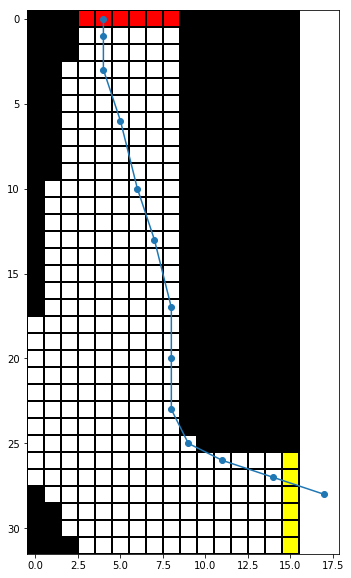

In [77]:
rt.draw_episode(S, A, R)

In [111]:
Q_joakim = np.load(os.path.join(os.getcwd(), 'Q_matrix_Joakim.csv.npy'))

In [98]:
Q_troels = np.load(os.path.join(os.getcwd(), 'Q_matrix_Troels.csv.npy'))

In [139]:
class OffPolicyMonteCarloAgent:
    def __init__(self, track, gamma=0.25, n_episodes=100000, eps=0.9):
        self.track = track
        self.gamma = gamma
        self.n_episodes = n_episodes
        self.eps = eps

        # Initialize Q values and C values
        y_range = track.track.shape[0]
        x_range = track.track.shape[1]
        yvel_range = track.max_vel - track.min_vel + 1
        xvel_range = track.max_vel - track.min_vel + 1
        yacc_range = 3  # -1, 0, +1
        xacc_range = 3  # -1, 0, +1

        # Initialize state-action values
        self.Q = np.zeros((y_range, x_range, yvel_range,
                           xvel_range, yacc_range, xacc_range))
        
        self.C = np.zeros_like(self.Q)

        # Initial Policy
        # For each state: assign equal probability of selecting each valid action from the state
        self.pi = np.empty((y_range, x_range, yvel_range, xvel_range), dtype=object)
        for y_coord in range(self.Q.shape[0]):
            for x_coord in range(self.Q.shape[1]):
                for y_vel in range(track.min_vel, track.max_vel + 1):
                    for x_vel in range(track.min_vel, track.max_vel + 1):
                        valid_actions = self.track.possible_actions(
                            (y_coord, x_coord, y_vel, x_vel))
                        self.pi[y_coord, x_coord, y_vel, x_vel] = random.choice(valid_actions)
                        
    def behavior_policy(self, state):
        if random.random() <= self.eps or self.pi[tuple(state)] is None:
            possible_actions = self.track.possible_actions(state)
            return random.choice(possible_actions)
        return self.pi[tuple(state)]
    
    def greedy_action(self, state):
        # Find greedy action according to state-action values Q
        Q_state = self.Q[tuple(state)].copy()
        if not (Q_state == 0).all():
            Q_state[Q_state == 0] = np.nan
        a = np.unravel_index(np.nanargmax(Q_state, axis=None), Q_state.shape)
        # In case the value is greater than the max allowed action we need to translate it back into
        # negative coordinates
        a = tuple(acc if acc <= 1 else 1 - acc for acc in a)
        return a
    
    def generate_episode(self, policy):
        S = []
        A = []
        R = []

        # Select the initial state randomly
        start_state = self.track.random_start_state()
        S.append(start_state)

        terminated = False
        t = 0
        while not terminated:
            St = S[t]

            if t % 10000 == 0:
                print("Step: {}".format(t))
                
            a = policy(St)
            A.append(a)

            next_state, reward, terminated = self.track.apply_action(St, a)

            R.append(reward)
            S.append(next_state)
            t += 1

            # time.sleep(1)
        print("Terminated after {} steps".format(t))
        return S, A, R
                        
    def policy_iteration(self):
        policy_stable = False
        it = 0
        while True:
            if self.n_episodes is not None and it > self.n_episodes:
                break
            elif self.n_episodes is None and policy_stable:
                break
            
            print('Iteration {}'.format(it))                            

            # (a) Generate an episode using pi
            S, A, R = self.generate_episode(self.behavior_policy)

            G = 0
            W = 1
            for dt in range(len(S)-2, -1, -1):
                St, At, Rt = S[dt], A[dt], R[dt]
                state_action_key = tuple(St.tolist() + list(At))

                G = self.gamma * G + R[dt]
                self.C[state_action_key] = self.C[state_action_key] + W
                self.Q[state_action_key] = self.Q[state_action_key] + W/self.C[state_action_key] * (G - self.Q[state_action_key])
                self.pi[tuple(St)] = self.greedy_action(St)
                
                possible_actions = self.track.possible_actions(St)

                if At != self.pi[tuple(St)]:
                    break
                
                W = W / (1 - self.eps + self.eps / len(possible_actions))
            
            # Counter and update epsilon
            self.eps = 1/(math.sqrt(it+1.1))
            it += 1

In [197]:
agent2 = OffPolicyMonteCarloAgent(rt, n_episodes=1000, eps=0.9, gamma=0.1)

In [198]:
agent2.policy_iteration()

Iteration 0
Step: 0
Terminated after 71 steps
Iteration 1
Step: 0
Terminated after 121 steps
Iteration 2
Step: 0
Terminated after 1759 steps
Iteration 3
Step: 0
Terminated after 35 steps
Iteration 4
Step: 0
Terminated after 393 steps
Iteration 5
Step: 0
Terminated after 4360 steps
Iteration 6
Step: 0
Terminated after 1932 steps
Iteration 7
Step: 0
Terminated after 388 steps
Iteration 8
Step: 0
Terminated after 2402 steps
Iteration 9
Step: 0
Terminated after 1047 steps
Iteration 10
Step: 0
Terminated after 774 steps
Iteration 11
Step: 0
Terminated after 197 steps
Iteration 12
Step: 0
Terminated after 2388 steps
Iteration 13
Step: 0
Terminated after 3753 steps
Iteration 14
Step: 0
Terminated after 2542 steps
Iteration 15
Step: 0
Terminated after 218 steps
Iteration 16
Step: 0
Terminated after 921 steps
Iteration 17
Step: 0
Terminated after 5070 steps
Iteration 18
Step: 0
Terminated after 388 steps
Iteration 19
Step: 0
Terminated after 141 steps
Iteration 20
Step: 0
Terminated after 8475 

Terminated after 126 steps
Iteration 194
Step: 0
Terminated after 22 steps
Iteration 195
Step: 0
Terminated after 34 steps
Iteration 196
Step: 0
Terminated after 44 steps
Iteration 197
Step: 0
Terminated after 16 steps
Iteration 198
Step: 0
Terminated after 44 steps
Iteration 199
Step: 0
Terminated after 46 steps
Iteration 200
Step: 0
Terminated after 25 steps
Iteration 201
Step: 0
Terminated after 33 steps
Iteration 202
Step: 0
Terminated after 84 steps
Iteration 203
Step: 0
Terminated after 39 steps
Iteration 204
Step: 0
Terminated after 20 steps
Iteration 205
Step: 0
Terminated after 16 steps
Iteration 206
Step: 0
Terminated after 18 steps
Iteration 207
Step: 0
Terminated after 22 steps
Iteration 208
Step: 0
Terminated after 13 steps
Iteration 209
Step: 0
Terminated after 52 steps
Iteration 210
Step: 0
Terminated after 13 steps
Iteration 211
Step: 0
Terminated after 22 steps
Iteration 212
Step: 0
Terminated after 94 steps
Iteration 213
Step: 0
Terminated after 11 steps
Iteration 214

Terminated after 75 steps
Iteration 380
Step: 0
Terminated after 17 steps
Iteration 381
Step: 0
Terminated after 70 steps
Iteration 382
Step: 0
Terminated after 20 steps
Iteration 383
Step: 0
Terminated after 11 steps
Iteration 384
Step: 0
Terminated after 13 steps
Iteration 385
Step: 0
Terminated after 21 steps
Iteration 386
Step: 0
Terminated after 61 steps
Iteration 387
Step: 0
Terminated after 11 steps
Iteration 388
Step: 0
Terminated after 71 steps
Iteration 389
Step: 0
Terminated after 49 steps
Iteration 390
Step: 0
Terminated after 27 steps
Iteration 391
Step: 0
Terminated after 38 steps
Iteration 392
Step: 0
Terminated after 14 steps
Iteration 393
Step: 0
Terminated after 23 steps
Iteration 394
Step: 0
Terminated after 17 steps
Iteration 395
Step: 0
Terminated after 47 steps
Iteration 396
Step: 0
Terminated after 21 steps
Iteration 397
Step: 0
Terminated after 24 steps
Iteration 398
Step: 0
Terminated after 63 steps
Iteration 399
Step: 0
Terminated after 18 steps
Iteration 400


Terminated after 11 steps
Iteration 612
Step: 0
Terminated after 15 steps
Iteration 613
Step: 0
Terminated after 11 steps
Iteration 614
Step: 0
Terminated after 22 steps
Iteration 615
Step: 0
Terminated after 13 steps
Iteration 616
Step: 0
Terminated after 48 steps
Iteration 617
Step: 0
Terminated after 29 steps
Iteration 618
Step: 0
Terminated after 12 steps
Iteration 619
Step: 0
Terminated after 14 steps
Iteration 620
Step: 0
Terminated after 35 steps
Iteration 621
Step: 0
Terminated after 37 steps
Iteration 622
Step: 0
Terminated after 19 steps
Iteration 623
Step: 0
Terminated after 27 steps
Iteration 624
Step: 0
Terminated after 15 steps
Iteration 625
Step: 0
Terminated after 17 steps
Iteration 626
Step: 0
Terminated after 11 steps
Iteration 627
Step: 0
Terminated after 11 steps
Iteration 628
Step: 0
Terminated after 36 steps
Iteration 629
Step: 0
Terminated after 19 steps
Iteration 630
Step: 0
Terminated after 13 steps
Iteration 631
Step: 0
Terminated after 11 steps
Iteration 632


Iteration 962
Step: 0
Terminated after 14 steps
Iteration 963
Step: 0
Terminated after 73 steps
Iteration 964
Step: 0
Terminated after 19 steps
Iteration 965
Step: 0
Terminated after 52 steps
Iteration 966
Step: 0
Terminated after 11 steps
Iteration 967
Step: 0
Terminated after 13 steps
Iteration 968
Step: 0
Terminated after 11 steps
Iteration 969
Step: 0
Terminated after 13 steps
Iteration 970
Step: 0
Terminated after 28 steps
Iteration 971
Step: 0
Terminated after 14 steps
Iteration 972
Step: 0
Terminated after 30 steps
Iteration 973
Step: 0
Terminated after 39 steps
Iteration 974
Step: 0
Terminated after 28 steps
Iteration 975
Step: 0
Terminated after 11 steps
Iteration 976
Step: 0
Terminated after 11 steps
Iteration 977
Step: 0
Terminated after 19 steps
Iteration 978
Step: 0
Terminated after 14 steps
Iteration 979
Step: 0
Terminated after 17 steps
Iteration 980
Step: 0
Terminated after 14 steps
Iteration 981
Step: 0
Terminated after 14 steps
Iteration 982
Step: 0
Terminated after 2

In [204]:
%matplotlib inline
from IPython import display
import time

S, A, R = agent2.generate_episode(agent2.greedy_action)

Step: 0
Terminated after 11 steps


[array([0, 3, 0, 0]), array([1, 4, 1, 1]), array([3, 4, 2, 0]), array([4, 4, 1, 0]), array([6, 4, 2, 0]), array([9, 5, 3, 1]), array([13,  5,  4,  0]), array([17,  6,  4,  1]), array([21,  8,  4,  2]), array([26, 11,  5,  3]), array([31, 14,  5,  3]), array([36, 17,  5,  3])]


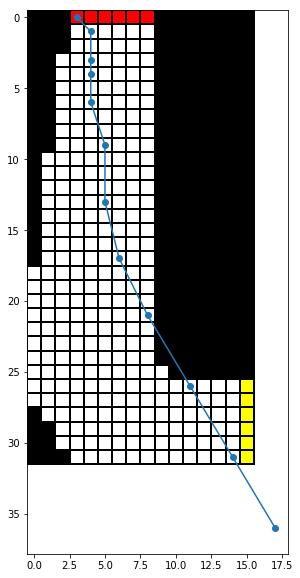

In [205]:
rt.draw_episode(S, A, R)